In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 2312)
(3944610, 8)
validation
(464344, 2312)
(464344, 8)
test
(574820, 2312)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2312)]            0         


 dense (Dense)               (None, 1024)              2368512   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 3058568 (11.67 MB)


Trainable params: 3058568 (11.67 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 9:58 - loss: 2.4879 - STD: 0.0952 - MAE: 0.2211

  3/395 [..............................] - ETA: 13s - loss: 2.2679 - STD: 0.0567 - MAE: 0.2199 

  5/395 [..............................] - ETA: 15s - loss: 2.1840 - STD: 0.0514 - MAE: 0.2183

  6/395 [..............................] - ETA: 17s - loss: 2.1682 - STD: 0.0546 - MAE: 0.2177

  7/395 [..............................] - ETA: 18s - loss: 2.1591 - STD: 0.0573 - MAE: 0.2172

  8/395 [..............................] - ETA: 19s - loss: 2.1513 - STD: 0.0589 - MAE: 0.2169

  9/395 [..............................] - ETA: 19s - loss: 2.1456 - STD: 0.0595 - MAE: 0.2167

 10/395 [..............................] - ETA: 20s - loss: 2.1405 - STD: 0.0592 - MAE: 0.2166

 11/395 [..............................] - ETA: 20s - loss: 2.1349 - STD: 0.0584 - MAE: 0.2165

 12/395 [..............................] - ETA: 20s - loss: 2.1297 - STD: 0.0571 - MAE: 0.2165

 13/395 [..............................] - ETA: 20s - loss: 2.1249 - STD: 0.0557 - MAE: 0.2165

 14/395 [>.............................] - ETA: 20s - loss: 2.1202 - STD: 0.0542 - MAE: 0.2165

 15/395 [>.............................] - ETA: 21s - loss: 2.1159 - STD: 0.0527 - MAE: 0.2166

 16/395 [>.............................] - ETA: 21s - loss: 2.1123 - STD: 0.0513 - MAE: 0.2166

 17/395 [>.............................] - ETA: 21s - loss: 2.1089 - STD: 0.0500 - MAE: 0.2166

 18/395 [>.............................] - ETA: 21s - loss: 2.1058 - STD: 0.0489 - MAE: 0.2166

 19/395 [>.............................] - ETA: 21s - loss: 2.1033 - STD: 0.0479 - MAE: 0.2167

 20/395 [>.............................] - ETA: 21s - loss: 2.1011 - STD: 0.0470 - MAE: 0.2167

 21/395 [>.............................] - ETA: 21s - loss: 2.0995 - STD: 0.0463 - MAE: 0.2167

 22/395 [>.............................] - ETA: 21s - loss: 2.0978 - STD: 0.0455 - MAE: 0.2167

 23/395 [>.............................] - ETA: 21s - loss: 2.0960 - STD: 0.0448 - MAE: 0.2167

 24/395 [>.............................] - ETA: 21s - loss: 2.0944 - STD: 0.0441 - MAE: 0.2168

 25/395 [>.............................] - ETA: 21s - loss: 2.0927 - STD: 0.0434 - MAE: 0.2168

 26/395 [>.............................] - ETA: 21s - loss: 2.0911 - STD: 0.0428 - MAE: 0.2168

 27/395 [=>............................] - ETA: 21s - loss: 2.0896 - STD: 0.0422 - MAE: 0.2168

 28/395 [=>............................] - ETA: 21s - loss: 2.0883 - STD: 0.0418 - MAE: 0.2168

 29/395 [=>............................] - ETA: 21s - loss: 2.0871 - STD: 0.0415 - MAE: 0.2168

 30/395 [=>............................] - ETA: 21s - loss: 2.0860 - STD: 0.0412 - MAE: 0.2168

 31/395 [=>............................] - ETA: 21s - loss: 2.0850 - STD: 0.0410 - MAE: 0.2168

 32/395 [=>............................] - ETA: 21s - loss: 2.0840 - STD: 0.0408 - MAE: 0.2168

 33/395 [=>............................] - ETA: 21s - loss: 2.0829 - STD: 0.0407 - MAE: 0.2167

 34/395 [=>............................] - ETA: 21s - loss: 2.0822 - STD: 0.0407 - MAE: 0.2167

 35/395 [=>............................] - ETA: 21s - loss: 2.0814 - STD: 0.0406 - MAE: 0.2167

 36/395 [=>............................] - ETA: 21s - loss: 2.0807 - STD: 0.0405 - MAE: 0.2167

 37/395 [=>............................] - ETA: 21s - loss: 2.0799 - STD: 0.0405 - MAE: 0.2167

 38/395 [=>............................] - ETA: 21s - loss: 2.0790 - STD: 0.0404 - MAE: 0.2167

 39/395 [=>............................] - ETA: 21s - loss: 2.0783 - STD: 0.0403 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 21s - loss: 2.0777 - STD: 0.0401 - MAE: 0.2167

 41/395 [==>...........................] - ETA: 21s - loss: 2.0770 - STD: 0.0400 - MAE: 0.2167

 42/395 [==>...........................] - ETA: 21s - loss: 2.0765 - STD: 0.0398 - MAE: 0.2167

 43/395 [==>...........................] - ETA: 20s - loss: 2.0758 - STD: 0.0396 - MAE: 0.2167

 44/395 [==>...........................] - ETA: 20s - loss: 2.0752 - STD: 0.0393 - MAE: 0.2167

 45/395 [==>...........................] - ETA: 20s - loss: 2.0747 - STD: 0.0391 - MAE: 0.2167

 46/395 [==>...........................] - ETA: 20s - loss: 2.0742 - STD: 0.0389 - MAE: 0.2167

 47/395 [==>...........................] - ETA: 20s - loss: 2.0737 - STD: 0.0386 - MAE: 0.2167

 48/395 [==>...........................] - ETA: 20s - loss: 2.0733 - STD: 0.0384 - MAE: 0.2167

 49/395 [==>...........................] - ETA: 20s - loss: 2.0728 - STD: 0.0382 - MAE: 0.2167

 50/395 [==>...........................] - ETA: 20s - loss: 2.0722 - STD: 0.0380 - MAE: 0.2167

 51/395 [==>...........................] - ETA: 20s - loss: 2.0718 - STD: 0.0379 - MAE: 0.2167

 52/395 [==>...........................] - ETA: 20s - loss: 2.0713 - STD: 0.0378 - MAE: 0.2167

 53/395 [===>..........................] - ETA: 20s - loss: 2.0709 - STD: 0.0377 - MAE: 0.2167

 54/395 [===>..........................] - ETA: 20s - loss: 2.0705 - STD: 0.0376 - MAE: 0.2167

 55/395 [===>..........................] - ETA: 20s - loss: 2.0701 - STD: 0.0375 - MAE: 0.2167

 56/395 [===>..........................] - ETA: 20s - loss: 2.0696 - STD: 0.0374 - MAE: 0.2167

 57/395 [===>..........................] - ETA: 20s - loss: 2.0692 - STD: 0.0373 - MAE: 0.2167

 58/395 [===>..........................] - ETA: 20s - loss: 2.0687 - STD: 0.0373 - MAE: 0.2167

 59/395 [===>..........................] - ETA: 20s - loss: 2.0683 - STD: 0.0372 - MAE: 0.2167

 60/395 [===>..........................] - ETA: 20s - loss: 2.0678 - STD: 0.0372 - MAE: 0.2167

 61/395 [===>..........................] - ETA: 20s - loss: 2.0674 - STD: 0.0371 - MAE: 0.2167

 62/395 [===>..........................] - ETA: 20s - loss: 2.0669 - STD: 0.0371 - MAE: 0.2167

 63/395 [===>..........................] - ETA: 19s - loss: 2.0665 - STD: 0.0370 - MAE: 0.2167

 64/395 [===>..........................] - ETA: 19s - loss: 2.0660 - STD: 0.0369 - MAE: 0.2166

 65/395 [===>..........................] - ETA: 19s - loss: 2.0656 - STD: 0.0368 - MAE: 0.2166

 66/395 [====>.........................] - ETA: 19s - loss: 2.0650 - STD: 0.0367 - MAE: 0.2166

 67/395 [====>.........................] - ETA: 19s - loss: 2.0645 - STD: 0.0366 - MAE: 0.2166

 68/395 [====>.........................] - ETA: 19s - loss: 2.0639 - STD: 0.0365 - MAE: 0.2166

 69/395 [====>.........................] - ETA: 19s - loss: 2.0633 - STD: 0.0364 - MAE: 0.2166

 70/395 [====>.........................] - ETA: 19s - loss: 2.0626 - STD: 0.0364 - MAE: 0.2166

 71/395 [====>.........................] - ETA: 19s - loss: 2.0619 - STD: 0.0364 - MAE: 0.2166

 72/395 [====>.........................] - ETA: 19s - loss: 2.0611 - STD: 0.0363 - MAE: 0.2166

 73/395 [====>.........................] - ETA: 19s - loss: 2.0603 - STD: 0.0363 - MAE: 0.2165

 74/395 [====>.........................] - ETA: 19s - loss: 2.0594 - STD: 0.0363 - MAE: 0.2165

 75/395 [====>.........................] - ETA: 19s - loss: 2.0585 - STD: 0.0363 - MAE: 0.2165

 76/395 [====>.........................] - ETA: 19s - loss: 2.0575 - STD: 0.0363 - MAE: 0.2164

 77/395 [====>.........................] - ETA: 19s - loss: 2.0563 - STD: 0.0364 - MAE: 0.2164

 78/395 [====>.........................] - ETA: 19s - loss: 2.0550 - STD: 0.0364 - MAE: 0.2164

 79/395 [=====>........................] - ETA: 19s - loss: 2.0538 - STD: 0.0364 - MAE: 0.2163

 80/395 [=====>........................] - ETA: 19s - loss: 2.0524 - STD: 0.0365 - MAE: 0.2163

 81/395 [=====>........................] - ETA: 19s - loss: 2.0509 - STD: 0.0366 - MAE: 0.2162

 82/395 [=====>........................] - ETA: 18s - loss: 2.0493 - STD: 0.0368 - MAE: 0.2162

 83/395 [=====>........................] - ETA: 18s - loss: 2.0476 - STD: 0.0369 - MAE: 0.2161

 84/395 [=====>........................] - ETA: 18s - loss: 2.0459 - STD: 0.0371 - MAE: 0.2160

 85/395 [=====>........................] - ETA: 18s - loss: 2.0441 - STD: 0.0374 - MAE: 0.2160

 86/395 [=====>........................] - ETA: 18s - loss: 2.0423 - STD: 0.0376 - MAE: 0.2159

 87/395 [=====>........................] - ETA: 18s - loss: 2.0405 - STD: 0.0379 - MAE: 0.2158

 88/395 [=====>........................] - ETA: 18s - loss: 2.0385 - STD: 0.0382 - MAE: 0.2157

 89/395 [=====>........................] - ETA: 18s - loss: 2.0365 - STD: 0.0385 - MAE: 0.2156

 90/395 [=====>........................] - ETA: 18s - loss: 2.0344 - STD: 0.0388 - MAE: 0.2155

 91/395 [=====>........................] - ETA: 18s - loss: 2.0323 - STD: 0.0392 - MAE: 0.2154

 92/395 [=====>........................] - ETA: 18s - loss: 2.0303 - STD: 0.0396 - MAE: 0.2153

 93/395 [======>.......................] - ETA: 18s - loss: 2.0281 - STD: 0.0399 - MAE: 0.2152

 94/395 [======>.......................] - ETA: 18s - loss: 2.0262 - STD: 0.0403 - MAE: 0.2151

 95/395 [======>.......................] - ETA: 18s - loss: 2.0241 - STD: 0.0407 - MAE: 0.2150

 96/395 [======>.......................] - ETA: 18s - loss: 2.0219 - STD: 0.0410 - MAE: 0.2149

 97/395 [======>.......................] - ETA: 18s - loss: 2.0197 - STD: 0.0414 - MAE: 0.2148

 98/395 [======>.......................] - ETA: 18s - loss: 2.0175 - STD: 0.0418 - MAE: 0.2147

 99/395 [======>.......................] - ETA: 17s - loss: 2.0152 - STD: 0.0421 - MAE: 0.2146

100/395 [======>.......................] - ETA: 17s - loss: 2.0128 - STD: 0.0425 - MAE: 0.2145

101/395 [======>.......................] - ETA: 17s - loss: 2.0105 - STD: 0.0428 - MAE: 0.2144

102/395 [======>.......................] - ETA: 17s - loss: 2.0080 - STD: 0.0432 - MAE: 0.2143

103/395 [======>.......................] - ETA: 17s - loss: 2.0054 - STD: 0.0435 - MAE: 0.2142

104/395 [======>.......................] - ETA: 17s - loss: 2.0026 - STD: 0.0439 - MAE: 0.2140

105/395 [======>.......................] - ETA: 17s - loss: 1.9998 - STD: 0.0442 - MAE: 0.2139

106/395 [=======>......................] - ETA: 17s - loss: 1.9968 - STD: 0.0446 - MAE: 0.2138

107/395 [=======>......................] - ETA: 17s - loss: 1.9938 - STD: 0.0449 - MAE: 0.2136

108/395 [=======>......................] - ETA: 17s - loss: 1.9908 - STD: 0.0453 - MAE: 0.2135

109/395 [=======>......................] - ETA: 17s - loss: 1.9879 - STD: 0.0457 - MAE: 0.2134

110/395 [=======>......................] - ETA: 17s - loss: 1.9848 - STD: 0.0461 - MAE: 0.2132

111/395 [=======>......................] - ETA: 17s - loss: 1.9815 - STD: 0.0466 - MAE: 0.2130

112/395 [=======>......................] - ETA: 17s - loss: 1.9784 - STD: 0.0470 - MAE: 0.2129

113/395 [=======>......................] - ETA: 17s - loss: 1.9750 - STD: 0.0475 - MAE: 0.2127

114/395 [=======>......................] - ETA: 17s - loss: 1.9717 - STD: 0.0479 - MAE: 0.2125

115/395 [=======>......................] - ETA: 17s - loss: 1.9683 - STD: 0.0484 - MAE: 0.2124

116/395 [=======>......................] - ETA: 17s - loss: 1.9648 - STD: 0.0489 - MAE: 0.2122

117/395 [=======>......................] - ETA: 16s - loss: 1.9613 - STD: 0.0494 - MAE: 0.2120

118/395 [=======>......................] - ETA: 16s - loss: 1.9577 - STD: 0.0499 - MAE: 0.2118

119/395 [========>.....................] - ETA: 16s - loss: 1.9541 - STD: 0.0504 - MAE: 0.2116

120/395 [========>.....................] - ETA: 16s - loss: 1.9505 - STD: 0.0509 - MAE: 0.2114

121/395 [========>.....................] - ETA: 16s - loss: 1.9469 - STD: 0.0514 - MAE: 0.2112

122/395 [========>.....................] - ETA: 16s - loss: 1.9434 - STD: 0.0519 - MAE: 0.2110

123/395 [========>.....................] - ETA: 16s - loss: 1.9397 - STD: 0.0525 - MAE: 0.2108

124/395 [========>.....................] - ETA: 16s - loss: 1.9362 - STD: 0.0530 - MAE: 0.2106

125/395 [========>.....................] - ETA: 16s - loss: 1.9324 - STD: 0.0535 - MAE: 0.2104

126/395 [========>.....................] - ETA: 16s - loss: 1.9289 - STD: 0.0541 - MAE: 0.2102

127/395 [========>.....................] - ETA: 16s - loss: 1.9252 - STD: 0.0546 - MAE: 0.2100

128/395 [========>.....................] - ETA: 16s - loss: 1.9216 - STD: 0.0552 - MAE: 0.2098

129/395 [========>.....................] - ETA: 16s - loss: 1.9180 - STD: 0.0557 - MAE: 0.2096

130/395 [========>.....................] - ETA: 16s - loss: 1.9145 - STD: 0.0563 - MAE: 0.2094

131/395 [========>.....................] - ETA: 16s - loss: 1.9109 - STD: 0.0568 - MAE: 0.2092

132/395 [=========>....................] - ETA: 16s - loss: 1.9072 - STD: 0.0574 - MAE: 0.2090

133/395 [=========>....................] - ETA: 16s - loss: 1.9037 - STD: 0.0579 - MAE: 0.2088

134/395 [=========>....................] - ETA: 15s - loss: 1.9002 - STD: 0.0585 - MAE: 0.2085

135/395 [=========>....................] - ETA: 15s - loss: 1.8967 - STD: 0.0590 - MAE: 0.2083

136/395 [=========>....................] - ETA: 15s - loss: 1.8932 - STD: 0.0596 - MAE: 0.2081

137/395 [=========>....................] - ETA: 15s - loss: 1.8897 - STD: 0.0601 - MAE: 0.2079

138/395 [=========>....................] - ETA: 15s - loss: 1.8864 - STD: 0.0607 - MAE: 0.2077

139/395 [=========>....................] - ETA: 15s - loss: 1.8831 - STD: 0.0612 - MAE: 0.2075

140/395 [=========>....................] - ETA: 15s - loss: 1.8797 - STD: 0.0618 - MAE: 0.2073

141/395 [=========>....................] - ETA: 15s - loss: 1.8763 - STD: 0.0623 - MAE: 0.2071

142/395 [=========>....................] - ETA: 15s - loss: 1.8730 - STD: 0.0628 - MAE: 0.2069

143/395 [=========>....................] - ETA: 15s - loss: 1.8697 - STD: 0.0634 - MAE: 0.2067

144/395 [=========>....................] - ETA: 15s - loss: 1.8665 - STD: 0.0639 - MAE: 0.2065

145/395 [==========>...................] - ETA: 15s - loss: 1.8632 - STD: 0.0644 - MAE: 0.2062

146/395 [==========>...................] - ETA: 15s - loss: 1.8600 - STD: 0.0650 - MAE: 0.2060

147/395 [==========>...................] - ETA: 15s - loss: 1.8568 - STD: 0.0655 - MAE: 0.2058

148/395 [==========>...................] - ETA: 15s - loss: 1.8537 - STD: 0.0660 - MAE: 0.2056

149/395 [==========>...................] - ETA: 15s - loss: 1.8506 - STD: 0.0665 - MAE: 0.2054

150/395 [==========>...................] - ETA: 15s - loss: 1.8475 - STD: 0.0670 - MAE: 0.2052

151/395 [==========>...................] - ETA: 14s - loss: 1.8444 - STD: 0.0675 - MAE: 0.2050

152/395 [==========>...................] - ETA: 14s - loss: 1.8413 - STD: 0.0680 - MAE: 0.2048

153/395 [==========>...................] - ETA: 14s - loss: 1.8383 - STD: 0.0685 - MAE: 0.2046

154/395 [==========>...................] - ETA: 14s - loss: 1.8353 - STD: 0.0690 - MAE: 0.2045

155/395 [==========>...................] - ETA: 14s - loss: 1.8324 - STD: 0.0695 - MAE: 0.2043

156/395 [==========>...................] - ETA: 14s - loss: 1.8293 - STD: 0.0700 - MAE: 0.2041

157/395 [==========>...................] - ETA: 14s - loss: 1.8264 - STD: 0.0705 - MAE: 0.2039

158/395 [===========>..................] - ETA: 14s - loss: 1.8235 - STD: 0.0709 - MAE: 0.2037

159/395 [===========>..................] - ETA: 14s - loss: 1.8206 - STD: 0.0714 - MAE: 0.2035

160/395 [===========>..................] - ETA: 14s - loss: 1.8178 - STD: 0.0719 - MAE: 0.2033

161/395 [===========>..................] - ETA: 14s - loss: 1.8149 - STD: 0.0723 - MAE: 0.2031

162/395 [===========>..................] - ETA: 14s - loss: 1.8122 - STD: 0.0728 - MAE: 0.2029

163/395 [===========>..................] - ETA: 14s - loss: 1.8096 - STD: 0.0732 - MAE: 0.2028

164/395 [===========>..................] - ETA: 14s - loss: 1.8070 - STD: 0.0737 - MAE: 0.2026

165/395 [===========>..................] - ETA: 14s - loss: 1.8042 - STD: 0.0741 - MAE: 0.2024

166/395 [===========>..................] - ETA: 14s - loss: 1.8015 - STD: 0.0746 - MAE: 0.2022

167/395 [===========>..................] - ETA: 13s - loss: 1.7990 - STD: 0.0750 - MAE: 0.2021

168/395 [===========>..................] - ETA: 13s - loss: 1.7962 - STD: 0.0755 - MAE: 0.2019

169/395 [===========>..................] - ETA: 13s - loss: 1.7937 - STD: 0.0759 - MAE: 0.2017

170/395 [===========>..................] - ETA: 13s - loss: 1.7911 - STD: 0.0763 - MAE: 0.2015

171/395 [===========>..................] - ETA: 13s - loss: 1.7885 - STD: 0.0768 - MAE: 0.2013

172/395 [============>.................] - ETA: 13s - loss: 1.7859 - STD: 0.0772 - MAE: 0.2012

173/395 [============>.................] - ETA: 13s - loss: 1.7833 - STD: 0.0776 - MAE: 0.2010

174/395 [============>.................] - ETA: 13s - loss: 1.7807 - STD: 0.0780 - MAE: 0.2008

175/395 [============>.................] - ETA: 13s - loss: 1.7783 - STD: 0.0784 - MAE: 0.2007

176/395 [============>.................] - ETA: 13s - loss: 1.7760 - STD: 0.0788 - MAE: 0.2005

177/395 [============>.................] - ETA: 13s - loss: 1.7735 - STD: 0.0792 - MAE: 0.2003

178/395 [============>.................] - ETA: 13s - loss: 1.7710 - STD: 0.0797 - MAE: 0.2002

179/395 [============>.................] - ETA: 13s - loss: 1.7687 - STD: 0.0800 - MAE: 0.2000

180/395 [============>.................] - ETA: 13s - loss: 1.7663 - STD: 0.0804 - MAE: 0.1998

181/395 [============>.................] - ETA: 13s - loss: 1.7638 - STD: 0.0808 - MAE: 0.1997

182/395 [============>.................] - ETA: 13s - loss: 1.7614 - STD: 0.0812 - MAE: 0.1995

183/395 [============>.................] - ETA: 13s - loss: 1.7590 - STD: 0.0816 - MAE: 0.1994

184/395 [============>.................] - ETA: 12s - loss: 1.7567 - STD: 0.0820 - MAE: 0.1992

185/395 [=============>................] - ETA: 12s - loss: 1.7544 - STD: 0.0824 - MAE: 0.1990

186/395 [=============>................] - ETA: 12s - loss: 1.7521 - STD: 0.0827 - MAE: 0.1989

187/395 [=============>................] - ETA: 12s - loss: 1.7497 - STD: 0.0831 - MAE: 0.1987

188/395 [=============>................] - ETA: 12s - loss: 1.7476 - STD: 0.0835 - MAE: 0.1986

189/395 [=============>................] - ETA: 12s - loss: 1.7454 - STD: 0.0838 - MAE: 0.1984

190/395 [=============>................] - ETA: 12s - loss: 1.7431 - STD: 0.0842 - MAE: 0.1983

191/395 [=============>................] - ETA: 12s - loss: 1.7409 - STD: 0.0846 - MAE: 0.1981

192/395 [=============>................] - ETA: 12s - loss: 1.7387 - STD: 0.0849 - MAE: 0.1980

193/395 [=============>................] - ETA: 12s - loss: 1.7364 - STD: 0.0853 - MAE: 0.1978

194/395 [=============>................] - ETA: 12s - loss: 1.7342 - STD: 0.0856 - MAE: 0.1977

195/395 [=============>................] - ETA: 12s - loss: 1.7320 - STD: 0.0860 - MAE: 0.1975

196/395 [=============>................] - ETA: 12s - loss: 1.7298 - STD: 0.0863 - MAE: 0.1974

197/395 [=============>................] - ETA: 12s - loss: 1.7277 - STD: 0.0867 - MAE: 0.1972

198/395 [==============>...............] - ETA: 12s - loss: 1.7256 - STD: 0.0870 - MAE: 0.1971

199/395 [==============>...............] - ETA: 12s - loss: 1.7235 - STD: 0.0874 - MAE: 0.1969

200/395 [==============>...............] - ETA: 11s - loss: 1.7213 - STD: 0.0877 - MAE: 0.1968

201/395 [==============>...............] - ETA: 11s - loss: 1.7193 - STD: 0.0880 - MAE: 0.1966

202/395 [==============>...............] - ETA: 11s - loss: 1.7173 - STD: 0.0884 - MAE: 0.1965

203/395 [==============>...............] - ETA: 11s - loss: 1.7152 - STD: 0.0887 - MAE: 0.1963

204/395 [==============>...............] - ETA: 11s - loss: 1.7131 - STD: 0.0890 - MAE: 0.1962

205/395 [==============>...............] - ETA: 11s - loss: 1.7112 - STD: 0.0894 - MAE: 0.1960

206/395 [==============>...............] - ETA: 11s - loss: 1.7094 - STD: 0.0897 - MAE: 0.1959

207/395 [==============>...............] - ETA: 11s - loss: 1.7074 - STD: 0.0900 - MAE: 0.1958

208/395 [==============>...............] - ETA: 11s - loss: 1.7054 - STD: 0.0903 - MAE: 0.1956

209/395 [==============>...............] - ETA: 11s - loss: 1.7035 - STD: 0.0906 - MAE: 0.1955

210/395 [==============>...............] - ETA: 11s - loss: 1.7015 - STD: 0.0910 - MAE: 0.1954

211/395 [===============>..............] - ETA: 11s - loss: 1.6995 - STD: 0.0913 - MAE: 0.1952

212/395 [===============>..............] - ETA: 11s - loss: 1.6976 - STD: 0.0916 - MAE: 0.1951

213/395 [===============>..............] - ETA: 11s - loss: 1.6956 - STD: 0.0919 - MAE: 0.1949

214/395 [===============>..............] - ETA: 11s - loss: 1.6937 - STD: 0.0922 - MAE: 0.1948

215/395 [===============>..............] - ETA: 11s - loss: 1.6918 - STD: 0.0925 - MAE: 0.1947

216/395 [===============>..............] - ETA: 11s - loss: 1.6899 - STD: 0.0928 - MAE: 0.1945

217/395 [===============>..............] - ETA: 10s - loss: 1.6879 - STD: 0.0931 - MAE: 0.1944

218/395 [===============>..............] - ETA: 10s - loss: 1.6860 - STD: 0.0934 - MAE: 0.1943

219/395 [===============>..............] - ETA: 10s - loss: 1.6841 - STD: 0.0937 - MAE: 0.1941

220/395 [===============>..............] - ETA: 10s - loss: 1.6823 - STD: 0.0940 - MAE: 0.1940

221/395 [===============>..............] - ETA: 10s - loss: 1.6804 - STD: 0.0943 - MAE: 0.1938

222/395 [===============>..............] - ETA: 10s - loss: 1.6785 - STD: 0.0946 - MAE: 0.1937

223/395 [===============>..............] - ETA: 10s - loss: 1.6767 - STD: 0.0949 - MAE: 0.1936

224/395 [================>.............] - ETA: 10s - loss: 1.6748 - STD: 0.0952 - MAE: 0.1934

225/395 [================>.............] - ETA: 10s - loss: 1.6730 - STD: 0.0955 - MAE: 0.1933

226/395 [================>.............] - ETA: 10s - loss: 1.6711 - STD: 0.0958 - MAE: 0.1932

227/395 [================>.............] - ETA: 10s - loss: 1.6694 - STD: 0.0961 - MAE: 0.1930

228/395 [================>.............] - ETA: 10s - loss: 1.6675 - STD: 0.0964 - MAE: 0.1929

229/395 [================>.............] - ETA: 10s - loss: 1.6658 - STD: 0.0966 - MAE: 0.1928

230/395 [================>.............] - ETA: 10s - loss: 1.6640 - STD: 0.0969 - MAE: 0.1926

231/395 [================>.............] - ETA: 10s - loss: 1.6622 - STD: 0.0972 - MAE: 0.1925

232/395 [================>.............] - ETA: 10s - loss: 1.6604 - STD: 0.0975 - MAE: 0.1924

233/395 [================>.............] - ETA: 9s - loss: 1.6586 - STD: 0.0978 - MAE: 0.1922 

234/395 [================>.............] - ETA: 9s - loss: 1.6568 - STD: 0.0981 - MAE: 0.1921

235/395 [================>.............] - ETA: 9s - loss: 1.6550 - STD: 0.0984 - MAE: 0.1920

236/395 [================>.............] - ETA: 9s - loss: 1.6533 - STD: 0.0987 - MAE: 0.1918

237/395 [=================>............] - ETA: 9s - loss: 1.6516 - STD: 0.0989 - MAE: 0.1917

238/395 [=================>............] - ETA: 9s - loss: 1.6500 - STD: 0.0992 - MAE: 0.1916

239/395 [=================>............] - ETA: 9s - loss: 1.6483 - STD: 0.0995 - MAE: 0.1915

240/395 [=================>............] - ETA: 9s - loss: 1.6467 - STD: 0.0998 - MAE: 0.1913

241/395 [=================>............] - ETA: 9s - loss: 1.6450 - STD: 0.1000 - MAE: 0.1912

242/395 [=================>............] - ETA: 9s - loss: 1.6434 - STD: 0.1003 - MAE: 0.1911

243/395 [=================>............] - ETA: 9s - loss: 1.6417 - STD: 0.1006 - MAE: 0.1910

244/395 [=================>............] - ETA: 9s - loss: 1.6400 - STD: 0.1009 - MAE: 0.1908

245/395 [=================>............] - ETA: 9s - loss: 1.6384 - STD: 0.1011 - MAE: 0.1907

246/395 [=================>............] - ETA: 9s - loss: 1.6369 - STD: 0.1014 - MAE: 0.1906

247/395 [=================>............] - ETA: 9s - loss: 1.6352 - STD: 0.1017 - MAE: 0.1904

248/395 [=================>............] - ETA: 8s - loss: 1.6336 - STD: 0.1020 - MAE: 0.1903

249/395 [=================>............] - ETA: 8s - loss: 1.6320 - STD: 0.1022 - MAE: 0.1902

250/395 [=================>............] - ETA: 8s - loss: 1.6304 - STD: 0.1025 - MAE: 0.1901

251/395 [==================>...........] - ETA: 8s - loss: 1.6289 - STD: 0.1027 - MAE: 0.1900

252/395 [==================>...........] - ETA: 8s - loss: 1.6274 - STD: 0.1030 - MAE: 0.1898

253/395 [==================>...........] - ETA: 8s - loss: 1.6259 - STD: 0.1033 - MAE: 0.1897

254/395 [==================>...........] - ETA: 8s - loss: 1.6243 - STD: 0.1035 - MAE: 0.1896

255/395 [==================>...........] - ETA: 8s - loss: 1.6228 - STD: 0.1038 - MAE: 0.1895

256/395 [==================>...........] - ETA: 8s - loss: 1.6213 - STD: 0.1040 - MAE: 0.1894

257/395 [==================>...........] - ETA: 8s - loss: 1.6197 - STD: 0.1043 - MAE: 0.1892

258/395 [==================>...........] - ETA: 8s - loss: 1.6182 - STD: 0.1046 - MAE: 0.1891

259/395 [==================>...........] - ETA: 8s - loss: 1.6167 - STD: 0.1048 - MAE: 0.1890

260/395 [==================>...........] - ETA: 8s - loss: 1.6152 - STD: 0.1051 - MAE: 0.1889

261/395 [==================>...........] - ETA: 8s - loss: 1.6137 - STD: 0.1053 - MAE: 0.1888

262/395 [==================>...........] - ETA: 8s - loss: 1.6123 - STD: 0.1055 - MAE: 0.1886

263/395 [==================>...........] - ETA: 7s - loss: 1.6108 - STD: 0.1058 - MAE: 0.1885

264/395 [===================>..........] - ETA: 7s - loss: 1.6093 - STD: 0.1060 - MAE: 0.1884

265/395 [===================>..........] - ETA: 7s - loss: 1.6078 - STD: 0.1063 - MAE: 0.1883

266/395 [===================>..........] - ETA: 7s - loss: 1.6063 - STD: 0.1065 - MAE: 0.1882

267/395 [===================>..........] - ETA: 7s - loss: 1.6049 - STD: 0.1067 - MAE: 0.1881

268/395 [===================>..........] - ETA: 7s - loss: 1.6034 - STD: 0.1070 - MAE: 0.1880

269/395 [===================>..........] - ETA: 7s - loss: 1.6020 - STD: 0.1072 - MAE: 0.1879

270/395 [===================>..........] - ETA: 7s - loss: 1.6006 - STD: 0.1075 - MAE: 0.1877

271/395 [===================>..........] - ETA: 7s - loss: 1.5992 - STD: 0.1077 - MAE: 0.1876

272/395 [===================>..........] - ETA: 7s - loss: 1.5977 - STD: 0.1079 - MAE: 0.1875

273/395 [===================>..........] - ETA: 7s - loss: 1.5964 - STD: 0.1082 - MAE: 0.1874

274/395 [===================>..........] - ETA: 7s - loss: 1.5950 - STD: 0.1084 - MAE: 0.1873

275/395 [===================>..........] - ETA: 7s - loss: 1.5936 - STD: 0.1086 - MAE: 0.1872

277/395 [====================>.........] - ETA: 7s - loss: 1.5908 - STD: 0.1091 - MAE: 0.1870

279/395 [====================>.........] - ETA: 6s - loss: 1.5880 - STD: 0.1096 - MAE: 0.1867

281/395 [====================>.........] - ETA: 6s - loss: 1.5854 - STD: 0.1100 - MAE: 0.1865

282/395 [====================>.........] - ETA: 6s - loss: 1.5841 - STD: 0.1102 - MAE: 0.1864

283/395 [====================>.........] - ETA: 6s - loss: 1.5827 - STD: 0.1104 - MAE: 0.1863

284/395 [====================>.........] - ETA: 6s - loss: 1.5815 - STD: 0.1107 - MAE: 0.1862

285/395 [====================>.........] - ETA: 6s - loss: 1.5802 - STD: 0.1109 - MAE: 0.1861

286/395 [====================>.........] - ETA: 6s - loss: 1.5788 - STD: 0.1111 - MAE: 0.1860

288/395 [====================>.........] - ETA: 6s - loss: 1.5764 - STD: 0.1115 - MAE: 0.1858

289/395 [====================>.........] - ETA: 6s - loss: 1.5751 - STD: 0.1118 - MAE: 0.1857

290/395 [=====================>........] - ETA: 6s - loss: 1.5740 - STD: 0.1120 - MAE: 0.1856

291/395 [=====================>........] - ETA: 6s - loss: 1.5728 - STD: 0.1122 - MAE: 0.1855

292/395 [=====================>........] - ETA: 6s - loss: 1.5715 - STD: 0.1124 - MAE: 0.1854

293/395 [=====================>........] - ETA: 6s - loss: 1.5704 - STD: 0.1126 - MAE: 0.1853

294/395 [=====================>........] - ETA: 6s - loss: 1.5691 - STD: 0.1128 - MAE: 0.1852

295/395 [=====================>........] - ETA: 5s - loss: 1.5680 - STD: 0.1130 - MAE: 0.1851

296/395 [=====================>........] - ETA: 5s - loss: 1.5668 - STD: 0.1132 - MAE: 0.1850

297/395 [=====================>........] - ETA: 5s - loss: 1.5656 - STD: 0.1134 - MAE: 0.1849

298/395 [=====================>........] - ETA: 5s - loss: 1.5644 - STD: 0.1137 - MAE: 0.1848

299/395 [=====================>........] - ETA: 5s - loss: 1.5632 - STD: 0.1139 - MAE: 0.1847

300/395 [=====================>........] - ETA: 5s - loss: 1.5621 - STD: 0.1140 - MAE: 0.1846

301/395 [=====================>........] - ETA: 5s - loss: 1.5609 - STD: 0.1142 - MAE: 0.1845

302/395 [=====================>........] - ETA: 5s - loss: 1.5597 - STD: 0.1145 - MAE: 0.1844

303/395 [======================>.......] - ETA: 5s - loss: 1.5585 - STD: 0.1147 - MAE: 0.1843

304/395 [======================>.......] - ETA: 5s - loss: 1.5573 - STD: 0.1149 - MAE: 0.1842

305/395 [======================>.......] - ETA: 5s - loss: 1.5561 - STD: 0.1151 - MAE: 0.1841

306/395 [======================>.......] - ETA: 5s - loss: 1.5549 - STD: 0.1152 - MAE: 0.1841

307/395 [======================>.......] - ETA: 5s - loss: 1.5538 - STD: 0.1154 - MAE: 0.1840

308/395 [======================>.......] - ETA: 5s - loss: 1.5527 - STD: 0.1156 - MAE: 0.1839

309/395 [======================>.......] - ETA: 5s - loss: 1.5515 - STD: 0.1158 - MAE: 0.1838

310/395 [======================>.......] - ETA: 5s - loss: 1.5503 - STD: 0.1160 - MAE: 0.1837

311/395 [======================>.......] - ETA: 5s - loss: 1.5491 - STD: 0.1162 - MAE: 0.1836

312/395 [======================>.......] - ETA: 4s - loss: 1.5480 - STD: 0.1164 - MAE: 0.1835

313/395 [======================>.......] - ETA: 4s - loss: 1.5470 - STD: 0.1166 - MAE: 0.1834

314/395 [======================>.......] - ETA: 4s - loss: 1.5458 - STD: 0.1168 - MAE: 0.1833

315/395 [======================>.......] - ETA: 4s - loss: 1.5447 - STD: 0.1169 - MAE: 0.1832

316/395 [=======================>......] - ETA: 4s - loss: 1.5435 - STD: 0.1171 - MAE: 0.1831

317/395 [=======================>......] - ETA: 4s - loss: 1.5423 - STD: 0.1173 - MAE: 0.1830

318/395 [=======================>......] - ETA: 4s - loss: 1.5412 - STD: 0.1175 - MAE: 0.1829

319/395 [=======================>......] - ETA: 4s - loss: 1.5400 - STD: 0.1177 - MAE: 0.1829

320/395 [=======================>......] - ETA: 4s - loss: 1.5389 - STD: 0.1179 - MAE: 0.1828

321/395 [=======================>......] - ETA: 4s - loss: 1.5385 - STD: 0.1181 - MAE: 0.1827

323/395 [=======================>......] - ETA: 4s - loss: 1.5363 - STD: 0.1184 - MAE: 0.1825

325/395 [=======================>......] - ETA: 4s - loss: 1.5340 - STD: 0.1188 - MAE: 0.1823

326/395 [=======================>......] - ETA: 4s - loss: 1.5329 - STD: 0.1190 - MAE: 0.1822

328/395 [=======================>......] - ETA: 4s - loss: 1.5307 - STD: 0.1193 - MAE: 0.1820

330/395 [========================>.....] - ETA: 4s - loss: 1.5284 - STD: 0.1197 - MAE: 0.1819

331/395 [========================>.....] - ETA: 4s - loss: 1.5274 - STD: 0.1199 - MAE: 0.1818

332/395 [========================>.....] - ETA: 3s - loss: 1.5263 - STD: 0.1200 - MAE: 0.1817

333/395 [========================>.....] - ETA: 3s - loss: 1.5253 - STD: 0.1202 - MAE: 0.1816

334/395 [========================>.....] - ETA: 3s - loss: 1.5242 - STD: 0.1204 - MAE: 0.1815

335/395 [========================>.....] - ETA: 3s - loss: 1.5232 - STD: 0.1206 - MAE: 0.1814

336/395 [========================>.....] - ETA: 3s - loss: 1.5221 - STD: 0.1207 - MAE: 0.1813

337/395 [========================>.....] - ETA: 3s - loss: 1.5211 - STD: 0.1209 - MAE: 0.1813

338/395 [========================>.....] - ETA: 3s - loss: 1.5200 - STD: 0.1211 - MAE: 0.1812

339/395 [========================>.....] - ETA: 3s - loss: 1.5190 - STD: 0.1213 - MAE: 0.1811

340/395 [========================>.....] - ETA: 3s - loss: 1.5179 - STD: 0.1214 - MAE: 0.1810

341/395 [========================>.....] - ETA: 3s - loss: 1.5169 - STD: 0.1216 - MAE: 0.1809

342/395 [========================>.....] - ETA: 3s - loss: 1.5158 - STD: 0.1218 - MAE: 0.1808

343/395 [=========================>....] - ETA: 3s - loss: 1.5148 - STD: 0.1219 - MAE: 0.1807

344/395 [=========================>....] - ETA: 3s - loss: 1.5137 - STD: 0.1221 - MAE: 0.1807

345/395 [=========================>....] - ETA: 3s - loss: 1.5127 - STD: 0.1223 - MAE: 0.1806

346/395 [=========================>....] - ETA: 3s - loss: 1.5117 - STD: 0.1224 - MAE: 0.1805

347/395 [=========================>....] - ETA: 3s - loss: 1.5107 - STD: 0.1226 - MAE: 0.1804

348/395 [=========================>....] - ETA: 2s - loss: 1.5096 - STD: 0.1228 - MAE: 0.1803

349/395 [=========================>....] - ETA: 2s - loss: 1.5087 - STD: 0.1229 - MAE: 0.1802

350/395 [=========================>....] - ETA: 2s - loss: 1.5077 - STD: 0.1231 - MAE: 0.1801

351/395 [=========================>....] - ETA: 2s - loss: 1.5067 - STD: 0.1233 - MAE: 0.1801

352/395 [=========================>....] - ETA: 2s - loss: 1.5057 - STD: 0.1234 - MAE: 0.1800

353/395 [=========================>....] - ETA: 2s - loss: 1.5047 - STD: 0.1236 - MAE: 0.1799

354/395 [=========================>....] - ETA: 2s - loss: 1.5037 - STD: 0.1238 - MAE: 0.1798

355/395 [=========================>....] - ETA: 2s - loss: 1.5028 - STD: 0.1239 - MAE: 0.1797

356/395 [==========================>...] - ETA: 2s - loss: 1.5019 - STD: 0.1241 - MAE: 0.1797

357/395 [==========================>...] - ETA: 2s - loss: 1.5010 - STD: 0.1242 - MAE: 0.1796

358/395 [==========================>...] - ETA: 2s - loss: 1.5002 - STD: 0.1244 - MAE: 0.1795

359/395 [==========================>...] - ETA: 2s - loss: 1.4993 - STD: 0.1246 - MAE: 0.1794

360/395 [==========================>...] - ETA: 2s - loss: 1.4983 - STD: 0.1247 - MAE: 0.1794

361/395 [==========================>...] - ETA: 2s - loss: 1.4975 - STD: 0.1249 - MAE: 0.1793

362/395 [==========================>...] - ETA: 2s - loss: 1.4967 - STD: 0.1250 - MAE: 0.1792

363/395 [==========================>...] - ETA: 2s - loss: 1.4958 - STD: 0.1252 - MAE: 0.1791

364/395 [==========================>...] - ETA: 1s - loss: 1.4948 - STD: 0.1253 - MAE: 0.1790

365/395 [==========================>...] - ETA: 1s - loss: 1.4939 - STD: 0.1255 - MAE: 0.1790

366/395 [==========================>...] - ETA: 1s - loss: 1.4930 - STD: 0.1257 - MAE: 0.1789

367/395 [==========================>...] - ETA: 1s - loss: 1.4920 - STD: 0.1258 - MAE: 0.1788

368/395 [==========================>...] - ETA: 1s - loss: 1.4912 - STD: 0.1260 - MAE: 0.1787

369/395 [===========================>..] - ETA: 1s - loss: 1.4902 - STD: 0.1261 - MAE: 0.1787

370/395 [===========================>..] - ETA: 1s - loss: 1.4892 - STD: 0.1263 - MAE: 0.1786

371/395 [===========================>..] - ETA: 1s - loss: 1.4883 - STD: 0.1264 - MAE: 0.1785

372/395 [===========================>..] - ETA: 1s - loss: 1.4873 - STD: 0.1266 - MAE: 0.1784

373/395 [===========================>..] - ETA: 1s - loss: 1.4864 - STD: 0.1267 - MAE: 0.1783

374/395 [===========================>..] - ETA: 1s - loss: 1.4854 - STD: 0.1269 - MAE: 0.1783

375/395 [===========================>..] - ETA: 1s - loss: 1.4845 - STD: 0.1270 - MAE: 0.1782

376/395 [===========================>..] - ETA: 1s - loss: 1.4836 - STD: 0.1272 - MAE: 0.1781

377/395 [===========================>..] - ETA: 1s - loss: 1.4826 - STD: 0.1273 - MAE: 0.1780

378/395 [===========================>..] - ETA: 1s - loss: 1.4817 - STD: 0.1275 - MAE: 0.1779

379/395 [===========================>..] - ETA: 1s - loss: 1.4808 - STD: 0.1276 - MAE: 0.1779

380/395 [===========================>..] - ETA: 0s - loss: 1.4799 - STD: 0.1278 - MAE: 0.1778

381/395 [===========================>..] - ETA: 0s - loss: 1.4790 - STD: 0.1279 - MAE: 0.1777

382/395 [============================>.] - ETA: 0s - loss: 1.4781 - STD: 0.1281 - MAE: 0.1776

383/395 [============================>.] - ETA: 0s - loss: 1.4772 - STD: 0.1282 - MAE: 0.1776

384/395 [============================>.] - ETA: 0s - loss: 1.4763 - STD: 0.1284 - MAE: 0.1775

385/395 [============================>.] - ETA: 0s - loss: 1.4754 - STD: 0.1285 - MAE: 0.1774

386/395 [============================>.] - ETA: 0s - loss: 1.4746 - STD: 0.1286 - MAE: 0.1773

387/395 [============================>.] - ETA: 0s - loss: 1.4738 - STD: 0.1288 - MAE: 0.1773

388/395 [============================>.] - ETA: 0s - loss: 1.4729 - STD: 0.1289 - MAE: 0.1772

389/395 [============================>.] - ETA: 0s - loss: 1.4720 - STD: 0.1291 - MAE: 0.1771

390/395 [============================>.] - ETA: 0s - loss: 1.4712 - STD: 0.1292 - MAE: 0.1770

391/395 [============================>.] - ETA: 0s - loss: 1.4704 - STD: 0.1294 - MAE: 0.1770

392/395 [============================>.] - ETA: 0s - loss: 1.4695 - STD: 0.1295 - MAE: 0.1769

393/395 [============================>.] - ETA: 0s - loss: 1.4686 - STD: 0.1296 - MAE: 0.1768

394/395 [============================>.] - ETA: 0s - loss: 1.4678 - STD: 0.1298 - MAE: 0.1767

395/395 [==============================] - ETA: 0s - loss: 1.4669 - STD: 0.1299 - MAE: 0.1767

395/395 [==============================] - 30s 72ms/step - loss: 1.4669 - STD: 0.1299 - MAE: 0.1767 - val_loss: 1.2371 - val_STD: 0.1833 - val_MAE: 0.1527


Epoch 2/10000


  1/395 [..............................] - ETA: 35s - loss: 1.1236 - STD: 0.1859 - MAE: 0.1466

  2/395 [..............................] - ETA: 26s - loss: 1.1226 - STD: 0.1862 - MAE: 0.1466

  3/395 [..............................] - ETA: 26s - loss: 1.1194 - STD: 0.1865 - MAE: 0.1463

  4/395 [..............................] - ETA: 25s - loss: 1.1237 - STD: 0.1868 - MAE: 0.1465

  5/395 [..............................] - ETA: 25s - loss: 1.1264 - STD: 0.1862 - MAE: 0.1469

  6/395 [..............................] - ETA: 25s - loss: 1.1288 - STD: 0.1868 - MAE: 0.1468

  7/395 [..............................] - ETA: 25s - loss: 1.1279 - STD: 0.1870 - MAE: 0.1468

  8/395 [..............................] - ETA: 25s - loss: 1.1313 - STD: 0.1863 - MAE: 0.1472

  9/395 [..............................] - ETA: 25s - loss: 1.1348 - STD: 0.1868 - MAE: 0.1472

 10/395 [..............................] - ETA: 25s - loss: 1.1325 - STD: 0.1873 - MAE: 0.1469

 11/395 [..............................] - ETA: 25s - loss: 1.1340 - STD: 0.1871 - MAE: 0.1471

 12/395 [..............................] - ETA: 25s - loss: 1.1362 - STD: 0.1872 - MAE: 0.1472

 13/395 [..............................] - ETA: 25s - loss: 1.1337 - STD: 0.1872 - MAE: 0.1471

 14/395 [>.............................] - ETA: 25s - loss: 1.1343 - STD: 0.1871 - MAE: 0.1471

 15/395 [>.............................] - ETA: 24s - loss: 1.1331 - STD: 0.1871 - MAE: 0.1471

 16/395 [>.............................] - ETA: 24s - loss: 1.1335 - STD: 0.1872 - MAE: 0.1471

 17/395 [>.............................] - ETA: 24s - loss: 1.1315 - STD: 0.1870 - MAE: 0.1470

 18/395 [>.............................] - ETA: 24s - loss: 1.1305 - STD: 0.1871 - MAE: 0.1470

 19/395 [>.............................] - ETA: 24s - loss: 1.1296 - STD: 0.1872 - MAE: 0.1469

 21/395 [>.............................] - ETA: 23s - loss: 1.1264 - STD: 0.1871 - MAE: 0.1467

 22/395 [>.............................] - ETA: 23s - loss: 1.1256 - STD: 0.1872 - MAE: 0.1466

 23/395 [>.............................] - ETA: 23s - loss: 1.1247 - STD: 0.1874 - MAE: 0.1465

 24/395 [>.............................] - ETA: 23s - loss: 1.1238 - STD: 0.1873 - MAE: 0.1465

 25/395 [>.............................] - ETA: 22s - loss: 1.1237 - STD: 0.1873 - MAE: 0.1465

 26/395 [>.............................] - ETA: 22s - loss: 1.1233 - STD: 0.1873 - MAE: 0.1465

 27/395 [=>............................] - ETA: 22s - loss: 1.1216 - STD: 0.1874 - MAE: 0.1464

 28/395 [=>............................] - ETA: 22s - loss: 1.1210 - STD: 0.1873 - MAE: 0.1463

 29/395 [=>............................] - ETA: 22s - loss: 1.1204 - STD: 0.1873 - MAE: 0.1463

 30/395 [=>............................] - ETA: 22s - loss: 1.1198 - STD: 0.1873 - MAE: 0.1463

 31/395 [=>............................] - ETA: 22s - loss: 1.1192 - STD: 0.1873 - MAE: 0.1463

 32/395 [=>............................] - ETA: 22s - loss: 1.1182 - STD: 0.1873 - MAE: 0.1462

 33/395 [=>............................] - ETA: 22s - loss: 1.1178 - STD: 0.1873 - MAE: 0.1462

 34/395 [=>............................] - ETA: 22s - loss: 1.1173 - STD: 0.1874 - MAE: 0.1461

 35/395 [=>............................] - ETA: 22s - loss: 1.1171 - STD: 0.1874 - MAE: 0.1461

 36/395 [=>............................] - ETA: 22s - loss: 1.1167 - STD: 0.1875 - MAE: 0.1461

 37/395 [=>............................] - ETA: 22s - loss: 1.1160 - STD: 0.1875 - MAE: 0.1460

 38/395 [=>............................] - ETA: 22s - loss: 1.1152 - STD: 0.1875 - MAE: 0.1460

 39/395 [=>............................] - ETA: 22s - loss: 1.1147 - STD: 0.1876 - MAE: 0.1459

 40/395 [==>...........................] - ETA: 22s - loss: 1.1145 - STD: 0.1877 - MAE: 0.1459

 41/395 [==>...........................] - ETA: 22s - loss: 1.1139 - STD: 0.1877 - MAE: 0.1458

 42/395 [==>...........................] - ETA: 22s - loss: 1.1130 - STD: 0.1878 - MAE: 0.1458

 43/395 [==>...........................] - ETA: 22s - loss: 1.1125 - STD: 0.1878 - MAE: 0.1457

 44/395 [==>...........................] - ETA: 22s - loss: 1.1121 - STD: 0.1878 - MAE: 0.1457

 45/395 [==>...........................] - ETA: 22s - loss: 1.1115 - STD: 0.1879 - MAE: 0.1456

 46/395 [==>...........................] - ETA: 22s - loss: 1.1112 - STD: 0.1879 - MAE: 0.1456

 47/395 [==>...........................] - ETA: 22s - loss: 1.1109 - STD: 0.1880 - MAE: 0.1456

 48/395 [==>...........................] - ETA: 22s - loss: 1.1105 - STD: 0.1880 - MAE: 0.1455

 49/395 [==>...........................] - ETA: 22s - loss: 1.1103 - STD: 0.1881 - MAE: 0.1455

 50/395 [==>...........................] - ETA: 22s - loss: 1.1097 - STD: 0.1881 - MAE: 0.1454

 51/395 [==>...........................] - ETA: 21s - loss: 1.1093 - STD: 0.1882 - MAE: 0.1454

 52/395 [==>...........................] - ETA: 21s - loss: 1.1086 - STD: 0.1882 - MAE: 0.1453

 53/395 [===>..........................] - ETA: 21s - loss: 1.1081 - STD: 0.1883 - MAE: 0.1453

 54/395 [===>..........................] - ETA: 21s - loss: 1.1072 - STD: 0.1883 - MAE: 0.1452

 55/395 [===>..........................] - ETA: 21s - loss: 1.1067 - STD: 0.1884 - MAE: 0.1452

 56/395 [===>..........................] - ETA: 21s - loss: 1.1063 - STD: 0.1884 - MAE: 0.1451

 57/395 [===>..........................] - ETA: 21s - loss: 1.1069 - STD: 0.1885 - MAE: 0.1451

 58/395 [===>..........................] - ETA: 21s - loss: 1.1086 - STD: 0.1885 - MAE: 0.1452

 59/395 [===>..........................] - ETA: 21s - loss: 1.1092 - STD: 0.1887 - MAE: 0.1452

 60/395 [===>..........................] - ETA: 21s - loss: 1.1092 - STD: 0.1887 - MAE: 0.1452

 61/395 [===>..........................] - ETA: 21s - loss: 1.1094 - STD: 0.1888 - MAE: 0.1451

 62/395 [===>..........................] - ETA: 21s - loss: 1.1097 - STD: 0.1889 - MAE: 0.1451

 63/395 [===>..........................] - ETA: 21s - loss: 1.1094 - STD: 0.1890 - MAE: 0.1451

 64/395 [===>..........................] - ETA: 21s - loss: 1.1098 - STD: 0.1890 - MAE: 0.1451

 65/395 [===>..........................] - ETA: 21s - loss: 1.1101 - STD: 0.1891 - MAE: 0.1450

 66/395 [====>.........................] - ETA: 21s - loss: 1.1094 - STD: 0.1892 - MAE: 0.1450

 67/395 [====>.........................] - ETA: 21s - loss: 1.1099 - STD: 0.1891 - MAE: 0.1450

 68/395 [====>.........................] - ETA: 21s - loss: 1.1098 - STD: 0.1892 - MAE: 0.1450

 69/395 [====>.........................] - ETA: 20s - loss: 1.1098 - STD: 0.1893 - MAE: 0.1450

 70/395 [====>.........................] - ETA: 20s - loss: 1.1098 - STD: 0.1893 - MAE: 0.1450

 71/395 [====>.........................] - ETA: 20s - loss: 1.1093 - STD: 0.1893 - MAE: 0.1450

 72/395 [====>.........................] - ETA: 20s - loss: 1.1092 - STD: 0.1893 - MAE: 0.1449

 73/395 [====>.........................] - ETA: 20s - loss: 1.1087 - STD: 0.1894 - MAE: 0.1449

 74/395 [====>.........................] - ETA: 20s - loss: 1.1083 - STD: 0.1893 - MAE: 0.1449

 75/395 [====>.........................] - ETA: 20s - loss: 1.1079 - STD: 0.1894 - MAE: 0.1448

 76/395 [====>.........................] - ETA: 20s - loss: 1.1075 - STD: 0.1894 - MAE: 0.1448

 77/395 [====>.........................] - ETA: 20s - loss: 1.1071 - STD: 0.1895 - MAE: 0.1448

 78/395 [====>.........................] - ETA: 20s - loss: 1.1067 - STD: 0.1895 - MAE: 0.1447

 79/395 [=====>........................] - ETA: 20s - loss: 1.1061 - STD: 0.1895 - MAE: 0.1447

 80/395 [=====>........................] - ETA: 20s - loss: 1.1058 - STD: 0.1896 - MAE: 0.1446

 81/395 [=====>........................] - ETA: 20s - loss: 1.1053 - STD: 0.1896 - MAE: 0.1446

 82/395 [=====>........................] - ETA: 20s - loss: 1.1046 - STD: 0.1897 - MAE: 0.1445

 83/395 [=====>........................] - ETA: 20s - loss: 1.1040 - STD: 0.1897 - MAE: 0.1445

 84/395 [=====>........................] - ETA: 20s - loss: 1.1036 - STD: 0.1898 - MAE: 0.1444

 85/395 [=====>........................] - ETA: 20s - loss: 1.1029 - STD: 0.1898 - MAE: 0.1444

 86/395 [=====>........................] - ETA: 19s - loss: 1.1025 - STD: 0.1898 - MAE: 0.1443

 87/395 [=====>........................] - ETA: 19s - loss: 1.1020 - STD: 0.1899 - MAE: 0.1443

 88/395 [=====>........................] - ETA: 19s - loss: 1.1015 - STD: 0.1899 - MAE: 0.1443

 89/395 [=====>........................] - ETA: 19s - loss: 1.1008 - STD: 0.1899 - MAE: 0.1442

 90/395 [=====>........................] - ETA: 19s - loss: 1.1003 - STD: 0.1900 - MAE: 0.1442

 91/395 [=====>........................] - ETA: 19s - loss: 1.0998 - STD: 0.1900 - MAE: 0.1441

 92/395 [=====>........................] - ETA: 19s - loss: 1.0993 - STD: 0.1901 - MAE: 0.1441

 93/395 [======>.......................] - ETA: 19s - loss: 1.0986 - STD: 0.1901 - MAE: 0.1440

 94/395 [======>.......................] - ETA: 19s - loss: 1.0981 - STD: 0.1902 - MAE: 0.1440

 95/395 [======>.......................] - ETA: 19s - loss: 1.0977 - STD: 0.1903 - MAE: 0.1439

 96/395 [======>.......................] - ETA: 19s - loss: 1.0973 - STD: 0.1903 - MAE: 0.1439

 97/395 [======>.......................] - ETA: 19s - loss: 1.0968 - STD: 0.1904 - MAE: 0.1438

 98/395 [======>.......................] - ETA: 19s - loss: 1.0964 - STD: 0.1904 - MAE: 0.1438

 99/395 [======>.......................] - ETA: 19s - loss: 1.0960 - STD: 0.1905 - MAE: 0.1437

100/395 [======>.......................] - ETA: 19s - loss: 1.0955 - STD: 0.1905 - MAE: 0.1437

101/395 [======>.......................] - ETA: 19s - loss: 1.0951 - STD: 0.1906 - MAE: 0.1436

102/395 [======>.......................] - ETA: 19s - loss: 1.0946 - STD: 0.1906 - MAE: 0.1436

103/395 [======>.......................] - ETA: 18s - loss: 1.0943 - STD: 0.1907 - MAE: 0.1435

104/395 [======>.......................] - ETA: 18s - loss: 1.0939 - STD: 0.1907 - MAE: 0.1435

105/395 [======>.......................] - ETA: 18s - loss: 1.0936 - STD: 0.1908 - MAE: 0.1435

106/395 [=======>......................] - ETA: 18s - loss: 1.0932 - STD: 0.1908 - MAE: 0.1434

107/395 [=======>......................] - ETA: 18s - loss: 1.0927 - STD: 0.1909 - MAE: 0.1434

108/395 [=======>......................] - ETA: 18s - loss: 1.0924 - STD: 0.1909 - MAE: 0.1433

109/395 [=======>......................] - ETA: 18s - loss: 1.0925 - STD: 0.1910 - MAE: 0.1433

110/395 [=======>......................] - ETA: 18s - loss: 1.0924 - STD: 0.1910 - MAE: 0.1433

111/395 [=======>......................] - ETA: 18s - loss: 1.0921 - STD: 0.1911 - MAE: 0.1432

112/395 [=======>......................] - ETA: 18s - loss: 1.0921 - STD: 0.1912 - MAE: 0.1432

113/395 [=======>......................] - ETA: 18s - loss: 1.0920 - STD: 0.1912 - MAE: 0.1432

114/395 [=======>......................] - ETA: 18s - loss: 1.0918 - STD: 0.1912 - MAE: 0.1432

115/395 [=======>......................] - ETA: 18s - loss: 1.0914 - STD: 0.1913 - MAE: 0.1431

116/395 [=======>......................] - ETA: 18s - loss: 1.0913 - STD: 0.1913 - MAE: 0.1431

117/395 [=======>......................] - ETA: 18s - loss: 1.0911 - STD: 0.1914 - MAE: 0.1431

118/395 [=======>......................] - ETA: 18s - loss: 1.0907 - STD: 0.1914 - MAE: 0.1430

119/395 [========>.....................] - ETA: 17s - loss: 1.0906 - STD: 0.1915 - MAE: 0.1430

120/395 [========>.....................] - ETA: 17s - loss: 1.0904 - STD: 0.1915 - MAE: 0.1430

121/395 [========>.....................] - ETA: 17s - loss: 1.0900 - STD: 0.1916 - MAE: 0.1429

122/395 [========>.....................] - ETA: 17s - loss: 1.0897 - STD: 0.1916 - MAE: 0.1429

123/395 [========>.....................] - ETA: 17s - loss: 1.0894 - STD: 0.1917 - MAE: 0.1429

124/395 [========>.....................] - ETA: 17s - loss: 1.0890 - STD: 0.1917 - MAE: 0.1428

125/395 [========>.....................] - ETA: 17s - loss: 1.0889 - STD: 0.1918 - MAE: 0.1428

126/395 [========>.....................] - ETA: 17s - loss: 1.0886 - STD: 0.1918 - MAE: 0.1428

127/395 [========>.....................] - ETA: 17s - loss: 1.0882 - STD: 0.1919 - MAE: 0.1427

128/395 [========>.....................] - ETA: 17s - loss: 1.0880 - STD: 0.1919 - MAE: 0.1427

129/395 [========>.....................] - ETA: 17s - loss: 1.0877 - STD: 0.1920 - MAE: 0.1427

130/395 [========>.....................] - ETA: 17s - loss: 1.0874 - STD: 0.1920 - MAE: 0.1426

131/395 [========>.....................] - ETA: 17s - loss: 1.0871 - STD: 0.1921 - MAE: 0.1426

132/395 [=========>....................] - ETA: 17s - loss: 1.0868 - STD: 0.1921 - MAE: 0.1426

133/395 [=========>....................] - ETA: 17s - loss: 1.0865 - STD: 0.1921 - MAE: 0.1425

134/395 [=========>....................] - ETA: 17s - loss: 1.0861 - STD: 0.1922 - MAE: 0.1425

135/395 [=========>....................] - ETA: 16s - loss: 1.0858 - STD: 0.1922 - MAE: 0.1425

136/395 [=========>....................] - ETA: 16s - loss: 1.0855 - STD: 0.1922 - MAE: 0.1424

137/395 [=========>....................] - ETA: 16s - loss: 1.0852 - STD: 0.1923 - MAE: 0.1424

138/395 [=========>....................] - ETA: 16s - loss: 1.0850 - STD: 0.1923 - MAE: 0.1424

139/395 [=========>....................] - ETA: 16s - loss: 1.0845 - STD: 0.1924 - MAE: 0.1423

140/395 [=========>....................] - ETA: 16s - loss: 1.0841 - STD: 0.1924 - MAE: 0.1423

141/395 [=========>....................] - ETA: 16s - loss: 1.0837 - STD: 0.1925 - MAE: 0.1423

142/395 [=========>....................] - ETA: 16s - loss: 1.0833 - STD: 0.1925 - MAE: 0.1422

143/395 [=========>....................] - ETA: 16s - loss: 1.0829 - STD: 0.1925 - MAE: 0.1422

144/395 [=========>....................] - ETA: 16s - loss: 1.0825 - STD: 0.1926 - MAE: 0.1421

145/395 [==========>...................] - ETA: 16s - loss: 1.0822 - STD: 0.1926 - MAE: 0.1421

146/395 [==========>...................] - ETA: 16s - loss: 1.0818 - STD: 0.1927 - MAE: 0.1421

147/395 [==========>...................] - ETA: 16s - loss: 1.0814 - STD: 0.1927 - MAE: 0.1420

148/395 [==========>...................] - ETA: 16s - loss: 1.0810 - STD: 0.1928 - MAE: 0.1420

149/395 [==========>...................] - ETA: 16s - loss: 1.0807 - STD: 0.1928 - MAE: 0.1419

150/395 [==========>...................] - ETA: 15s - loss: 1.0803 - STD: 0.1929 - MAE: 0.1419

151/395 [==========>...................] - ETA: 15s - loss: 1.0799 - STD: 0.1929 - MAE: 0.1419

152/395 [==========>...................] - ETA: 15s - loss: 1.0795 - STD: 0.1930 - MAE: 0.1418

153/395 [==========>...................] - ETA: 15s - loss: 1.0792 - STD: 0.1930 - MAE: 0.1418

154/395 [==========>...................] - ETA: 15s - loss: 1.0789 - STD: 0.1931 - MAE: 0.1417

155/395 [==========>...................] - ETA: 15s - loss: 1.0787 - STD: 0.1931 - MAE: 0.1417

156/395 [==========>...................] - ETA: 15s - loss: 1.0783 - STD: 0.1932 - MAE: 0.1417

157/395 [==========>...................] - ETA: 15s - loss: 1.0781 - STD: 0.1932 - MAE: 0.1416

158/395 [===========>..................] - ETA: 15s - loss: 1.0778 - STD: 0.1933 - MAE: 0.1416

159/395 [===========>..................] - ETA: 15s - loss: 1.0776 - STD: 0.1933 - MAE: 0.1416

160/395 [===========>..................] - ETA: 15s - loss: 1.0772 - STD: 0.1933 - MAE: 0.1415

161/395 [===========>..................] - ETA: 15s - loss: 1.0769 - STD: 0.1934 - MAE: 0.1415

162/395 [===========>..................] - ETA: 15s - loss: 1.0766 - STD: 0.1934 - MAE: 0.1415

163/395 [===========>..................] - ETA: 15s - loss: 1.0764 - STD: 0.1935 - MAE: 0.1414

164/395 [===========>..................] - ETA: 15s - loss: 1.0761 - STD: 0.1935 - MAE: 0.1414

165/395 [===========>..................] - ETA: 15s - loss: 1.0760 - STD: 0.1936 - MAE: 0.1414

166/395 [===========>..................] - ETA: 14s - loss: 1.0760 - STD: 0.1936 - MAE: 0.1413

167/395 [===========>..................] - ETA: 14s - loss: 1.0757 - STD: 0.1937 - MAE: 0.1413

168/395 [===========>..................] - ETA: 14s - loss: 1.0754 - STD: 0.1937 - MAE: 0.1413

169/395 [===========>..................] - ETA: 14s - loss: 1.0750 - STD: 0.1938 - MAE: 0.1412

170/395 [===========>..................] - ETA: 14s - loss: 1.0747 - STD: 0.1938 - MAE: 0.1412

171/395 [===========>..................] - ETA: 14s - loss: 1.0743 - STD: 0.1938 - MAE: 0.1412

172/395 [============>.................] - ETA: 14s - loss: 1.0739 - STD: 0.1939 - MAE: 0.1411

173/395 [============>.................] - ETA: 14s - loss: 1.0736 - STD: 0.1939 - MAE: 0.1411

174/395 [============>.................] - ETA: 14s - loss: 1.0732 - STD: 0.1940 - MAE: 0.1411

175/395 [============>.................] - ETA: 14s - loss: 1.0728 - STD: 0.1940 - MAE: 0.1410

176/395 [============>.................] - ETA: 14s - loss: 1.0724 - STD: 0.1941 - MAE: 0.1410

177/395 [============>.................] - ETA: 14s - loss: 1.0721 - STD: 0.1941 - MAE: 0.1409

178/395 [============>.................] - ETA: 14s - loss: 1.0718 - STD: 0.1942 - MAE: 0.1409

179/395 [============>.................] - ETA: 14s - loss: 1.0716 - STD: 0.1942 - MAE: 0.1409

180/395 [============>.................] - ETA: 13s - loss: 1.0713 - STD: 0.1943 - MAE: 0.1408

181/395 [============>.................] - ETA: 13s - loss: 1.0709 - STD: 0.1943 - MAE: 0.1408

182/395 [============>.................] - ETA: 13s - loss: 1.0706 - STD: 0.1943 - MAE: 0.1408

183/395 [============>.................] - ETA: 13s - loss: 1.0702 - STD: 0.1944 - MAE: 0.1407

184/395 [============>.................] - ETA: 13s - loss: 1.0700 - STD: 0.1944 - MAE: 0.1407

185/395 [=============>................] - ETA: 13s - loss: 1.0697 - STD: 0.1945 - MAE: 0.1407

186/395 [=============>................] - ETA: 13s - loss: 1.0694 - STD: 0.1945 - MAE: 0.1406

187/395 [=============>................] - ETA: 13s - loss: 1.0691 - STD: 0.1946 - MAE: 0.1406

188/395 [=============>................] - ETA: 13s - loss: 1.0687 - STD: 0.1946 - MAE: 0.1405

189/395 [=============>................] - ETA: 13s - loss: 1.0685 - STD: 0.1947 - MAE: 0.1405

190/395 [=============>................] - ETA: 13s - loss: 1.0682 - STD: 0.1947 - MAE: 0.1405

191/395 [=============>................] - ETA: 13s - loss: 1.0679 - STD: 0.1948 - MAE: 0.1404

192/395 [=============>................] - ETA: 13s - loss: 1.0676 - STD: 0.1948 - MAE: 0.1404

193/395 [=============>................] - ETA: 12s - loss: 1.0673 - STD: 0.1949 - MAE: 0.1404

194/395 [=============>................] - ETA: 12s - loss: 1.0671 - STD: 0.1949 - MAE: 0.1403

195/395 [=============>................] - ETA: 12s - loss: 1.0669 - STD: 0.1949 - MAE: 0.1403

197/395 [=============>................] - ETA: 12s - loss: 1.0662 - STD: 0.1950 - MAE: 0.1402

198/395 [==============>...............] - ETA: 12s - loss: 1.0660 - STD: 0.1951 - MAE: 0.1402

199/395 [==============>...............] - ETA: 12s - loss: 1.0659 - STD: 0.1951 - MAE: 0.1402

200/395 [==============>...............] - ETA: 12s - loss: 1.0658 - STD: 0.1951 - MAE: 0.1402

201/395 [==============>...............] - ETA: 12s - loss: 1.0655 - STD: 0.1952 - MAE: 0.1401

203/395 [==============>...............] - ETA: 12s - loss: 1.0649 - STD: 0.1953 - MAE: 0.1401

205/395 [==============>...............] - ETA: 12s - loss: 1.0644 - STD: 0.1954 - MAE: 0.1400

206/395 [==============>...............] - ETA: 11s - loss: 1.0642 - STD: 0.1954 - MAE: 0.1400

207/395 [==============>...............] - ETA: 11s - loss: 1.0643 - STD: 0.1955 - MAE: 0.1400

208/395 [==============>...............] - ETA: 11s - loss: 1.0641 - STD: 0.1955 - MAE: 0.1399

209/395 [==============>...............] - ETA: 11s - loss: 1.0639 - STD: 0.1955 - MAE: 0.1399

211/395 [===============>..............] - ETA: 11s - loss: 1.0635 - STD: 0.1956 - MAE: 0.1398

213/395 [===============>..............] - ETA: 11s - loss: 1.0631 - STD: 0.1957 - MAE: 0.1398

214/395 [===============>..............] - ETA: 11s - loss: 1.0628 - STD: 0.1957 - MAE: 0.1398

215/395 [===============>..............] - ETA: 11s - loss: 1.0625 - STD: 0.1958 - MAE: 0.1397

216/395 [===============>..............] - ETA: 11s - loss: 1.0623 - STD: 0.1958 - MAE: 0.1397

217/395 [===============>..............] - ETA: 11s - loss: 1.0619 - STD: 0.1958 - MAE: 0.1397

218/395 [===============>..............] - ETA: 11s - loss: 1.0617 - STD: 0.1959 - MAE: 0.1396

220/395 [===============>..............] - ETA: 10s - loss: 1.0613 - STD: 0.1960 - MAE: 0.1396

221/395 [===============>..............] - ETA: 10s - loss: 1.0611 - STD: 0.1960 - MAE: 0.1396

222/395 [===============>..............] - ETA: 10s - loss: 1.0608 - STD: 0.1960 - MAE: 0.1395

223/395 [===============>..............] - ETA: 10s - loss: 1.0605 - STD: 0.1961 - MAE: 0.1395

224/395 [================>.............] - ETA: 10s - loss: 1.0602 - STD: 0.1961 - MAE: 0.1395

225/395 [================>.............] - ETA: 10s - loss: 1.0600 - STD: 0.1961 - MAE: 0.1394

226/395 [================>.............] - ETA: 10s - loss: 1.0598 - STD: 0.1962 - MAE: 0.1394

227/395 [================>.............] - ETA: 10s - loss: 1.0596 - STD: 0.1962 - MAE: 0.1394

228/395 [================>.............] - ETA: 10s - loss: 1.0594 - STD: 0.1963 - MAE: 0.1394

229/395 [================>.............] - ETA: 10s - loss: 1.0591 - STD: 0.1963 - MAE: 0.1393

230/395 [================>.............] - ETA: 10s - loss: 1.0588 - STD: 0.1963 - MAE: 0.1393

231/395 [================>.............] - ETA: 10s - loss: 1.0587 - STD: 0.1964 - MAE: 0.1393

232/395 [================>.............] - ETA: 10s - loss: 1.0585 - STD: 0.1964 - MAE: 0.1392

233/395 [================>.............] - ETA: 10s - loss: 1.0583 - STD: 0.1964 - MAE: 0.1392

234/395 [================>.............] - ETA: 9s - loss: 1.0580 - STD: 0.1965 - MAE: 0.1392 

235/395 [================>.............] - ETA: 9s - loss: 1.0578 - STD: 0.1965 - MAE: 0.1392

236/395 [================>.............] - ETA: 9s - loss: 1.0576 - STD: 0.1965 - MAE: 0.1391

237/395 [=================>............] - ETA: 9s - loss: 1.0574 - STD: 0.1966 - MAE: 0.1391

238/395 [=================>............] - ETA: 9s - loss: 1.0572 - STD: 0.1966 - MAE: 0.1391

239/395 [=================>............] - ETA: 9s - loss: 1.0569 - STD: 0.1966 - MAE: 0.1391

240/395 [=================>............] - ETA: 9s - loss: 1.0567 - STD: 0.1967 - MAE: 0.1390

241/395 [=================>............] - ETA: 9s - loss: 1.0565 - STD: 0.1967 - MAE: 0.1390

242/395 [=================>............] - ETA: 9s - loss: 1.0564 - STD: 0.1968 - MAE: 0.1390

243/395 [=================>............] - ETA: 9s - loss: 1.0564 - STD: 0.1968 - MAE: 0.1390

244/395 [=================>............] - ETA: 9s - loss: 1.0561 - STD: 0.1968 - MAE: 0.1389

245/395 [=================>............] - ETA: 9s - loss: 1.0558 - STD: 0.1969 - MAE: 0.1389

246/395 [=================>............] - ETA: 9s - loss: 1.0557 - STD: 0.1969 - MAE: 0.1389

247/395 [=================>............] - ETA: 9s - loss: 1.0554 - STD: 0.1969 - MAE: 0.1389

248/395 [=================>............] - ETA: 9s - loss: 1.0552 - STD: 0.1970 - MAE: 0.1388

249/395 [=================>............] - ETA: 8s - loss: 1.0550 - STD: 0.1970 - MAE: 0.1388

250/395 [=================>............] - ETA: 8s - loss: 1.0547 - STD: 0.1971 - MAE: 0.1388

251/395 [==================>...........] - ETA: 8s - loss: 1.0545 - STD: 0.1971 - MAE: 0.1387

252/395 [==================>...........] - ETA: 8s - loss: 1.0543 - STD: 0.1971 - MAE: 0.1387

253/395 [==================>...........] - ETA: 8s - loss: 1.0541 - STD: 0.1972 - MAE: 0.1387

254/395 [==================>...........] - ETA: 8s - loss: 1.0539 - STD: 0.1972 - MAE: 0.1387

255/395 [==================>...........] - ETA: 8s - loss: 1.0537 - STD: 0.1972 - MAE: 0.1386

256/395 [==================>...........] - ETA: 8s - loss: 1.0534 - STD: 0.1973 - MAE: 0.1386

257/395 [==================>...........] - ETA: 8s - loss: 1.0532 - STD: 0.1973 - MAE: 0.1386

258/395 [==================>...........] - ETA: 8s - loss: 1.0529 - STD: 0.1973 - MAE: 0.1385

259/395 [==================>...........] - ETA: 8s - loss: 1.0527 - STD: 0.1974 - MAE: 0.1385

260/395 [==================>...........] - ETA: 8s - loss: 1.0524 - STD: 0.1974 - MAE: 0.1385

261/395 [==================>...........] - ETA: 8s - loss: 1.0521 - STD: 0.1974 - MAE: 0.1385

262/395 [==================>...........] - ETA: 8s - loss: 1.0518 - STD: 0.1975 - MAE: 0.1384

263/395 [==================>...........] - ETA: 8s - loss: 1.0516 - STD: 0.1975 - MAE: 0.1384

264/395 [===================>..........] - ETA: 7s - loss: 1.0513 - STD: 0.1975 - MAE: 0.1384

265/395 [===================>..........] - ETA: 7s - loss: 1.0510 - STD: 0.1976 - MAE: 0.1383

266/395 [===================>..........] - ETA: 7s - loss: 1.0509 - STD: 0.1976 - MAE: 0.1383

267/395 [===================>..........] - ETA: 7s - loss: 1.0506 - STD: 0.1976 - MAE: 0.1383

268/395 [===================>..........] - ETA: 7s - loss: 1.0503 - STD: 0.1977 - MAE: 0.1383

269/395 [===================>..........] - ETA: 7s - loss: 1.0501 - STD: 0.1977 - MAE: 0.1382

270/395 [===================>..........] - ETA: 7s - loss: 1.0499 - STD: 0.1977 - MAE: 0.1382

271/395 [===================>..........] - ETA: 7s - loss: 1.0496 - STD: 0.1978 - MAE: 0.1382

272/395 [===================>..........] - ETA: 7s - loss: 1.0493 - STD: 0.1978 - MAE: 0.1382

273/395 [===================>..........] - ETA: 7s - loss: 1.0491 - STD: 0.1978 - MAE: 0.1381

274/395 [===================>..........] - ETA: 7s - loss: 1.0490 - STD: 0.1979 - MAE: 0.1381

275/395 [===================>..........] - ETA: 7s - loss: 1.0488 - STD: 0.1979 - MAE: 0.1381

276/395 [===================>..........] - ETA: 7s - loss: 1.0485 - STD: 0.1979 - MAE: 0.1381

277/395 [====================>.........] - ETA: 7s - loss: 1.0485 - STD: 0.1980 - MAE: 0.1380

278/395 [====================>.........] - ETA: 7s - loss: 1.0483 - STD: 0.1980 - MAE: 0.1380

279/395 [====================>.........] - ETA: 6s - loss: 1.0482 - STD: 0.1980 - MAE: 0.1380

280/395 [====================>.........] - ETA: 6s - loss: 1.0482 - STD: 0.1981 - MAE: 0.1380

281/395 [====================>.........] - ETA: 6s - loss: 1.0481 - STD: 0.1981 - MAE: 0.1380

282/395 [====================>.........] - ETA: 6s - loss: 1.0478 - STD: 0.1981 - MAE: 0.1379

283/395 [====================>.........] - ETA: 6s - loss: 1.0476 - STD: 0.1982 - MAE: 0.1379

284/395 [====================>.........] - ETA: 6s - loss: 1.0474 - STD: 0.1982 - MAE: 0.1379

285/395 [====================>.........] - ETA: 6s - loss: 1.0472 - STD: 0.1982 - MAE: 0.1379

286/395 [====================>.........] - ETA: 6s - loss: 1.0471 - STD: 0.1983 - MAE: 0.1378

287/395 [====================>.........] - ETA: 6s - loss: 1.0469 - STD: 0.1983 - MAE: 0.1378

289/395 [====================>.........] - ETA: 6s - loss: 1.0466 - STD: 0.1984 - MAE: 0.1378

291/395 [=====================>........] - ETA: 6s - loss: 1.0463 - STD: 0.1984 - MAE: 0.1377

292/395 [=====================>........] - ETA: 6s - loss: 1.0460 - STD: 0.1985 - MAE: 0.1377

293/395 [=====================>........] - ETA: 6s - loss: 1.0460 - STD: 0.1985 - MAE: 0.1377

294/395 [=====================>........] - ETA: 6s - loss: 1.0461 - STD: 0.1985 - MAE: 0.1377

295/395 [=====================>........] - ETA: 5s - loss: 1.0458 - STD: 0.1986 - MAE: 0.1376

296/395 [=====================>........] - ETA: 5s - loss: 1.0457 - STD: 0.1986 - MAE: 0.1376

297/395 [=====================>........] - ETA: 5s - loss: 1.0456 - STD: 0.1987 - MAE: 0.1376

298/395 [=====================>........] - ETA: 5s - loss: 1.0456 - STD: 0.1987 - MAE: 0.1376

299/395 [=====================>........] - ETA: 5s - loss: 1.0456 - STD: 0.1987 - MAE: 0.1376

300/395 [=====================>........] - ETA: 5s - loss: 1.0454 - STD: 0.1988 - MAE: 0.1375

301/395 [=====================>........] - ETA: 5s - loss: 1.0455 - STD: 0.1988 - MAE: 0.1375

302/395 [=====================>........] - ETA: 5s - loss: 1.0454 - STD: 0.1988 - MAE: 0.1375

303/395 [======================>.......] - ETA: 5s - loss: 1.0453 - STD: 0.1989 - MAE: 0.1375

304/395 [======================>.......] - ETA: 5s - loss: 1.0452 - STD: 0.1989 - MAE: 0.1375

306/395 [======================>.......] - ETA: 5s - loss: 1.0448 - STD: 0.1989 - MAE: 0.1374

307/395 [======================>.......] - ETA: 5s - loss: 1.0446 - STD: 0.1989 - MAE: 0.1374

308/395 [======================>.......] - ETA: 5s - loss: 1.0445 - STD: 0.1990 - MAE: 0.1374

310/395 [======================>.......] - ETA: 5s - loss: 1.0440 - STD: 0.1990 - MAE: 0.1374

311/395 [======================>.......] - ETA: 4s - loss: 1.0438 - STD: 0.1991 - MAE: 0.1373

312/395 [======================>.......] - ETA: 4s - loss: 1.0436 - STD: 0.1991 - MAE: 0.1373

313/395 [======================>.......] - ETA: 4s - loss: 1.0433 - STD: 0.1991 - MAE: 0.1373

314/395 [======================>.......] - ETA: 4s - loss: 1.0432 - STD: 0.1992 - MAE: 0.1373

315/395 [======================>.......] - ETA: 4s - loss: 1.0429 - STD: 0.1992 - MAE: 0.1372

316/395 [=======================>......] - ETA: 4s - loss: 1.0427 - STD: 0.1992 - MAE: 0.1372

317/395 [=======================>......] - ETA: 4s - loss: 1.0425 - STD: 0.1992 - MAE: 0.1372

318/395 [=======================>......] - ETA: 4s - loss: 1.0423 - STD: 0.1993 - MAE: 0.1372

319/395 [=======================>......] - ETA: 4s - loss: 1.0420 - STD: 0.1993 - MAE: 0.1371

320/395 [=======================>......] - ETA: 4s - loss: 1.0418 - STD: 0.1993 - MAE: 0.1371

321/395 [=======================>......] - ETA: 4s - loss: 1.0416 - STD: 0.1993 - MAE: 0.1371

322/395 [=======================>......] - ETA: 4s - loss: 1.0413 - STD: 0.1994 - MAE: 0.1371

323/395 [=======================>......] - ETA: 4s - loss: 1.0411 - STD: 0.1994 - MAE: 0.1370

324/395 [=======================>......] - ETA: 4s - loss: 1.0409 - STD: 0.1994 - MAE: 0.1370

325/395 [=======================>......] - ETA: 4s - loss: 1.0406 - STD: 0.1995 - MAE: 0.1370

326/395 [=======================>......] - ETA: 4s - loss: 1.0404 - STD: 0.1995 - MAE: 0.1370

327/395 [=======================>......] - ETA: 4s - loss: 1.0402 - STD: 0.1995 - MAE: 0.1369

329/395 [=======================>......] - ETA: 3s - loss: 1.0398 - STD: 0.1996 - MAE: 0.1369

330/395 [========================>.....] - ETA: 3s - loss: 1.0396 - STD: 0.1996 - MAE: 0.1369

331/395 [========================>.....] - ETA: 3s - loss: 1.0394 - STD: 0.1996 - MAE: 0.1368

332/395 [========================>.....] - ETA: 3s - loss: 1.0392 - STD: 0.1997 - MAE: 0.1368

333/395 [========================>.....] - ETA: 3s - loss: 1.0390 - STD: 0.1997 - MAE: 0.1368

334/395 [========================>.....] - ETA: 3s - loss: 1.0388 - STD: 0.1997 - MAE: 0.1368

336/395 [========================>.....] - ETA: 3s - loss: 1.0383 - STD: 0.1998 - MAE: 0.1367

337/395 [========================>.....] - ETA: 3s - loss: 1.0382 - STD: 0.1998 - MAE: 0.1367

338/395 [========================>.....] - ETA: 3s - loss: 1.0380 - STD: 0.1998 - MAE: 0.1367

339/395 [========================>.....] - ETA: 3s - loss: 1.0379 - STD: 0.1999 - MAE: 0.1367

340/395 [========================>.....] - ETA: 3s - loss: 1.0376 - STD: 0.1999 - MAE: 0.1366

341/395 [========================>.....] - ETA: 3s - loss: 1.0375 - STD: 0.1999 - MAE: 0.1366

342/395 [========================>.....] - ETA: 3s - loss: 1.0375 - STD: 0.1999 - MAE: 0.1366

343/395 [=========================>....] - ETA: 3s - loss: 1.0374 - STD: 0.2000 - MAE: 0.1366

344/395 [=========================>....] - ETA: 2s - loss: 1.0373 - STD: 0.2000 - MAE: 0.1366

345/395 [=========================>....] - ETA: 2s - loss: 1.0371 - STD: 0.2000 - MAE: 0.1366

346/395 [=========================>....] - ETA: 2s - loss: 1.0370 - STD: 0.2000 - MAE: 0.1365

347/395 [=========================>....] - ETA: 2s - loss: 1.0369 - STD: 0.2001 - MAE: 0.1365

348/395 [=========================>....] - ETA: 2s - loss: 1.0369 - STD: 0.2001 - MAE: 0.1365

349/395 [=========================>....] - ETA: 2s - loss: 1.0366 - STD: 0.2001 - MAE: 0.1365

350/395 [=========================>....] - ETA: 2s - loss: 1.0367 - STD: 0.2002 - MAE: 0.1365

351/395 [=========================>....] - ETA: 2s - loss: 1.0366 - STD: 0.2002 - MAE: 0.1364

353/395 [=========================>....] - ETA: 2s - loss: 1.0362 - STD: 0.2003 - MAE: 0.1364

354/395 [=========================>....] - ETA: 2s - loss: 1.0361 - STD: 0.2003 - MAE: 0.1364

355/395 [=========================>....] - ETA: 2s - loss: 1.0359 - STD: 0.2003 - MAE: 0.1364

356/395 [==========================>...] - ETA: 2s - loss: 1.0357 - STD: 0.2003 - MAE: 0.1364

357/395 [==========================>...] - ETA: 2s - loss: 1.0355 - STD: 0.2004 - MAE: 0.1363

358/395 [==========================>...] - ETA: 2s - loss: 1.0354 - STD: 0.2004 - MAE: 0.1363

359/395 [==========================>...] - ETA: 2s - loss: 1.0352 - STD: 0.2004 - MAE: 0.1363

360/395 [==========================>...] - ETA: 2s - loss: 1.0349 - STD: 0.2004 - MAE: 0.1363

361/395 [==========================>...] - ETA: 1s - loss: 1.0347 - STD: 0.2005 - MAE: 0.1362

362/395 [==========================>...] - ETA: 1s - loss: 1.0345 - STD: 0.2005 - MAE: 0.1362

363/395 [==========================>...] - ETA: 1s - loss: 1.0343 - STD: 0.2005 - MAE: 0.1362

364/395 [==========================>...] - ETA: 1s - loss: 1.0340 - STD: 0.2005 - MAE: 0.1362

365/395 [==========================>...] - ETA: 1s - loss: 1.0338 - STD: 0.2006 - MAE: 0.1362

366/395 [==========================>...] - ETA: 1s - loss: 1.0336 - STD: 0.2006 - MAE: 0.1361

367/395 [==========================>...] - ETA: 1s - loss: 1.0334 - STD: 0.2006 - MAE: 0.1361

368/395 [==========================>...] - ETA: 1s - loss: 1.0331 - STD: 0.2006 - MAE: 0.1361

369/395 [===========================>..] - ETA: 1s - loss: 1.0329 - STD: 0.2007 - MAE: 0.1360

370/395 [===========================>..] - ETA: 1s - loss: 1.0327 - STD: 0.2007 - MAE: 0.1360

371/395 [===========================>..] - ETA: 1s - loss: 1.0324 - STD: 0.2007 - MAE: 0.1360

372/395 [===========================>..] - ETA: 1s - loss: 1.0322 - STD: 0.2008 - MAE: 0.1360

373/395 [===========================>..] - ETA: 1s - loss: 1.0320 - STD: 0.2008 - MAE: 0.1359

375/395 [===========================>..] - ETA: 1s - loss: 1.0317 - STD: 0.2008 - MAE: 0.1359

376/395 [===========================>..] - ETA: 1s - loss: 1.0315 - STD: 0.2009 - MAE: 0.1359

377/395 [===========================>..] - ETA: 1s - loss: 1.0313 - STD: 0.2009 - MAE: 0.1359

378/395 [===========================>..] - ETA: 0s - loss: 1.0312 - STD: 0.2009 - MAE: 0.1358

379/395 [===========================>..] - ETA: 0s - loss: 1.0310 - STD: 0.2009 - MAE: 0.1358

380/395 [===========================>..] - ETA: 0s - loss: 1.0308 - STD: 0.2010 - MAE: 0.1358

381/395 [===========================>..] - ETA: 0s - loss: 1.0306 - STD: 0.2010 - MAE: 0.1358

382/395 [============================>.] - ETA: 0s - loss: 1.0303 - STD: 0.2010 - MAE: 0.1357

383/395 [============================>.] - ETA: 0s - loss: 1.0301 - STD: 0.2011 - MAE: 0.1357

384/395 [============================>.] - ETA: 0s - loss: 1.0299 - STD: 0.2011 - MAE: 0.1357

385/395 [============================>.] - ETA: 0s - loss: 1.0296 - STD: 0.2011 - MAE: 0.1357

386/395 [============================>.] - ETA: 0s - loss: 1.0294 - STD: 0.2011 - MAE: 0.1356

387/395 [============================>.] - ETA: 0s - loss: 1.0291 - STD: 0.2012 - MAE: 0.1356

388/395 [============================>.] - ETA: 0s - loss: 1.0289 - STD: 0.2012 - MAE: 0.1356

389/395 [============================>.] - ETA: 0s - loss: 1.0287 - STD: 0.2012 - MAE: 0.1356

390/395 [============================>.] - ETA: 0s - loss: 1.0285 - STD: 0.2012 - MAE: 0.1355

391/395 [============================>.] - ETA: 0s - loss: 1.0283 - STD: 0.2013 - MAE: 0.1355

392/395 [============================>.] - ETA: 0s - loss: 1.0281 - STD: 0.2013 - MAE: 0.1355

393/395 [============================>.] - ETA: 0s - loss: 1.0279 - STD: 0.2013 - MAE: 0.1355

394/395 [============================>.] - ETA: 0s - loss: 1.0277 - STD: 0.2014 - MAE: 0.1355

395/395 [==============================] - 25s 64ms/step - loss: 1.0274 - STD: 0.2014 - MAE: 0.1354 - val_loss: 1.1514 - val_STD: 0.2091 - val_MAE: 0.1354


Epoch 3/10000


  1/395 [..............................] - ETA: 40s - loss: 0.9199 - STD: 0.2113 - MAE: 0.1253

  2/395 [..............................] - ETA: 24s - loss: 0.9308 - STD: 0.2113 - MAE: 0.1258

  3/395 [..............................] - ETA: 23s - loss: 0.9318 - STD: 0.2115 - MAE: 0.1257

  4/395 [..............................] - ETA: 23s - loss: 0.9347 - STD: 0.2117 - MAE: 0.1258

  5/395 [..............................] - ETA: 23s - loss: 0.9391 - STD: 0.2117 - MAE: 0.1260

  6/395 [..............................] - ETA: 23s - loss: 0.9388 - STD: 0.2123 - MAE: 0.1258

  7/395 [..............................] - ETA: 23s - loss: 0.9403 - STD: 0.2122 - MAE: 0.1259

  8/395 [..............................] - ETA: 23s - loss: 0.9414 - STD: 0.2125 - MAE: 0.1259

  9/395 [..............................] - ETA: 23s - loss: 0.9429 - STD: 0.2125 - MAE: 0.1260

 10/395 [..............................] - ETA: 23s - loss: 0.9436 - STD: 0.2128 - MAE: 0.1259

 11/395 [..............................] - ETA: 23s - loss: 0.9460 - STD: 0.2126 - MAE: 0.1261

 12/395 [..............................] - ETA: 23s - loss: 0.9466 - STD: 0.2130 - MAE: 0.1260

 13/395 [..............................] - ETA: 23s - loss: 0.9476 - STD: 0.2129 - MAE: 0.1261

 14/395 [>.............................] - ETA: 23s - loss: 0.9467 - STD: 0.2130 - MAE: 0.1260

 15/395 [>.............................] - ETA: 23s - loss: 0.9445 - STD: 0.2131 - MAE: 0.1258

 16/395 [>.............................] - ETA: 23s - loss: 0.9446 - STD: 0.2131 - MAE: 0.1258

 17/395 [>.............................] - ETA: 23s - loss: 0.9458 - STD: 0.2133 - MAE: 0.1258

 18/395 [>.............................] - ETA: 23s - loss: 0.9460 - STD: 0.2133 - MAE: 0.1258

 19/395 [>.............................] - ETA: 23s - loss: 0.9454 - STD: 0.2133 - MAE: 0.1258

 20/395 [>.............................] - ETA: 22s - loss: 0.9448 - STD: 0.2134 - MAE: 0.1257

 21/395 [>.............................] - ETA: 22s - loss: 0.9445 - STD: 0.2135 - MAE: 0.1256

 22/395 [>.............................] - ETA: 22s - loss: 0.9436 - STD: 0.2136 - MAE: 0.1255

 23/395 [>.............................] - ETA: 22s - loss: 0.9430 - STD: 0.2136 - MAE: 0.1255

 24/395 [>.............................] - ETA: 22s - loss: 0.9425 - STD: 0.2136 - MAE: 0.1254

 25/395 [>.............................] - ETA: 22s - loss: 0.9428 - STD: 0.2137 - MAE: 0.1254

 26/395 [>.............................] - ETA: 22s - loss: 0.9433 - STD: 0.2137 - MAE: 0.1255

 27/395 [=>............................] - ETA: 22s - loss: 0.9432 - STD: 0.2137 - MAE: 0.1254

 28/395 [=>............................] - ETA: 22s - loss: 0.9428 - STD: 0.2137 - MAE: 0.1254

 29/395 [=>............................] - ETA: 22s - loss: 0.9419 - STD: 0.2137 - MAE: 0.1254

 30/395 [=>............................] - ETA: 22s - loss: 0.9423 - STD: 0.2137 - MAE: 0.1254

 31/395 [=>............................] - ETA: 22s - loss: 0.9420 - STD: 0.2137 - MAE: 0.1254

 32/395 [=>............................] - ETA: 22s - loss: 0.9419 - STD: 0.2137 - MAE: 0.1254

 33/395 [=>............................] - ETA: 22s - loss: 0.9418 - STD: 0.2137 - MAE: 0.1254

 34/395 [=>............................] - ETA: 22s - loss: 0.9415 - STD: 0.2137 - MAE: 0.1254

 35/395 [=>............................] - ETA: 22s - loss: 0.9411 - STD: 0.2137 - MAE: 0.1253

 36/395 [=>............................] - ETA: 21s - loss: 0.9411 - STD: 0.2137 - MAE: 0.1253

 37/395 [=>............................] - ETA: 21s - loss: 0.9412 - STD: 0.2137 - MAE: 0.1253

 38/395 [=>............................] - ETA: 21s - loss: 0.9407 - STD: 0.2137 - MAE: 0.1253

 39/395 [=>............................] - ETA: 21s - loss: 0.9408 - STD: 0.2137 - MAE: 0.1253

 40/395 [==>...........................] - ETA: 21s - loss: 0.9410 - STD: 0.2137 - MAE: 0.1253

 41/395 [==>...........................] - ETA: 21s - loss: 0.9407 - STD: 0.2137 - MAE: 0.1253

 42/395 [==>...........................] - ETA: 21s - loss: 0.9403 - STD: 0.2137 - MAE: 0.1253

 43/395 [==>...........................] - ETA: 21s - loss: 0.9403 - STD: 0.2138 - MAE: 0.1252

 44/395 [==>...........................] - ETA: 21s - loss: 0.9404 - STD: 0.2138 - MAE: 0.1252

 45/395 [==>...........................] - ETA: 21s - loss: 0.9405 - STD: 0.2139 - MAE: 0.1252

 46/395 [==>...........................] - ETA: 21s - loss: 0.9410 - STD: 0.2138 - MAE: 0.1252

 47/395 [==>...........................] - ETA: 21s - loss: 0.9413 - STD: 0.2138 - MAE: 0.1253

 48/395 [==>...........................] - ETA: 21s - loss: 0.9415 - STD: 0.2139 - MAE: 0.1253

 49/395 [==>...........................] - ETA: 21s - loss: 0.9412 - STD: 0.2139 - MAE: 0.1252

 50/395 [==>...........................] - ETA: 21s - loss: 0.9411 - STD: 0.2139 - MAE: 0.1252

 51/395 [==>...........................] - ETA: 21s - loss: 0.9410 - STD: 0.2139 - MAE: 0.1252

 52/395 [==>...........................] - ETA: 21s - loss: 0.9409 - STD: 0.2139 - MAE: 0.1252

 53/395 [===>..........................] - ETA: 21s - loss: 0.9408 - STD: 0.2139 - MAE: 0.1252

 54/395 [===>..........................] - ETA: 20s - loss: 0.9410 - STD: 0.2140 - MAE: 0.1252

 55/395 [===>..........................] - ETA: 20s - loss: 0.9410 - STD: 0.2139 - MAE: 0.1252

 56/395 [===>..........................] - ETA: 20s - loss: 0.9412 - STD: 0.2140 - MAE: 0.1252

 57/395 [===>..........................] - ETA: 20s - loss: 0.9410 - STD: 0.2140 - MAE: 0.1252

 58/395 [===>..........................] - ETA: 20s - loss: 0.9405 - STD: 0.2140 - MAE: 0.1252

 59/395 [===>..........................] - ETA: 20s - loss: 0.9406 - STD: 0.2140 - MAE: 0.1251

 60/395 [===>..........................] - ETA: 20s - loss: 0.9407 - STD: 0.2141 - MAE: 0.1251

 61/395 [===>..........................] - ETA: 20s - loss: 0.9403 - STD: 0.2141 - MAE: 0.1251

 62/395 [===>..........................] - ETA: 20s - loss: 0.9398 - STD: 0.2141 - MAE: 0.1251

 63/395 [===>..........................] - ETA: 20s - loss: 0.9396 - STD: 0.2141 - MAE: 0.1251

 64/395 [===>..........................] - ETA: 20s - loss: 0.9392 - STD: 0.2141 - MAE: 0.1250

 65/395 [===>..........................] - ETA: 20s - loss: 0.9390 - STD: 0.2141 - MAE: 0.1250

 66/395 [====>.........................] - ETA: 20s - loss: 0.9390 - STD: 0.2142 - MAE: 0.1250

 67/395 [====>.........................] - ETA: 20s - loss: 0.9389 - STD: 0.2142 - MAE: 0.1250

 68/395 [====>.........................] - ETA: 20s - loss: 0.9384 - STD: 0.2143 - MAE: 0.1249

 69/395 [====>.........................] - ETA: 20s - loss: 0.9381 - STD: 0.2143 - MAE: 0.1249

 70/395 [====>.........................] - ETA: 19s - loss: 0.9378 - STD: 0.2143 - MAE: 0.1249

 71/395 [====>.........................] - ETA: 19s - loss: 0.9375 - STD: 0.2143 - MAE: 0.1249

 72/395 [====>.........................] - ETA: 19s - loss: 0.9373 - STD: 0.2143 - MAE: 0.1248

 73/395 [====>.........................] - ETA: 19s - loss: 0.9371 - STD: 0.2144 - MAE: 0.1248

 74/395 [====>.........................] - ETA: 19s - loss: 0.9366 - STD: 0.2144 - MAE: 0.1248

 75/395 [====>.........................] - ETA: 19s - loss: 0.9365 - STD: 0.2144 - MAE: 0.1247

 76/395 [====>.........................] - ETA: 19s - loss: 0.9366 - STD: 0.2144 - MAE: 0.1247

 77/395 [====>.........................] - ETA: 19s - loss: 0.9366 - STD: 0.2145 - MAE: 0.1247

 78/395 [====>.........................] - ETA: 19s - loss: 0.9363 - STD: 0.2145 - MAE: 0.1247

 79/395 [=====>........................] - ETA: 19s - loss: 0.9359 - STD: 0.2145 - MAE: 0.1247

 80/395 [=====>........................] - ETA: 19s - loss: 0.9354 - STD: 0.2145 - MAE: 0.1246

 81/395 [=====>........................] - ETA: 19s - loss: 0.9352 - STD: 0.2145 - MAE: 0.1246

 82/395 [=====>........................] - ETA: 19s - loss: 0.9353 - STD: 0.2146 - MAE: 0.1246

 83/395 [=====>........................] - ETA: 19s - loss: 0.9356 - STD: 0.2146 - MAE: 0.1246

 84/395 [=====>........................] - ETA: 19s - loss: 0.9356 - STD: 0.2146 - MAE: 0.1246

 85/395 [=====>........................] - ETA: 19s - loss: 0.9355 - STD: 0.2146 - MAE: 0.1246

 86/395 [=====>........................] - ETA: 18s - loss: 0.9352 - STD: 0.2147 - MAE: 0.1246

 87/395 [=====>........................] - ETA: 18s - loss: 0.9352 - STD: 0.2147 - MAE: 0.1246

 88/395 [=====>........................] - ETA: 18s - loss: 0.9355 - STD: 0.2147 - MAE: 0.1246

 89/395 [=====>........................] - ETA: 18s - loss: 0.9352 - STD: 0.2148 - MAE: 0.1245

 90/395 [=====>........................] - ETA: 18s - loss: 0.9351 - STD: 0.2148 - MAE: 0.1245

 91/395 [=====>........................] - ETA: 18s - loss: 0.9354 - STD: 0.2148 - MAE: 0.1245

 92/395 [=====>........................] - ETA: 18s - loss: 0.9354 - STD: 0.2148 - MAE: 0.1245

 93/395 [======>.......................] - ETA: 18s - loss: 0.9353 - STD: 0.2149 - MAE: 0.1245

 94/395 [======>.......................] - ETA: 18s - loss: 0.9350 - STD: 0.2149 - MAE: 0.1245

 95/395 [======>.......................] - ETA: 18s - loss: 0.9350 - STD: 0.2149 - MAE: 0.1245

 96/395 [======>.......................] - ETA: 18s - loss: 0.9351 - STD: 0.2149 - MAE: 0.1244

 97/395 [======>.......................] - ETA: 18s - loss: 0.9352 - STD: 0.2149 - MAE: 0.1245

 98/395 [======>.......................] - ETA: 18s - loss: 0.9349 - STD: 0.2150 - MAE: 0.1244

 99/395 [======>.......................] - ETA: 18s - loss: 0.9349 - STD: 0.2150 - MAE: 0.1244

100/395 [======>.......................] - ETA: 18s - loss: 0.9348 - STD: 0.2150 - MAE: 0.1244

101/395 [======>.......................] - ETA: 18s - loss: 0.9345 - STD: 0.2150 - MAE: 0.1244

102/395 [======>.......................] - ETA: 17s - loss: 0.9344 - STD: 0.2151 - MAE: 0.1244

103/395 [======>.......................] - ETA: 17s - loss: 0.9344 - STD: 0.2150 - MAE: 0.1244

104/395 [======>.......................] - ETA: 17s - loss: 0.9343 - STD: 0.2150 - MAE: 0.1244

105/395 [======>.......................] - ETA: 17s - loss: 0.9343 - STD: 0.2151 - MAE: 0.1243

106/395 [=======>......................] - ETA: 17s - loss: 0.9342 - STD: 0.2151 - MAE: 0.1243

107/395 [=======>......................] - ETA: 17s - loss: 0.9342 - STD: 0.2151 - MAE: 0.1243

108/395 [=======>......................] - ETA: 17s - loss: 0.9341 - STD: 0.2151 - MAE: 0.1243

109/395 [=======>......................] - ETA: 17s - loss: 0.9337 - STD: 0.2151 - MAE: 0.1243

110/395 [=======>......................] - ETA: 17s - loss: 0.9336 - STD: 0.2151 - MAE: 0.1243

111/395 [=======>......................] - ETA: 17s - loss: 0.9333 - STD: 0.2152 - MAE: 0.1242

112/395 [=======>......................] - ETA: 17s - loss: 0.9330 - STD: 0.2152 - MAE: 0.1242

113/395 [=======>......................] - ETA: 17s - loss: 0.9328 - STD: 0.2152 - MAE: 0.1242

114/395 [=======>......................] - ETA: 17s - loss: 0.9326 - STD: 0.2152 - MAE: 0.1242

115/395 [=======>......................] - ETA: 17s - loss: 0.9326 - STD: 0.2152 - MAE: 0.1242

116/395 [=======>......................] - ETA: 17s - loss: 0.9323 - STD: 0.2152 - MAE: 0.1242

117/395 [=======>......................] - ETA: 17s - loss: 0.9321 - STD: 0.2152 - MAE: 0.1241

118/395 [=======>......................] - ETA: 16s - loss: 0.9319 - STD: 0.2153 - MAE: 0.1241

119/395 [========>.....................] - ETA: 16s - loss: 0.9317 - STD: 0.2153 - MAE: 0.1241

120/395 [========>.....................] - ETA: 16s - loss: 0.9317 - STD: 0.2153 - MAE: 0.1241

121/395 [========>.....................] - ETA: 16s - loss: 0.9317 - STD: 0.2153 - MAE: 0.1241

122/395 [========>.....................] - ETA: 16s - loss: 0.9316 - STD: 0.2154 - MAE: 0.1241

123/395 [========>.....................] - ETA: 16s - loss: 0.9313 - STD: 0.2154 - MAE: 0.1240

124/395 [========>.....................] - ETA: 16s - loss: 0.9313 - STD: 0.2154 - MAE: 0.1240

125/395 [========>.....................] - ETA: 16s - loss: 0.9315 - STD: 0.2154 - MAE: 0.1240

126/395 [========>.....................] - ETA: 16s - loss: 0.9317 - STD: 0.2154 - MAE: 0.1240

127/395 [========>.....................] - ETA: 16s - loss: 0.9315 - STD: 0.2154 - MAE: 0.1240

128/395 [========>.....................] - ETA: 16s - loss: 0.9313 - STD: 0.2154 - MAE: 0.1240

129/395 [========>.....................] - ETA: 16s - loss: 0.9312 - STD: 0.2155 - MAE: 0.1240

130/395 [========>.....................] - ETA: 16s - loss: 0.9313 - STD: 0.2155 - MAE: 0.1240

131/395 [========>.....................] - ETA: 16s - loss: 0.9312 - STD: 0.2155 - MAE: 0.1240

132/395 [=========>....................] - ETA: 16s - loss: 0.9310 - STD: 0.2155 - MAE: 0.1240

133/395 [=========>....................] - ETA: 16s - loss: 0.9309 - STD: 0.2155 - MAE: 0.1239

134/395 [=========>....................] - ETA: 16s - loss: 0.9308 - STD: 0.2155 - MAE: 0.1239

135/395 [=========>....................] - ETA: 15s - loss: 0.9307 - STD: 0.2156 - MAE: 0.1239

136/395 [=========>....................] - ETA: 15s - loss: 0.9306 - STD: 0.2156 - MAE: 0.1239

137/395 [=========>....................] - ETA: 15s - loss: 0.9303 - STD: 0.2156 - MAE: 0.1239

138/395 [=========>....................] - ETA: 15s - loss: 0.9301 - STD: 0.2156 - MAE: 0.1238

139/395 [=========>....................] - ETA: 15s - loss: 0.9297 - STD: 0.2156 - MAE: 0.1238

140/395 [=========>....................] - ETA: 15s - loss: 0.9292 - STD: 0.2157 - MAE: 0.1238

141/395 [=========>....................] - ETA: 15s - loss: 0.9291 - STD: 0.2157 - MAE: 0.1238

142/395 [=========>....................] - ETA: 15s - loss: 0.9288 - STD: 0.2157 - MAE: 0.1237

143/395 [=========>....................] - ETA: 15s - loss: 0.9286 - STD: 0.2157 - MAE: 0.1237

144/395 [=========>....................] - ETA: 15s - loss: 0.9287 - STD: 0.2157 - MAE: 0.1237

145/395 [==========>...................] - ETA: 15s - loss: 0.9286 - STD: 0.2157 - MAE: 0.1237

146/395 [==========>...................] - ETA: 15s - loss: 0.9284 - STD: 0.2158 - MAE: 0.1237

147/395 [==========>...................] - ETA: 15s - loss: 0.9281 - STD: 0.2158 - MAE: 0.1237

148/395 [==========>...................] - ETA: 15s - loss: 0.9280 - STD: 0.2158 - MAE: 0.1236

149/395 [==========>...................] - ETA: 15s - loss: 0.9277 - STD: 0.2158 - MAE: 0.1236

150/395 [==========>...................] - ETA: 15s - loss: 0.9275 - STD: 0.2159 - MAE: 0.1236

151/395 [==========>...................] - ETA: 14s - loss: 0.9273 - STD: 0.2159 - MAE: 0.1236

152/395 [==========>...................] - ETA: 14s - loss: 0.9271 - STD: 0.2159 - MAE: 0.1235

153/395 [==========>...................] - ETA: 14s - loss: 0.9270 - STD: 0.2159 - MAE: 0.1235

154/395 [==========>...................] - ETA: 14s - loss: 0.9268 - STD: 0.2159 - MAE: 0.1235

155/395 [==========>...................] - ETA: 14s - loss: 0.9266 - STD: 0.2159 - MAE: 0.1235

156/395 [==========>...................] - ETA: 14s - loss: 0.9265 - STD: 0.2160 - MAE: 0.1235

157/395 [==========>...................] - ETA: 14s - loss: 0.9264 - STD: 0.2160 - MAE: 0.1235

158/395 [===========>..................] - ETA: 14s - loss: 0.9265 - STD: 0.2160 - MAE: 0.1235

159/395 [===========>..................] - ETA: 14s - loss: 0.9265 - STD: 0.2161 - MAE: 0.1234

160/395 [===========>..................] - ETA: 14s - loss: 0.9264 - STD: 0.2161 - MAE: 0.1234

161/395 [===========>..................] - ETA: 14s - loss: 0.9262 - STD: 0.2161 - MAE: 0.1234

162/395 [===========>..................] - ETA: 14s - loss: 0.9260 - STD: 0.2161 - MAE: 0.1234

163/395 [===========>..................] - ETA: 14s - loss: 0.9259 - STD: 0.2161 - MAE: 0.1234

164/395 [===========>..................] - ETA: 14s - loss: 0.9258 - STD: 0.2162 - MAE: 0.1233

165/395 [===========>..................] - ETA: 14s - loss: 0.9257 - STD: 0.2162 - MAE: 0.1233

166/395 [===========>..................] - ETA: 14s - loss: 0.9255 - STD: 0.2162 - MAE: 0.1233

167/395 [===========>..................] - ETA: 14s - loss: 0.9255 - STD: 0.2162 - MAE: 0.1233

168/395 [===========>..................] - ETA: 13s - loss: 0.9254 - STD: 0.2162 - MAE: 0.1233

169/395 [===========>..................] - ETA: 13s - loss: 0.9253 - STD: 0.2163 - MAE: 0.1233

170/395 [===========>..................] - ETA: 13s - loss: 0.9255 - STD: 0.2163 - MAE: 0.1233

171/395 [===========>..................] - ETA: 13s - loss: 0.9255 - STD: 0.2163 - MAE: 0.1233

172/395 [============>.................] - ETA: 13s - loss: 0.9253 - STD: 0.2163 - MAE: 0.1233

173/395 [============>.................] - ETA: 13s - loss: 0.9253 - STD: 0.2163 - MAE: 0.1232

174/395 [============>.................] - ETA: 13s - loss: 0.9252 - STD: 0.2164 - MAE: 0.1232

175/395 [============>.................] - ETA: 13s - loss: 0.9252 - STD: 0.2164 - MAE: 0.1232

176/395 [============>.................] - ETA: 13s - loss: 0.9251 - STD: 0.2164 - MAE: 0.1232

177/395 [============>.................] - ETA: 13s - loss: 0.9250 - STD: 0.2164 - MAE: 0.1232

178/395 [============>.................] - ETA: 13s - loss: 0.9249 - STD: 0.2164 - MAE: 0.1232

179/395 [============>.................] - ETA: 13s - loss: 0.9248 - STD: 0.2164 - MAE: 0.1232

180/395 [============>.................] - ETA: 13s - loss: 0.9251 - STD: 0.2165 - MAE: 0.1232

181/395 [============>.................] - ETA: 13s - loss: 0.9250 - STD: 0.2165 - MAE: 0.1232

182/395 [============>.................] - ETA: 13s - loss: 0.9248 - STD: 0.2165 - MAE: 0.1231

183/395 [============>.................] - ETA: 13s - loss: 0.9248 - STD: 0.2165 - MAE: 0.1231

184/395 [============>.................] - ETA: 12s - loss: 0.9249 - STD: 0.2165 - MAE: 0.1231

185/395 [=============>................] - ETA: 12s - loss: 0.9250 - STD: 0.2166 - MAE: 0.1231

186/395 [=============>................] - ETA: 12s - loss: 0.9248 - STD: 0.2166 - MAE: 0.1231

187/395 [=============>................] - ETA: 12s - loss: 0.9248 - STD: 0.2166 - MAE: 0.1231

188/395 [=============>................] - ETA: 12s - loss: 0.9248 - STD: 0.2166 - MAE: 0.1231

189/395 [=============>................] - ETA: 12s - loss: 0.9247 - STD: 0.2166 - MAE: 0.1231

190/395 [=============>................] - ETA: 12s - loss: 0.9245 - STD: 0.2166 - MAE: 0.1231

191/395 [=============>................] - ETA: 12s - loss: 0.9244 - STD: 0.2166 - MAE: 0.1231

192/395 [=============>................] - ETA: 12s - loss: 0.9242 - STD: 0.2167 - MAE: 0.1230

193/395 [=============>................] - ETA: 12s - loss: 0.9239 - STD: 0.2167 - MAE: 0.1230

194/395 [=============>................] - ETA: 12s - loss: 0.9237 - STD: 0.2167 - MAE: 0.1230

195/395 [=============>................] - ETA: 12s - loss: 0.9236 - STD: 0.2167 - MAE: 0.1230

196/395 [=============>................] - ETA: 12s - loss: 0.9234 - STD: 0.2167 - MAE: 0.1230

197/395 [=============>................] - ETA: 12s - loss: 0.9232 - STD: 0.2167 - MAE: 0.1229

198/395 [==============>...............] - ETA: 12s - loss: 0.9230 - STD: 0.2168 - MAE: 0.1229

199/395 [==============>...............] - ETA: 12s - loss: 0.9228 - STD: 0.2168 - MAE: 0.1229

200/395 [==============>...............] - ETA: 11s - loss: 0.9227 - STD: 0.2168 - MAE: 0.1229

201/395 [==============>...............] - ETA: 11s - loss: 0.9225 - STD: 0.2168 - MAE: 0.1229

202/395 [==============>...............] - ETA: 11s - loss: 0.9224 - STD: 0.2168 - MAE: 0.1228

203/395 [==============>...............] - ETA: 11s - loss: 0.9223 - STD: 0.2168 - MAE: 0.1228

204/395 [==============>...............] - ETA: 11s - loss: 0.9221 - STD: 0.2168 - MAE: 0.1228

205/395 [==============>...............] - ETA: 11s - loss: 0.9219 - STD: 0.2169 - MAE: 0.1228

206/395 [==============>...............] - ETA: 11s - loss: 0.9217 - STD: 0.2169 - MAE: 0.1228

207/395 [==============>...............] - ETA: 11s - loss: 0.9215 - STD: 0.2169 - MAE: 0.1228

208/395 [==============>...............] - ETA: 11s - loss: 0.9213 - STD: 0.2169 - MAE: 0.1227

209/395 [==============>...............] - ETA: 11s - loss: 0.9211 - STD: 0.2169 - MAE: 0.1227

210/395 [==============>...............] - ETA: 11s - loss: 0.9210 - STD: 0.2169 - MAE: 0.1227

211/395 [===============>..............] - ETA: 11s - loss: 0.9209 - STD: 0.2170 - MAE: 0.1227

212/395 [===============>..............] - ETA: 11s - loss: 0.9209 - STD: 0.2170 - MAE: 0.1227

213/395 [===============>..............] - ETA: 11s - loss: 0.9210 - STD: 0.2170 - MAE: 0.1227

214/395 [===============>..............] - ETA: 11s - loss: 0.9211 - STD: 0.2170 - MAE: 0.1227

215/395 [===============>..............] - ETA: 11s - loss: 0.9209 - STD: 0.2170 - MAE: 0.1227

216/395 [===============>..............] - ETA: 11s - loss: 0.9207 - STD: 0.2170 - MAE: 0.1227

217/395 [===============>..............] - ETA: 10s - loss: 0.9205 - STD: 0.2171 - MAE: 0.1226

218/395 [===============>..............] - ETA: 10s - loss: 0.9204 - STD: 0.2171 - MAE: 0.1226

219/395 [===============>..............] - ETA: 10s - loss: 0.9205 - STD: 0.2171 - MAE: 0.1226

220/395 [===============>..............] - ETA: 10s - loss: 0.9203 - STD: 0.2171 - MAE: 0.1226

221/395 [===============>..............] - ETA: 10s - loss: 0.9203 - STD: 0.2171 - MAE: 0.1226

222/395 [===============>..............] - ETA: 10s - loss: 0.9202 - STD: 0.2172 - MAE: 0.1226

223/395 [===============>..............] - ETA: 10s - loss: 0.9202 - STD: 0.2172 - MAE: 0.1226

224/395 [================>.............] - ETA: 10s - loss: 0.9202 - STD: 0.2172 - MAE: 0.1226

225/395 [================>.............] - ETA: 10s - loss: 0.9201 - STD: 0.2172 - MAE: 0.1225

226/395 [================>.............] - ETA: 10s - loss: 0.9198 - STD: 0.2172 - MAE: 0.1225

227/395 [================>.............] - ETA: 10s - loss: 0.9197 - STD: 0.2173 - MAE: 0.1225

228/395 [================>.............] - ETA: 10s - loss: 0.9195 - STD: 0.2173 - MAE: 0.1225

229/395 [================>.............] - ETA: 10s - loss: 0.9194 - STD: 0.2173 - MAE: 0.1225

230/395 [================>.............] - ETA: 10s - loss: 0.9192 - STD: 0.2173 - MAE: 0.1224

231/395 [================>.............] - ETA: 10s - loss: 0.9190 - STD: 0.2173 - MAE: 0.1224

232/395 [================>.............] - ETA: 10s - loss: 0.9188 - STD: 0.2174 - MAE: 0.1224

233/395 [================>.............] - ETA: 9s - loss: 0.9186 - STD: 0.2174 - MAE: 0.1224 

234/395 [================>.............] - ETA: 9s - loss: 0.9184 - STD: 0.2174 - MAE: 0.1224

235/395 [================>.............] - ETA: 9s - loss: 0.9183 - STD: 0.2174 - MAE: 0.1223

236/395 [================>.............] - ETA: 9s - loss: 0.9182 - STD: 0.2174 - MAE: 0.1223

237/395 [=================>............] - ETA: 9s - loss: 0.9181 - STD: 0.2175 - MAE: 0.1223

238/395 [=================>............] - ETA: 9s - loss: 0.9179 - STD: 0.2175 - MAE: 0.1223

239/395 [=================>............] - ETA: 9s - loss: 0.9177 - STD: 0.2175 - MAE: 0.1223

240/395 [=================>............] - ETA: 9s - loss: 0.9175 - STD: 0.2175 - MAE: 0.1223

241/395 [=================>............] - ETA: 9s - loss: 0.9173 - STD: 0.2175 - MAE: 0.1222

242/395 [=================>............] - ETA: 9s - loss: 0.9171 - STD: 0.2175 - MAE: 0.1222

243/395 [=================>............] - ETA: 9s - loss: 0.9169 - STD: 0.2176 - MAE: 0.1222

244/395 [=================>............] - ETA: 9s - loss: 0.9168 - STD: 0.2176 - MAE: 0.1222

245/395 [=================>............] - ETA: 9s - loss: 0.9167 - STD: 0.2176 - MAE: 0.1222

246/395 [=================>............] - ETA: 9s - loss: 0.9166 - STD: 0.2176 - MAE: 0.1222

247/395 [=================>............] - ETA: 9s - loss: 0.9166 - STD: 0.2176 - MAE: 0.1221

248/395 [=================>............] - ETA: 9s - loss: 0.9165 - STD: 0.2177 - MAE: 0.1221

249/395 [=================>............] - ETA: 8s - loss: 0.9163 - STD: 0.2177 - MAE: 0.1221

250/395 [=================>............] - ETA: 8s - loss: 0.9162 - STD: 0.2177 - MAE: 0.1221

251/395 [==================>...........] - ETA: 8s - loss: 0.9162 - STD: 0.2177 - MAE: 0.1221

252/395 [==================>...........] - ETA: 8s - loss: 0.9161 - STD: 0.2177 - MAE: 0.1221

253/395 [==================>...........] - ETA: 8s - loss: 0.9159 - STD: 0.2177 - MAE: 0.1221

254/395 [==================>...........] - ETA: 8s - loss: 0.9157 - STD: 0.2178 - MAE: 0.1220

255/395 [==================>...........] - ETA: 8s - loss: 0.9157 - STD: 0.2178 - MAE: 0.1220

256/395 [==================>...........] - ETA: 8s - loss: 0.9155 - STD: 0.2178 - MAE: 0.1220

257/395 [==================>...........] - ETA: 8s - loss: 0.9153 - STD: 0.2178 - MAE: 0.1220

258/395 [==================>...........] - ETA: 8s - loss: 0.9152 - STD: 0.2178 - MAE: 0.1220

259/395 [==================>...........] - ETA: 8s - loss: 0.9150 - STD: 0.2179 - MAE: 0.1219

260/395 [==================>...........] - ETA: 8s - loss: 0.9148 - STD: 0.2179 - MAE: 0.1219

261/395 [==================>...........] - ETA: 8s - loss: 0.9147 - STD: 0.2179 - MAE: 0.1219

262/395 [==================>...........] - ETA: 8s - loss: 0.9146 - STD: 0.2179 - MAE: 0.1219

263/395 [==================>...........] - ETA: 8s - loss: 0.9146 - STD: 0.2179 - MAE: 0.1219

264/395 [===================>..........] - ETA: 8s - loss: 0.9145 - STD: 0.2179 - MAE: 0.1219

265/395 [===================>..........] - ETA: 7s - loss: 0.9145 - STD: 0.2180 - MAE: 0.1219

266/395 [===================>..........] - ETA: 7s - loss: 0.9144 - STD: 0.2180 - MAE: 0.1219

267/395 [===================>..........] - ETA: 7s - loss: 0.9143 - STD: 0.2180 - MAE: 0.1218

268/395 [===================>..........] - ETA: 7s - loss: 0.9142 - STD: 0.2180 - MAE: 0.1218

269/395 [===================>..........] - ETA: 7s - loss: 0.9139 - STD: 0.2180 - MAE: 0.1218

270/395 [===================>..........] - ETA: 7s - loss: 0.9139 - STD: 0.2180 - MAE: 0.1218

271/395 [===================>..........] - ETA: 7s - loss: 0.9138 - STD: 0.2180 - MAE: 0.1218

272/395 [===================>..........] - ETA: 7s - loss: 0.9138 - STD: 0.2181 - MAE: 0.1218

273/395 [===================>..........] - ETA: 7s - loss: 0.9138 - STD: 0.2181 - MAE: 0.1218

274/395 [===================>..........] - ETA: 7s - loss: 0.9137 - STD: 0.2181 - MAE: 0.1218

275/395 [===================>..........] - ETA: 7s - loss: 0.9136 - STD: 0.2181 - MAE: 0.1217

276/395 [===================>..........] - ETA: 7s - loss: 0.9135 - STD: 0.2181 - MAE: 0.1217

277/395 [====================>.........] - ETA: 7s - loss: 0.9134 - STD: 0.2182 - MAE: 0.1217

278/395 [====================>.........] - ETA: 7s - loss: 0.9134 - STD: 0.2182 - MAE: 0.1217

279/395 [====================>.........] - ETA: 7s - loss: 0.9132 - STD: 0.2182 - MAE: 0.1217

280/395 [====================>.........] - ETA: 7s - loss: 0.9131 - STD: 0.2182 - MAE: 0.1217

281/395 [====================>.........] - ETA: 6s - loss: 0.9131 - STD: 0.2182 - MAE: 0.1217

282/395 [====================>.........] - ETA: 6s - loss: 0.9130 - STD: 0.2182 - MAE: 0.1217

283/395 [====================>.........] - ETA: 6s - loss: 0.9129 - STD: 0.2183 - MAE: 0.1216

284/395 [====================>.........] - ETA: 6s - loss: 0.9128 - STD: 0.2183 - MAE: 0.1216

285/395 [====================>.........] - ETA: 6s - loss: 0.9126 - STD: 0.2183 - MAE: 0.1216

287/395 [====================>.........] - ETA: 6s - loss: 0.9126 - STD: 0.2183 - MAE: 0.1216

288/395 [====================>.........] - ETA: 6s - loss: 0.9125 - STD: 0.2184 - MAE: 0.1216

289/395 [====================>.........] - ETA: 6s - loss: 0.9123 - STD: 0.2184 - MAE: 0.1216

290/395 [=====================>........] - ETA: 6s - loss: 0.9122 - STD: 0.2184 - MAE: 0.1215

291/395 [=====================>........] - ETA: 6s - loss: 0.9121 - STD: 0.2184 - MAE: 0.1215

292/395 [=====================>........] - ETA: 6s - loss: 0.9120 - STD: 0.2184 - MAE: 0.1215

293/395 [=====================>........] - ETA: 6s - loss: 0.9118 - STD: 0.2184 - MAE: 0.1215

294/395 [=====================>........] - ETA: 6s - loss: 0.9118 - STD: 0.2185 - MAE: 0.1215

295/395 [=====================>........] - ETA: 6s - loss: 0.9119 - STD: 0.2185 - MAE: 0.1215

296/395 [=====================>........] - ETA: 5s - loss: 0.9118 - STD: 0.2185 - MAE: 0.1215

297/395 [=====================>........] - ETA: 5s - loss: 0.9116 - STD: 0.2185 - MAE: 0.1214

298/395 [=====================>........] - ETA: 5s - loss: 0.9115 - STD: 0.2185 - MAE: 0.1214

299/395 [=====================>........] - ETA: 5s - loss: 0.9115 - STD: 0.2185 - MAE: 0.1214

300/395 [=====================>........] - ETA: 5s - loss: 0.9114 - STD: 0.2186 - MAE: 0.1214

301/395 [=====================>........] - ETA: 5s - loss: 0.9113 - STD: 0.2186 - MAE: 0.1214

302/395 [=====================>........] - ETA: 5s - loss: 0.9112 - STD: 0.2186 - MAE: 0.1214

303/395 [======================>.......] - ETA: 5s - loss: 0.9111 - STD: 0.2186 - MAE: 0.1214

304/395 [======================>.......] - ETA: 5s - loss: 0.9109 - STD: 0.2186 - MAE: 0.1214

305/395 [======================>.......] - ETA: 5s - loss: 0.9108 - STD: 0.2186 - MAE: 0.1214

306/395 [======================>.......] - ETA: 5s - loss: 0.9107 - STD: 0.2186 - MAE: 0.1213

307/395 [======================>.......] - ETA: 5s - loss: 0.9106 - STD: 0.2187 - MAE: 0.1213

308/395 [======================>.......] - ETA: 5s - loss: 0.9104 - STD: 0.2187 - MAE: 0.1213

309/395 [======================>.......] - ETA: 5s - loss: 0.9103 - STD: 0.2187 - MAE: 0.1213

311/395 [======================>.......] - ETA: 5s - loss: 0.9100 - STD: 0.2187 - MAE: 0.1213

312/395 [======================>.......] - ETA: 4s - loss: 0.9099 - STD: 0.2187 - MAE: 0.1212

313/395 [======================>.......] - ETA: 4s - loss: 0.9097 - STD: 0.2187 - MAE: 0.1212

314/395 [======================>.......] - ETA: 4s - loss: 0.9096 - STD: 0.2188 - MAE: 0.1212

315/395 [======================>.......] - ETA: 4s - loss: 0.9095 - STD: 0.2188 - MAE: 0.1212

316/395 [=======================>......] - ETA: 4s - loss: 0.9094 - STD: 0.2188 - MAE: 0.1212

317/395 [=======================>......] - ETA: 4s - loss: 0.9093 - STD: 0.2188 - MAE: 0.1212

318/395 [=======================>......] - ETA: 4s - loss: 0.9092 - STD: 0.2188 - MAE: 0.1212

319/395 [=======================>......] - ETA: 4s - loss: 0.9091 - STD: 0.2188 - MAE: 0.1211

321/395 [=======================>......] - ETA: 4s - loss: 0.9088 - STD: 0.2189 - MAE: 0.1211

322/395 [=======================>......] - ETA: 4s - loss: 0.9087 - STD: 0.2189 - MAE: 0.1211

323/395 [=======================>......] - ETA: 4s - loss: 0.9086 - STD: 0.2189 - MAE: 0.1211

324/395 [=======================>......] - ETA: 4s - loss: 0.9085 - STD: 0.2189 - MAE: 0.1211

325/395 [=======================>......] - ETA: 4s - loss: 0.9084 - STD: 0.2189 - MAE: 0.1211

326/395 [=======================>......] - ETA: 4s - loss: 0.9083 - STD: 0.2190 - MAE: 0.1210

328/395 [=======================>......] - ETA: 4s - loss: 0.9080 - STD: 0.2190 - MAE: 0.1210

329/395 [=======================>......] - ETA: 3s - loss: 0.9079 - STD: 0.2190 - MAE: 0.1210

330/395 [========================>.....] - ETA: 3s - loss: 0.9078 - STD: 0.2190 - MAE: 0.1210

331/395 [========================>.....] - ETA: 3s - loss: 0.9076 - STD: 0.2190 - MAE: 0.1210

332/395 [========================>.....] - ETA: 3s - loss: 0.9075 - STD: 0.2190 - MAE: 0.1210

333/395 [========================>.....] - ETA: 3s - loss: 0.9075 - STD: 0.2191 - MAE: 0.1210

334/395 [========================>.....] - ETA: 3s - loss: 0.9073 - STD: 0.2191 - MAE: 0.1209

335/395 [========================>.....] - ETA: 3s - loss: 0.9072 - STD: 0.2191 - MAE: 0.1209

336/395 [========================>.....] - ETA: 3s - loss: 0.9072 - STD: 0.2191 - MAE: 0.1209

337/395 [========================>.....] - ETA: 3s - loss: 0.9071 - STD: 0.2191 - MAE: 0.1209

338/395 [========================>.....] - ETA: 3s - loss: 0.9072 - STD: 0.2192 - MAE: 0.1209

339/395 [========================>.....] - ETA: 3s - loss: 0.9072 - STD: 0.2192 - MAE: 0.1209

340/395 [========================>.....] - ETA: 3s - loss: 0.9070 - STD: 0.2192 - MAE: 0.1209

341/395 [========================>.....] - ETA: 3s - loss: 0.9070 - STD: 0.2192 - MAE: 0.1209

342/395 [========================>.....] - ETA: 3s - loss: 0.9069 - STD: 0.2192 - MAE: 0.1209

343/395 [=========================>....] - ETA: 3s - loss: 0.9068 - STD: 0.2192 - MAE: 0.1208

344/395 [=========================>....] - ETA: 3s - loss: 0.9068 - STD: 0.2192 - MAE: 0.1208

345/395 [=========================>....] - ETA: 2s - loss: 0.9066 - STD: 0.2193 - MAE: 0.1208

346/395 [=========================>....] - ETA: 2s - loss: 0.9065 - STD: 0.2193 - MAE: 0.1208

347/395 [=========================>....] - ETA: 2s - loss: 0.9064 - STD: 0.2193 - MAE: 0.1208

348/395 [=========================>....] - ETA: 2s - loss: 0.9063 - STD: 0.2193 - MAE: 0.1208

349/395 [=========================>....] - ETA: 2s - loss: 0.9061 - STD: 0.2193 - MAE: 0.1208

350/395 [=========================>....] - ETA: 2s - loss: 0.9061 - STD: 0.2193 - MAE: 0.1208

351/395 [=========================>....] - ETA: 2s - loss: 0.9059 - STD: 0.2193 - MAE: 0.1207

352/395 [=========================>....] - ETA: 2s - loss: 0.9058 - STD: 0.2193 - MAE: 0.1207

353/395 [=========================>....] - ETA: 2s - loss: 0.9057 - STD: 0.2194 - MAE: 0.1207

354/395 [=========================>....] - ETA: 2s - loss: 0.9056 - STD: 0.2194 - MAE: 0.1207

355/395 [=========================>....] - ETA: 2s - loss: 0.9056 - STD: 0.2194 - MAE: 0.1207

356/395 [==========================>...] - ETA: 2s - loss: 0.9054 - STD: 0.2194 - MAE: 0.1207

357/395 [==========================>...] - ETA: 2s - loss: 0.9053 - STD: 0.2194 - MAE: 0.1207

358/395 [==========================>...] - ETA: 2s - loss: 0.9053 - STD: 0.2194 - MAE: 0.1207

359/395 [==========================>...] - ETA: 2s - loss: 0.9052 - STD: 0.2195 - MAE: 0.1206

360/395 [==========================>...] - ETA: 2s - loss: 0.9050 - STD: 0.2195 - MAE: 0.1206

361/395 [==========================>...] - ETA: 2s - loss: 0.9049 - STD: 0.2195 - MAE: 0.1206

362/395 [==========================>...] - ETA: 1s - loss: 0.9048 - STD: 0.2195 - MAE: 0.1206

363/395 [==========================>...] - ETA: 1s - loss: 0.9047 - STD: 0.2195 - MAE: 0.1206

364/395 [==========================>...] - ETA: 1s - loss: 0.9046 - STD: 0.2195 - MAE: 0.1206

365/395 [==========================>...] - ETA: 1s - loss: 0.9044 - STD: 0.2195 - MAE: 0.1206

366/395 [==========================>...] - ETA: 1s - loss: 0.9043 - STD: 0.2196 - MAE: 0.1205

367/395 [==========================>...] - ETA: 1s - loss: 0.9041 - STD: 0.2196 - MAE: 0.1205

368/395 [==========================>...] - ETA: 1s - loss: 0.9039 - STD: 0.2196 - MAE: 0.1205

369/395 [===========================>..] - ETA: 1s - loss: 0.9038 - STD: 0.2196 - MAE: 0.1205

370/395 [===========================>..] - ETA: 1s - loss: 0.9037 - STD: 0.2196 - MAE: 0.1205

371/395 [===========================>..] - ETA: 1s - loss: 0.9035 - STD: 0.2196 - MAE: 0.1205

372/395 [===========================>..] - ETA: 1s - loss: 0.9035 - STD: 0.2197 - MAE: 0.1204

373/395 [===========================>..] - ETA: 1s - loss: 0.9034 - STD: 0.2197 - MAE: 0.1204

374/395 [===========================>..] - ETA: 1s - loss: 0.9033 - STD: 0.2197 - MAE: 0.1204

375/395 [===========================>..] - ETA: 1s - loss: 0.9033 - STD: 0.2197 - MAE: 0.1204

376/395 [===========================>..] - ETA: 1s - loss: 0.9032 - STD: 0.2197 - MAE: 0.1204

377/395 [===========================>..] - ETA: 1s - loss: 0.9030 - STD: 0.2197 - MAE: 0.1204

378/395 [===========================>..] - ETA: 1s - loss: 0.9029 - STD: 0.2197 - MAE: 0.1204

379/395 [===========================>..] - ETA: 0s - loss: 0.9028 - STD: 0.2198 - MAE: 0.1204

380/395 [===========================>..] - ETA: 0s - loss: 0.9028 - STD: 0.2198 - MAE: 0.1204

381/395 [===========================>..] - ETA: 0s - loss: 0.9027 - STD: 0.2198 - MAE: 0.1203

382/395 [============================>.] - ETA: 0s - loss: 0.9025 - STD: 0.2198 - MAE: 0.1203

383/395 [============================>.] - ETA: 0s - loss: 0.9024 - STD: 0.2198 - MAE: 0.1203

384/395 [============================>.] - ETA: 0s - loss: 0.9024 - STD: 0.2198 - MAE: 0.1203

385/395 [============================>.] - ETA: 0s - loss: 0.9023 - STD: 0.2198 - MAE: 0.1203

386/395 [============================>.] - ETA: 0s - loss: 0.9021 - STD: 0.2199 - MAE: 0.1203

387/395 [============================>.] - ETA: 0s - loss: 0.9020 - STD: 0.2199 - MAE: 0.1203

388/395 [============================>.] - ETA: 0s - loss: 0.9020 - STD: 0.2199 - MAE: 0.1202

389/395 [============================>.] - ETA: 0s - loss: 0.9019 - STD: 0.2199 - MAE: 0.1202

390/395 [============================>.] - ETA: 0s - loss: 0.9017 - STD: 0.2199 - MAE: 0.1202

391/395 [============================>.] - ETA: 0s - loss: 0.9016 - STD: 0.2199 - MAE: 0.1202

392/395 [============================>.] - ETA: 0s - loss: 0.9015 - STD: 0.2199 - MAE: 0.1202

393/395 [============================>.] - ETA: 0s - loss: 0.9014 - STD: 0.2200 - MAE: 0.1202

394/395 [============================>.] - ETA: 0s - loss: 0.9012 - STD: 0.2200 - MAE: 0.1202

395/395 [==============================] - ETA: 0s - loss: 0.9011 - STD: 0.2200 - MAE: 0.1202

395/395 [==============================] - 26s 67ms/step - loss: 0.9011 - STD: 0.2200 - MAE: 0.1202 - val_loss: 1.1584 - val_STD: 0.2238 - val_MAE: 0.1276


Epoch 4/10000


  1/395 [..............................] - ETA: 41s - loss: 0.8487 - STD: 0.2253 - MAE: 0.1145

  2/395 [..............................] - ETA: 25s - loss: 0.8524 - STD: 0.2258 - MAE: 0.1147

  3/395 [..............................] - ETA: 25s - loss: 0.8602 - STD: 0.2259 - MAE: 0.1151

  4/395 [..............................] - ETA: 25s - loss: 0.8545 - STD: 0.2258 - MAE: 0.1148

  5/395 [..............................] - ETA: 24s - loss: 0.8530 - STD: 0.2255 - MAE: 0.1149

  6/395 [..............................] - ETA: 24s - loss: 0.8476 - STD: 0.2258 - MAE: 0.1144

  7/395 [..............................] - ETA: 24s - loss: 0.8469 - STD: 0.2260 - MAE: 0.1143

  8/395 [..............................] - ETA: 24s - loss: 0.8476 - STD: 0.2261 - MAE: 0.1142

  9/395 [..............................] - ETA: 24s - loss: 0.8481 - STD: 0.2262 - MAE: 0.1142

 10/395 [..............................] - ETA: 24s - loss: 0.8483 - STD: 0.2261 - MAE: 0.1143

 11/395 [..............................] - ETA: 24s - loss: 0.8490 - STD: 0.2260 - MAE: 0.1143

 12/395 [..............................] - ETA: 24s - loss: 0.8482 - STD: 0.2261 - MAE: 0.1142

 13/395 [..............................] - ETA: 23s - loss: 0.8476 - STD: 0.2260 - MAE: 0.1142

 14/395 [>.............................] - ETA: 23s - loss: 0.8459 - STD: 0.2260 - MAE: 0.1141

 15/395 [>.............................] - ETA: 23s - loss: 0.8459 - STD: 0.2261 - MAE: 0.1141

 16/395 [>.............................] - ETA: 23s - loss: 0.8448 - STD: 0.2261 - MAE: 0.1140

 17/395 [>.............................] - ETA: 23s - loss: 0.8451 - STD: 0.2263 - MAE: 0.1139

 18/395 [>.............................] - ETA: 23s - loss: 0.8461 - STD: 0.2263 - MAE: 0.1140

 19/395 [>.............................] - ETA: 23s - loss: 0.8452 - STD: 0.2263 - MAE: 0.1139

 20/395 [>.............................] - ETA: 23s - loss: 0.8449 - STD: 0.2262 - MAE: 0.1139

 21/395 [>.............................] - ETA: 23s - loss: 0.8457 - STD: 0.2263 - MAE: 0.1139

 22/395 [>.............................] - ETA: 23s - loss: 0.8471 - STD: 0.2263 - MAE: 0.1140

 23/395 [>.............................] - ETA: 23s - loss: 0.8485 - STD: 0.2263 - MAE: 0.1141

 24/395 [>.............................] - ETA: 23s - loss: 0.8493 - STD: 0.2264 - MAE: 0.1141

 25/395 [>.............................] - ETA: 23s - loss: 0.8488 - STD: 0.2264 - MAE: 0.1140

 26/395 [>.............................] - ETA: 23s - loss: 0.8495 - STD: 0.2264 - MAE: 0.1141

 27/395 [=>............................] - ETA: 23s - loss: 0.8511 - STD: 0.2265 - MAE: 0.1141

 28/395 [=>............................] - ETA: 22s - loss: 0.8533 - STD: 0.2266 - MAE: 0.1142

 29/395 [=>............................] - ETA: 22s - loss: 0.8540 - STD: 0.2266 - MAE: 0.1143

 30/395 [=>............................] - ETA: 22s - loss: 0.8536 - STD: 0.2266 - MAE: 0.1142

 31/395 [=>............................] - ETA: 22s - loss: 0.8548 - STD: 0.2267 - MAE: 0.1143

 32/395 [=>............................] - ETA: 22s - loss: 0.8561 - STD: 0.2267 - MAE: 0.1144

 33/395 [=>............................] - ETA: 22s - loss: 0.8558 - STD: 0.2267 - MAE: 0.1143

 34/395 [=>............................] - ETA: 22s - loss: 0.8557 - STD: 0.2267 - MAE: 0.1143

 35/395 [=>............................] - ETA: 22s - loss: 0.8572 - STD: 0.2267 - MAE: 0.1144

 36/395 [=>............................] - ETA: 22s - loss: 0.8579 - STD: 0.2267 - MAE: 0.1145

 37/395 [=>............................] - ETA: 22s - loss: 0.8572 - STD: 0.2267 - MAE: 0.1144

 38/395 [=>............................] - ETA: 22s - loss: 0.8573 - STD: 0.2267 - MAE: 0.1144

 39/395 [=>............................] - ETA: 22s - loss: 0.8580 - STD: 0.2268 - MAE: 0.1145

 40/395 [==>...........................] - ETA: 22s - loss: 0.8577 - STD: 0.2268 - MAE: 0.1144

 41/395 [==>...........................] - ETA: 22s - loss: 0.8577 - STD: 0.2267 - MAE: 0.1144

 42/395 [==>...........................] - ETA: 22s - loss: 0.8581 - STD: 0.2267 - MAE: 0.1145

 43/395 [==>...........................] - ETA: 21s - loss: 0.8579 - STD: 0.2267 - MAE: 0.1145

 44/395 [==>...........................] - ETA: 21s - loss: 0.8579 - STD: 0.2267 - MAE: 0.1145

 45/395 [==>...........................] - ETA: 21s - loss: 0.8579 - STD: 0.2267 - MAE: 0.1145

 46/395 [==>...........................] - ETA: 21s - loss: 0.8576 - STD: 0.2267 - MAE: 0.1145

 47/395 [==>...........................] - ETA: 21s - loss: 0.8569 - STD: 0.2267 - MAE: 0.1144

 49/395 [==>...........................] - ETA: 21s - loss: 0.8561 - STD: 0.2268 - MAE: 0.1143

 50/395 [==>...........................] - ETA: 21s - loss: 0.8558 - STD: 0.2268 - MAE: 0.1143

 51/395 [==>...........................] - ETA: 21s - loss: 0.8554 - STD: 0.2268 - MAE: 0.1143

 52/395 [==>...........................] - ETA: 21s - loss: 0.8548 - STD: 0.2267 - MAE: 0.1142

 53/395 [===>..........................] - ETA: 21s - loss: 0.8544 - STD: 0.2267 - MAE: 0.1142

 54/395 [===>..........................] - ETA: 21s - loss: 0.8541 - STD: 0.2268 - MAE: 0.1142

 55/395 [===>..........................] - ETA: 21s - loss: 0.8539 - STD: 0.2267 - MAE: 0.1142

 56/395 [===>..........................] - ETA: 20s - loss: 0.8536 - STD: 0.2267 - MAE: 0.1142

 57/395 [===>..........................] - ETA: 20s - loss: 0.8535 - STD: 0.2268 - MAE: 0.1142

 58/395 [===>..........................] - ETA: 20s - loss: 0.8535 - STD: 0.2268 - MAE: 0.1141

 59/395 [===>..........................] - ETA: 20s - loss: 0.8533 - STD: 0.2268 - MAE: 0.1141

 60/395 [===>..........................] - ETA: 20s - loss: 0.8529 - STD: 0.2268 - MAE: 0.1141

 61/395 [===>..........................] - ETA: 20s - loss: 0.8522 - STD: 0.2268 - MAE: 0.1141

 62/395 [===>..........................] - ETA: 20s - loss: 0.8519 - STD: 0.2268 - MAE: 0.1140

 63/395 [===>..........................] - ETA: 20s - loss: 0.8517 - STD: 0.2268 - MAE: 0.1140

 64/395 [===>..........................] - ETA: 20s - loss: 0.8514 - STD: 0.2269 - MAE: 0.1140

 65/395 [===>..........................] - ETA: 20s - loss: 0.8512 - STD: 0.2269 - MAE: 0.1140

 66/395 [====>.........................] - ETA: 20s - loss: 0.8513 - STD: 0.2269 - MAE: 0.1139

 67/395 [====>.........................] - ETA: 20s - loss: 0.8511 - STD: 0.2269 - MAE: 0.1139

 68/395 [====>.........................] - ETA: 20s - loss: 0.8511 - STD: 0.2269 - MAE: 0.1139

 69/395 [====>.........................] - ETA: 20s - loss: 0.8510 - STD: 0.2270 - MAE: 0.1139

 70/395 [====>.........................] - ETA: 20s - loss: 0.8510 - STD: 0.2270 - MAE: 0.1139

 71/395 [====>.........................] - ETA: 20s - loss: 0.8514 - STD: 0.2270 - MAE: 0.1139

 72/395 [====>.........................] - ETA: 20s - loss: 0.8513 - STD: 0.2270 - MAE: 0.1139

 73/395 [====>.........................] - ETA: 19s - loss: 0.8517 - STD: 0.2270 - MAE: 0.1139

 74/395 [====>.........................] - ETA: 19s - loss: 0.8518 - STD: 0.2271 - MAE: 0.1139

 75/395 [====>.........................] - ETA: 19s - loss: 0.8517 - STD: 0.2271 - MAE: 0.1139

 76/395 [====>.........................] - ETA: 19s - loss: 0.8525 - STD: 0.2271 - MAE: 0.1139

 77/395 [====>.........................] - ETA: 19s - loss: 0.8528 - STD: 0.2271 - MAE: 0.1140

 78/395 [====>.........................] - ETA: 19s - loss: 0.8526 - STD: 0.2271 - MAE: 0.1139

 79/395 [=====>........................] - ETA: 19s - loss: 0.8527 - STD: 0.2271 - MAE: 0.1139

 80/395 [=====>........................] - ETA: 19s - loss: 0.8527 - STD: 0.2271 - MAE: 0.1139

 81/395 [=====>........................] - ETA: 19s - loss: 0.8530 - STD: 0.2271 - MAE: 0.1140

 82/395 [=====>........................] - ETA: 19s - loss: 0.8530 - STD: 0.2271 - MAE: 0.1139

 83/395 [=====>........................] - ETA: 19s - loss: 0.8529 - STD: 0.2272 - MAE: 0.1139

 84/395 [=====>........................] - ETA: 19s - loss: 0.8526 - STD: 0.2272 - MAE: 0.1139

 85/395 [=====>........................] - ETA: 19s - loss: 0.8524 - STD: 0.2272 - MAE: 0.1139

 86/395 [=====>........................] - ETA: 19s - loss: 0.8521 - STD: 0.2272 - MAE: 0.1139

 87/395 [=====>........................] - ETA: 19s - loss: 0.8520 - STD: 0.2272 - MAE: 0.1139

 88/395 [=====>........................] - ETA: 19s - loss: 0.8517 - STD: 0.2272 - MAE: 0.1138

 89/395 [=====>........................] - ETA: 18s - loss: 0.8515 - STD: 0.2272 - MAE: 0.1138

 90/395 [=====>........................] - ETA: 18s - loss: 0.8512 - STD: 0.2272 - MAE: 0.1138

 91/395 [=====>........................] - ETA: 18s - loss: 0.8511 - STD: 0.2272 - MAE: 0.1138

 92/395 [=====>........................] - ETA: 18s - loss: 0.8508 - STD: 0.2272 - MAE: 0.1138

 93/395 [======>.......................] - ETA: 18s - loss: 0.8506 - STD: 0.2272 - MAE: 0.1138

 94/395 [======>.......................] - ETA: 18s - loss: 0.8503 - STD: 0.2272 - MAE: 0.1137

 95/395 [======>.......................] - ETA: 18s - loss: 0.8499 - STD: 0.2272 - MAE: 0.1137

 96/395 [======>.......................] - ETA: 18s - loss: 0.8495 - STD: 0.2272 - MAE: 0.1137

 97/395 [======>.......................] - ETA: 18s - loss: 0.8492 - STD: 0.2273 - MAE: 0.1136

 98/395 [======>.......................] - ETA: 18s - loss: 0.8489 - STD: 0.2273 - MAE: 0.1136

 99/395 [======>.......................] - ETA: 18s - loss: 0.8487 - STD: 0.2273 - MAE: 0.1136

100/395 [======>.......................] - ETA: 18s - loss: 0.8484 - STD: 0.2273 - MAE: 0.1136

101/395 [======>.......................] - ETA: 18s - loss: 0.8482 - STD: 0.2273 - MAE: 0.1136

102/395 [======>.......................] - ETA: 18s - loss: 0.8479 - STD: 0.2273 - MAE: 0.1135

103/395 [======>.......................] - ETA: 18s - loss: 0.8476 - STD: 0.2274 - MAE: 0.1135

104/395 [======>.......................] - ETA: 17s - loss: 0.8474 - STD: 0.2274 - MAE: 0.1135

105/395 [======>.......................] - ETA: 17s - loss: 0.8473 - STD: 0.2274 - MAE: 0.1135

106/395 [=======>......................] - ETA: 17s - loss: 0.8472 - STD: 0.2274 - MAE: 0.1135

107/395 [=======>......................] - ETA: 17s - loss: 0.8470 - STD: 0.2274 - MAE: 0.1134

108/395 [=======>......................] - ETA: 17s - loss: 0.8469 - STD: 0.2275 - MAE: 0.1134

109/395 [=======>......................] - ETA: 17s - loss: 0.8466 - STD: 0.2275 - MAE: 0.1134

110/395 [=======>......................] - ETA: 17s - loss: 0.8465 - STD: 0.2275 - MAE: 0.1134

111/395 [=======>......................] - ETA: 17s - loss: 0.8465 - STD: 0.2275 - MAE: 0.1134

112/395 [=======>......................] - ETA: 17s - loss: 0.8465 - STD: 0.2276 - MAE: 0.1134

113/395 [=======>......................] - ETA: 17s - loss: 0.8465 - STD: 0.2276 - MAE: 0.1134

114/395 [=======>......................] - ETA: 17s - loss: 0.8463 - STD: 0.2276 - MAE: 0.1133

115/395 [=======>......................] - ETA: 17s - loss: 0.8461 - STD: 0.2276 - MAE: 0.1133

116/395 [=======>......................] - ETA: 17s - loss: 0.8458 - STD: 0.2276 - MAE: 0.1133

117/395 [=======>......................] - ETA: 17s - loss: 0.8458 - STD: 0.2276 - MAE: 0.1133

118/395 [=======>......................] - ETA: 17s - loss: 0.8458 - STD: 0.2276 - MAE: 0.1133

119/395 [========>.....................] - ETA: 17s - loss: 0.8459 - STD: 0.2277 - MAE: 0.1133

120/395 [========>.....................] - ETA: 17s - loss: 0.8456 - STD: 0.2277 - MAE: 0.1133

121/395 [========>.....................] - ETA: 16s - loss: 0.8453 - STD: 0.2277 - MAE: 0.1132

122/395 [========>.....................] - ETA: 16s - loss: 0.8452 - STD: 0.2277 - MAE: 0.1132

123/395 [========>.....................] - ETA: 16s - loss: 0.8453 - STD: 0.2277 - MAE: 0.1132

124/395 [========>.....................] - ETA: 16s - loss: 0.8456 - STD: 0.2277 - MAE: 0.1132

125/395 [========>.....................] - ETA: 16s - loss: 0.8455 - STD: 0.2278 - MAE: 0.1132

126/395 [========>.....................] - ETA: 16s - loss: 0.8454 - STD: 0.2278 - MAE: 0.1132

127/395 [========>.....................] - ETA: 16s - loss: 0.8452 - STD: 0.2278 - MAE: 0.1132

128/395 [========>.....................] - ETA: 16s - loss: 0.8452 - STD: 0.2278 - MAE: 0.1132

129/395 [========>.....................] - ETA: 16s - loss: 0.8450 - STD: 0.2278 - MAE: 0.1131

130/395 [========>.....................] - ETA: 16s - loss: 0.8449 - STD: 0.2278 - MAE: 0.1131

131/395 [========>.....................] - ETA: 16s - loss: 0.8447 - STD: 0.2279 - MAE: 0.1131

132/395 [=========>....................] - ETA: 16s - loss: 0.8447 - STD: 0.2279 - MAE: 0.1131

133/395 [=========>....................] - ETA: 16s - loss: 0.8446 - STD: 0.2279 - MAE: 0.1131

134/395 [=========>....................] - ETA: 16s - loss: 0.8445 - STD: 0.2279 - MAE: 0.1131

135/395 [=========>....................] - ETA: 15s - loss: 0.8445 - STD: 0.2279 - MAE: 0.1131

136/395 [=========>....................] - ETA: 15s - loss: 0.8444 - STD: 0.2279 - MAE: 0.1131

137/395 [=========>....................] - ETA: 15s - loss: 0.8442 - STD: 0.2279 - MAE: 0.1130

138/395 [=========>....................] - ETA: 15s - loss: 0.8440 - STD: 0.2280 - MAE: 0.1130

139/395 [=========>....................] - ETA: 15s - loss: 0.8439 - STD: 0.2280 - MAE: 0.1130

140/395 [=========>....................] - ETA: 15s - loss: 0.8438 - STD: 0.2280 - MAE: 0.1130

141/395 [=========>....................] - ETA: 15s - loss: 0.8436 - STD: 0.2280 - MAE: 0.1130

142/395 [=========>....................] - ETA: 15s - loss: 0.8434 - STD: 0.2280 - MAE: 0.1130

143/395 [=========>....................] - ETA: 15s - loss: 0.8430 - STD: 0.2280 - MAE: 0.1129

144/395 [=========>....................] - ETA: 15s - loss: 0.8428 - STD: 0.2281 - MAE: 0.1129

145/395 [==========>...................] - ETA: 15s - loss: 0.8428 - STD: 0.2281 - MAE: 0.1129

146/395 [==========>...................] - ETA: 15s - loss: 0.8425 - STD: 0.2281 - MAE: 0.1129

147/395 [==========>...................] - ETA: 15s - loss: 0.8423 - STD: 0.2281 - MAE: 0.1128

148/395 [==========>...................] - ETA: 15s - loss: 0.8422 - STD: 0.2281 - MAE: 0.1128

149/395 [==========>...................] - ETA: 15s - loss: 0.8420 - STD: 0.2281 - MAE: 0.1128

150/395 [==========>...................] - ETA: 15s - loss: 0.8419 - STD: 0.2282 - MAE: 0.1128

151/395 [==========>...................] - ETA: 15s - loss: 0.8418 - STD: 0.2282 - MAE: 0.1128

152/395 [==========>...................] - ETA: 14s - loss: 0.8416 - STD: 0.2282 - MAE: 0.1128

153/395 [==========>...................] - ETA: 14s - loss: 0.8413 - STD: 0.2282 - MAE: 0.1127

154/395 [==========>...................] - ETA: 14s - loss: 0.8412 - STD: 0.2282 - MAE: 0.1127

155/395 [==========>...................] - ETA: 14s - loss: 0.8410 - STD: 0.2282 - MAE: 0.1127

156/395 [==========>...................] - ETA: 14s - loss: 0.8410 - STD: 0.2282 - MAE: 0.1127

157/395 [==========>...................] - ETA: 14s - loss: 0.8408 - STD: 0.2283 - MAE: 0.1127

158/395 [===========>..................] - ETA: 14s - loss: 0.8407 - STD: 0.2283 - MAE: 0.1127

159/395 [===========>..................] - ETA: 14s - loss: 0.8405 - STD: 0.2283 - MAE: 0.1127

160/395 [===========>..................] - ETA: 14s - loss: 0.8403 - STD: 0.2283 - MAE: 0.1126

161/395 [===========>..................] - ETA: 14s - loss: 0.8402 - STD: 0.2283 - MAE: 0.1126

162/395 [===========>..................] - ETA: 14s - loss: 0.8400 - STD: 0.2283 - MAE: 0.1126

163/395 [===========>..................] - ETA: 14s - loss: 0.8400 - STD: 0.2283 - MAE: 0.1126

164/395 [===========>..................] - ETA: 14s - loss: 0.8399 - STD: 0.2284 - MAE: 0.1126

165/395 [===========>..................] - ETA: 14s - loss: 0.8396 - STD: 0.2284 - MAE: 0.1126

166/395 [===========>..................] - ETA: 14s - loss: 0.8394 - STD: 0.2284 - MAE: 0.1125

167/395 [===========>..................] - ETA: 14s - loss: 0.8393 - STD: 0.2284 - MAE: 0.1125

168/395 [===========>..................] - ETA: 13s - loss: 0.8393 - STD: 0.2284 - MAE: 0.1125

169/395 [===========>..................] - ETA: 13s - loss: 0.8394 - STD: 0.2284 - MAE: 0.1125

170/395 [===========>..................] - ETA: 13s - loss: 0.8394 - STD: 0.2285 - MAE: 0.1125

171/395 [===========>..................] - ETA: 13s - loss: 0.8394 - STD: 0.2285 - MAE: 0.1125

172/395 [============>.................] - ETA: 13s - loss: 0.8393 - STD: 0.2285 - MAE: 0.1125

173/395 [============>.................] - ETA: 13s - loss: 0.8392 - STD: 0.2285 - MAE: 0.1125

174/395 [============>.................] - ETA: 13s - loss: 0.8391 - STD: 0.2285 - MAE: 0.1125

175/395 [============>.................] - ETA: 13s - loss: 0.8391 - STD: 0.2285 - MAE: 0.1124

176/395 [============>.................] - ETA: 13s - loss: 0.8390 - STD: 0.2286 - MAE: 0.1124

177/395 [============>.................] - ETA: 13s - loss: 0.8389 - STD: 0.2286 - MAE: 0.1124

178/395 [============>.................] - ETA: 13s - loss: 0.8391 - STD: 0.2286 - MAE: 0.1124

179/395 [============>.................] - ETA: 13s - loss: 0.8395 - STD: 0.2286 - MAE: 0.1124

180/395 [============>.................] - ETA: 13s - loss: 0.8396 - STD: 0.2286 - MAE: 0.1124

181/395 [============>.................] - ETA: 13s - loss: 0.8395 - STD: 0.2287 - MAE: 0.1124

182/395 [============>.................] - ETA: 13s - loss: 0.8398 - STD: 0.2287 - MAE: 0.1124

183/395 [============>.................] - ETA: 13s - loss: 0.8399 - STD: 0.2287 - MAE: 0.1124

184/395 [============>.................] - ETA: 12s - loss: 0.8398 - STD: 0.2287 - MAE: 0.1124

185/395 [=============>................] - ETA: 12s - loss: 0.8399 - STD: 0.2287 - MAE: 0.1124

186/395 [=============>................] - ETA: 12s - loss: 0.8400 - STD: 0.2287 - MAE: 0.1124

187/395 [=============>................] - ETA: 12s - loss: 0.8401 - STD: 0.2287 - MAE: 0.1124

188/395 [=============>................] - ETA: 12s - loss: 0.8402 - STD: 0.2287 - MAE: 0.1124

189/395 [=============>................] - ETA: 12s - loss: 0.8402 - STD: 0.2288 - MAE: 0.1124

190/395 [=============>................] - ETA: 12s - loss: 0.8404 - STD: 0.2288 - MAE: 0.1124

191/395 [=============>................] - ETA: 12s - loss: 0.8403 - STD: 0.2288 - MAE: 0.1124

192/395 [=============>................] - ETA: 12s - loss: 0.8403 - STD: 0.2288 - MAE: 0.1124

193/395 [=============>................] - ETA: 12s - loss: 0.8405 - STD: 0.2288 - MAE: 0.1124

194/395 [=============>................] - ETA: 12s - loss: 0.8409 - STD: 0.2288 - MAE: 0.1125

195/395 [=============>................] - ETA: 12s - loss: 0.8411 - STD: 0.2288 - MAE: 0.1125

196/395 [=============>................] - ETA: 12s - loss: 0.8408 - STD: 0.2288 - MAE: 0.1125

197/395 [=============>................] - ETA: 12s - loss: 0.8411 - STD: 0.2288 - MAE: 0.1125

198/395 [==============>...............] - ETA: 12s - loss: 0.8412 - STD: 0.2288 - MAE: 0.1125

199/395 [==============>...............] - ETA: 12s - loss: 0.8412 - STD: 0.2288 - MAE: 0.1125

200/395 [==============>...............] - ETA: 11s - loss: 0.8411 - STD: 0.2288 - MAE: 0.1125

201/395 [==============>...............] - ETA: 11s - loss: 0.8411 - STD: 0.2288 - MAE: 0.1125

202/395 [==============>...............] - ETA: 11s - loss: 0.8410 - STD: 0.2288 - MAE: 0.1125

203/395 [==============>...............] - ETA: 11s - loss: 0.8410 - STD: 0.2288 - MAE: 0.1125

204/395 [==============>...............] - ETA: 11s - loss: 0.8409 - STD: 0.2288 - MAE: 0.1124

205/395 [==============>...............] - ETA: 11s - loss: 0.8409 - STD: 0.2288 - MAE: 0.1124

206/395 [==============>...............] - ETA: 11s - loss: 0.8408 - STD: 0.2289 - MAE: 0.1124

207/395 [==============>...............] - ETA: 11s - loss: 0.8407 - STD: 0.2289 - MAE: 0.1124

208/395 [==============>...............] - ETA: 11s - loss: 0.8407 - STD: 0.2289 - MAE: 0.1124

209/395 [==============>...............] - ETA: 11s - loss: 0.8405 - STD: 0.2289 - MAE: 0.1124

210/395 [==============>...............] - ETA: 11s - loss: 0.8404 - STD: 0.2289 - MAE: 0.1124

211/395 [===============>..............] - ETA: 11s - loss: 0.8403 - STD: 0.2289 - MAE: 0.1124

212/395 [===============>..............] - ETA: 11s - loss: 0.8402 - STD: 0.2289 - MAE: 0.1124

213/395 [===============>..............] - ETA: 11s - loss: 0.8400 - STD: 0.2289 - MAE: 0.1124

214/395 [===============>..............] - ETA: 11s - loss: 0.8399 - STD: 0.2289 - MAE: 0.1124

215/395 [===============>..............] - ETA: 11s - loss: 0.8397 - STD: 0.2289 - MAE: 0.1123

216/395 [===============>..............] - ETA: 10s - loss: 0.8396 - STD: 0.2289 - MAE: 0.1123

217/395 [===============>..............] - ETA: 10s - loss: 0.8394 - STD: 0.2289 - MAE: 0.1123

218/395 [===============>..............] - ETA: 10s - loss: 0.8393 - STD: 0.2289 - MAE: 0.1123

219/395 [===============>..............] - ETA: 10s - loss: 0.8392 - STD: 0.2289 - MAE: 0.1123

220/395 [===============>..............] - ETA: 10s - loss: 0.8392 - STD: 0.2289 - MAE: 0.1123

221/395 [===============>..............] - ETA: 10s - loss: 0.8392 - STD: 0.2289 - MAE: 0.1123

222/395 [===============>..............] - ETA: 10s - loss: 0.8391 - STD: 0.2289 - MAE: 0.1123

223/395 [===============>..............] - ETA: 10s - loss: 0.8390 - STD: 0.2289 - MAE: 0.1123

224/395 [================>.............] - ETA: 10s - loss: 0.8388 - STD: 0.2290 - MAE: 0.1123

225/395 [================>.............] - ETA: 10s - loss: 0.8388 - STD: 0.2289 - MAE: 0.1123

226/395 [================>.............] - ETA: 10s - loss: 0.8387 - STD: 0.2290 - MAE: 0.1122

227/395 [================>.............] - ETA: 10s - loss: 0.8384 - STD: 0.2290 - MAE: 0.1122

228/395 [================>.............] - ETA: 10s - loss: 0.8383 - STD: 0.2290 - MAE: 0.1122

229/395 [================>.............] - ETA: 10s - loss: 0.8382 - STD: 0.2290 - MAE: 0.1122

230/395 [================>.............] - ETA: 10s - loss: 0.8380 - STD: 0.2290 - MAE: 0.1122

231/395 [================>.............] - ETA: 10s - loss: 0.8378 - STD: 0.2290 - MAE: 0.1122

232/395 [================>.............] - ETA: 10s - loss: 0.8376 - STD: 0.2290 - MAE: 0.1122

233/395 [================>.............] - ETA: 9s - loss: 0.8375 - STD: 0.2290 - MAE: 0.1121 

234/395 [================>.............] - ETA: 9s - loss: 0.8373 - STD: 0.2290 - MAE: 0.1121

235/395 [================>.............] - ETA: 9s - loss: 0.8373 - STD: 0.2290 - MAE: 0.1121

236/395 [================>.............] - ETA: 9s - loss: 0.8371 - STD: 0.2290 - MAE: 0.1121

237/395 [=================>............] - ETA: 9s - loss: 0.8370 - STD: 0.2291 - MAE: 0.1121

238/395 [=================>............] - ETA: 9s - loss: 0.8368 - STD: 0.2291 - MAE: 0.1121

239/395 [=================>............] - ETA: 9s - loss: 0.8366 - STD: 0.2291 - MAE: 0.1121

240/395 [=================>............] - ETA: 9s - loss: 0.8365 - STD: 0.2291 - MAE: 0.1121

241/395 [=================>............] - ETA: 9s - loss: 0.8364 - STD: 0.2291 - MAE: 0.1120

242/395 [=================>............] - ETA: 9s - loss: 0.8363 - STD: 0.2291 - MAE: 0.1120

243/395 [=================>............] - ETA: 9s - loss: 0.8360 - STD: 0.2291 - MAE: 0.1120

244/395 [=================>............] - ETA: 9s - loss: 0.8359 - STD: 0.2291 - MAE: 0.1120

245/395 [=================>............] - ETA: 9s - loss: 0.8358 - STD: 0.2291 - MAE: 0.1120

246/395 [=================>............] - ETA: 9s - loss: 0.8358 - STD: 0.2292 - MAE: 0.1120

247/395 [=================>............] - ETA: 9s - loss: 0.8357 - STD: 0.2292 - MAE: 0.1120

248/395 [=================>............] - ETA: 9s - loss: 0.8355 - STD: 0.2292 - MAE: 0.1119

249/395 [=================>............] - ETA: 8s - loss: 0.8354 - STD: 0.2292 - MAE: 0.1119

250/395 [=================>............] - ETA: 8s - loss: 0.8353 - STD: 0.2292 - MAE: 0.1119

251/395 [==================>...........] - ETA: 8s - loss: 0.8352 - STD: 0.2292 - MAE: 0.1119

252/395 [==================>...........] - ETA: 8s - loss: 0.8351 - STD: 0.2292 - MAE: 0.1119

253/395 [==================>...........] - ETA: 8s - loss: 0.8351 - STD: 0.2293 - MAE: 0.1119

254/395 [==================>...........] - ETA: 8s - loss: 0.8349 - STD: 0.2293 - MAE: 0.1119

255/395 [==================>...........] - ETA: 8s - loss: 0.8348 - STD: 0.2293 - MAE: 0.1118

256/395 [==================>...........] - ETA: 8s - loss: 0.8347 - STD: 0.2293 - MAE: 0.1118

257/395 [==================>...........] - ETA: 8s - loss: 0.8346 - STD: 0.2293 - MAE: 0.1118

258/395 [==================>...........] - ETA: 8s - loss: 0.8345 - STD: 0.2293 - MAE: 0.1118

259/395 [==================>...........] - ETA: 8s - loss: 0.8344 - STD: 0.2293 - MAE: 0.1118

260/395 [==================>...........] - ETA: 8s - loss: 0.8342 - STD: 0.2294 - MAE: 0.1118

261/395 [==================>...........] - ETA: 8s - loss: 0.8341 - STD: 0.2294 - MAE: 0.1118

262/395 [==================>...........] - ETA: 8s - loss: 0.8340 - STD: 0.2294 - MAE: 0.1118

263/395 [==================>...........] - ETA: 8s - loss: 0.8339 - STD: 0.2294 - MAE: 0.1117

264/395 [===================>..........] - ETA: 8s - loss: 0.8338 - STD: 0.2294 - MAE: 0.1117

265/395 [===================>..........] - ETA: 7s - loss: 0.8338 - STD: 0.2294 - MAE: 0.1117

266/395 [===================>..........] - ETA: 7s - loss: 0.8337 - STD: 0.2294 - MAE: 0.1117

267/395 [===================>..........] - ETA: 7s - loss: 0.8336 - STD: 0.2294 - MAE: 0.1117

268/395 [===================>..........] - ETA: 7s - loss: 0.8334 - STD: 0.2294 - MAE: 0.1117

269/395 [===================>..........] - ETA: 7s - loss: 0.8333 - STD: 0.2295 - MAE: 0.1117

270/395 [===================>..........] - ETA: 7s - loss: 0.8332 - STD: 0.2295 - MAE: 0.1117

271/395 [===================>..........] - ETA: 7s - loss: 0.8331 - STD: 0.2295 - MAE: 0.1116

272/395 [===================>..........] - ETA: 7s - loss: 0.8330 - STD: 0.2295 - MAE: 0.1116

273/395 [===================>..........] - ETA: 7s - loss: 0.8329 - STD: 0.2295 - MAE: 0.1116

274/395 [===================>..........] - ETA: 7s - loss: 0.8328 - STD: 0.2295 - MAE: 0.1116

275/395 [===================>..........] - ETA: 7s - loss: 0.8326 - STD: 0.2295 - MAE: 0.1116

276/395 [===================>..........] - ETA: 7s - loss: 0.8325 - STD: 0.2295 - MAE: 0.1116

277/395 [====================>.........] - ETA: 7s - loss: 0.8323 - STD: 0.2296 - MAE: 0.1116

278/395 [====================>.........] - ETA: 7s - loss: 0.8322 - STD: 0.2296 - MAE: 0.1115

279/395 [====================>.........] - ETA: 7s - loss: 0.8322 - STD: 0.2296 - MAE: 0.1115

280/395 [====================>.........] - ETA: 7s - loss: 0.8323 - STD: 0.2296 - MAE: 0.1115

281/395 [====================>.........] - ETA: 6s - loss: 0.8323 - STD: 0.2296 - MAE: 0.1115

282/395 [====================>.........] - ETA: 6s - loss: 0.8323 - STD: 0.2296 - MAE: 0.1115

283/395 [====================>.........] - ETA: 6s - loss: 0.8322 - STD: 0.2296 - MAE: 0.1115

284/395 [====================>.........] - ETA: 6s - loss: 0.8323 - STD: 0.2296 - MAE: 0.1115

285/395 [====================>.........] - ETA: 6s - loss: 0.8322 - STD: 0.2297 - MAE: 0.1115

286/395 [====================>.........] - ETA: 6s - loss: 0.8320 - STD: 0.2297 - MAE: 0.1115

287/395 [====================>.........] - ETA: 6s - loss: 0.8320 - STD: 0.2297 - MAE: 0.1115

288/395 [====================>.........] - ETA: 6s - loss: 0.8321 - STD: 0.2297 - MAE: 0.1115

289/395 [====================>.........] - ETA: 6s - loss: 0.8322 - STD: 0.2297 - MAE: 0.1115

290/395 [=====================>........] - ETA: 6s - loss: 0.8321 - STD: 0.2297 - MAE: 0.1115

291/395 [=====================>........] - ETA: 6s - loss: 0.8321 - STD: 0.2298 - MAE: 0.1115

292/395 [=====================>........] - ETA: 6s - loss: 0.8320 - STD: 0.2298 - MAE: 0.1114

293/395 [=====================>........] - ETA: 6s - loss: 0.8320 - STD: 0.2298 - MAE: 0.1114

294/395 [=====================>........] - ETA: 6s - loss: 0.8319 - STD: 0.2298 - MAE: 0.1114

295/395 [=====================>........] - ETA: 6s - loss: 0.8319 - STD: 0.2298 - MAE: 0.1114

296/395 [=====================>........] - ETA: 6s - loss: 0.8319 - STD: 0.2298 - MAE: 0.1114

297/395 [=====================>........] - ETA: 6s - loss: 0.8317 - STD: 0.2298 - MAE: 0.1114

298/395 [=====================>........] - ETA: 5s - loss: 0.8316 - STD: 0.2298 - MAE: 0.1114

299/395 [=====================>........] - ETA: 5s - loss: 0.8316 - STD: 0.2298 - MAE: 0.1114

300/395 [=====================>........] - ETA: 5s - loss: 0.8314 - STD: 0.2299 - MAE: 0.1114

301/395 [=====================>........] - ETA: 5s - loss: 0.8312 - STD: 0.2299 - MAE: 0.1113

302/395 [=====================>........] - ETA: 5s - loss: 0.8311 - STD: 0.2299 - MAE: 0.1113

303/395 [======================>.......] - ETA: 5s - loss: 0.8311 - STD: 0.2299 - MAE: 0.1113

304/395 [======================>.......] - ETA: 5s - loss: 0.8310 - STD: 0.2299 - MAE: 0.1113

305/395 [======================>.......] - ETA: 5s - loss: 0.8308 - STD: 0.2299 - MAE: 0.1113

306/395 [======================>.......] - ETA: 5s - loss: 0.8308 - STD: 0.2299 - MAE: 0.1113

307/395 [======================>.......] - ETA: 5s - loss: 0.8306 - STD: 0.2299 - MAE: 0.1113

308/395 [======================>.......] - ETA: 5s - loss: 0.8306 - STD: 0.2299 - MAE: 0.1113

309/395 [======================>.......] - ETA: 5s - loss: 0.8306 - STD: 0.2300 - MAE: 0.1113

310/395 [======================>.......] - ETA: 5s - loss: 0.8305 - STD: 0.2300 - MAE: 0.1113

311/395 [======================>.......] - ETA: 5s - loss: 0.8303 - STD: 0.2300 - MAE: 0.1112

312/395 [======================>.......] - ETA: 5s - loss: 0.8302 - STD: 0.2300 - MAE: 0.1112

313/395 [======================>.......] - ETA: 5s - loss: 0.8302 - STD: 0.2300 - MAE: 0.1112

314/395 [======================>.......] - ETA: 4s - loss: 0.8303 - STD: 0.2300 - MAE: 0.1112

315/395 [======================>.......] - ETA: 4s - loss: 0.8304 - STD: 0.2300 - MAE: 0.1112

316/395 [=======================>......] - ETA: 4s - loss: 0.8303 - STD: 0.2300 - MAE: 0.1112

317/395 [=======================>......] - ETA: 4s - loss: 0.8301 - STD: 0.2300 - MAE: 0.1112

318/395 [=======================>......] - ETA: 4s - loss: 0.8301 - STD: 0.2300 - MAE: 0.1112

319/395 [=======================>......] - ETA: 4s - loss: 0.8301 - STD: 0.2301 - MAE: 0.1112

320/395 [=======================>......] - ETA: 4s - loss: 0.8300 - STD: 0.2301 - MAE: 0.1112

321/395 [=======================>......] - ETA: 4s - loss: 0.8300 - STD: 0.2301 - MAE: 0.1112

322/395 [=======================>......] - ETA: 4s - loss: 0.8298 - STD: 0.2301 - MAE: 0.1112

323/395 [=======================>......] - ETA: 4s - loss: 0.8298 - STD: 0.2301 - MAE: 0.1111

324/395 [=======================>......] - ETA: 4s - loss: 0.8299 - STD: 0.2301 - MAE: 0.1111

325/395 [=======================>......] - ETA: 4s - loss: 0.8298 - STD: 0.2301 - MAE: 0.1111

326/395 [=======================>......] - ETA: 4s - loss: 0.8299 - STD: 0.2301 - MAE: 0.1111

327/395 [=======================>......] - ETA: 4s - loss: 0.8301 - STD: 0.2302 - MAE: 0.1111

328/395 [=======================>......] - ETA: 4s - loss: 0.8299 - STD: 0.2302 - MAE: 0.1111

329/395 [=======================>......] - ETA: 4s - loss: 0.8299 - STD: 0.2302 - MAE: 0.1111

330/395 [========================>.....] - ETA: 3s - loss: 0.8299 - STD: 0.2302 - MAE: 0.1111

331/395 [========================>.....] - ETA: 3s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1111

332/395 [========================>.....] - ETA: 3s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1111

333/395 [========================>.....] - ETA: 3s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1111

334/395 [========================>.....] - ETA: 3s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1111

335/395 [========================>.....] - ETA: 3s - loss: 0.8299 - STD: 0.2302 - MAE: 0.1111

336/395 [========================>.....] - ETA: 3s - loss: 0.8299 - STD: 0.2303 - MAE: 0.1111

337/395 [========================>.....] - ETA: 3s - loss: 0.8300 - STD: 0.2303 - MAE: 0.1111

338/395 [========================>.....] - ETA: 3s - loss: 0.8301 - STD: 0.2303 - MAE: 0.1111

339/395 [========================>.....] - ETA: 3s - loss: 0.8301 - STD: 0.2303 - MAE: 0.1111

340/395 [========================>.....] - ETA: 3s - loss: 0.8302 - STD: 0.2303 - MAE: 0.1111

341/395 [========================>.....] - ETA: 3s - loss: 0.8303 - STD: 0.2303 - MAE: 0.1111

342/395 [========================>.....] - ETA: 3s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1111

343/395 [=========================>....] - ETA: 3s - loss: 0.8303 - STD: 0.2303 - MAE: 0.1111

344/395 [=========================>....] - ETA: 3s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1111

345/395 [=========================>....] - ETA: 3s - loss: 0.8305 - STD: 0.2303 - MAE: 0.1111

346/395 [=========================>....] - ETA: 3s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1111

347/395 [=========================>....] - ETA: 2s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1111

348/395 [=========================>....] - ETA: 2s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1111

349/395 [=========================>....] - ETA: 2s - loss: 0.8303 - STD: 0.2303 - MAE: 0.1111

350/395 [=========================>....] - ETA: 2s - loss: 0.8303 - STD: 0.2303 - MAE: 0.1111

351/395 [=========================>....] - ETA: 2s - loss: 0.8303 - STD: 0.2304 - MAE: 0.1111

352/395 [=========================>....] - ETA: 2s - loss: 0.8302 - STD: 0.2304 - MAE: 0.1111

353/395 [=========================>....] - ETA: 2s - loss: 0.8303 - STD: 0.2304 - MAE: 0.1111

354/395 [=========================>....] - ETA: 2s - loss: 0.8302 - STD: 0.2304 - MAE: 0.1111

355/395 [=========================>....] - ETA: 2s - loss: 0.8302 - STD: 0.2304 - MAE: 0.1111

356/395 [==========================>...] - ETA: 2s - loss: 0.8301 - STD: 0.2304 - MAE: 0.1111

357/395 [==========================>...] - ETA: 2s - loss: 0.8301 - STD: 0.2304 - MAE: 0.1111

358/395 [==========================>...] - ETA: 2s - loss: 0.8300 - STD: 0.2304 - MAE: 0.1110

359/395 [==========================>...] - ETA: 2s - loss: 0.8299 - STD: 0.2304 - MAE: 0.1110

360/395 [==========================>...] - ETA: 2s - loss: 0.8298 - STD: 0.2304 - MAE: 0.1110

361/395 [==========================>...] - ETA: 2s - loss: 0.8298 - STD: 0.2304 - MAE: 0.1110

362/395 [==========================>...] - ETA: 2s - loss: 0.8296 - STD: 0.2304 - MAE: 0.1110

363/395 [==========================>...] - ETA: 1s - loss: 0.8296 - STD: 0.2304 - MAE: 0.1110

364/395 [==========================>...] - ETA: 1s - loss: 0.8294 - STD: 0.2304 - MAE: 0.1110

365/395 [==========================>...] - ETA: 1s - loss: 0.8293 - STD: 0.2304 - MAE: 0.1110

366/395 [==========================>...] - ETA: 1s - loss: 0.8291 - STD: 0.2304 - MAE: 0.1110

367/395 [==========================>...] - ETA: 1s - loss: 0.8291 - STD: 0.2304 - MAE: 0.1110

368/395 [==========================>...] - ETA: 1s - loss: 0.8289 - STD: 0.2304 - MAE: 0.1109

369/395 [===========================>..] - ETA: 1s - loss: 0.8288 - STD: 0.2304 - MAE: 0.1109

370/395 [===========================>..] - ETA: 1s - loss: 0.8287 - STD: 0.2305 - MAE: 0.1109

371/395 [===========================>..] - ETA: 1s - loss: 0.8286 - STD: 0.2305 - MAE: 0.1109

372/395 [===========================>..] - ETA: 1s - loss: 0.8284 - STD: 0.2305 - MAE: 0.1109

373/395 [===========================>..] - ETA: 1s - loss: 0.8283 - STD: 0.2305 - MAE: 0.1109

374/395 [===========================>..] - ETA: 1s - loss: 0.8283 - STD: 0.2305 - MAE: 0.1109

375/395 [===========================>..] - ETA: 1s - loss: 0.8281 - STD: 0.2305 - MAE: 0.1109

376/395 [===========================>..] - ETA: 1s - loss: 0.8280 - STD: 0.2305 - MAE: 0.1109

377/395 [===========================>..] - ETA: 1s - loss: 0.8279 - STD: 0.2305 - MAE: 0.1109

378/395 [===========================>..] - ETA: 1s - loss: 0.8278 - STD: 0.2305 - MAE: 0.1108

379/395 [===========================>..] - ETA: 0s - loss: 0.8276 - STD: 0.2305 - MAE: 0.1108

380/395 [===========================>..] - ETA: 0s - loss: 0.8275 - STD: 0.2305 - MAE: 0.1108

381/395 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2305 - MAE: 0.1108

382/395 [============================>.] - ETA: 0s - loss: 0.8274 - STD: 0.2305 - MAE: 0.1108

383/395 [============================>.] - ETA: 0s - loss: 0.8272 - STD: 0.2305 - MAE: 0.1108

384/395 [============================>.] - ETA: 0s - loss: 0.8271 - STD: 0.2306 - MAE: 0.1108

385/395 [============================>.] - ETA: 0s - loss: 0.8270 - STD: 0.2306 - MAE: 0.1108

386/395 [============================>.] - ETA: 0s - loss: 0.8270 - STD: 0.2306 - MAE: 0.1108

387/395 [============================>.] - ETA: 0s - loss: 0.8269 - STD: 0.2306 - MAE: 0.1108

388/395 [============================>.] - ETA: 0s - loss: 0.8268 - STD: 0.2306 - MAE: 0.1107

389/395 [============================>.] - ETA: 0s - loss: 0.8268 - STD: 0.2306 - MAE: 0.1107

390/395 [============================>.] - ETA: 0s - loss: 0.8267 - STD: 0.2306 - MAE: 0.1107

391/395 [============================>.] - ETA: 0s - loss: 0.8266 - STD: 0.2306 - MAE: 0.1107

392/395 [============================>.] - ETA: 0s - loss: 0.8264 - STD: 0.2306 - MAE: 0.1107

393/395 [============================>.] - ETA: 0s - loss: 0.8263 - STD: 0.2306 - MAE: 0.1107

394/395 [============================>.] - ETA: 0s - loss: 0.8262 - STD: 0.2307 - MAE: 0.1107

395/395 [==============================] - ETA: 0s - loss: 0.8261 - STD: 0.2307 - MAE: 0.1107

395/395 [==============================] - 27s 69ms/step - loss: 0.8261 - STD: 0.2307 - MAE: 0.1107 - val_loss: 1.1307 - val_STD: 0.2312 - val_MAE: 0.1235


Epoch 5/10000


  1/395 [..............................] - ETA: 44s - loss: 0.7697 - STD: 0.2361 - MAE: 0.1046

  2/395 [..............................] - ETA: 26s - loss: 0.7767 - STD: 0.2353 - MAE: 0.1053

  3/395 [..............................] - ETA: 25s - loss: 0.7740 - STD: 0.2353 - MAE: 0.1052

  4/395 [..............................] - ETA: 24s - loss: 0.7746 - STD: 0.2346 - MAE: 0.1055

  5/395 [..............................] - ETA: 24s - loss: 0.7740 - STD: 0.2347 - MAE: 0.1055

  6/395 [..............................] - ETA: 24s - loss: 0.7731 - STD: 0.2348 - MAE: 0.1054

  7/395 [..............................] - ETA: 24s - loss: 0.7702 - STD: 0.2348 - MAE: 0.1052

  8/395 [..............................] - ETA: 24s - loss: 0.7725 - STD: 0.2348 - MAE: 0.1053

  9/395 [..............................] - ETA: 24s - loss: 0.7722 - STD: 0.2348 - MAE: 0.1053

 10/395 [..............................] - ETA: 23s - loss: 0.7722 - STD: 0.2348 - MAE: 0.1053

 11/395 [..............................] - ETA: 23s - loss: 0.7732 - STD: 0.2349 - MAE: 0.1053

 12/395 [..............................] - ETA: 23s - loss: 0.7739 - STD: 0.2350 - MAE: 0.1053

 13/395 [..............................] - ETA: 23s - loss: 0.7749 - STD: 0.2351 - MAE: 0.1053

 14/395 [>.............................] - ETA: 23s - loss: 0.7744 - STD: 0.2350 - MAE: 0.1053

 15/395 [>.............................] - ETA: 23s - loss: 0.7755 - STD: 0.2350 - MAE: 0.1053

 16/395 [>.............................] - ETA: 23s - loss: 0.7774 - STD: 0.2351 - MAE: 0.1054

 17/395 [>.............................] - ETA: 23s - loss: 0.7799 - STD: 0.2351 - MAE: 0.1056

 18/395 [>.............................] - ETA: 23s - loss: 0.7803 - STD: 0.2351 - MAE: 0.1056

 19/395 [>.............................] - ETA: 23s - loss: 0.7803 - STD: 0.2352 - MAE: 0.1056

 20/395 [>.............................] - ETA: 23s - loss: 0.7800 - STD: 0.2352 - MAE: 0.1055

 21/395 [>.............................] - ETA: 23s - loss: 0.7798 - STD: 0.2352 - MAE: 0.1055

 22/395 [>.............................] - ETA: 22s - loss: 0.7816 - STD: 0.2353 - MAE: 0.1056

 23/395 [>.............................] - ETA: 22s - loss: 0.7827 - STD: 0.2353 - MAE: 0.1057

 24/395 [>.............................] - ETA: 22s - loss: 0.7830 - STD: 0.2353 - MAE: 0.1057

 25/395 [>.............................] - ETA: 22s - loss: 0.7828 - STD: 0.2355 - MAE: 0.1056

 26/395 [>.............................] - ETA: 22s - loss: 0.7830 - STD: 0.2355 - MAE: 0.1056

 27/395 [=>............................] - ETA: 22s - loss: 0.7835 - STD: 0.2355 - MAE: 0.1057

 28/395 [=>............................] - ETA: 22s - loss: 0.7836 - STD: 0.2355 - MAE: 0.1057

 29/395 [=>............................] - ETA: 22s - loss: 0.7829 - STD: 0.2356 - MAE: 0.1056

 30/395 [=>............................] - ETA: 22s - loss: 0.7835 - STD: 0.2355 - MAE: 0.1056

 31/395 [=>............................] - ETA: 22s - loss: 0.7839 - STD: 0.2355 - MAE: 0.1057

 32/395 [=>............................] - ETA: 22s - loss: 0.7842 - STD: 0.2356 - MAE: 0.1057

 33/395 [=>............................] - ETA: 22s - loss: 0.7843 - STD: 0.2356 - MAE: 0.1057

 34/395 [=>............................] - ETA: 22s - loss: 0.7848 - STD: 0.2355 - MAE: 0.1057

 35/395 [=>............................] - ETA: 22s - loss: 0.7850 - STD: 0.2356 - MAE: 0.1057

 36/395 [=>............................] - ETA: 22s - loss: 0.7845 - STD: 0.2356 - MAE: 0.1057

 37/395 [=>............................] - ETA: 22s - loss: 0.7846 - STD: 0.2356 - MAE: 0.1057

 38/395 [=>............................] - ETA: 21s - loss: 0.7851 - STD: 0.2356 - MAE: 0.1057

 39/395 [=>............................] - ETA: 21s - loss: 0.7847 - STD: 0.2357 - MAE: 0.1057

 40/395 [==>...........................] - ETA: 21s - loss: 0.7845 - STD: 0.2357 - MAE: 0.1056

 41/395 [==>...........................] - ETA: 21s - loss: 0.7849 - STD: 0.2357 - MAE: 0.1056

 42/395 [==>...........................] - ETA: 21s - loss: 0.7850 - STD: 0.2357 - MAE: 0.1056

 43/395 [==>...........................] - ETA: 21s - loss: 0.7846 - STD: 0.2357 - MAE: 0.1056

 44/395 [==>...........................] - ETA: 21s - loss: 0.7841 - STD: 0.2357 - MAE: 0.1056

 45/395 [==>...........................] - ETA: 21s - loss: 0.7835 - STD: 0.2357 - MAE: 0.1056

 46/395 [==>...........................] - ETA: 21s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

 47/395 [==>...........................] - ETA: 21s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

 48/395 [==>...........................] - ETA: 21s - loss: 0.7829 - STD: 0.2358 - MAE: 0.1055

 49/395 [==>...........................] - ETA: 21s - loss: 0.7827 - STD: 0.2358 - MAE: 0.1055

 50/395 [==>...........................] - ETA: 21s - loss: 0.7823 - STD: 0.2358 - MAE: 0.1055

 51/395 [==>...........................] - ETA: 21s - loss: 0.7819 - STD: 0.2358 - MAE: 0.1054

 52/395 [==>...........................] - ETA: 21s - loss: 0.7815 - STD: 0.2358 - MAE: 0.1054

 53/395 [===>..........................] - ETA: 21s - loss: 0.7813 - STD: 0.2358 - MAE: 0.1054

 54/395 [===>..........................] - ETA: 20s - loss: 0.7812 - STD: 0.2358 - MAE: 0.1054

 55/395 [===>..........................] - ETA: 20s - loss: 0.7813 - STD: 0.2358 - MAE: 0.1054

 56/395 [===>..........................] - ETA: 20s - loss: 0.7820 - STD: 0.2358 - MAE: 0.1054

 57/395 [===>..........................] - ETA: 20s - loss: 0.7825 - STD: 0.2358 - MAE: 0.1054

 58/395 [===>..........................] - ETA: 20s - loss: 0.7826 - STD: 0.2358 - MAE: 0.1055

 59/395 [===>..........................] - ETA: 20s - loss: 0.7824 - STD: 0.2359 - MAE: 0.1054

 60/395 [===>..........................] - ETA: 20s - loss: 0.7819 - STD: 0.2359 - MAE: 0.1054

 61/395 [===>..........................] - ETA: 20s - loss: 0.7815 - STD: 0.2359 - MAE: 0.1054

 62/395 [===>..........................] - ETA: 20s - loss: 0.7817 - STD: 0.2359 - MAE: 0.1054

 63/395 [===>..........................] - ETA: 20s - loss: 0.7813 - STD: 0.2359 - MAE: 0.1053

 64/395 [===>..........................] - ETA: 20s - loss: 0.7809 - STD: 0.2359 - MAE: 0.1053

 65/395 [===>..........................] - ETA: 20s - loss: 0.7808 - STD: 0.2359 - MAE: 0.1053

 66/395 [====>.........................] - ETA: 20s - loss: 0.7805 - STD: 0.2359 - MAE: 0.1053

 67/395 [====>.........................] - ETA: 20s - loss: 0.7802 - STD: 0.2359 - MAE: 0.1052

 68/395 [====>.........................] - ETA: 20s - loss: 0.7800 - STD: 0.2360 - MAE: 0.1052

 69/395 [====>.........................] - ETA: 20s - loss: 0.7800 - STD: 0.2360 - MAE: 0.1052

 70/395 [====>.........................] - ETA: 19s - loss: 0.7800 - STD: 0.2360 - MAE: 0.1052

 71/395 [====>.........................] - ETA: 19s - loss: 0.7798 - STD: 0.2360 - MAE: 0.1052

 72/395 [====>.........................] - ETA: 19s - loss: 0.7796 - STD: 0.2360 - MAE: 0.1052

 73/395 [====>.........................] - ETA: 19s - loss: 0.7794 - STD: 0.2360 - MAE: 0.1052

 74/395 [====>.........................] - ETA: 19s - loss: 0.7796 - STD: 0.2359 - MAE: 0.1052

 75/395 [====>.........................] - ETA: 19s - loss: 0.7797 - STD: 0.2359 - MAE: 0.1052

 76/395 [====>.........................] - ETA: 19s - loss: 0.7797 - STD: 0.2360 - MAE: 0.1052

 77/395 [====>.........................] - ETA: 19s - loss: 0.7798 - STD: 0.2360 - MAE: 0.1052

 78/395 [====>.........................] - ETA: 19s - loss: 0.7796 - STD: 0.2360 - MAE: 0.1052

 79/395 [=====>........................] - ETA: 19s - loss: 0.7795 - STD: 0.2360 - MAE: 0.1052

 80/395 [=====>........................] - ETA: 19s - loss: 0.7793 - STD: 0.2360 - MAE: 0.1051

 81/395 [=====>........................] - ETA: 19s - loss: 0.7794 - STD: 0.2361 - MAE: 0.1051

 82/395 [=====>........................] - ETA: 19s - loss: 0.7796 - STD: 0.2361 - MAE: 0.1051

 83/395 [=====>........................] - ETA: 19s - loss: 0.7798 - STD: 0.2361 - MAE: 0.1051

 84/395 [=====>........................] - ETA: 19s - loss: 0.7798 - STD: 0.2361 - MAE: 0.1051

 85/395 [=====>........................] - ETA: 19s - loss: 0.7802 - STD: 0.2361 - MAE: 0.1051

 86/395 [=====>........................] - ETA: 19s - loss: 0.7809 - STD: 0.2362 - MAE: 0.1052

 87/395 [=====>........................] - ETA: 18s - loss: 0.7815 - STD: 0.2362 - MAE: 0.1052

 88/395 [=====>........................] - ETA: 18s - loss: 0.7814 - STD: 0.2362 - MAE: 0.1052

 89/395 [=====>........................] - ETA: 18s - loss: 0.7811 - STD: 0.2362 - MAE: 0.1052

 90/395 [=====>........................] - ETA: 18s - loss: 0.7813 - STD: 0.2362 - MAE: 0.1052

 91/395 [=====>........................] - ETA: 18s - loss: 0.7813 - STD: 0.2362 - MAE: 0.1052

 92/395 [=====>........................] - ETA: 18s - loss: 0.7812 - STD: 0.2362 - MAE: 0.1052

 93/395 [======>.......................] - ETA: 18s - loss: 0.7812 - STD: 0.2362 - MAE: 0.1052

 94/395 [======>.......................] - ETA: 18s - loss: 0.7812 - STD: 0.2362 - MAE: 0.1052

 95/395 [======>.......................] - ETA: 18s - loss: 0.7811 - STD: 0.2362 - MAE: 0.1052

 96/395 [======>.......................] - ETA: 18s - loss: 0.7810 - STD: 0.2362 - MAE: 0.1052

 97/395 [======>.......................] - ETA: 18s - loss: 0.7811 - STD: 0.2362 - MAE: 0.1052

 98/395 [======>.......................] - ETA: 18s - loss: 0.7815 - STD: 0.2362 - MAE: 0.1052

 99/395 [======>.......................] - ETA: 18s - loss: 0.7818 - STD: 0.2362 - MAE: 0.1052

100/395 [======>.......................] - ETA: 18s - loss: 0.7822 - STD: 0.2362 - MAE: 0.1052

101/395 [======>.......................] - ETA: 18s - loss: 0.7824 - STD: 0.2362 - MAE: 0.1053

102/395 [======>.......................] - ETA: 18s - loss: 0.7824 - STD: 0.2362 - MAE: 0.1052

103/395 [======>.......................] - ETA: 18s - loss: 0.7825 - STD: 0.2362 - MAE: 0.1053

104/395 [======>.......................] - ETA: 17s - loss: 0.7830 - STD: 0.2363 - MAE: 0.1053

105/395 [======>.......................] - ETA: 17s - loss: 0.7832 - STD: 0.2362 - MAE: 0.1053

106/395 [=======>......................] - ETA: 17s - loss: 0.7831 - STD: 0.2362 - MAE: 0.1053

107/395 [=======>......................] - ETA: 17s - loss: 0.7831 - STD: 0.2363 - MAE: 0.1053

108/395 [=======>......................] - ETA: 17s - loss: 0.7831 - STD: 0.2363 - MAE: 0.1053

109/395 [=======>......................] - ETA: 17s - loss: 0.7831 - STD: 0.2363 - MAE: 0.1053

110/395 [=======>......................] - ETA: 17s - loss: 0.7830 - STD: 0.2363 - MAE: 0.1053

111/395 [=======>......................] - ETA: 17s - loss: 0.7828 - STD: 0.2363 - MAE: 0.1052

112/395 [=======>......................] - ETA: 17s - loss: 0.7828 - STD: 0.2363 - MAE: 0.1052

113/395 [=======>......................] - ETA: 17s - loss: 0.7826 - STD: 0.2363 - MAE: 0.1052

114/395 [=======>......................] - ETA: 17s - loss: 0.7825 - STD: 0.2363 - MAE: 0.1052

115/395 [=======>......................] - ETA: 17s - loss: 0.7824 - STD: 0.2363 - MAE: 0.1052

116/395 [=======>......................] - ETA: 17s - loss: 0.7824 - STD: 0.2363 - MAE: 0.1052

117/395 [=======>......................] - ETA: 17s - loss: 0.7821 - STD: 0.2363 - MAE: 0.1052

118/395 [=======>......................] - ETA: 17s - loss: 0.7822 - STD: 0.2363 - MAE: 0.1052

119/395 [========>.....................] - ETA: 17s - loss: 0.7820 - STD: 0.2363 - MAE: 0.1052

120/395 [========>.....................] - ETA: 17s - loss: 0.7819 - STD: 0.2363 - MAE: 0.1052

121/395 [========>.....................] - ETA: 17s - loss: 0.7819 - STD: 0.2363 - MAE: 0.1052

122/395 [========>.....................] - ETA: 16s - loss: 0.7818 - STD: 0.2363 - MAE: 0.1052

123/395 [========>.....................] - ETA: 16s - loss: 0.7820 - STD: 0.2363 - MAE: 0.1052

124/395 [========>.....................] - ETA: 16s - loss: 0.7821 - STD: 0.2363 - MAE: 0.1052

125/395 [========>.....................] - ETA: 16s - loss: 0.7819 - STD: 0.2363 - MAE: 0.1052

126/395 [========>.....................] - ETA: 16s - loss: 0.7819 - STD: 0.2363 - MAE: 0.1052

127/395 [========>.....................] - ETA: 16s - loss: 0.7819 - STD: 0.2363 - MAE: 0.1052

128/395 [========>.....................] - ETA: 16s - loss: 0.7818 - STD: 0.2363 - MAE: 0.1052

129/395 [========>.....................] - ETA: 16s - loss: 0.7816 - STD: 0.2363 - MAE: 0.1051

130/395 [========>.....................] - ETA: 16s - loss: 0.7813 - STD: 0.2363 - MAE: 0.1051

131/395 [========>.....................] - ETA: 16s - loss: 0.7812 - STD: 0.2364 - MAE: 0.1051

132/395 [=========>....................] - ETA: 16s - loss: 0.7809 - STD: 0.2364 - MAE: 0.1051

133/395 [=========>....................] - ETA: 16s - loss: 0.7808 - STD: 0.2364 - MAE: 0.1051

134/395 [=========>....................] - ETA: 16s - loss: 0.7807 - STD: 0.2364 - MAE: 0.1051

135/395 [=========>....................] - ETA: 16s - loss: 0.7806 - STD: 0.2364 - MAE: 0.1050

136/395 [=========>....................] - ETA: 16s - loss: 0.7803 - STD: 0.2364 - MAE: 0.1050

137/395 [=========>....................] - ETA: 16s - loss: 0.7801 - STD: 0.2364 - MAE: 0.1050

138/395 [=========>....................] - ETA: 15s - loss: 0.7799 - STD: 0.2364 - MAE: 0.1050

139/395 [=========>....................] - ETA: 15s - loss: 0.7798 - STD: 0.2364 - MAE: 0.1050

140/395 [=========>....................] - ETA: 15s - loss: 0.7796 - STD: 0.2364 - MAE: 0.1050

141/395 [=========>....................] - ETA: 15s - loss: 0.7794 - STD: 0.2364 - MAE: 0.1049

142/395 [=========>....................] - ETA: 15s - loss: 0.7792 - STD: 0.2365 - MAE: 0.1049

143/395 [=========>....................] - ETA: 15s - loss: 0.7790 - STD: 0.2365 - MAE: 0.1049

144/395 [=========>....................] - ETA: 15s - loss: 0.7789 - STD: 0.2365 - MAE: 0.1049

145/395 [==========>...................] - ETA: 15s - loss: 0.7788 - STD: 0.2365 - MAE: 0.1049

146/395 [==========>...................] - ETA: 15s - loss: 0.7785 - STD: 0.2365 - MAE: 0.1049

147/395 [==========>...................] - ETA: 15s - loss: 0.7786 - STD: 0.2365 - MAE: 0.1048

148/395 [==========>...................] - ETA: 15s - loss: 0.7786 - STD: 0.2365 - MAE: 0.1048

149/395 [==========>...................] - ETA: 15s - loss: 0.7787 - STD: 0.2366 - MAE: 0.1048

150/395 [==========>...................] - ETA: 15s - loss: 0.7785 - STD: 0.2366 - MAE: 0.1048

151/395 [==========>...................] - ETA: 15s - loss: 0.7782 - STD: 0.2366 - MAE: 0.1048

152/395 [==========>...................] - ETA: 15s - loss: 0.7781 - STD: 0.2366 - MAE: 0.1048

153/395 [==========>...................] - ETA: 15s - loss: 0.7781 - STD: 0.2366 - MAE: 0.1048

154/395 [==========>...................] - ETA: 14s - loss: 0.7781 - STD: 0.2366 - MAE: 0.1048

155/395 [==========>...................] - ETA: 14s - loss: 0.7781 - STD: 0.2366 - MAE: 0.1048

156/395 [==========>...................] - ETA: 14s - loss: 0.7784 - STD: 0.2366 - MAE: 0.1048

157/395 [==========>...................] - ETA: 14s - loss: 0.7782 - STD: 0.2367 - MAE: 0.1048

158/395 [===========>..................] - ETA: 14s - loss: 0.7782 - STD: 0.2367 - MAE: 0.1048

159/395 [===========>..................] - ETA: 14s - loss: 0.7782 - STD: 0.2367 - MAE: 0.1047

160/395 [===========>..................] - ETA: 14s - loss: 0.7781 - STD: 0.2367 - MAE: 0.1047

161/395 [===========>..................] - ETA: 14s - loss: 0.7783 - STD: 0.2367 - MAE: 0.1047

162/395 [===========>..................] - ETA: 14s - loss: 0.7782 - STD: 0.2367 - MAE: 0.1047

163/395 [===========>..................] - ETA: 14s - loss: 0.7782 - STD: 0.2368 - MAE: 0.1047

164/395 [===========>..................] - ETA: 14s - loss: 0.7781 - STD: 0.2368 - MAE: 0.1047

165/395 [===========>..................] - ETA: 14s - loss: 0.7780 - STD: 0.2368 - MAE: 0.1047

166/395 [===========>..................] - ETA: 14s - loss: 0.7780 - STD: 0.2368 - MAE: 0.1047

167/395 [===========>..................] - ETA: 14s - loss: 0.7778 - STD: 0.2368 - MAE: 0.1047

169/395 [===========>..................] - ETA: 14s - loss: 0.7778 - STD: 0.2368 - MAE: 0.1047

170/395 [===========>..................] - ETA: 13s - loss: 0.7776 - STD: 0.2368 - MAE: 0.1046

171/395 [===========>..................] - ETA: 13s - loss: 0.7775 - STD: 0.2368 - MAE: 0.1046

172/395 [============>.................] - ETA: 13s - loss: 0.7774 - STD: 0.2368 - MAE: 0.1046

173/395 [============>.................] - ETA: 13s - loss: 0.7773 - STD: 0.2368 - MAE: 0.1046

174/395 [============>.................] - ETA: 13s - loss: 0.7772 - STD: 0.2369 - MAE: 0.1046

175/395 [============>.................] - ETA: 13s - loss: 0.7771 - STD: 0.2369 - MAE: 0.1046

176/395 [============>.................] - ETA: 13s - loss: 0.7771 - STD: 0.2369 - MAE: 0.1046

177/395 [============>.................] - ETA: 13s - loss: 0.7769 - STD: 0.2369 - MAE: 0.1046

178/395 [============>.................] - ETA: 13s - loss: 0.7768 - STD: 0.2369 - MAE: 0.1046

179/395 [============>.................] - ETA: 13s - loss: 0.7766 - STD: 0.2369 - MAE: 0.1045

180/395 [============>.................] - ETA: 13s - loss: 0.7764 - STD: 0.2369 - MAE: 0.1045

181/395 [============>.................] - ETA: 13s - loss: 0.7764 - STD: 0.2369 - MAE: 0.1045

182/395 [============>.................] - ETA: 13s - loss: 0.7763 - STD: 0.2369 - MAE: 0.1045

183/395 [============>.................] - ETA: 13s - loss: 0.7761 - STD: 0.2369 - MAE: 0.1045

184/395 [============>.................] - ETA: 13s - loss: 0.7760 - STD: 0.2369 - MAE: 0.1045

185/395 [=============>................] - ETA: 13s - loss: 0.7758 - STD: 0.2369 - MAE: 0.1045

186/395 [=============>................] - ETA: 12s - loss: 0.7757 - STD: 0.2370 - MAE: 0.1045

187/395 [=============>................] - ETA: 12s - loss: 0.7756 - STD: 0.2370 - MAE: 0.1045

188/395 [=============>................] - ETA: 12s - loss: 0.7755 - STD: 0.2370 - MAE: 0.1044

189/395 [=============>................] - ETA: 12s - loss: 0.7753 - STD: 0.2370 - MAE: 0.1044

190/395 [=============>................] - ETA: 12s - loss: 0.7751 - STD: 0.2370 - MAE: 0.1044

191/395 [=============>................] - ETA: 12s - loss: 0.7751 - STD: 0.2370 - MAE: 0.1044

192/395 [=============>................] - ETA: 12s - loss: 0.7749 - STD: 0.2370 - MAE: 0.1044

193/395 [=============>................] - ETA: 12s - loss: 0.7748 - STD: 0.2370 - MAE: 0.1044

194/395 [=============>................] - ETA: 12s - loss: 0.7746 - STD: 0.2370 - MAE: 0.1044

195/395 [=============>................] - ETA: 12s - loss: 0.7746 - STD: 0.2370 - MAE: 0.1044

196/395 [=============>................] - ETA: 12s - loss: 0.7747 - STD: 0.2371 - MAE: 0.1044

197/395 [=============>................] - ETA: 12s - loss: 0.7747 - STD: 0.2371 - MAE: 0.1043

198/395 [==============>...............] - ETA: 12s - loss: 0.7747 - STD: 0.2371 - MAE: 0.1043

199/395 [==============>...............] - ETA: 12s - loss: 0.7745 - STD: 0.2371 - MAE: 0.1043

200/395 [==============>...............] - ETA: 12s - loss: 0.7743 - STD: 0.2371 - MAE: 0.1043

201/395 [==============>...............] - ETA: 12s - loss: 0.7742 - STD: 0.2371 - MAE: 0.1043

202/395 [==============>...............] - ETA: 11s - loss: 0.7742 - STD: 0.2371 - MAE: 0.1043

203/395 [==============>...............] - ETA: 11s - loss: 0.7741 - STD: 0.2372 - MAE: 0.1043

204/395 [==============>...............] - ETA: 11s - loss: 0.7740 - STD: 0.2372 - MAE: 0.1043

205/395 [==============>...............] - ETA: 11s - loss: 0.7739 - STD: 0.2372 - MAE: 0.1042

206/395 [==============>...............] - ETA: 11s - loss: 0.7738 - STD: 0.2372 - MAE: 0.1042

207/395 [==============>...............] - ETA: 11s - loss: 0.7737 - STD: 0.2372 - MAE: 0.1042

208/395 [==============>...............] - ETA: 11s - loss: 0.7737 - STD: 0.2372 - MAE: 0.1042

209/395 [==============>...............] - ETA: 11s - loss: 0.7736 - STD: 0.2372 - MAE: 0.1042

210/395 [==============>...............] - ETA: 11s - loss: 0.7735 - STD: 0.2372 - MAE: 0.1042

211/395 [===============>..............] - ETA: 11s - loss: 0.7735 - STD: 0.2373 - MAE: 0.1042

212/395 [===============>..............] - ETA: 11s - loss: 0.7734 - STD: 0.2373 - MAE: 0.1042

213/395 [===============>..............] - ETA: 11s - loss: 0.7733 - STD: 0.2373 - MAE: 0.1042

214/395 [===============>..............] - ETA: 11s - loss: 0.7732 - STD: 0.2373 - MAE: 0.1041

215/395 [===============>..............] - ETA: 11s - loss: 0.7732 - STD: 0.2373 - MAE: 0.1041

216/395 [===============>..............] - ETA: 11s - loss: 0.7732 - STD: 0.2373 - MAE: 0.1041

217/395 [===============>..............] - ETA: 11s - loss: 0.7732 - STD: 0.2373 - MAE: 0.1041

218/395 [===============>..............] - ETA: 10s - loss: 0.7731 - STD: 0.2373 - MAE: 0.1041

219/395 [===============>..............] - ETA: 10s - loss: 0.7730 - STD: 0.2373 - MAE: 0.1041

220/395 [===============>..............] - ETA: 10s - loss: 0.7730 - STD: 0.2374 - MAE: 0.1041

221/395 [===============>..............] - ETA: 10s - loss: 0.7730 - STD: 0.2374 - MAE: 0.1041

222/395 [===============>..............] - ETA: 10s - loss: 0.7730 - STD: 0.2374 - MAE: 0.1041

223/395 [===============>..............] - ETA: 10s - loss: 0.7730 - STD: 0.2374 - MAE: 0.1041

224/395 [================>.............] - ETA: 10s - loss: 0.7729 - STD: 0.2374 - MAE: 0.1041

225/395 [================>.............] - ETA: 10s - loss: 0.7727 - STD: 0.2374 - MAE: 0.1041

226/395 [================>.............] - ETA: 10s - loss: 0.7726 - STD: 0.2374 - MAE: 0.1040

227/395 [================>.............] - ETA: 10s - loss: 0.7726 - STD: 0.2374 - MAE: 0.1040

228/395 [================>.............] - ETA: 10s - loss: 0.7726 - STD: 0.2374 - MAE: 0.1040

229/395 [================>.............] - ETA: 10s - loss: 0.7725 - STD: 0.2375 - MAE: 0.1040

230/395 [================>.............] - ETA: 10s - loss: 0.7725 - STD: 0.2375 - MAE: 0.1040

231/395 [================>.............] - ETA: 10s - loss: 0.7723 - STD: 0.2375 - MAE: 0.1040

232/395 [================>.............] - ETA: 10s - loss: 0.7722 - STD: 0.2375 - MAE: 0.1040

233/395 [================>.............] - ETA: 10s - loss: 0.7722 - STD: 0.2375 - MAE: 0.1040

234/395 [================>.............] - ETA: 9s - loss: 0.7721 - STD: 0.2375 - MAE: 0.1040 

235/395 [================>.............] - ETA: 9s - loss: 0.7721 - STD: 0.2375 - MAE: 0.1040

236/395 [================>.............] - ETA: 9s - loss: 0.7720 - STD: 0.2375 - MAE: 0.1040

237/395 [=================>............] - ETA: 9s - loss: 0.7719 - STD: 0.2375 - MAE: 0.1039

238/395 [=================>............] - ETA: 9s - loss: 0.7718 - STD: 0.2376 - MAE: 0.1039

239/395 [=================>............] - ETA: 9s - loss: 0.7717 - STD: 0.2376 - MAE: 0.1039

240/395 [=================>............] - ETA: 9s - loss: 0.7716 - STD: 0.2376 - MAE: 0.1039

241/395 [=================>............] - ETA: 9s - loss: 0.7715 - STD: 0.2376 - MAE: 0.1039

242/395 [=================>............] - ETA: 9s - loss: 0.7714 - STD: 0.2376 - MAE: 0.1039

243/395 [=================>............] - ETA: 9s - loss: 0.7713 - STD: 0.2376 - MAE: 0.1039

244/395 [=================>............] - ETA: 9s - loss: 0.7713 - STD: 0.2376 - MAE: 0.1039

245/395 [=================>............] - ETA: 9s - loss: 0.7714 - STD: 0.2376 - MAE: 0.1039

246/395 [=================>............] - ETA: 9s - loss: 0.7713 - STD: 0.2376 - MAE: 0.1039

247/395 [=================>............] - ETA: 9s - loss: 0.7712 - STD: 0.2376 - MAE: 0.1039

248/395 [=================>............] - ETA: 9s - loss: 0.7710 - STD: 0.2376 - MAE: 0.1039

249/395 [=================>............] - ETA: 9s - loss: 0.7710 - STD: 0.2376 - MAE: 0.1038

250/395 [=================>............] - ETA: 8s - loss: 0.7709 - STD: 0.2376 - MAE: 0.1038

251/395 [==================>...........] - ETA: 8s - loss: 0.7708 - STD: 0.2376 - MAE: 0.1038

252/395 [==================>...........] - ETA: 8s - loss: 0.7706 - STD: 0.2377 - MAE: 0.1038

253/395 [==================>...........] - ETA: 8s - loss: 0.7705 - STD: 0.2377 - MAE: 0.1038

254/395 [==================>...........] - ETA: 8s - loss: 0.7704 - STD: 0.2377 - MAE: 0.1038

255/395 [==================>...........] - ETA: 8s - loss: 0.7702 - STD: 0.2377 - MAE: 0.1038

256/395 [==================>...........] - ETA: 8s - loss: 0.7701 - STD: 0.2377 - MAE: 0.1038

257/395 [==================>...........] - ETA: 8s - loss: 0.7700 - STD: 0.2377 - MAE: 0.1037

258/395 [==================>...........] - ETA: 8s - loss: 0.7699 - STD: 0.2377 - MAE: 0.1037

259/395 [==================>...........] - ETA: 8s - loss: 0.7697 - STD: 0.2377 - MAE: 0.1037

260/395 [==================>...........] - ETA: 8s - loss: 0.7697 - STD: 0.2377 - MAE: 0.1037

261/395 [==================>...........] - ETA: 8s - loss: 0.7696 - STD: 0.2378 - MAE: 0.1037

262/395 [==================>...........] - ETA: 8s - loss: 0.7695 - STD: 0.2378 - MAE: 0.1037

263/395 [==================>...........] - ETA: 8s - loss: 0.7694 - STD: 0.2378 - MAE: 0.1037

264/395 [===================>..........] - ETA: 8s - loss: 0.7693 - STD: 0.2378 - MAE: 0.1037

265/395 [===================>..........] - ETA: 8s - loss: 0.7692 - STD: 0.2378 - MAE: 0.1037

266/395 [===================>..........] - ETA: 7s - loss: 0.7691 - STD: 0.2378 - MAE: 0.1036

267/395 [===================>..........] - ETA: 7s - loss: 0.7690 - STD: 0.2378 - MAE: 0.1036

268/395 [===================>..........] - ETA: 7s - loss: 0.7688 - STD: 0.2378 - MAE: 0.1036

269/395 [===================>..........] - ETA: 7s - loss: 0.7687 - STD: 0.2378 - MAE: 0.1036

270/395 [===================>..........] - ETA: 7s - loss: 0.7687 - STD: 0.2378 - MAE: 0.1036

271/395 [===================>..........] - ETA: 7s - loss: 0.7685 - STD: 0.2378 - MAE: 0.1036

272/395 [===================>..........] - ETA: 7s - loss: 0.7684 - STD: 0.2378 - MAE: 0.1036

273/395 [===================>..........] - ETA: 7s - loss: 0.7684 - STD: 0.2379 - MAE: 0.1036

274/395 [===================>..........] - ETA: 7s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1036

275/395 [===================>..........] - ETA: 7s - loss: 0.7682 - STD: 0.2379 - MAE: 0.1035

276/395 [===================>..........] - ETA: 7s - loss: 0.7681 - STD: 0.2379 - MAE: 0.1035

277/395 [====================>.........] - ETA: 7s - loss: 0.7680 - STD: 0.2379 - MAE: 0.1035

278/395 [====================>.........] - ETA: 7s - loss: 0.7679 - STD: 0.2379 - MAE: 0.1035

279/395 [====================>.........] - ETA: 7s - loss: 0.7678 - STD: 0.2379 - MAE: 0.1035

280/395 [====================>.........] - ETA: 7s - loss: 0.7677 - STD: 0.2379 - MAE: 0.1035

281/395 [====================>.........] - ETA: 7s - loss: 0.7676 - STD: 0.2379 - MAE: 0.1035

282/395 [====================>.........] - ETA: 7s - loss: 0.7675 - STD: 0.2380 - MAE: 0.1035

283/395 [====================>.........] - ETA: 6s - loss: 0.7675 - STD: 0.2380 - MAE: 0.1035

284/395 [====================>.........] - ETA: 6s - loss: 0.7675 - STD: 0.2380 - MAE: 0.1034

285/395 [====================>.........] - ETA: 6s - loss: 0.7674 - STD: 0.2380 - MAE: 0.1034

286/395 [====================>.........] - ETA: 6s - loss: 0.7673 - STD: 0.2380 - MAE: 0.1034

287/395 [====================>.........] - ETA: 6s - loss: 0.7672 - STD: 0.2380 - MAE: 0.1034

288/395 [====================>.........] - ETA: 6s - loss: 0.7673 - STD: 0.2380 - MAE: 0.1034

289/395 [====================>.........] - ETA: 6s - loss: 0.7675 - STD: 0.2380 - MAE: 0.1034

290/395 [=====================>........] - ETA: 6s - loss: 0.7677 - STD: 0.2380 - MAE: 0.1034

291/395 [=====================>........] - ETA: 6s - loss: 0.7677 - STD: 0.2381 - MAE: 0.1034

292/395 [=====================>........] - ETA: 6s - loss: 0.7676 - STD: 0.2381 - MAE: 0.1034

293/395 [=====================>........] - ETA: 6s - loss: 0.7675 - STD: 0.2381 - MAE: 0.1034

294/395 [=====================>........] - ETA: 6s - loss: 0.7674 - STD: 0.2381 - MAE: 0.1034

295/395 [=====================>........] - ETA: 6s - loss: 0.7673 - STD: 0.2381 - MAE: 0.1034

296/395 [=====================>........] - ETA: 6s - loss: 0.7672 - STD: 0.2381 - MAE: 0.1034

297/395 [=====================>........] - ETA: 6s - loss: 0.7671 - STD: 0.2381 - MAE: 0.1034

298/395 [=====================>........] - ETA: 6s - loss: 0.7670 - STD: 0.2381 - MAE: 0.1034

299/395 [=====================>........] - ETA: 5s - loss: 0.7668 - STD: 0.2381 - MAE: 0.1033

300/395 [=====================>........] - ETA: 5s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1033

301/395 [=====================>........] - ETA: 5s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1033

302/395 [=====================>........] - ETA: 5s - loss: 0.7666 - STD: 0.2382 - MAE: 0.1033

303/395 [======================>.......] - ETA: 5s - loss: 0.7664 - STD: 0.2382 - MAE: 0.1033

304/395 [======================>.......] - ETA: 5s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1033

305/395 [======================>.......] - ETA: 5s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1033

306/395 [======================>.......] - ETA: 5s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1033

307/395 [======================>.......] - ETA: 5s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1033

308/395 [======================>.......] - ETA: 5s - loss: 0.7661 - STD: 0.2382 - MAE: 0.1033

309/395 [======================>.......] - ETA: 5s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1032

310/395 [======================>.......] - ETA: 5s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1032

311/395 [======================>.......] - ETA: 5s - loss: 0.7661 - STD: 0.2383 - MAE: 0.1032

312/395 [======================>.......] - ETA: 5s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

313/395 [======================>.......] - ETA: 5s - loss: 0.7659 - STD: 0.2383 - MAE: 0.1032

314/395 [======================>.......] - ETA: 5s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

315/395 [======================>.......] - ETA: 4s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

316/395 [=======================>......] - ETA: 4s - loss: 0.7659 - STD: 0.2383 - MAE: 0.1032

317/395 [=======================>......] - ETA: 4s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

318/395 [=======================>......] - ETA: 4s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

319/395 [=======================>......] - ETA: 4s - loss: 0.7661 - STD: 0.2383 - MAE: 0.1032

320/395 [=======================>......] - ETA: 4s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

321/395 [=======================>......] - ETA: 4s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

322/395 [=======================>......] - ETA: 4s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1032

323/395 [=======================>......] - ETA: 4s - loss: 0.7659 - STD: 0.2384 - MAE: 0.1032

324/395 [=======================>......] - ETA: 4s - loss: 0.7658 - STD: 0.2384 - MAE: 0.1032

325/395 [=======================>......] - ETA: 4s - loss: 0.7658 - STD: 0.2384 - MAE: 0.1032

326/395 [=======================>......] - ETA: 4s - loss: 0.7658 - STD: 0.2384 - MAE: 0.1032

327/395 [=======================>......] - ETA: 4s - loss: 0.7657 - STD: 0.2384 - MAE: 0.1032

328/395 [=======================>......] - ETA: 4s - loss: 0.7656 - STD: 0.2384 - MAE: 0.1031

329/395 [=======================>......] - ETA: 4s - loss: 0.7656 - STD: 0.2384 - MAE: 0.1031

330/395 [========================>.....] - ETA: 4s - loss: 0.7657 - STD: 0.2384 - MAE: 0.1031

331/395 [========================>.....] - ETA: 3s - loss: 0.7656 - STD: 0.2384 - MAE: 0.1031

332/395 [========================>.....] - ETA: 3s - loss: 0.7655 - STD: 0.2384 - MAE: 0.1031

333/395 [========================>.....] - ETA: 3s - loss: 0.7654 - STD: 0.2384 - MAE: 0.1031

334/395 [========================>.....] - ETA: 3s - loss: 0.7654 - STD: 0.2384 - MAE: 0.1031

335/395 [========================>.....] - ETA: 3s - loss: 0.7653 - STD: 0.2384 - MAE: 0.1031

336/395 [========================>.....] - ETA: 3s - loss: 0.7652 - STD: 0.2385 - MAE: 0.1031

337/395 [========================>.....] - ETA: 3s - loss: 0.7651 - STD: 0.2385 - MAE: 0.1031

338/395 [========================>.....] - ETA: 3s - loss: 0.7650 - STD: 0.2385 - MAE: 0.1031

339/395 [========================>.....] - ETA: 3s - loss: 0.7650 - STD: 0.2385 - MAE: 0.1031

340/395 [========================>.....] - ETA: 3s - loss: 0.7649 - STD: 0.2385 - MAE: 0.1030

341/395 [========================>.....] - ETA: 3s - loss: 0.7648 - STD: 0.2385 - MAE: 0.1030

342/395 [========================>.....] - ETA: 3s - loss: 0.7648 - STD: 0.2385 - MAE: 0.1030

343/395 [=========================>....] - ETA: 3s - loss: 0.7648 - STD: 0.2385 - MAE: 0.1030

344/395 [=========================>....] - ETA: 3s - loss: 0.7647 - STD: 0.2385 - MAE: 0.1030

345/395 [=========================>....] - ETA: 3s - loss: 0.7645 - STD: 0.2385 - MAE: 0.1030

346/395 [=========================>....] - ETA: 3s - loss: 0.7645 - STD: 0.2385 - MAE: 0.1030

347/395 [=========================>....] - ETA: 2s - loss: 0.7644 - STD: 0.2385 - MAE: 0.1030

348/395 [=========================>....] - ETA: 2s - loss: 0.7643 - STD: 0.2385 - MAE: 0.1030

349/395 [=========================>....] - ETA: 2s - loss: 0.7643 - STD: 0.2385 - MAE: 0.1030

350/395 [=========================>....] - ETA: 2s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1030

351/395 [=========================>....] - ETA: 2s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

352/395 [=========================>....] - ETA: 2s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

353/395 [=========================>....] - ETA: 2s - loss: 0.7639 - STD: 0.2386 - MAE: 0.1029

354/395 [=========================>....] - ETA: 2s - loss: 0.7638 - STD: 0.2386 - MAE: 0.1029

355/395 [=========================>....] - ETA: 2s - loss: 0.7637 - STD: 0.2386 - MAE: 0.1029

356/395 [==========================>...] - ETA: 2s - loss: 0.7637 - STD: 0.2386 - MAE: 0.1029

357/395 [==========================>...] - ETA: 2s - loss: 0.7635 - STD: 0.2386 - MAE: 0.1029

358/395 [==========================>...] - ETA: 2s - loss: 0.7634 - STD: 0.2386 - MAE: 0.1029

359/395 [==========================>...] - ETA: 2s - loss: 0.7633 - STD: 0.2386 - MAE: 0.1029

360/395 [==========================>...] - ETA: 2s - loss: 0.7632 - STD: 0.2386 - MAE: 0.1029

361/395 [==========================>...] - ETA: 2s - loss: 0.7632 - STD: 0.2387 - MAE: 0.1029

362/395 [==========================>...] - ETA: 2s - loss: 0.7631 - STD: 0.2387 - MAE: 0.1028

363/395 [==========================>...] - ETA: 1s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1028

364/395 [==========================>...] - ETA: 1s - loss: 0.7629 - STD: 0.2387 - MAE: 0.1028

365/395 [==========================>...] - ETA: 1s - loss: 0.7628 - STD: 0.2387 - MAE: 0.1028

366/395 [==========================>...] - ETA: 1s - loss: 0.7628 - STD: 0.2387 - MAE: 0.1028

367/395 [==========================>...] - ETA: 1s - loss: 0.7627 - STD: 0.2387 - MAE: 0.1028

368/395 [==========================>...] - ETA: 1s - loss: 0.7627 - STD: 0.2387 - MAE: 0.1028

369/395 [===========================>..] - ETA: 1s - loss: 0.7626 - STD: 0.2387 - MAE: 0.1028

370/395 [===========================>..] - ETA: 1s - loss: 0.7625 - STD: 0.2387 - MAE: 0.1028

371/395 [===========================>..] - ETA: 1s - loss: 0.7625 - STD: 0.2387 - MAE: 0.1028

372/395 [===========================>..] - ETA: 1s - loss: 0.7624 - STD: 0.2388 - MAE: 0.1028

373/395 [===========================>..] - ETA: 1s - loss: 0.7623 - STD: 0.2388 - MAE: 0.1027

374/395 [===========================>..] - ETA: 1s - loss: 0.7622 - STD: 0.2388 - MAE: 0.1027

375/395 [===========================>..] - ETA: 1s - loss: 0.7621 - STD: 0.2388 - MAE: 0.1027

376/395 [===========================>..] - ETA: 1s - loss: 0.7621 - STD: 0.2388 - MAE: 0.1027

377/395 [===========================>..] - ETA: 1s - loss: 0.7620 - STD: 0.2388 - MAE: 0.1027

378/395 [===========================>..] - ETA: 1s - loss: 0.7619 - STD: 0.2388 - MAE: 0.1027

379/395 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2388 - MAE: 0.1027

380/395 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2388 - MAE: 0.1027

381/395 [===========================>..] - ETA: 0s - loss: 0.7617 - STD: 0.2388 - MAE: 0.1027

382/395 [============================>.] - ETA: 0s - loss: 0.7616 - STD: 0.2388 - MAE: 0.1027

383/395 [============================>.] - ETA: 0s - loss: 0.7616 - STD: 0.2389 - MAE: 0.1027

384/395 [============================>.] - ETA: 0s - loss: 0.7616 - STD: 0.2389 - MAE: 0.1027

385/395 [============================>.] - ETA: 0s - loss: 0.7616 - STD: 0.2389 - MAE: 0.1027

386/395 [============================>.] - ETA: 0s - loss: 0.7617 - STD: 0.2389 - MAE: 0.1027

387/395 [============================>.] - ETA: 0s - loss: 0.7616 - STD: 0.2389 - MAE: 0.1027

388/395 [============================>.] - ETA: 0s - loss: 0.7616 - STD: 0.2389 - MAE: 0.1026

389/395 [============================>.] - ETA: 0s - loss: 0.7615 - STD: 0.2389 - MAE: 0.1026

390/395 [============================>.] - ETA: 0s - loss: 0.7615 - STD: 0.2389 - MAE: 0.1026

391/395 [============================>.] - ETA: 0s - loss: 0.7615 - STD: 0.2389 - MAE: 0.1026

392/395 [============================>.] - ETA: 0s - loss: 0.7615 - STD: 0.2389 - MAE: 0.1026

393/395 [============================>.] - ETA: 0s - loss: 0.7614 - STD: 0.2390 - MAE: 0.1026

394/395 [============================>.] - ETA: 0s - loss: 0.7613 - STD: 0.2390 - MAE: 0.1026

395/395 [==============================] - ETA: 0s - loss: 0.7612 - STD: 0.2390 - MAE: 0.1026

395/395 [==============================] - 27s 69ms/step - loss: 0.7612 - STD: 0.2390 - MAE: 0.1026 - val_loss: 1.1916 - val_STD: 0.2377 - val_MAE: 0.1233


Epoch 6/10000


  1/395 [..............................] - ETA: 41s - loss: 0.7321 - STD: 0.2428 - MAE: 0.0987

  2/395 [..............................] - ETA: 23s - loss: 0.7267 - STD: 0.2423 - MAE: 0.0987

  3/395 [..............................] - ETA: 23s - loss: 0.7230 - STD: 0.2422 - MAE: 0.0984

  4/395 [..............................] - ETA: 23s - loss: 0.7253 - STD: 0.2420 - MAE: 0.0988

  5/395 [..............................] - ETA: 23s - loss: 0.7302 - STD: 0.2420 - MAE: 0.0991

  6/395 [..............................] - ETA: 23s - loss: 0.7281 - STD: 0.2421 - MAE: 0.0989

  7/395 [..............................] - ETA: 23s - loss: 0.7298 - STD: 0.2421 - MAE: 0.0991

  8/395 [..............................] - ETA: 23s - loss: 0.7301 - STD: 0.2420 - MAE: 0.0992

  9/395 [..............................] - ETA: 23s - loss: 0.7296 - STD: 0.2419 - MAE: 0.0992

 10/395 [..............................] - ETA: 23s - loss: 0.7278 - STD: 0.2419 - MAE: 0.0991

 11/395 [..............................] - ETA: 23s - loss: 0.7294 - STD: 0.2420 - MAE: 0.0992

 12/395 [..............................] - ETA: 23s - loss: 0.7302 - STD: 0.2419 - MAE: 0.0992

 13/395 [..............................] - ETA: 23s - loss: 0.7292 - STD: 0.2421 - MAE: 0.0991

 14/395 [>.............................] - ETA: 23s - loss: 0.7287 - STD: 0.2422 - MAE: 0.0990

 15/395 [>.............................] - ETA: 23s - loss: 0.7283 - STD: 0.2420 - MAE: 0.0990

 16/395 [>.............................] - ETA: 23s - loss: 0.7287 - STD: 0.2421 - MAE: 0.0990

 17/395 [>.............................] - ETA: 23s - loss: 0.7283 - STD: 0.2422 - MAE: 0.0990

 18/395 [>.............................] - ETA: 23s - loss: 0.7281 - STD: 0.2423 - MAE: 0.0989

 19/395 [>.............................] - ETA: 22s - loss: 0.7272 - STD: 0.2423 - MAE: 0.0988

 20/395 [>.............................] - ETA: 22s - loss: 0.7272 - STD: 0.2423 - MAE: 0.0988

 21/395 [>.............................] - ETA: 22s - loss: 0.7259 - STD: 0.2424 - MAE: 0.0987

 22/395 [>.............................] - ETA: 22s - loss: 0.7258 - STD: 0.2424 - MAE: 0.0986

 23/395 [>.............................] - ETA: 22s - loss: 0.7263 - STD: 0.2424 - MAE: 0.0987

 24/395 [>.............................] - ETA: 22s - loss: 0.7274 - STD: 0.2423 - MAE: 0.0988

 25/395 [>.............................] - ETA: 22s - loss: 0.7288 - STD: 0.2424 - MAE: 0.0988

 26/395 [>.............................] - ETA: 22s - loss: 0.7293 - STD: 0.2425 - MAE: 0.0988

 27/395 [=>............................] - ETA: 22s - loss: 0.7297 - STD: 0.2425 - MAE: 0.0989

 28/395 [=>............................] - ETA: 22s - loss: 0.7295 - STD: 0.2424 - MAE: 0.0989

 29/395 [=>............................] - ETA: 22s - loss: 0.7294 - STD: 0.2425 - MAE: 0.0989

 30/395 [=>............................] - ETA: 22s - loss: 0.7298 - STD: 0.2426 - MAE: 0.0988

 31/395 [=>............................] - ETA: 22s - loss: 0.7310 - STD: 0.2425 - MAE: 0.0989

 32/395 [=>............................] - ETA: 22s - loss: 0.7315 - STD: 0.2426 - MAE: 0.0989

 33/395 [=>............................] - ETA: 22s - loss: 0.7308 - STD: 0.2426 - MAE: 0.0989

 34/395 [=>............................] - ETA: 22s - loss: 0.7308 - STD: 0.2426 - MAE: 0.0989

 35/395 [=>............................] - ETA: 22s - loss: 0.7315 - STD: 0.2426 - MAE: 0.0989

 36/395 [=>............................] - ETA: 22s - loss: 0.7321 - STD: 0.2426 - MAE: 0.0990

 37/395 [=>............................] - ETA: 22s - loss: 0.7321 - STD: 0.2426 - MAE: 0.0989

 38/395 [=>............................] - ETA: 22s - loss: 0.7315 - STD: 0.2426 - MAE: 0.0989

 39/395 [=>............................] - ETA: 21s - loss: 0.7320 - STD: 0.2426 - MAE: 0.0989

 40/395 [==>...........................] - ETA: 21s - loss: 0.7325 - STD: 0.2427 - MAE: 0.0989

 41/395 [==>...........................] - ETA: 21s - loss: 0.7318 - STD: 0.2427 - MAE: 0.0989

 42/395 [==>...........................] - ETA: 21s - loss: 0.7320 - STD: 0.2427 - MAE: 0.0989

 43/395 [==>...........................] - ETA: 21s - loss: 0.7329 - STD: 0.2427 - MAE: 0.0989

 44/395 [==>...........................] - ETA: 21s - loss: 0.7326 - STD: 0.2427 - MAE: 0.0989

 45/395 [==>...........................] - ETA: 21s - loss: 0.7327 - STD: 0.2428 - MAE: 0.0989

 46/395 [==>...........................] - ETA: 21s - loss: 0.7324 - STD: 0.2428 - MAE: 0.0989

 47/395 [==>...........................] - ETA: 21s - loss: 0.7325 - STD: 0.2428 - MAE: 0.0989

 48/395 [==>...........................] - ETA: 21s - loss: 0.7332 - STD: 0.2428 - MAE: 0.0990

 49/395 [==>...........................] - ETA: 21s - loss: 0.7331 - STD: 0.2428 - MAE: 0.0989

 50/395 [==>...........................] - ETA: 21s - loss: 0.7333 - STD: 0.2428 - MAE: 0.0990

 51/395 [==>...........................] - ETA: 21s - loss: 0.7339 - STD: 0.2428 - MAE: 0.0990

 52/395 [==>...........................] - ETA: 21s - loss: 0.7340 - STD: 0.2428 - MAE: 0.0990

 53/395 [===>..........................] - ETA: 21s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0990

 54/395 [===>..........................] - ETA: 21s - loss: 0.7351 - STD: 0.2428 - MAE: 0.0990

 55/395 [===>..........................] - ETA: 21s - loss: 0.7350 - STD: 0.2428 - MAE: 0.0991

 56/395 [===>..........................] - ETA: 20s - loss: 0.7354 - STD: 0.2428 - MAE: 0.0991

 57/395 [===>..........................] - ETA: 20s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0991

 58/395 [===>..........................] - ETA: 20s - loss: 0.7358 - STD: 0.2428 - MAE: 0.0991

 59/395 [===>..........................] - ETA: 20s - loss: 0.7358 - STD: 0.2429 - MAE: 0.0991

 60/395 [===>..........................] - ETA: 20s - loss: 0.7356 - STD: 0.2429 - MAE: 0.0991

 61/395 [===>..........................] - ETA: 20s - loss: 0.7362 - STD: 0.2428 - MAE: 0.0992

 62/395 [===>..........................] - ETA: 20s - loss: 0.7368 - STD: 0.2428 - MAE: 0.0992

 63/395 [===>..........................] - ETA: 20s - loss: 0.7362 - STD: 0.2428 - MAE: 0.0992

 64/395 [===>..........................] - ETA: 20s - loss: 0.7363 - STD: 0.2428 - MAE: 0.0992

 65/395 [===>..........................] - ETA: 20s - loss: 0.7364 - STD: 0.2428 - MAE: 0.0992

 66/395 [====>.........................] - ETA: 20s - loss: 0.7364 - STD: 0.2428 - MAE: 0.0992

 67/395 [====>.........................] - ETA: 20s - loss: 0.7365 - STD: 0.2428 - MAE: 0.0992

 68/395 [====>.........................] - ETA: 20s - loss: 0.7363 - STD: 0.2428 - MAE: 0.0992

 69/395 [====>.........................] - ETA: 20s - loss: 0.7367 - STD: 0.2428 - MAE: 0.0992

 70/395 [====>.........................] - ETA: 20s - loss: 0.7366 - STD: 0.2428 - MAE: 0.0992

 71/395 [====>.........................] - ETA: 20s - loss: 0.7366 - STD: 0.2428 - MAE: 0.0992

 72/395 [====>.........................] - ETA: 19s - loss: 0.7366 - STD: 0.2428 - MAE: 0.0992

 73/395 [====>.........................] - ETA: 19s - loss: 0.7365 - STD: 0.2428 - MAE: 0.0992

 74/395 [====>.........................] - ETA: 19s - loss: 0.7365 - STD: 0.2428 - MAE: 0.0992

 75/395 [====>.........................] - ETA: 19s - loss: 0.7363 - STD: 0.2428 - MAE: 0.0992

 76/395 [====>.........................] - ETA: 19s - loss: 0.7362 - STD: 0.2428 - MAE: 0.0992

 77/395 [====>.........................] - ETA: 19s - loss: 0.7360 - STD: 0.2428 - MAE: 0.0992

 78/395 [====>.........................] - ETA: 19s - loss: 0.7357 - STD: 0.2428 - MAE: 0.0991

 79/395 [=====>........................] - ETA: 19s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0992

 80/395 [=====>........................] - ETA: 19s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0992

 81/395 [=====>........................] - ETA: 19s - loss: 0.7361 - STD: 0.2428 - MAE: 0.0992

 82/395 [=====>........................] - ETA: 19s - loss: 0.7359 - STD: 0.2429 - MAE: 0.0992

 83/395 [=====>........................] - ETA: 19s - loss: 0.7357 - STD: 0.2429 - MAE: 0.0991

 84/395 [=====>........................] - ETA: 19s - loss: 0.7355 - STD: 0.2429 - MAE: 0.0991

 85/395 [=====>........................] - ETA: 19s - loss: 0.7355 - STD: 0.2429 - MAE: 0.0991

 86/395 [=====>........................] - ETA: 19s - loss: 0.7353 - STD: 0.2429 - MAE: 0.0991

 87/395 [=====>........................] - ETA: 19s - loss: 0.7349 - STD: 0.2429 - MAE: 0.0991

 88/395 [=====>........................] - ETA: 19s - loss: 0.7347 - STD: 0.2428 - MAE: 0.0991

 89/395 [=====>........................] - ETA: 18s - loss: 0.7345 - STD: 0.2429 - MAE: 0.0991

 90/395 [=====>........................] - ETA: 18s - loss: 0.7345 - STD: 0.2429 - MAE: 0.0990

 91/395 [=====>........................] - ETA: 18s - loss: 0.7342 - STD: 0.2429 - MAE: 0.0990

 92/395 [=====>........................] - ETA: 18s - loss: 0.7342 - STD: 0.2429 - MAE: 0.0990

 93/395 [======>.......................] - ETA: 18s - loss: 0.7338 - STD: 0.2429 - MAE: 0.0990

 94/395 [======>.......................] - ETA: 18s - loss: 0.7335 - STD: 0.2429 - MAE: 0.0990

 95/395 [======>.......................] - ETA: 18s - loss: 0.7332 - STD: 0.2429 - MAE: 0.0989

 96/395 [======>.......................] - ETA: 18s - loss: 0.7331 - STD: 0.2429 - MAE: 0.0989

 97/395 [======>.......................] - ETA: 18s - loss: 0.7330 - STD: 0.2429 - MAE: 0.0989

 98/395 [======>.......................] - ETA: 18s - loss: 0.7329 - STD: 0.2429 - MAE: 0.0989

 99/395 [======>.......................] - ETA: 18s - loss: 0.7327 - STD: 0.2429 - MAE: 0.0989

100/395 [======>.......................] - ETA: 18s - loss: 0.7328 - STD: 0.2429 - MAE: 0.0989

101/395 [======>.......................] - ETA: 18s - loss: 0.7325 - STD: 0.2429 - MAE: 0.0989

102/395 [======>.......................] - ETA: 18s - loss: 0.7324 - STD: 0.2430 - MAE: 0.0989

103/395 [======>.......................] - ETA: 18s - loss: 0.7323 - STD: 0.2430 - MAE: 0.0989

104/395 [======>.......................] - ETA: 18s - loss: 0.7326 - STD: 0.2430 - MAE: 0.0989

105/395 [======>.......................] - ETA: 17s - loss: 0.7326 - STD: 0.2430 - MAE: 0.0989

106/395 [=======>......................] - ETA: 17s - loss: 0.7324 - STD: 0.2430 - MAE: 0.0988

107/395 [=======>......................] - ETA: 17s - loss: 0.7321 - STD: 0.2430 - MAE: 0.0988

108/395 [=======>......................] - ETA: 17s - loss: 0.7322 - STD: 0.2430 - MAE: 0.0988

109/395 [=======>......................] - ETA: 17s - loss: 0.7324 - STD: 0.2430 - MAE: 0.0988

110/395 [=======>......................] - ETA: 17s - loss: 0.7322 - STD: 0.2431 - MAE: 0.0988

111/395 [=======>......................] - ETA: 17s - loss: 0.7319 - STD: 0.2430 - MAE: 0.0988

112/395 [=======>......................] - ETA: 17s - loss: 0.7319 - STD: 0.2431 - MAE: 0.0988

113/395 [=======>......................] - ETA: 17s - loss: 0.7318 - STD: 0.2431 - MAE: 0.0988

114/395 [=======>......................] - ETA: 17s - loss: 0.7317 - STD: 0.2431 - MAE: 0.0988

115/395 [=======>......................] - ETA: 17s - loss: 0.7316 - STD: 0.2431 - MAE: 0.0987

116/395 [=======>......................] - ETA: 17s - loss: 0.7315 - STD: 0.2431 - MAE: 0.0987

117/395 [=======>......................] - ETA: 17s - loss: 0.7312 - STD: 0.2431 - MAE: 0.0987

118/395 [=======>......................] - ETA: 17s - loss: 0.7310 - STD: 0.2431 - MAE: 0.0987

119/395 [========>.....................] - ETA: 17s - loss: 0.7309 - STD: 0.2431 - MAE: 0.0987

120/395 [========>.....................] - ETA: 17s - loss: 0.7308 - STD: 0.2431 - MAE: 0.0987

121/395 [========>.....................] - ETA: 17s - loss: 0.7307 - STD: 0.2432 - MAE: 0.0986

122/395 [========>.....................] - ETA: 16s - loss: 0.7307 - STD: 0.2432 - MAE: 0.0986

123/395 [========>.....................] - ETA: 16s - loss: 0.7303 - STD: 0.2432 - MAE: 0.0986

124/395 [========>.....................] - ETA: 16s - loss: 0.7301 - STD: 0.2432 - MAE: 0.0986

125/395 [========>.....................] - ETA: 16s - loss: 0.7301 - STD: 0.2432 - MAE: 0.0986

126/395 [========>.....................] - ETA: 16s - loss: 0.7299 - STD: 0.2432 - MAE: 0.0986

127/395 [========>.....................] - ETA: 16s - loss: 0.7296 - STD: 0.2432 - MAE: 0.0985

128/395 [========>.....................] - ETA: 16s - loss: 0.7293 - STD: 0.2432 - MAE: 0.0985

129/395 [========>.....................] - ETA: 16s - loss: 0.7290 - STD: 0.2432 - MAE: 0.0985

130/395 [========>.....................] - ETA: 16s - loss: 0.7288 - STD: 0.2433 - MAE: 0.0985

131/395 [========>.....................] - ETA: 16s - loss: 0.7284 - STD: 0.2433 - MAE: 0.0984

132/395 [=========>....................] - ETA: 16s - loss: 0.7281 - STD: 0.2433 - MAE: 0.0984

133/395 [=========>....................] - ETA: 16s - loss: 0.7277 - STD: 0.2433 - MAE: 0.0984

134/395 [=========>....................] - ETA: 16s - loss: 0.7275 - STD: 0.2433 - MAE: 0.0983

135/395 [=========>....................] - ETA: 16s - loss: 0.7273 - STD: 0.2433 - MAE: 0.0983

136/395 [=========>....................] - ETA: 16s - loss: 0.7272 - STD: 0.2433 - MAE: 0.0983

137/395 [=========>....................] - ETA: 16s - loss: 0.7270 - STD: 0.2433 - MAE: 0.0983

138/395 [=========>....................] - ETA: 15s - loss: 0.7267 - STD: 0.2434 - MAE: 0.0983

139/395 [=========>....................] - ETA: 15s - loss: 0.7265 - STD: 0.2434 - MAE: 0.0983

140/395 [=========>....................] - ETA: 15s - loss: 0.7262 - STD: 0.2434 - MAE: 0.0982

141/395 [=========>....................] - ETA: 15s - loss: 0.7260 - STD: 0.2434 - MAE: 0.0982

142/395 [=========>....................] - ETA: 15s - loss: 0.7259 - STD: 0.2434 - MAE: 0.0982

143/395 [=========>....................] - ETA: 15s - loss: 0.7257 - STD: 0.2434 - MAE: 0.0982

144/395 [=========>....................] - ETA: 15s - loss: 0.7255 - STD: 0.2434 - MAE: 0.0982

145/395 [==========>...................] - ETA: 15s - loss: 0.7253 - STD: 0.2434 - MAE: 0.0981

146/395 [==========>...................] - ETA: 15s - loss: 0.7251 - STD: 0.2435 - MAE: 0.0981

147/395 [==========>...................] - ETA: 15s - loss: 0.7249 - STD: 0.2435 - MAE: 0.0981

148/395 [==========>...................] - ETA: 15s - loss: 0.7247 - STD: 0.2435 - MAE: 0.0981

149/395 [==========>...................] - ETA: 15s - loss: 0.7247 - STD: 0.2435 - MAE: 0.0981

150/395 [==========>...................] - ETA: 15s - loss: 0.7248 - STD: 0.2435 - MAE: 0.0981

151/395 [==========>...................] - ETA: 15s - loss: 0.7247 - STD: 0.2435 - MAE: 0.0981

152/395 [==========>...................] - ETA: 15s - loss: 0.7246 - STD: 0.2435 - MAE: 0.0981

153/395 [==========>...................] - ETA: 15s - loss: 0.7244 - STD: 0.2435 - MAE: 0.0980

154/395 [==========>...................] - ETA: 14s - loss: 0.7243 - STD: 0.2435 - MAE: 0.0980

155/395 [==========>...................] - ETA: 14s - loss: 0.7244 - STD: 0.2436 - MAE: 0.0980

156/395 [==========>...................] - ETA: 14s - loss: 0.7243 - STD: 0.2436 - MAE: 0.0980

157/395 [==========>...................] - ETA: 14s - loss: 0.7242 - STD: 0.2436 - MAE: 0.0980

158/395 [===========>..................] - ETA: 14s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0980

159/395 [===========>..................] - ETA: 14s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0980

160/395 [===========>..................] - ETA: 14s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0980

161/395 [===========>..................] - ETA: 14s - loss: 0.7244 - STD: 0.2436 - MAE: 0.0980

162/395 [===========>..................] - ETA: 14s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0980

163/395 [===========>..................] - ETA: 14s - loss: 0.7247 - STD: 0.2437 - MAE: 0.0980

164/395 [===========>..................] - ETA: 14s - loss: 0.7248 - STD: 0.2437 - MAE: 0.0980

165/395 [===========>..................] - ETA: 14s - loss: 0.7250 - STD: 0.2437 - MAE: 0.0980

166/395 [===========>..................] - ETA: 14s - loss: 0.7251 - STD: 0.2437 - MAE: 0.0980

167/395 [===========>..................] - ETA: 14s - loss: 0.7253 - STD: 0.2437 - MAE: 0.0980

168/395 [===========>..................] - ETA: 14s - loss: 0.7252 - STD: 0.2437 - MAE: 0.0980

169/395 [===========>..................] - ETA: 14s - loss: 0.7251 - STD: 0.2437 - MAE: 0.0980

170/395 [===========>..................] - ETA: 13s - loss: 0.7251 - STD: 0.2437 - MAE: 0.0980

171/395 [===========>..................] - ETA: 13s - loss: 0.7251 - STD: 0.2437 - MAE: 0.0980

172/395 [============>.................] - ETA: 13s - loss: 0.7250 - STD: 0.2438 - MAE: 0.0980

173/395 [============>.................] - ETA: 13s - loss: 0.7249 - STD: 0.2438 - MAE: 0.0980

174/395 [============>.................] - ETA: 13s - loss: 0.7247 - STD: 0.2438 - MAE: 0.0980

175/395 [============>.................] - ETA: 13s - loss: 0.7245 - STD: 0.2438 - MAE: 0.0979

176/395 [============>.................] - ETA: 13s - loss: 0.7243 - STD: 0.2438 - MAE: 0.0979

177/395 [============>.................] - ETA: 13s - loss: 0.7242 - STD: 0.2438 - MAE: 0.0979

178/395 [============>.................] - ETA: 13s - loss: 0.7242 - STD: 0.2438 - MAE: 0.0979

179/395 [============>.................] - ETA: 13s - loss: 0.7241 - STD: 0.2438 - MAE: 0.0979

180/395 [============>.................] - ETA: 13s - loss: 0.7240 - STD: 0.2438 - MAE: 0.0979

181/395 [============>.................] - ETA: 13s - loss: 0.7238 - STD: 0.2438 - MAE: 0.0979

182/395 [============>.................] - ETA: 13s - loss: 0.7237 - STD: 0.2438 - MAE: 0.0979

183/395 [============>.................] - ETA: 13s - loss: 0.7237 - STD: 0.2438 - MAE: 0.0979

184/395 [============>.................] - ETA: 13s - loss: 0.7235 - STD: 0.2438 - MAE: 0.0978

185/395 [=============>................] - ETA: 13s - loss: 0.7234 - STD: 0.2438 - MAE: 0.0978

186/395 [=============>................] - ETA: 12s - loss: 0.7233 - STD: 0.2439 - MAE: 0.0978

187/395 [=============>................] - ETA: 12s - loss: 0.7231 - STD: 0.2439 - MAE: 0.0978

188/395 [=============>................] - ETA: 12s - loss: 0.7229 - STD: 0.2439 - MAE: 0.0978

189/395 [=============>................] - ETA: 12s - loss: 0.7227 - STD: 0.2439 - MAE: 0.0978

190/395 [=============>................] - ETA: 12s - loss: 0.7226 - STD: 0.2439 - MAE: 0.0978

191/395 [=============>................] - ETA: 12s - loss: 0.7224 - STD: 0.2439 - MAE: 0.0978

192/395 [=============>................] - ETA: 12s - loss: 0.7222 - STD: 0.2439 - MAE: 0.0977

193/395 [=============>................] - ETA: 12s - loss: 0.7220 - STD: 0.2439 - MAE: 0.0977

194/395 [=============>................] - ETA: 12s - loss: 0.7219 - STD: 0.2439 - MAE: 0.0977

195/395 [=============>................] - ETA: 12s - loss: 0.7218 - STD: 0.2439 - MAE: 0.0977

196/395 [=============>................] - ETA: 12s - loss: 0.7219 - STD: 0.2439 - MAE: 0.0977

197/395 [=============>................] - ETA: 12s - loss: 0.7219 - STD: 0.2439 - MAE: 0.0977

198/395 [==============>...............] - ETA: 12s - loss: 0.7218 - STD: 0.2439 - MAE: 0.0977

199/395 [==============>...............] - ETA: 12s - loss: 0.7217 - STD: 0.2440 - MAE: 0.0977

200/395 [==============>...............] - ETA: 12s - loss: 0.7215 - STD: 0.2440 - MAE: 0.0977

201/395 [==============>...............] - ETA: 12s - loss: 0.7216 - STD: 0.2440 - MAE: 0.0977

202/395 [==============>...............] - ETA: 11s - loss: 0.7215 - STD: 0.2440 - MAE: 0.0976

203/395 [==============>...............] - ETA: 11s - loss: 0.7214 - STD: 0.2440 - MAE: 0.0976

204/395 [==============>...............] - ETA: 11s - loss: 0.7212 - STD: 0.2440 - MAE: 0.0976

205/395 [==============>...............] - ETA: 11s - loss: 0.7212 - STD: 0.2440 - MAE: 0.0976

206/395 [==============>...............] - ETA: 11s - loss: 0.7211 - STD: 0.2440 - MAE: 0.0976

207/395 [==============>...............] - ETA: 11s - loss: 0.7209 - STD: 0.2440 - MAE: 0.0976

208/395 [==============>...............] - ETA: 11s - loss: 0.7209 - STD: 0.2440 - MAE: 0.0976

209/395 [==============>...............] - ETA: 11s - loss: 0.7207 - STD: 0.2441 - MAE: 0.0976

210/395 [==============>...............] - ETA: 11s - loss: 0.7207 - STD: 0.2441 - MAE: 0.0975

211/395 [===============>..............] - ETA: 11s - loss: 0.7206 - STD: 0.2441 - MAE: 0.0975

212/395 [===============>..............] - ETA: 11s - loss: 0.7204 - STD: 0.2441 - MAE: 0.0975

213/395 [===============>..............] - ETA: 11s - loss: 0.7203 - STD: 0.2441 - MAE: 0.0975

214/395 [===============>..............] - ETA: 11s - loss: 0.7202 - STD: 0.2441 - MAE: 0.0975

215/395 [===============>..............] - ETA: 11s - loss: 0.7202 - STD: 0.2441 - MAE: 0.0975

216/395 [===============>..............] - ETA: 11s - loss: 0.7201 - STD: 0.2441 - MAE: 0.0975

217/395 [===============>..............] - ETA: 11s - loss: 0.7200 - STD: 0.2441 - MAE: 0.0975

218/395 [===============>..............] - ETA: 10s - loss: 0.7199 - STD: 0.2441 - MAE: 0.0975

219/395 [===============>..............] - ETA: 10s - loss: 0.7199 - STD: 0.2441 - MAE: 0.0975

220/395 [===============>..............] - ETA: 10s - loss: 0.7199 - STD: 0.2442 - MAE: 0.0975

221/395 [===============>..............] - ETA: 10s - loss: 0.7200 - STD: 0.2442 - MAE: 0.0975

222/395 [===============>..............] - ETA: 10s - loss: 0.7200 - STD: 0.2442 - MAE: 0.0975

223/395 [===============>..............] - ETA: 10s - loss: 0.7198 - STD: 0.2442 - MAE: 0.0974

224/395 [================>.............] - ETA: 10s - loss: 0.7198 - STD: 0.2442 - MAE: 0.0974

225/395 [================>.............] - ETA: 10s - loss: 0.7199 - STD: 0.2442 - MAE: 0.0974

226/395 [================>.............] - ETA: 10s - loss: 0.7199 - STD: 0.2442 - MAE: 0.0974

227/395 [================>.............] - ETA: 10s - loss: 0.7199 - STD: 0.2442 - MAE: 0.0974

228/395 [================>.............] - ETA: 10s - loss: 0.7197 - STD: 0.2442 - MAE: 0.0974

229/395 [================>.............] - ETA: 10s - loss: 0.7196 - STD: 0.2442 - MAE: 0.0974

230/395 [================>.............] - ETA: 10s - loss: 0.7195 - STD: 0.2442 - MAE: 0.0974

231/395 [================>.............] - ETA: 10s - loss: 0.7195 - STD: 0.2442 - MAE: 0.0974

232/395 [================>.............] - ETA: 10s - loss: 0.7193 - STD: 0.2443 - MAE: 0.0974

233/395 [================>.............] - ETA: 10s - loss: 0.7192 - STD: 0.2443 - MAE: 0.0974

234/395 [================>.............] - ETA: 9s - loss: 0.7191 - STD: 0.2443 - MAE: 0.0973 

235/395 [================>.............] - ETA: 9s - loss: 0.7191 - STD: 0.2443 - MAE: 0.0973

236/395 [================>.............] - ETA: 9s - loss: 0.7189 - STD: 0.2443 - MAE: 0.0973

237/395 [=================>............] - ETA: 9s - loss: 0.7188 - STD: 0.2443 - MAE: 0.0973

238/395 [=================>............] - ETA: 9s - loss: 0.7187 - STD: 0.2443 - MAE: 0.0973

239/395 [=================>............] - ETA: 9s - loss: 0.7187 - STD: 0.2443 - MAE: 0.0973

240/395 [=================>............] - ETA: 9s - loss: 0.7187 - STD: 0.2443 - MAE: 0.0973

241/395 [=================>............] - ETA: 9s - loss: 0.7187 - STD: 0.2443 - MAE: 0.0973

242/395 [=================>............] - ETA: 9s - loss: 0.7188 - STD: 0.2443 - MAE: 0.0973

243/395 [=================>............] - ETA: 9s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0973

244/395 [=================>............] - ETA: 9s - loss: 0.7186 - STD: 0.2444 - MAE: 0.0973

245/395 [=================>............] - ETA: 9s - loss: 0.7186 - STD: 0.2444 - MAE: 0.0973

246/395 [=================>............] - ETA: 9s - loss: 0.7186 - STD: 0.2444 - MAE: 0.0973

247/395 [=================>............] - ETA: 9s - loss: 0.7186 - STD: 0.2444 - MAE: 0.0973

248/395 [=================>............] - ETA: 9s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0973

249/395 [=================>............] - ETA: 9s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0973

250/395 [=================>............] - ETA: 8s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0973

251/395 [==================>...........] - ETA: 8s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0973

252/395 [==================>...........] - ETA: 8s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0972

253/395 [==================>...........] - ETA: 8s - loss: 0.7188 - STD: 0.2444 - MAE: 0.0973

254/395 [==================>...........] - ETA: 8s - loss: 0.7188 - STD: 0.2445 - MAE: 0.0972

255/395 [==================>...........] - ETA: 8s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

256/395 [==================>...........] - ETA: 8s - loss: 0.7190 - STD: 0.2445 - MAE: 0.0972

257/395 [==================>...........] - ETA: 8s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

258/395 [==================>...........] - ETA: 8s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

259/395 [==================>...........] - ETA: 8s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

260/395 [==================>...........] - ETA: 8s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

261/395 [==================>...........] - ETA: 8s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

262/395 [==================>...........] - ETA: 8s - loss: 0.7187 - STD: 0.2445 - MAE: 0.0972

263/395 [==================>...........] - ETA: 8s - loss: 0.7188 - STD: 0.2445 - MAE: 0.0972

264/395 [===================>..........] - ETA: 8s - loss: 0.7187 - STD: 0.2445 - MAE: 0.0972

265/395 [===================>..........] - ETA: 8s - loss: 0.7186 - STD: 0.2445 - MAE: 0.0972

266/395 [===================>..........] - ETA: 7s - loss: 0.7185 - STD: 0.2445 - MAE: 0.0972

267/395 [===================>..........] - ETA: 7s - loss: 0.7185 - STD: 0.2445 - MAE: 0.0972

268/395 [===================>..........] - ETA: 7s - loss: 0.7184 - STD: 0.2445 - MAE: 0.0972

269/395 [===================>..........] - ETA: 7s - loss: 0.7184 - STD: 0.2445 - MAE: 0.0972

270/395 [===================>..........] - ETA: 7s - loss: 0.7184 - STD: 0.2445 - MAE: 0.0972

271/395 [===================>..........] - ETA: 7s - loss: 0.7184 - STD: 0.2445 - MAE: 0.0972

272/395 [===================>..........] - ETA: 7s - loss: 0.7184 - STD: 0.2446 - MAE: 0.0972

273/395 [===================>..........] - ETA: 7s - loss: 0.7183 - STD: 0.2445 - MAE: 0.0972

274/395 [===================>..........] - ETA: 7s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0972

275/395 [===================>..........] - ETA: 7s - loss: 0.7184 - STD: 0.2446 - MAE: 0.0972

276/395 [===================>..........] - ETA: 7s - loss: 0.7184 - STD: 0.2446 - MAE: 0.0972

277/395 [====================>.........] - ETA: 7s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0972

278/395 [====================>.........] - ETA: 7s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0972

279/395 [====================>.........] - ETA: 7s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0971

280/395 [====================>.........] - ETA: 7s - loss: 0.7182 - STD: 0.2446 - MAE: 0.0971

281/395 [====================>.........] - ETA: 7s - loss: 0.7182 - STD: 0.2446 - MAE: 0.0971

282/395 [====================>.........] - ETA: 7s - loss: 0.7181 - STD: 0.2446 - MAE: 0.0971

283/395 [====================>.........] - ETA: 6s - loss: 0.7180 - STD: 0.2446 - MAE: 0.0971

284/395 [====================>.........] - ETA: 6s - loss: 0.7179 - STD: 0.2446 - MAE: 0.0971

285/395 [====================>.........] - ETA: 6s - loss: 0.7179 - STD: 0.2446 - MAE: 0.0971

286/395 [====================>.........] - ETA: 6s - loss: 0.7178 - STD: 0.2446 - MAE: 0.0971

287/395 [====================>.........] - ETA: 6s - loss: 0.7178 - STD: 0.2447 - MAE: 0.0971

288/395 [====================>.........] - ETA: 6s - loss: 0.7176 - STD: 0.2447 - MAE: 0.0971

289/395 [====================>.........] - ETA: 6s - loss: 0.7176 - STD: 0.2447 - MAE: 0.0971

290/395 [=====================>........] - ETA: 6s - loss: 0.7174 - STD: 0.2447 - MAE: 0.0971

291/395 [=====================>........] - ETA: 6s - loss: 0.7173 - STD: 0.2447 - MAE: 0.0970

292/395 [=====================>........] - ETA: 6s - loss: 0.7172 - STD: 0.2447 - MAE: 0.0970

293/395 [=====================>........] - ETA: 6s - loss: 0.7171 - STD: 0.2447 - MAE: 0.0970

294/395 [=====================>........] - ETA: 6s - loss: 0.7170 - STD: 0.2447 - MAE: 0.0970

295/395 [=====================>........] - ETA: 6s - loss: 0.7168 - STD: 0.2447 - MAE: 0.0970

296/395 [=====================>........] - ETA: 6s - loss: 0.7167 - STD: 0.2447 - MAE: 0.0970

297/395 [=====================>........] - ETA: 6s - loss: 0.7166 - STD: 0.2447 - MAE: 0.0970

298/395 [=====================>........] - ETA: 6s - loss: 0.7165 - STD: 0.2447 - MAE: 0.0970

299/395 [=====================>........] - ETA: 5s - loss: 0.7164 - STD: 0.2447 - MAE: 0.0970

300/395 [=====================>........] - ETA: 5s - loss: 0.7164 - STD: 0.2447 - MAE: 0.0970

301/395 [=====================>........] - ETA: 5s - loss: 0.7163 - STD: 0.2448 - MAE: 0.0969

302/395 [=====================>........] - ETA: 5s - loss: 0.7162 - STD: 0.2448 - MAE: 0.0969

303/395 [======================>.......] - ETA: 5s - loss: 0.7161 - STD: 0.2448 - MAE: 0.0969

304/395 [======================>.......] - ETA: 5s - loss: 0.7160 - STD: 0.2448 - MAE: 0.0969

305/395 [======================>.......] - ETA: 5s - loss: 0.7159 - STD: 0.2448 - MAE: 0.0969

306/395 [======================>.......] - ETA: 5s - loss: 0.7158 - STD: 0.2448 - MAE: 0.0969

307/395 [======================>.......] - ETA: 5s - loss: 0.7156 - STD: 0.2448 - MAE: 0.0969

308/395 [======================>.......] - ETA: 5s - loss: 0.7156 - STD: 0.2448 - MAE: 0.0969

309/395 [======================>.......] - ETA: 5s - loss: 0.7155 - STD: 0.2448 - MAE: 0.0969

310/395 [======================>.......] - ETA: 5s - loss: 0.7154 - STD: 0.2448 - MAE: 0.0969

311/395 [======================>.......] - ETA: 5s - loss: 0.7153 - STD: 0.2448 - MAE: 0.0968

312/395 [======================>.......] - ETA: 5s - loss: 0.7152 - STD: 0.2448 - MAE: 0.0968

313/395 [======================>.......] - ETA: 5s - loss: 0.7150 - STD: 0.2448 - MAE: 0.0968

314/395 [======================>.......] - ETA: 5s - loss: 0.7150 - STD: 0.2448 - MAE: 0.0968

315/395 [======================>.......] - ETA: 4s - loss: 0.7150 - STD: 0.2449 - MAE: 0.0968

316/395 [=======================>......] - ETA: 4s - loss: 0.7148 - STD: 0.2449 - MAE: 0.0968

317/395 [=======================>......] - ETA: 4s - loss: 0.7147 - STD: 0.2449 - MAE: 0.0968

318/395 [=======================>......] - ETA: 4s - loss: 0.7146 - STD: 0.2449 - MAE: 0.0968

319/395 [=======================>......] - ETA: 4s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0968

320/395 [=======================>......] - ETA: 4s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0968

321/395 [=======================>......] - ETA: 4s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0967

322/395 [=======================>......] - ETA: 4s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0967

323/395 [=======================>......] - ETA: 4s - loss: 0.7144 - STD: 0.2449 - MAE: 0.0967

324/395 [=======================>......] - ETA: 4s - loss: 0.7143 - STD: 0.2449 - MAE: 0.0967

325/395 [=======================>......] - ETA: 4s - loss: 0.7142 - STD: 0.2449 - MAE: 0.0967

326/395 [=======================>......] - ETA: 4s - loss: 0.7141 - STD: 0.2449 - MAE: 0.0967

327/395 [=======================>......] - ETA: 4s - loss: 0.7141 - STD: 0.2450 - MAE: 0.0967

328/395 [=======================>......] - ETA: 4s - loss: 0.7141 - STD: 0.2450 - MAE: 0.0967

329/395 [=======================>......] - ETA: 4s - loss: 0.7142 - STD: 0.2450 - MAE: 0.0967

330/395 [========================>.....] - ETA: 4s - loss: 0.7143 - STD: 0.2450 - MAE: 0.0967

331/395 [========================>.....] - ETA: 3s - loss: 0.7145 - STD: 0.2450 - MAE: 0.0967

332/395 [========================>.....] - ETA: 3s - loss: 0.7147 - STD: 0.2450 - MAE: 0.0967

333/395 [========================>.....] - ETA: 3s - loss: 0.7146 - STD: 0.2450 - MAE: 0.0967

334/395 [========================>.....] - ETA: 3s - loss: 0.7147 - STD: 0.2450 - MAE: 0.0967

335/395 [========================>.....] - ETA: 3s - loss: 0.7147 - STD: 0.2450 - MAE: 0.0967

336/395 [========================>.....] - ETA: 3s - loss: 0.7146 - STD: 0.2450 - MAE: 0.0967

337/395 [========================>.....] - ETA: 3s - loss: 0.7146 - STD: 0.2451 - MAE: 0.0967

338/395 [========================>.....] - ETA: 3s - loss: 0.7145 - STD: 0.2451 - MAE: 0.0967

339/395 [========================>.....] - ETA: 3s - loss: 0.7145 - STD: 0.2451 - MAE: 0.0967

340/395 [========================>.....] - ETA: 3s - loss: 0.7145 - STD: 0.2451 - MAE: 0.0967

341/395 [========================>.....] - ETA: 3s - loss: 0.7143 - STD: 0.2451 - MAE: 0.0966

342/395 [========================>.....] - ETA: 3s - loss: 0.7143 - STD: 0.2451 - MAE: 0.0966

343/395 [=========================>....] - ETA: 3s - loss: 0.7143 - STD: 0.2451 - MAE: 0.0966

344/395 [=========================>....] - ETA: 3s - loss: 0.7142 - STD: 0.2451 - MAE: 0.0966

345/395 [=========================>....] - ETA: 3s - loss: 0.7142 - STD: 0.2451 - MAE: 0.0966

347/395 [=========================>....] - ETA: 2s - loss: 0.7142 - STD: 0.2451 - MAE: 0.0966

348/395 [=========================>....] - ETA: 2s - loss: 0.7142 - STD: 0.2452 - MAE: 0.0966

349/395 [=========================>....] - ETA: 2s - loss: 0.7140 - STD: 0.2452 - MAE: 0.0966

350/395 [=========================>....] - ETA: 2s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0966

351/395 [=========================>....] - ETA: 2s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0966

352/395 [=========================>....] - ETA: 2s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0966

353/395 [=========================>....] - ETA: 2s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0966

354/395 [=========================>....] - ETA: 2s - loss: 0.7140 - STD: 0.2452 - MAE: 0.0966

355/395 [=========================>....] - ETA: 2s - loss: 0.7140 - STD: 0.2452 - MAE: 0.0966

356/395 [==========================>...] - ETA: 2s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0966

357/395 [==========================>...] - ETA: 2s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0966

358/395 [==========================>...] - ETA: 2s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0966

359/395 [==========================>...] - ETA: 2s - loss: 0.7138 - STD: 0.2452 - MAE: 0.0966

360/395 [==========================>...] - ETA: 2s - loss: 0.7137 - STD: 0.2452 - MAE: 0.0965

361/395 [==========================>...] - ETA: 2s - loss: 0.7137 - STD: 0.2452 - MAE: 0.0965

362/395 [==========================>...] - ETA: 2s - loss: 0.7136 - STD: 0.2452 - MAE: 0.0965

363/395 [==========================>...] - ETA: 1s - loss: 0.7136 - STD: 0.2452 - MAE: 0.0965

364/395 [==========================>...] - ETA: 1s - loss: 0.7136 - STD: 0.2453 - MAE: 0.0965

365/395 [==========================>...] - ETA: 1s - loss: 0.7135 - STD: 0.2453 - MAE: 0.0965

366/395 [==========================>...] - ETA: 1s - loss: 0.7134 - STD: 0.2453 - MAE: 0.0965

367/395 [==========================>...] - ETA: 1s - loss: 0.7133 - STD: 0.2453 - MAE: 0.0965

368/395 [==========================>...] - ETA: 1s - loss: 0.7132 - STD: 0.2453 - MAE: 0.0965

369/395 [===========================>..] - ETA: 1s - loss: 0.7131 - STD: 0.2453 - MAE: 0.0965

370/395 [===========================>..] - ETA: 1s - loss: 0.7131 - STD: 0.2453 - MAE: 0.0965

371/395 [===========================>..] - ETA: 1s - loss: 0.7130 - STD: 0.2453 - MAE: 0.0965

372/395 [===========================>..] - ETA: 1s - loss: 0.7129 - STD: 0.2453 - MAE: 0.0964

373/395 [===========================>..] - ETA: 1s - loss: 0.7128 - STD: 0.2453 - MAE: 0.0964

374/395 [===========================>..] - ETA: 1s - loss: 0.7127 - STD: 0.2453 - MAE: 0.0964

375/395 [===========================>..] - ETA: 1s - loss: 0.7126 - STD: 0.2454 - MAE: 0.0964

376/395 [===========================>..] - ETA: 1s - loss: 0.7124 - STD: 0.2454 - MAE: 0.0964

377/395 [===========================>..] - ETA: 1s - loss: 0.7123 - STD: 0.2454 - MAE: 0.0964

378/395 [===========================>..] - ETA: 1s - loss: 0.7122 - STD: 0.2454 - MAE: 0.0964

379/395 [===========================>..] - ETA: 0s - loss: 0.7120 - STD: 0.2454 - MAE: 0.0964

380/395 [===========================>..] - ETA: 0s - loss: 0.7119 - STD: 0.2454 - MAE: 0.0964

381/395 [===========================>..] - ETA: 0s - loss: 0.7118 - STD: 0.2454 - MAE: 0.0963

382/395 [============================>.] - ETA: 0s - loss: 0.7117 - STD: 0.2454 - MAE: 0.0963

383/395 [============================>.] - ETA: 0s - loss: 0.7116 - STD: 0.2454 - MAE: 0.0963

384/395 [============================>.] - ETA: 0s - loss: 0.7115 - STD: 0.2454 - MAE: 0.0963

385/395 [============================>.] - ETA: 0s - loss: 0.7114 - STD: 0.2454 - MAE: 0.0963

386/395 [============================>.] - ETA: 0s - loss: 0.7113 - STD: 0.2454 - MAE: 0.0963

387/395 [============================>.] - ETA: 0s - loss: 0.7112 - STD: 0.2454 - MAE: 0.0963

388/395 [============================>.] - ETA: 0s - loss: 0.7111 - STD: 0.2454 - MAE: 0.0963

389/395 [============================>.] - ETA: 0s - loss: 0.7110 - STD: 0.2454 - MAE: 0.0963

390/395 [============================>.] - ETA: 0s - loss: 0.7110 - STD: 0.2455 - MAE: 0.0963

391/395 [============================>.] - ETA: 0s - loss: 0.7109 - STD: 0.2455 - MAE: 0.0962

392/395 [============================>.] - ETA: 0s - loss: 0.7108 - STD: 0.2455 - MAE: 0.0962

393/395 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2455 - MAE: 0.0962

394/395 [============================>.] - ETA: 0s - loss: 0.7106 - STD: 0.2455 - MAE: 0.0962

395/395 [==============================] - ETA: 0s - loss: 0.7105 - STD: 0.2455 - MAE: 0.0962

395/395 [==============================] - 27s 69ms/step - loss: 0.7105 - STD: 0.2455 - MAE: 0.0962 - val_loss: 1.3010 - val_STD: 0.2427 - val_MAE: 0.1249


Epoch 7/10000


  1/395 [..............................] - ETA: 39s - loss: 0.6720 - STD: 0.2464 - MAE: 0.0932

  2/395 [..............................] - ETA: 26s - loss: 0.6701 - STD: 0.2480 - MAE: 0.0922

  3/395 [..............................] - ETA: 25s - loss: 0.6688 - STD: 0.2485 - MAE: 0.0920

  4/395 [..............................] - ETA: 25s - loss: 0.6704 - STD: 0.2484 - MAE: 0.0921

  5/395 [..............................] - ETA: 24s - loss: 0.6770 - STD: 0.2486 - MAE: 0.0924

  6/395 [..............................] - ETA: 24s - loss: 0.6821 - STD: 0.2483 - MAE: 0.0930

  7/395 [..............................] - ETA: 24s - loss: 0.6849 - STD: 0.2488 - MAE: 0.0929

  8/395 [..............................] - ETA: 24s - loss: 0.6842 - STD: 0.2487 - MAE: 0.0929

  9/395 [..............................] - ETA: 24s - loss: 0.6827 - STD: 0.2486 - MAE: 0.0929

 10/395 [..............................] - ETA: 24s - loss: 0.6841 - STD: 0.2486 - MAE: 0.0930

 11/395 [..............................] - ETA: 24s - loss: 0.6836 - STD: 0.2483 - MAE: 0.0931

 12/395 [..............................] - ETA: 24s - loss: 0.6832 - STD: 0.2484 - MAE: 0.0931

 13/395 [..............................] - ETA: 24s - loss: 0.6824 - STD: 0.2485 - MAE: 0.0930

 14/395 [>.............................] - ETA: 23s - loss: 0.6832 - STD: 0.2484 - MAE: 0.0931

 15/395 [>.............................] - ETA: 23s - loss: 0.6847 - STD: 0.2485 - MAE: 0.0931

 16/395 [>.............................] - ETA: 23s - loss: 0.6847 - STD: 0.2485 - MAE: 0.0931

 17/395 [>.............................] - ETA: 23s - loss: 0.6831 - STD: 0.2485 - MAE: 0.0930

 18/395 [>.............................] - ETA: 23s - loss: 0.6835 - STD: 0.2485 - MAE: 0.0930

 19/395 [>.............................] - ETA: 23s - loss: 0.6827 - STD: 0.2485 - MAE: 0.0929

 20/395 [>.............................] - ETA: 23s - loss: 0.6829 - STD: 0.2486 - MAE: 0.0929

 21/395 [>.............................] - ETA: 23s - loss: 0.6836 - STD: 0.2486 - MAE: 0.0930

 22/395 [>.............................] - ETA: 23s - loss: 0.6824 - STD: 0.2486 - MAE: 0.0929

 23/395 [>.............................] - ETA: 23s - loss: 0.6819 - STD: 0.2487 - MAE: 0.0928

 24/395 [>.............................] - ETA: 23s - loss: 0.6818 - STD: 0.2486 - MAE: 0.0928

 25/395 [>.............................] - ETA: 23s - loss: 0.6827 - STD: 0.2487 - MAE: 0.0929

 26/395 [>.............................] - ETA: 23s - loss: 0.6841 - STD: 0.2488 - MAE: 0.0929

 27/395 [=>............................] - ETA: 22s - loss: 0.6846 - STD: 0.2487 - MAE: 0.0930

 28/395 [=>............................] - ETA: 22s - loss: 0.6846 - STD: 0.2487 - MAE: 0.0930

 29/395 [=>............................] - ETA: 22s - loss: 0.6846 - STD: 0.2487 - MAE: 0.0930

 30/395 [=>............................] - ETA: 22s - loss: 0.6853 - STD: 0.2488 - MAE: 0.0930

 31/395 [=>............................] - ETA: 22s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0931

 32/395 [=>............................] - ETA: 22s - loss: 0.6862 - STD: 0.2487 - MAE: 0.0931

 33/395 [=>............................] - ETA: 22s - loss: 0.6874 - STD: 0.2488 - MAE: 0.0931

 34/395 [=>............................] - ETA: 22s - loss: 0.6878 - STD: 0.2487 - MAE: 0.0932

 35/395 [=>............................] - ETA: 22s - loss: 0.6874 - STD: 0.2487 - MAE: 0.0932

 36/395 [=>............................] - ETA: 22s - loss: 0.6874 - STD: 0.2487 - MAE: 0.0932

 37/395 [=>............................] - ETA: 22s - loss: 0.6880 - STD: 0.2487 - MAE: 0.0932

 38/395 [=>............................] - ETA: 22s - loss: 0.6886 - STD: 0.2487 - MAE: 0.0933

 39/395 [=>............................] - ETA: 22s - loss: 0.6884 - STD: 0.2487 - MAE: 0.0932

 40/395 [==>...........................] - ETA: 22s - loss: 0.6880 - STD: 0.2487 - MAE: 0.0932

 41/395 [==>...........................] - ETA: 22s - loss: 0.6875 - STD: 0.2488 - MAE: 0.0931

 42/395 [==>...........................] - ETA: 21s - loss: 0.6868 - STD: 0.2488 - MAE: 0.0931

 43/395 [==>...........................] - ETA: 21s - loss: 0.6875 - STD: 0.2488 - MAE: 0.0931

 44/395 [==>...........................] - ETA: 21s - loss: 0.6873 - STD: 0.2488 - MAE: 0.0931

 45/395 [==>...........................] - ETA: 21s - loss: 0.6872 - STD: 0.2488 - MAE: 0.0931

 46/395 [==>...........................] - ETA: 21s - loss: 0.6868 - STD: 0.2488 - MAE: 0.0931

 47/395 [==>...........................] - ETA: 21s - loss: 0.6871 - STD: 0.2489 - MAE: 0.0931

 48/395 [==>...........................] - ETA: 21s - loss: 0.6876 - STD: 0.2489 - MAE: 0.0931

 49/395 [==>...........................] - ETA: 21s - loss: 0.6870 - STD: 0.2489 - MAE: 0.0931

 50/395 [==>...........................] - ETA: 21s - loss: 0.6868 - STD: 0.2489 - MAE: 0.0930

 51/395 [==>...........................] - ETA: 21s - loss: 0.6865 - STD: 0.2489 - MAE: 0.0930

 52/395 [==>...........................] - ETA: 21s - loss: 0.6863 - STD: 0.2489 - MAE: 0.0930

 53/395 [===>..........................] - ETA: 21s - loss: 0.6864 - STD: 0.2489 - MAE: 0.0930

 54/395 [===>..........................] - ETA: 21s - loss: 0.6856 - STD: 0.2490 - MAE: 0.0929

 55/395 [===>..........................] - ETA: 21s - loss: 0.6854 - STD: 0.2490 - MAE: 0.0929

 56/395 [===>..........................] - ETA: 21s - loss: 0.6852 - STD: 0.2490 - MAE: 0.0929

 57/395 [===>..........................] - ETA: 20s - loss: 0.6849 - STD: 0.2490 - MAE: 0.0928

 58/395 [===>..........................] - ETA: 20s - loss: 0.6848 - STD: 0.2490 - MAE: 0.0928

 59/395 [===>..........................] - ETA: 20s - loss: 0.6845 - STD: 0.2490 - MAE: 0.0928

 60/395 [===>..........................] - ETA: 20s - loss: 0.6842 - STD: 0.2489 - MAE: 0.0928

 61/395 [===>..........................] - ETA: 20s - loss: 0.6837 - STD: 0.2489 - MAE: 0.0928

 62/395 [===>..........................] - ETA: 20s - loss: 0.6839 - STD: 0.2489 - MAE: 0.0928

 63/395 [===>..........................] - ETA: 20s - loss: 0.6835 - STD: 0.2490 - MAE: 0.0928

 64/395 [===>..........................] - ETA: 20s - loss: 0.6835 - STD: 0.2489 - MAE: 0.0928

 65/395 [===>..........................] - ETA: 20s - loss: 0.6838 - STD: 0.2489 - MAE: 0.0928

 66/395 [====>.........................] - ETA: 20s - loss: 0.6843 - STD: 0.2489 - MAE: 0.0928

 67/395 [====>.........................] - ETA: 20s - loss: 0.6846 - STD: 0.2489 - MAE: 0.0929

 68/395 [====>.........................] - ETA: 20s - loss: 0.6847 - STD: 0.2489 - MAE: 0.0928

 69/395 [====>.........................] - ETA: 20s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0928

 70/395 [====>.........................] - ETA: 20s - loss: 0.6839 - STD: 0.2490 - MAE: 0.0928

 71/395 [====>.........................] - ETA: 20s - loss: 0.6843 - STD: 0.2490 - MAE: 0.0928

 72/395 [====>.........................] - ETA: 20s - loss: 0.6846 - STD: 0.2490 - MAE: 0.0928

 73/395 [====>.........................] - ETA: 20s - loss: 0.6844 - STD: 0.2490 - MAE: 0.0928

 74/395 [====>.........................] - ETA: 19s - loss: 0.6842 - STD: 0.2490 - MAE: 0.0928

 75/395 [====>.........................] - ETA: 19s - loss: 0.6839 - STD: 0.2490 - MAE: 0.0928

 76/395 [====>.........................] - ETA: 19s - loss: 0.6837 - STD: 0.2491 - MAE: 0.0927

 77/395 [====>.........................] - ETA: 19s - loss: 0.6834 - STD: 0.2490 - MAE: 0.0927

 78/395 [====>.........................] - ETA: 19s - loss: 0.6831 - STD: 0.2490 - MAE: 0.0927

 79/395 [=====>........................] - ETA: 19s - loss: 0.6830 - STD: 0.2491 - MAE: 0.0927

 80/395 [=====>........................] - ETA: 19s - loss: 0.6827 - STD: 0.2490 - MAE: 0.0927

 81/395 [=====>........................] - ETA: 19s - loss: 0.6824 - STD: 0.2491 - MAE: 0.0926

 82/395 [=====>........................] - ETA: 19s - loss: 0.6821 - STD: 0.2491 - MAE: 0.0926

 83/395 [=====>........................] - ETA: 19s - loss: 0.6819 - STD: 0.2491 - MAE: 0.0926

 84/395 [=====>........................] - ETA: 19s - loss: 0.6818 - STD: 0.2491 - MAE: 0.0926

 85/395 [=====>........................] - ETA: 19s - loss: 0.6818 - STD: 0.2491 - MAE: 0.0926

 86/395 [=====>........................] - ETA: 19s - loss: 0.6815 - STD: 0.2491 - MAE: 0.0926

 87/395 [=====>........................] - ETA: 19s - loss: 0.6814 - STD: 0.2491 - MAE: 0.0926

 88/395 [=====>........................] - ETA: 19s - loss: 0.6816 - STD: 0.2491 - MAE: 0.0926

 89/395 [=====>........................] - ETA: 19s - loss: 0.6814 - STD: 0.2491 - MAE: 0.0925

 90/395 [=====>........................] - ETA: 18s - loss: 0.6813 - STD: 0.2491 - MAE: 0.0925

 91/395 [=====>........................] - ETA: 18s - loss: 0.6808 - STD: 0.2492 - MAE: 0.0925

 92/395 [=====>........................] - ETA: 18s - loss: 0.6807 - STD: 0.2492 - MAE: 0.0925

 93/395 [======>.......................] - ETA: 18s - loss: 0.6808 - STD: 0.2492 - MAE: 0.0925

 94/395 [======>.......................] - ETA: 18s - loss: 0.6807 - STD: 0.2492 - MAE: 0.0925

 95/395 [======>.......................] - ETA: 18s - loss: 0.6805 - STD: 0.2492 - MAE: 0.0925

 96/395 [======>.......................] - ETA: 18s - loss: 0.6804 - STD: 0.2492 - MAE: 0.0924

 97/395 [======>.......................] - ETA: 18s - loss: 0.6805 - STD: 0.2492 - MAE: 0.0924

 98/395 [======>.......................] - ETA: 18s - loss: 0.6803 - STD: 0.2492 - MAE: 0.0924

 99/395 [======>.......................] - ETA: 18s - loss: 0.6801 - STD: 0.2492 - MAE: 0.0924

100/395 [======>.......................] - ETA: 18s - loss: 0.6800 - STD: 0.2492 - MAE: 0.0924

101/395 [======>.......................] - ETA: 18s - loss: 0.6800 - STD: 0.2492 - MAE: 0.0924

102/395 [======>.......................] - ETA: 18s - loss: 0.6801 - STD: 0.2492 - MAE: 0.0924

103/395 [======>.......................] - ETA: 18s - loss: 0.6800 - STD: 0.2492 - MAE: 0.0924

104/395 [======>.......................] - ETA: 18s - loss: 0.6799 - STD: 0.2492 - MAE: 0.0924

105/395 [======>.......................] - ETA: 18s - loss: 0.6800 - STD: 0.2492 - MAE: 0.0924

106/395 [=======>......................] - ETA: 18s - loss: 0.6795 - STD: 0.2492 - MAE: 0.0924

107/395 [=======>......................] - ETA: 18s - loss: 0.6794 - STD: 0.2492 - MAE: 0.0923

108/395 [=======>......................] - ETA: 17s - loss: 0.6798 - STD: 0.2492 - MAE: 0.0924

109/395 [=======>......................] - ETA: 17s - loss: 0.6801 - STD: 0.2492 - MAE: 0.0924

110/395 [=======>......................] - ETA: 17s - loss: 0.6804 - STD: 0.2493 - MAE: 0.0924

111/395 [=======>......................] - ETA: 17s - loss: 0.6806 - STD: 0.2493 - MAE: 0.0924

112/395 [=======>......................] - ETA: 17s - loss: 0.6807 - STD: 0.2492 - MAE: 0.0924

113/395 [=======>......................] - ETA: 17s - loss: 0.6809 - STD: 0.2493 - MAE: 0.0924

114/395 [=======>......................] - ETA: 17s - loss: 0.6807 - STD: 0.2493 - MAE: 0.0924

115/395 [=======>......................] - ETA: 17s - loss: 0.6811 - STD: 0.2493 - MAE: 0.0924

116/395 [=======>......................] - ETA: 17s - loss: 0.6817 - STD: 0.2493 - MAE: 0.0924

117/395 [=======>......................] - ETA: 17s - loss: 0.6815 - STD: 0.2493 - MAE: 0.0924

118/395 [=======>......................] - ETA: 17s - loss: 0.6816 - STD: 0.2493 - MAE: 0.0924

119/395 [========>.....................] - ETA: 17s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0925

120/395 [========>.....................] - ETA: 17s - loss: 0.6823 - STD: 0.2494 - MAE: 0.0925

121/395 [========>.....................] - ETA: 17s - loss: 0.6824 - STD: 0.2494 - MAE: 0.0925

123/395 [========>.....................] - ETA: 16s - loss: 0.6824 - STD: 0.2494 - MAE: 0.0925

124/395 [========>.....................] - ETA: 16s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0925

125/395 [========>.....................] - ETA: 16s - loss: 0.6823 - STD: 0.2494 - MAE: 0.0925

126/395 [========>.....................] - ETA: 16s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0925

127/395 [========>.....................] - ETA: 16s - loss: 0.6820 - STD: 0.2494 - MAE: 0.0924

128/395 [========>.....................] - ETA: 16s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0925

129/395 [========>.....................] - ETA: 16s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0925

130/395 [========>.....................] - ETA: 16s - loss: 0.6819 - STD: 0.2494 - MAE: 0.0924

131/395 [========>.....................] - ETA: 16s - loss: 0.6818 - STD: 0.2494 - MAE: 0.0924

132/395 [=========>....................] - ETA: 16s - loss: 0.6819 - STD: 0.2494 - MAE: 0.0924

133/395 [=========>....................] - ETA: 16s - loss: 0.6818 - STD: 0.2494 - MAE: 0.0924

134/395 [=========>....................] - ETA: 16s - loss: 0.6817 - STD: 0.2494 - MAE: 0.0924

135/395 [=========>....................] - ETA: 16s - loss: 0.6814 - STD: 0.2494 - MAE: 0.0924

136/395 [=========>....................] - ETA: 16s - loss: 0.6813 - STD: 0.2494 - MAE: 0.0924

137/395 [=========>....................] - ETA: 16s - loss: 0.6811 - STD: 0.2494 - MAE: 0.0924

138/395 [=========>....................] - ETA: 16s - loss: 0.6808 - STD: 0.2494 - MAE: 0.0923

139/395 [=========>....................] - ETA: 15s - loss: 0.6807 - STD: 0.2495 - MAE: 0.0923

140/395 [=========>....................] - ETA: 15s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0923

141/395 [=========>....................] - ETA: 15s - loss: 0.6807 - STD: 0.2495 - MAE: 0.0923

142/395 [=========>....................] - ETA: 15s - loss: 0.6805 - STD: 0.2495 - MAE: 0.0923

143/395 [=========>....................] - ETA: 15s - loss: 0.6805 - STD: 0.2495 - MAE: 0.0923

144/395 [=========>....................] - ETA: 15s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0923

145/395 [==========>...................] - ETA: 15s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0923

146/395 [==========>...................] - ETA: 15s - loss: 0.6804 - STD: 0.2495 - MAE: 0.0923

147/395 [==========>...................] - ETA: 15s - loss: 0.6802 - STD: 0.2495 - MAE: 0.0923

148/395 [==========>...................] - ETA: 15s - loss: 0.6800 - STD: 0.2495 - MAE: 0.0923

149/395 [==========>...................] - ETA: 15s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0923

150/395 [==========>...................] - ETA: 15s - loss: 0.6796 - STD: 0.2495 - MAE: 0.0922

151/395 [==========>...................] - ETA: 15s - loss: 0.6794 - STD: 0.2495 - MAE: 0.0922

152/395 [==========>...................] - ETA: 15s - loss: 0.6792 - STD: 0.2495 - MAE: 0.0922

153/395 [==========>...................] - ETA: 15s - loss: 0.6789 - STD: 0.2495 - MAE: 0.0922

154/395 [==========>...................] - ETA: 15s - loss: 0.6789 - STD: 0.2495 - MAE: 0.0922

155/395 [==========>...................] - ETA: 15s - loss: 0.6789 - STD: 0.2495 - MAE: 0.0922

156/395 [==========>...................] - ETA: 14s - loss: 0.6790 - STD: 0.2495 - MAE: 0.0922

157/395 [==========>...................] - ETA: 14s - loss: 0.6788 - STD: 0.2495 - MAE: 0.0922

158/395 [===========>..................] - ETA: 14s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0922

159/395 [===========>..................] - ETA: 14s - loss: 0.6786 - STD: 0.2495 - MAE: 0.0922

160/395 [===========>..................] - ETA: 14s - loss: 0.6785 - STD: 0.2496 - MAE: 0.0921

161/395 [===========>..................] - ETA: 14s - loss: 0.6784 - STD: 0.2495 - MAE: 0.0921

162/395 [===========>..................] - ETA: 14s - loss: 0.6781 - STD: 0.2496 - MAE: 0.0921

163/395 [===========>..................] - ETA: 14s - loss: 0.6779 - STD: 0.2496 - MAE: 0.0921

164/395 [===========>..................] - ETA: 14s - loss: 0.6778 - STD: 0.2496 - MAE: 0.0921

165/395 [===========>..................] - ETA: 14s - loss: 0.6778 - STD: 0.2496 - MAE: 0.0921

166/395 [===========>..................] - ETA: 14s - loss: 0.6776 - STD: 0.2496 - MAE: 0.0921

167/395 [===========>..................] - ETA: 14s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0921

168/395 [===========>..................] - ETA: 14s - loss: 0.6773 - STD: 0.2496 - MAE: 0.0920

169/395 [===========>..................] - ETA: 14s - loss: 0.6775 - STD: 0.2496 - MAE: 0.0921

170/395 [===========>..................] - ETA: 14s - loss: 0.6775 - STD: 0.2496 - MAE: 0.0921

171/395 [===========>..................] - ETA: 14s - loss: 0.6773 - STD: 0.2496 - MAE: 0.0920

172/395 [============>.................] - ETA: 13s - loss: 0.6772 - STD: 0.2496 - MAE: 0.0920

173/395 [============>.................] - ETA: 13s - loss: 0.6773 - STD: 0.2496 - MAE: 0.0920

174/395 [============>.................] - ETA: 13s - loss: 0.6771 - STD: 0.2496 - MAE: 0.0920

175/395 [============>.................] - ETA: 13s - loss: 0.6769 - STD: 0.2496 - MAE: 0.0920

176/395 [============>.................] - ETA: 13s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0920

177/395 [============>.................] - ETA: 13s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0920

178/395 [============>.................] - ETA: 13s - loss: 0.6767 - STD: 0.2497 - MAE: 0.0920

179/395 [============>.................] - ETA: 13s - loss: 0.6766 - STD: 0.2497 - MAE: 0.0920

180/395 [============>.................] - ETA: 13s - loss: 0.6766 - STD: 0.2497 - MAE: 0.0920

181/395 [============>.................] - ETA: 13s - loss: 0.6766 - STD: 0.2497 - MAE: 0.0919

182/395 [============>.................] - ETA: 13s - loss: 0.6764 - STD: 0.2497 - MAE: 0.0919

183/395 [============>.................] - ETA: 13s - loss: 0.6763 - STD: 0.2497 - MAE: 0.0919

184/395 [============>.................] - ETA: 13s - loss: 0.6765 - STD: 0.2497 - MAE: 0.0919

185/395 [=============>................] - ETA: 13s - loss: 0.6762 - STD: 0.2497 - MAE: 0.0919

186/395 [=============>................] - ETA: 13s - loss: 0.6762 - STD: 0.2497 - MAE: 0.0919

187/395 [=============>................] - ETA: 12s - loss: 0.6763 - STD: 0.2497 - MAE: 0.0919

188/395 [=============>................] - ETA: 12s - loss: 0.6762 - STD: 0.2498 - MAE: 0.0919

189/395 [=============>................] - ETA: 12s - loss: 0.6761 - STD: 0.2498 - MAE: 0.0919

190/395 [=============>................] - ETA: 12s - loss: 0.6760 - STD: 0.2498 - MAE: 0.0919

191/395 [=============>................] - ETA: 12s - loss: 0.6758 - STD: 0.2498 - MAE: 0.0919

192/395 [=============>................] - ETA: 12s - loss: 0.6757 - STD: 0.2498 - MAE: 0.0918

193/395 [=============>................] - ETA: 12s - loss: 0.6755 - STD: 0.2498 - MAE: 0.0918

194/395 [=============>................] - ETA: 12s - loss: 0.6754 - STD: 0.2498 - MAE: 0.0918

195/395 [=============>................] - ETA: 12s - loss: 0.6752 - STD: 0.2498 - MAE: 0.0918

196/395 [=============>................] - ETA: 12s - loss: 0.6751 - STD: 0.2498 - MAE: 0.0918

197/395 [=============>................] - ETA: 12s - loss: 0.6750 - STD: 0.2498 - MAE: 0.0918

198/395 [==============>...............] - ETA: 12s - loss: 0.6749 - STD: 0.2498 - MAE: 0.0918

199/395 [==============>...............] - ETA: 12s - loss: 0.6748 - STD: 0.2499 - MAE: 0.0918

200/395 [==============>...............] - ETA: 12s - loss: 0.6746 - STD: 0.2499 - MAE: 0.0917

201/395 [==============>...............] - ETA: 12s - loss: 0.6745 - STD: 0.2499 - MAE: 0.0917

202/395 [==============>...............] - ETA: 12s - loss: 0.6744 - STD: 0.2499 - MAE: 0.0917

203/395 [==============>...............] - ETA: 11s - loss: 0.6742 - STD: 0.2499 - MAE: 0.0917

204/395 [==============>...............] - ETA: 11s - loss: 0.6741 - STD: 0.2499 - MAE: 0.0917

205/395 [==============>...............] - ETA: 11s - loss: 0.6740 - STD: 0.2499 - MAE: 0.0917

206/395 [==============>...............] - ETA: 11s - loss: 0.6738 - STD: 0.2499 - MAE: 0.0917

207/395 [==============>...............] - ETA: 11s - loss: 0.6736 - STD: 0.2499 - MAE: 0.0916

208/395 [==============>...............] - ETA: 11s - loss: 0.6736 - STD: 0.2499 - MAE: 0.0916

209/395 [==============>...............] - ETA: 11s - loss: 0.6735 - STD: 0.2499 - MAE: 0.0916

210/395 [==============>...............] - ETA: 11s - loss: 0.6736 - STD: 0.2500 - MAE: 0.0916

211/395 [===============>..............] - ETA: 11s - loss: 0.6735 - STD: 0.2500 - MAE: 0.0916

212/395 [===============>..............] - ETA: 11s - loss: 0.6733 - STD: 0.2500 - MAE: 0.0916

213/395 [===============>..............] - ETA: 11s - loss: 0.6732 - STD: 0.2500 - MAE: 0.0916

214/395 [===============>..............] - ETA: 11s - loss: 0.6732 - STD: 0.2500 - MAE: 0.0916

215/395 [===============>..............] - ETA: 11s - loss: 0.6731 - STD: 0.2500 - MAE: 0.0916

216/395 [===============>..............] - ETA: 11s - loss: 0.6731 - STD: 0.2500 - MAE: 0.0916

217/395 [===============>..............] - ETA: 11s - loss: 0.6729 - STD: 0.2500 - MAE: 0.0916

218/395 [===============>..............] - ETA: 11s - loss: 0.6728 - STD: 0.2500 - MAE: 0.0915

219/395 [===============>..............] - ETA: 10s - loss: 0.6727 - STD: 0.2500 - MAE: 0.0915

220/395 [===============>..............] - ETA: 10s - loss: 0.6726 - STD: 0.2500 - MAE: 0.0915

221/395 [===============>..............] - ETA: 10s - loss: 0.6725 - STD: 0.2501 - MAE: 0.0915

222/395 [===============>..............] - ETA: 10s - loss: 0.6724 - STD: 0.2501 - MAE: 0.0915

223/395 [===============>..............] - ETA: 10s - loss: 0.6724 - STD: 0.2501 - MAE: 0.0915

224/395 [================>.............] - ETA: 10s - loss: 0.6722 - STD: 0.2501 - MAE: 0.0915

225/395 [================>.............] - ETA: 10s - loss: 0.6722 - STD: 0.2501 - MAE: 0.0915

226/395 [================>.............] - ETA: 10s - loss: 0.6721 - STD: 0.2501 - MAE: 0.0915

227/395 [================>.............] - ETA: 10s - loss: 0.6720 - STD: 0.2501 - MAE: 0.0914

228/395 [================>.............] - ETA: 10s - loss: 0.6718 - STD: 0.2501 - MAE: 0.0914

229/395 [================>.............] - ETA: 10s - loss: 0.6717 - STD: 0.2501 - MAE: 0.0914

230/395 [================>.............] - ETA: 10s - loss: 0.6715 - STD: 0.2501 - MAE: 0.0914

231/395 [================>.............] - ETA: 10s - loss: 0.6715 - STD: 0.2501 - MAE: 0.0914

232/395 [================>.............] - ETA: 10s - loss: 0.6713 - STD: 0.2502 - MAE: 0.0914

233/395 [================>.............] - ETA: 10s - loss: 0.6713 - STD: 0.2502 - MAE: 0.0914

234/395 [================>.............] - ETA: 10s - loss: 0.6713 - STD: 0.2502 - MAE: 0.0914

235/395 [================>.............] - ETA: 9s - loss: 0.6712 - STD: 0.2502 - MAE: 0.0914 

236/395 [================>.............] - ETA: 9s - loss: 0.6712 - STD: 0.2502 - MAE: 0.0914

237/395 [=================>............] - ETA: 9s - loss: 0.6711 - STD: 0.2502 - MAE: 0.0913

238/395 [=================>............] - ETA: 9s - loss: 0.6711 - STD: 0.2502 - MAE: 0.0913

239/395 [=================>............] - ETA: 9s - loss: 0.6712 - STD: 0.2502 - MAE: 0.0913

240/395 [=================>............] - ETA: 9s - loss: 0.6711 - STD: 0.2502 - MAE: 0.0913

241/395 [=================>............] - ETA: 9s - loss: 0.6711 - STD: 0.2502 - MAE: 0.0913

242/395 [=================>............] - ETA: 9s - loss: 0.6713 - STD: 0.2502 - MAE: 0.0913

243/395 [=================>............] - ETA: 9s - loss: 0.6715 - STD: 0.2502 - MAE: 0.0913

244/395 [=================>............] - ETA: 9s - loss: 0.6715 - STD: 0.2503 - MAE: 0.0913

245/395 [=================>............] - ETA: 9s - loss: 0.6715 - STD: 0.2503 - MAE: 0.0913

246/395 [=================>............] - ETA: 9s - loss: 0.6715 - STD: 0.2503 - MAE: 0.0913

247/395 [=================>............] - ETA: 9s - loss: 0.6716 - STD: 0.2503 - MAE: 0.0913

248/395 [=================>............] - ETA: 9s - loss: 0.6715 - STD: 0.2503 - MAE: 0.0913

249/395 [=================>............] - ETA: 9s - loss: 0.6714 - STD: 0.2503 - MAE: 0.0913

250/395 [=================>............] - ETA: 9s - loss: 0.6714 - STD: 0.2503 - MAE: 0.0913

251/395 [==================>...........] - ETA: 8s - loss: 0.6712 - STD: 0.2503 - MAE: 0.0913

252/395 [==================>...........] - ETA: 8s - loss: 0.6711 - STD: 0.2503 - MAE: 0.0913

253/395 [==================>...........] - ETA: 8s - loss: 0.6710 - STD: 0.2503 - MAE: 0.0913

254/395 [==================>...........] - ETA: 8s - loss: 0.6710 - STD: 0.2503 - MAE: 0.0913

255/395 [==================>...........] - ETA: 8s - loss: 0.6709 - STD: 0.2503 - MAE: 0.0913

256/395 [==================>...........] - ETA: 8s - loss: 0.6708 - STD: 0.2503 - MAE: 0.0912

257/395 [==================>...........] - ETA: 8s - loss: 0.6707 - STD: 0.2504 - MAE: 0.0912

258/395 [==================>...........] - ETA: 8s - loss: 0.6705 - STD: 0.2504 - MAE: 0.0912

259/395 [==================>...........] - ETA: 8s - loss: 0.6704 - STD: 0.2504 - MAE: 0.0912

260/395 [==================>...........] - ETA: 8s - loss: 0.6703 - STD: 0.2504 - MAE: 0.0912

261/395 [==================>...........] - ETA: 8s - loss: 0.6703 - STD: 0.2504 - MAE: 0.0912

262/395 [==================>...........] - ETA: 8s - loss: 0.6702 - STD: 0.2504 - MAE: 0.0912

263/395 [==================>...........] - ETA: 8s - loss: 0.6701 - STD: 0.2504 - MAE: 0.0912

264/395 [===================>..........] - ETA: 8s - loss: 0.6701 - STD: 0.2504 - MAE: 0.0912

265/395 [===================>..........] - ETA: 8s - loss: 0.6701 - STD: 0.2504 - MAE: 0.0912

266/395 [===================>..........] - ETA: 8s - loss: 0.6701 - STD: 0.2504 - MAE: 0.0912

267/395 [===================>..........] - ETA: 7s - loss: 0.6700 - STD: 0.2504 - MAE: 0.0912

268/395 [===================>..........] - ETA: 7s - loss: 0.6699 - STD: 0.2504 - MAE: 0.0912

269/395 [===================>..........] - ETA: 7s - loss: 0.6698 - STD: 0.2504 - MAE: 0.0912

270/395 [===================>..........] - ETA: 7s - loss: 0.6699 - STD: 0.2504 - MAE: 0.0912

271/395 [===================>..........] - ETA: 7s - loss: 0.6699 - STD: 0.2504 - MAE: 0.0912

272/395 [===================>..........] - ETA: 7s - loss: 0.6700 - STD: 0.2504 - MAE: 0.0912

273/395 [===================>..........] - ETA: 7s - loss: 0.6699 - STD: 0.2504 - MAE: 0.0911

274/395 [===================>..........] - ETA: 7s - loss: 0.6698 - STD: 0.2504 - MAE: 0.0911

275/395 [===================>..........] - ETA: 7s - loss: 0.6699 - STD: 0.2505 - MAE: 0.0911

276/395 [===================>..........] - ETA: 7s - loss: 0.6699 - STD: 0.2505 - MAE: 0.0911

277/395 [====================>.........] - ETA: 7s - loss: 0.6698 - STD: 0.2505 - MAE: 0.0911

278/395 [====================>.........] - ETA: 7s - loss: 0.6698 - STD: 0.2505 - MAE: 0.0911

279/395 [====================>.........] - ETA: 7s - loss: 0.6698 - STD: 0.2505 - MAE: 0.0911

280/395 [====================>.........] - ETA: 7s - loss: 0.6698 - STD: 0.2505 - MAE: 0.0911

281/395 [====================>.........] - ETA: 7s - loss: 0.6696 - STD: 0.2505 - MAE: 0.0911

282/395 [====================>.........] - ETA: 7s - loss: 0.6696 - STD: 0.2505 - MAE: 0.0911

283/395 [====================>.........] - ETA: 6s - loss: 0.6695 - STD: 0.2505 - MAE: 0.0911

284/395 [====================>.........] - ETA: 6s - loss: 0.6694 - STD: 0.2505 - MAE: 0.0911

285/395 [====================>.........] - ETA: 6s - loss: 0.6693 - STD: 0.2505 - MAE: 0.0911

286/395 [====================>.........] - ETA: 6s - loss: 0.6692 - STD: 0.2505 - MAE: 0.0911

287/395 [====================>.........] - ETA: 6s - loss: 0.6691 - STD: 0.2505 - MAE: 0.0911

288/395 [====================>.........] - ETA: 6s - loss: 0.6690 - STD: 0.2505 - MAE: 0.0911

289/395 [====================>.........] - ETA: 6s - loss: 0.6690 - STD: 0.2505 - MAE: 0.0910

290/395 [=====================>........] - ETA: 6s - loss: 0.6689 - STD: 0.2505 - MAE: 0.0910

291/395 [=====================>........] - ETA: 6s - loss: 0.6688 - STD: 0.2505 - MAE: 0.0910

292/395 [=====================>........] - ETA: 6s - loss: 0.6687 - STD: 0.2505 - MAE: 0.0910

293/395 [=====================>........] - ETA: 6s - loss: 0.6686 - STD: 0.2506 - MAE: 0.0910

294/395 [=====================>........] - ETA: 6s - loss: 0.6685 - STD: 0.2506 - MAE: 0.0910

295/395 [=====================>........] - ETA: 6s - loss: 0.6684 - STD: 0.2506 - MAE: 0.0910

296/395 [=====================>........] - ETA: 6s - loss: 0.6683 - STD: 0.2506 - MAE: 0.0910

297/395 [=====================>........] - ETA: 6s - loss: 0.6683 - STD: 0.2506 - MAE: 0.0910

298/395 [=====================>........] - ETA: 6s - loss: 0.6681 - STD: 0.2506 - MAE: 0.0910

299/395 [=====================>........] - ETA: 5s - loss: 0.6680 - STD: 0.2506 - MAE: 0.0909

300/395 [=====================>........] - ETA: 5s - loss: 0.6680 - STD: 0.2506 - MAE: 0.0909

301/395 [=====================>........] - ETA: 5s - loss: 0.6679 - STD: 0.2506 - MAE: 0.0909

302/395 [=====================>........] - ETA: 5s - loss: 0.6678 - STD: 0.2506 - MAE: 0.0909

303/395 [======================>.......] - ETA: 5s - loss: 0.6677 - STD: 0.2506 - MAE: 0.0909

304/395 [======================>.......] - ETA: 5s - loss: 0.6675 - STD: 0.2506 - MAE: 0.0909

305/395 [======================>.......] - ETA: 5s - loss: 0.6674 - STD: 0.2506 - MAE: 0.0909

306/395 [======================>.......] - ETA: 5s - loss: 0.6673 - STD: 0.2506 - MAE: 0.0909

307/395 [======================>.......] - ETA: 5s - loss: 0.6673 - STD: 0.2507 - MAE: 0.0909

308/395 [======================>.......] - ETA: 5s - loss: 0.6671 - STD: 0.2507 - MAE: 0.0909

309/395 [======================>.......] - ETA: 5s - loss: 0.6670 - STD: 0.2507 - MAE: 0.0908

310/395 [======================>.......] - ETA: 5s - loss: 0.6669 - STD: 0.2507 - MAE: 0.0908

311/395 [======================>.......] - ETA: 5s - loss: 0.6668 - STD: 0.2507 - MAE: 0.0908

312/395 [======================>.......] - ETA: 5s - loss: 0.6669 - STD: 0.2507 - MAE: 0.0908

313/395 [======================>.......] - ETA: 5s - loss: 0.6670 - STD: 0.2507 - MAE: 0.0908

314/395 [======================>.......] - ETA: 5s - loss: 0.6670 - STD: 0.2507 - MAE: 0.0908

315/395 [======================>.......] - ETA: 4s - loss: 0.6670 - STD: 0.2507 - MAE: 0.0908

316/395 [=======================>......] - ETA: 4s - loss: 0.6671 - STD: 0.2507 - MAE: 0.0908

317/395 [=======================>......] - ETA: 4s - loss: 0.6672 - STD: 0.2507 - MAE: 0.0908

318/395 [=======================>......] - ETA: 4s - loss: 0.6671 - STD: 0.2507 - MAE: 0.0908

319/395 [=======================>......] - ETA: 4s - loss: 0.6671 - STD: 0.2508 - MAE: 0.0908

320/395 [=======================>......] - ETA: 4s - loss: 0.6671 - STD: 0.2508 - MAE: 0.0908

321/395 [=======================>......] - ETA: 4s - loss: 0.6672 - STD: 0.2508 - MAE: 0.0908

322/395 [=======================>......] - ETA: 4s - loss: 0.6672 - STD: 0.2508 - MAE: 0.0908

323/395 [=======================>......] - ETA: 4s - loss: 0.6671 - STD: 0.2508 - MAE: 0.0908

324/395 [=======================>......] - ETA: 4s - loss: 0.6672 - STD: 0.2508 - MAE: 0.0908

325/395 [=======================>......] - ETA: 4s - loss: 0.6672 - STD: 0.2508 - MAE: 0.0908

326/395 [=======================>......] - ETA: 4s - loss: 0.6671 - STD: 0.2508 - MAE: 0.0908

327/395 [=======================>......] - ETA: 4s - loss: 0.6671 - STD: 0.2508 - MAE: 0.0908

328/395 [=======================>......] - ETA: 4s - loss: 0.6670 - STD: 0.2508 - MAE: 0.0908

329/395 [=======================>......] - ETA: 4s - loss: 0.6670 - STD: 0.2508 - MAE: 0.0908

330/395 [========================>.....] - ETA: 4s - loss: 0.6669 - STD: 0.2508 - MAE: 0.0908

331/395 [========================>.....] - ETA: 3s - loss: 0.6670 - STD: 0.2508 - MAE: 0.0908

332/395 [========================>.....] - ETA: 3s - loss: 0.6671 - STD: 0.2509 - MAE: 0.0908

333/395 [========================>.....] - ETA: 3s - loss: 0.6671 - STD: 0.2509 - MAE: 0.0908

334/395 [========================>.....] - ETA: 3s - loss: 0.6672 - STD: 0.2509 - MAE: 0.0908

335/395 [========================>.....] - ETA: 3s - loss: 0.6671 - STD: 0.2509 - MAE: 0.0908

336/395 [========================>.....] - ETA: 3s - loss: 0.6670 - STD: 0.2509 - MAE: 0.0907

337/395 [========================>.....] - ETA: 3s - loss: 0.6670 - STD: 0.2509 - MAE: 0.0907

338/395 [========================>.....] - ETA: 3s - loss: 0.6669 - STD: 0.2509 - MAE: 0.0907

339/395 [========================>.....] - ETA: 3s - loss: 0.6670 - STD: 0.2509 - MAE: 0.0907

340/395 [========================>.....] - ETA: 3s - loss: 0.6670 - STD: 0.2509 - MAE: 0.0907

341/395 [========================>.....] - ETA: 3s - loss: 0.6669 - STD: 0.2509 - MAE: 0.0907

342/395 [========================>.....] - ETA: 3s - loss: 0.6668 - STD: 0.2509 - MAE: 0.0907

343/395 [=========================>....] - ETA: 3s - loss: 0.6667 - STD: 0.2509 - MAE: 0.0907

344/395 [=========================>....] - ETA: 3s - loss: 0.6667 - STD: 0.2509 - MAE: 0.0907

345/395 [=========================>....] - ETA: 3s - loss: 0.6667 - STD: 0.2509 - MAE: 0.0907

346/395 [=========================>....] - ETA: 3s - loss: 0.6666 - STD: 0.2509 - MAE: 0.0907

347/395 [=========================>....] - ETA: 2s - loss: 0.6665 - STD: 0.2510 - MAE: 0.0907

348/395 [=========================>....] - ETA: 2s - loss: 0.6664 - STD: 0.2510 - MAE: 0.0907

349/395 [=========================>....] - ETA: 2s - loss: 0.6663 - STD: 0.2510 - MAE: 0.0907

350/395 [=========================>....] - ETA: 2s - loss: 0.6663 - STD: 0.2510 - MAE: 0.0907

351/395 [=========================>....] - ETA: 2s - loss: 0.6662 - STD: 0.2510 - MAE: 0.0906

352/395 [=========================>....] - ETA: 2s - loss: 0.6660 - STD: 0.2510 - MAE: 0.0906

353/395 [=========================>....] - ETA: 2s - loss: 0.6659 - STD: 0.2510 - MAE: 0.0906

354/395 [=========================>....] - ETA: 2s - loss: 0.6658 - STD: 0.2510 - MAE: 0.0906

355/395 [=========================>....] - ETA: 2s - loss: 0.6657 - STD: 0.2510 - MAE: 0.0906

356/395 [==========================>...] - ETA: 2s - loss: 0.6656 - STD: 0.2510 - MAE: 0.0906

357/395 [==========================>...] - ETA: 2s - loss: 0.6655 - STD: 0.2510 - MAE: 0.0906

358/395 [==========================>...] - ETA: 2s - loss: 0.6654 - STD: 0.2510 - MAE: 0.0906

359/395 [==========================>...] - ETA: 2s - loss: 0.6653 - STD: 0.2510 - MAE: 0.0906

360/395 [==========================>...] - ETA: 2s - loss: 0.6652 - STD: 0.2510 - MAE: 0.0906

361/395 [==========================>...] - ETA: 2s - loss: 0.6651 - STD: 0.2510 - MAE: 0.0905

362/395 [==========================>...] - ETA: 2s - loss: 0.6650 - STD: 0.2511 - MAE: 0.0905

363/395 [==========================>...] - ETA: 1s - loss: 0.6648 - STD: 0.2511 - MAE: 0.0905

364/395 [==========================>...] - ETA: 1s - loss: 0.6648 - STD: 0.2511 - MAE: 0.0905

365/395 [==========================>...] - ETA: 1s - loss: 0.6647 - STD: 0.2511 - MAE: 0.0905

366/395 [==========================>...] - ETA: 1s - loss: 0.6645 - STD: 0.2511 - MAE: 0.0905

367/395 [==========================>...] - ETA: 1s - loss: 0.6644 - STD: 0.2511 - MAE: 0.0905

368/395 [==========================>...] - ETA: 1s - loss: 0.6644 - STD: 0.2511 - MAE: 0.0905

369/395 [===========================>..] - ETA: 1s - loss: 0.6643 - STD: 0.2511 - MAE: 0.0905

370/395 [===========================>..] - ETA: 1s - loss: 0.6641 - STD: 0.2511 - MAE: 0.0905

371/395 [===========================>..] - ETA: 1s - loss: 0.6640 - STD: 0.2511 - MAE: 0.0904

372/395 [===========================>..] - ETA: 1s - loss: 0.6639 - STD: 0.2511 - MAE: 0.0904

373/395 [===========================>..] - ETA: 1s - loss: 0.6638 - STD: 0.2511 - MAE: 0.0904

374/395 [===========================>..] - ETA: 1s - loss: 0.6637 - STD: 0.2511 - MAE: 0.0904

375/395 [===========================>..] - ETA: 1s - loss: 0.6636 - STD: 0.2511 - MAE: 0.0904

376/395 [===========================>..] - ETA: 1s - loss: 0.6635 - STD: 0.2511 - MAE: 0.0904

377/395 [===========================>..] - ETA: 1s - loss: 0.6635 - STD: 0.2512 - MAE: 0.0904

378/395 [===========================>..] - ETA: 1s - loss: 0.6634 - STD: 0.2512 - MAE: 0.0904

379/395 [===========================>..] - ETA: 0s - loss: 0.6634 - STD: 0.2512 - MAE: 0.0904

380/395 [===========================>..] - ETA: 0s - loss: 0.6634 - STD: 0.2512 - MAE: 0.0904

381/395 [===========================>..] - ETA: 0s - loss: 0.6634 - STD: 0.2512 - MAE: 0.0904

382/395 [============================>.] - ETA: 0s - loss: 0.6633 - STD: 0.2512 - MAE: 0.0904

383/395 [============================>.] - ETA: 0s - loss: 0.6632 - STD: 0.2512 - MAE: 0.0903

384/395 [============================>.] - ETA: 0s - loss: 0.6631 - STD: 0.2512 - MAE: 0.0903

385/395 [============================>.] - ETA: 0s - loss: 0.6631 - STD: 0.2512 - MAE: 0.0903

386/395 [============================>.] - ETA: 0s - loss: 0.6631 - STD: 0.2512 - MAE: 0.0903

387/395 [============================>.] - ETA: 0s - loss: 0.6630 - STD: 0.2512 - MAE: 0.0903

388/395 [============================>.] - ETA: 0s - loss: 0.6629 - STD: 0.2512 - MAE: 0.0903

389/395 [============================>.] - ETA: 0s - loss: 0.6630 - STD: 0.2512 - MAE: 0.0903

390/395 [============================>.] - ETA: 0s - loss: 0.6631 - STD: 0.2513 - MAE: 0.0903

391/395 [============================>.] - ETA: 0s - loss: 0.6630 - STD: 0.2513 - MAE: 0.0903

392/395 [============================>.] - ETA: 0s - loss: 0.6629 - STD: 0.2513 - MAE: 0.0903

393/395 [============================>.] - ETA: 0s - loss: 0.6628 - STD: 0.2513 - MAE: 0.0903

394/395 [============================>.] - ETA: 0s - loss: 0.6629 - STD: 0.2513 - MAE: 0.0903

395/395 [==============================] - ETA: 0s - loss: 0.6629 - STD: 0.2513 - MAE: 0.0903

395/395 [==============================] - 27s 69ms/step - loss: 0.6629 - STD: 0.2513 - MAE: 0.0903 - val_loss: 1.3341 - val_STD: 0.2513 - val_MAE: 0.1225


Epoch 8/10000


  1/395 [..............................] - ETA: 43s - loss: 0.6232 - STD: 0.2557 - MAE: 0.0855

  2/395 [..............................] - ETA: 24s - loss: 0.6411 - STD: 0.2562 - MAE: 0.0862

  3/395 [..............................] - ETA: 25s - loss: 0.6410 - STD: 0.2553 - MAE: 0.0868

  4/395 [..............................] - ETA: 25s - loss: 0.6476 - STD: 0.2559 - MAE: 0.0870

  5/395 [..............................] - ETA: 24s - loss: 0.6476 - STD: 0.2552 - MAE: 0.0872

  6/395 [..............................] - ETA: 24s - loss: 0.6498 - STD: 0.2547 - MAE: 0.0877

  7/395 [..............................] - ETA: 24s - loss: 0.6541 - STD: 0.2548 - MAE: 0.0879

  8/395 [..............................] - ETA: 24s - loss: 0.6506 - STD: 0.2546 - MAE: 0.0877

  9/395 [..............................] - ETA: 24s - loss: 0.6506 - STD: 0.2545 - MAE: 0.0878

 10/395 [..............................] - ETA: 24s - loss: 0.6528 - STD: 0.2546 - MAE: 0.0880

 11/395 [..............................] - ETA: 23s - loss: 0.6501 - STD: 0.2544 - MAE: 0.0879

 12/395 [..............................] - ETA: 23s - loss: 0.6514 - STD: 0.2544 - MAE: 0.0880

 13/395 [..............................] - ETA: 23s - loss: 0.6528 - STD: 0.2545 - MAE: 0.0881

 14/395 [>.............................] - ETA: 23s - loss: 0.6549 - STD: 0.2544 - MAE: 0.0883

 15/395 [>.............................] - ETA: 23s - loss: 0.6565 - STD: 0.2544 - MAE: 0.0884

 16/395 [>.............................] - ETA: 23s - loss: 0.6564 - STD: 0.2545 - MAE: 0.0884

 17/395 [>.............................] - ETA: 23s - loss: 0.6595 - STD: 0.2544 - MAE: 0.0886

 18/395 [>.............................] - ETA: 23s - loss: 0.6582 - STD: 0.2546 - MAE: 0.0884

 19/395 [>.............................] - ETA: 23s - loss: 0.6571 - STD: 0.2548 - MAE: 0.0883

 20/395 [>.............................] - ETA: 23s - loss: 0.6576 - STD: 0.2546 - MAE: 0.0884

 21/395 [>.............................] - ETA: 23s - loss: 0.6562 - STD: 0.2547 - MAE: 0.0883

 22/395 [>.............................] - ETA: 23s - loss: 0.6559 - STD: 0.2548 - MAE: 0.0882

 23/395 [>.............................] - ETA: 23s - loss: 0.6547 - STD: 0.2547 - MAE: 0.0882

 24/395 [>.............................] - ETA: 22s - loss: 0.6544 - STD: 0.2547 - MAE: 0.0881

 25/395 [>.............................] - ETA: 22s - loss: 0.6530 - STD: 0.2548 - MAE: 0.0880

 26/395 [>.............................] - ETA: 22s - loss: 0.6534 - STD: 0.2547 - MAE: 0.0880

 27/395 [=>............................] - ETA: 22s - loss: 0.6532 - STD: 0.2548 - MAE: 0.0880

 28/395 [=>............................] - ETA: 22s - loss: 0.6527 - STD: 0.2548 - MAE: 0.0880

 29/395 [=>............................] - ETA: 22s - loss: 0.6527 - STD: 0.2547 - MAE: 0.0880

 30/395 [=>............................] - ETA: 22s - loss: 0.6523 - STD: 0.2547 - MAE: 0.0880

 31/395 [=>............................] - ETA: 22s - loss: 0.6527 - STD: 0.2547 - MAE: 0.0880

 32/395 [=>............................] - ETA: 22s - loss: 0.6521 - STD: 0.2547 - MAE: 0.0880

 33/395 [=>............................] - ETA: 22s - loss: 0.6513 - STD: 0.2547 - MAE: 0.0879

 34/395 [=>............................] - ETA: 22s - loss: 0.6516 - STD: 0.2546 - MAE: 0.0880

 35/395 [=>............................] - ETA: 22s - loss: 0.6516 - STD: 0.2545 - MAE: 0.0880

 36/395 [=>............................] - ETA: 22s - loss: 0.6509 - STD: 0.2545 - MAE: 0.0880

 37/395 [=>............................] - ETA: 22s - loss: 0.6503 - STD: 0.2546 - MAE: 0.0879

 38/395 [=>............................] - ETA: 22s - loss: 0.6500 - STD: 0.2545 - MAE: 0.0879

 39/395 [=>............................] - ETA: 21s - loss: 0.6490 - STD: 0.2545 - MAE: 0.0879

 40/395 [==>...........................] - ETA: 21s - loss: 0.6490 - STD: 0.2545 - MAE: 0.0879

 41/395 [==>...........................] - ETA: 21s - loss: 0.6481 - STD: 0.2545 - MAE: 0.0878

 42/395 [==>...........................] - ETA: 21s - loss: 0.6474 - STD: 0.2545 - MAE: 0.0878

 43/395 [==>...........................] - ETA: 21s - loss: 0.6471 - STD: 0.2545 - MAE: 0.0877

 44/395 [==>...........................] - ETA: 21s - loss: 0.6466 - STD: 0.2545 - MAE: 0.0877

 45/395 [==>...........................] - ETA: 21s - loss: 0.6465 - STD: 0.2545 - MAE: 0.0877

 46/395 [==>...........................] - ETA: 21s - loss: 0.6461 - STD: 0.2545 - MAE: 0.0877

 47/395 [==>...........................] - ETA: 21s - loss: 0.6459 - STD: 0.2545 - MAE: 0.0876

 48/395 [==>...........................] - ETA: 21s - loss: 0.6457 - STD: 0.2545 - MAE: 0.0876

 49/395 [==>...........................] - ETA: 21s - loss: 0.6451 - STD: 0.2545 - MAE: 0.0876

 50/395 [==>...........................] - ETA: 21s - loss: 0.6447 - STD: 0.2545 - MAE: 0.0876

 51/395 [==>...........................] - ETA: 21s - loss: 0.6448 - STD: 0.2544 - MAE: 0.0876

 52/395 [==>...........................] - ETA: 21s - loss: 0.6446 - STD: 0.2544 - MAE: 0.0876

 53/395 [===>..........................] - ETA: 21s - loss: 0.6443 - STD: 0.2544 - MAE: 0.0876

 54/395 [===>..........................] - ETA: 21s - loss: 0.6436 - STD: 0.2544 - MAE: 0.0876

 55/395 [===>..........................] - ETA: 20s - loss: 0.6430 - STD: 0.2544 - MAE: 0.0875

 56/395 [===>..........................] - ETA: 20s - loss: 0.6427 - STD: 0.2544 - MAE: 0.0875

 57/395 [===>..........................] - ETA: 20s - loss: 0.6422 - STD: 0.2544 - MAE: 0.0874

 58/395 [===>..........................] - ETA: 20s - loss: 0.6415 - STD: 0.2544 - MAE: 0.0874

 59/395 [===>..........................] - ETA: 20s - loss: 0.6410 - STD: 0.2544 - MAE: 0.0874

 60/395 [===>..........................] - ETA: 20s - loss: 0.6405 - STD: 0.2544 - MAE: 0.0873

 61/395 [===>..........................] - ETA: 20s - loss: 0.6401 - STD: 0.2544 - MAE: 0.0873

 62/395 [===>..........................] - ETA: 20s - loss: 0.6398 - STD: 0.2544 - MAE: 0.0873

 63/395 [===>..........................] - ETA: 20s - loss: 0.6397 - STD: 0.2544 - MAE: 0.0873

 64/395 [===>..........................] - ETA: 20s - loss: 0.6393 - STD: 0.2544 - MAE: 0.0872

 65/395 [===>..........................] - ETA: 20s - loss: 0.6392 - STD: 0.2544 - MAE: 0.0872

 66/395 [====>.........................] - ETA: 20s - loss: 0.6387 - STD: 0.2545 - MAE: 0.0872

 67/395 [====>.........................] - ETA: 20s - loss: 0.6385 - STD: 0.2544 - MAE: 0.0872

 68/395 [====>.........................] - ETA: 20s - loss: 0.6380 - STD: 0.2545 - MAE: 0.0871

 69/395 [====>.........................] - ETA: 20s - loss: 0.6378 - STD: 0.2545 - MAE: 0.0871

 70/395 [====>.........................] - ETA: 20s - loss: 0.6376 - STD: 0.2545 - MAE: 0.0871

 71/395 [====>.........................] - ETA: 19s - loss: 0.6377 - STD: 0.2545 - MAE: 0.0871

 72/395 [====>.........................] - ETA: 19s - loss: 0.6375 - STD: 0.2545 - MAE: 0.0871

 73/395 [====>.........................] - ETA: 19s - loss: 0.6371 - STD: 0.2545 - MAE: 0.0870

 74/395 [====>.........................] - ETA: 19s - loss: 0.6371 - STD: 0.2545 - MAE: 0.0870

 75/395 [====>.........................] - ETA: 19s - loss: 0.6369 - STD: 0.2545 - MAE: 0.0870

 76/395 [====>.........................] - ETA: 19s - loss: 0.6366 - STD: 0.2546 - MAE: 0.0870

 77/395 [====>.........................] - ETA: 19s - loss: 0.6364 - STD: 0.2546 - MAE: 0.0870

 78/395 [====>.........................] - ETA: 19s - loss: 0.6363 - STD: 0.2546 - MAE: 0.0870

 79/395 [=====>........................] - ETA: 19s - loss: 0.6362 - STD: 0.2546 - MAE: 0.0870

 80/395 [=====>........................] - ETA: 19s - loss: 0.6361 - STD: 0.2546 - MAE: 0.0870

 81/395 [=====>........................] - ETA: 19s - loss: 0.6362 - STD: 0.2546 - MAE: 0.0870

 82/395 [=====>........................] - ETA: 19s - loss: 0.6363 - STD: 0.2546 - MAE: 0.0870

 83/395 [=====>........................] - ETA: 19s - loss: 0.6361 - STD: 0.2546 - MAE: 0.0870

 84/395 [=====>........................] - ETA: 19s - loss: 0.6360 - STD: 0.2546 - MAE: 0.0869

 85/395 [=====>........................] - ETA: 19s - loss: 0.6359 - STD: 0.2546 - MAE: 0.0869

 86/395 [=====>........................] - ETA: 18s - loss: 0.6359 - STD: 0.2546 - MAE: 0.0869

 87/395 [=====>........................] - ETA: 18s - loss: 0.6357 - STD: 0.2546 - MAE: 0.0869

 88/395 [=====>........................] - ETA: 18s - loss: 0.6354 - STD: 0.2547 - MAE: 0.0869

 89/395 [=====>........................] - ETA: 18s - loss: 0.6355 - STD: 0.2547 - MAE: 0.0869

 90/395 [=====>........................] - ETA: 18s - loss: 0.6352 - STD: 0.2547 - MAE: 0.0868

 91/395 [=====>........................] - ETA: 18s - loss: 0.6350 - STD: 0.2547 - MAE: 0.0868

 92/395 [=====>........................] - ETA: 18s - loss: 0.6349 - STD: 0.2547 - MAE: 0.0868

 93/395 [======>.......................] - ETA: 18s - loss: 0.6347 - STD: 0.2547 - MAE: 0.0868

 94/395 [======>.......................] - ETA: 18s - loss: 0.6348 - STD: 0.2547 - MAE: 0.0868

 95/395 [======>.......................] - ETA: 18s - loss: 0.6348 - STD: 0.2548 - MAE: 0.0868

 96/395 [======>.......................] - ETA: 18s - loss: 0.6348 - STD: 0.2548 - MAE: 0.0868

 97/395 [======>.......................] - ETA: 18s - loss: 0.6346 - STD: 0.2548 - MAE: 0.0868

 98/395 [======>.......................] - ETA: 18s - loss: 0.6346 - STD: 0.2548 - MAE: 0.0868

 99/395 [======>.......................] - ETA: 18s - loss: 0.6348 - STD: 0.2548 - MAE: 0.0868

100/395 [======>.......................] - ETA: 18s - loss: 0.6349 - STD: 0.2548 - MAE: 0.0868

101/395 [======>.......................] - ETA: 18s - loss: 0.6347 - STD: 0.2548 - MAE: 0.0868

102/395 [======>.......................] - ETA: 18s - loss: 0.6345 - STD: 0.2548 - MAE: 0.0867

103/395 [======>.......................] - ETA: 18s - loss: 0.6344 - STD: 0.2548 - MAE: 0.0867

104/395 [======>.......................] - ETA: 18s - loss: 0.6349 - STD: 0.2548 - MAE: 0.0868

105/395 [======>.......................] - ETA: 17s - loss: 0.6353 - STD: 0.2548 - MAE: 0.0868

106/395 [=======>......................] - ETA: 17s - loss: 0.6354 - STD: 0.2548 - MAE: 0.0868

107/395 [=======>......................] - ETA: 17s - loss: 0.6353 - STD: 0.2548 - MAE: 0.0868

108/395 [=======>......................] - ETA: 17s - loss: 0.6354 - STD: 0.2548 - MAE: 0.0868

110/395 [=======>......................] - ETA: 17s - loss: 0.6362 - STD: 0.2549 - MAE: 0.0868

111/395 [=======>......................] - ETA: 17s - loss: 0.6362 - STD: 0.2549 - MAE: 0.0868

112/395 [=======>......................] - ETA: 17s - loss: 0.6361 - STD: 0.2549 - MAE: 0.0868

113/395 [=======>......................] - ETA: 17s - loss: 0.6362 - STD: 0.2549 - MAE: 0.0868

114/395 [=======>......................] - ETA: 17s - loss: 0.6362 - STD: 0.2549 - MAE: 0.0868

115/395 [=======>......................] - ETA: 17s - loss: 0.6361 - STD: 0.2549 - MAE: 0.0868

116/395 [=======>......................] - ETA: 17s - loss: 0.6360 - STD: 0.2549 - MAE: 0.0868

117/395 [=======>......................] - ETA: 17s - loss: 0.6358 - STD: 0.2549 - MAE: 0.0868

118/395 [=======>......................] - ETA: 16s - loss: 0.6356 - STD: 0.2549 - MAE: 0.0868

119/395 [========>.....................] - ETA: 16s - loss: 0.6352 - STD: 0.2549 - MAE: 0.0867

120/395 [========>.....................] - ETA: 16s - loss: 0.6352 - STD: 0.2549 - MAE: 0.0867

121/395 [========>.....................] - ETA: 16s - loss: 0.6351 - STD: 0.2549 - MAE: 0.0867

122/395 [========>.....................] - ETA: 16s - loss: 0.6349 - STD: 0.2549 - MAE: 0.0867

123/395 [========>.....................] - ETA: 16s - loss: 0.6347 - STD: 0.2550 - MAE: 0.0867

124/395 [========>.....................] - ETA: 16s - loss: 0.6347 - STD: 0.2549 - MAE: 0.0867

125/395 [========>.....................] - ETA: 16s - loss: 0.6346 - STD: 0.2550 - MAE: 0.0866

126/395 [========>.....................] - ETA: 16s - loss: 0.6344 - STD: 0.2550 - MAE: 0.0866

127/395 [========>.....................] - ETA: 16s - loss: 0.6343 - STD: 0.2550 - MAE: 0.0866

128/395 [========>.....................] - ETA: 16s - loss: 0.6341 - STD: 0.2550 - MAE: 0.0866

129/395 [========>.....................] - ETA: 16s - loss: 0.6339 - STD: 0.2550 - MAE: 0.0866

130/395 [========>.....................] - ETA: 15s - loss: 0.6337 - STD: 0.2550 - MAE: 0.0866

131/395 [========>.....................] - ETA: 15s - loss: 0.6336 - STD: 0.2550 - MAE: 0.0866

132/395 [=========>....................] - ETA: 15s - loss: 0.6334 - STD: 0.2550 - MAE: 0.0865

133/395 [=========>....................] - ETA: 15s - loss: 0.6332 - STD: 0.2550 - MAE: 0.0865

134/395 [=========>....................] - ETA: 15s - loss: 0.6329 - STD: 0.2550 - MAE: 0.0865

135/395 [=========>....................] - ETA: 15s - loss: 0.6328 - STD: 0.2550 - MAE: 0.0865

136/395 [=========>....................] - ETA: 15s - loss: 0.6327 - STD: 0.2550 - MAE: 0.0865

137/395 [=========>....................] - ETA: 15s - loss: 0.6325 - STD: 0.2550 - MAE: 0.0865

138/395 [=========>....................] - ETA: 15s - loss: 0.6323 - STD: 0.2550 - MAE: 0.0865

139/395 [=========>....................] - ETA: 15s - loss: 0.6322 - STD: 0.2551 - MAE: 0.0864

140/395 [=========>....................] - ETA: 15s - loss: 0.6323 - STD: 0.2550 - MAE: 0.0864

141/395 [=========>....................] - ETA: 15s - loss: 0.6325 - STD: 0.2550 - MAE: 0.0865

142/395 [=========>....................] - ETA: 15s - loss: 0.6323 - STD: 0.2551 - MAE: 0.0864

143/395 [=========>....................] - ETA: 15s - loss: 0.6322 - STD: 0.2551 - MAE: 0.0864

144/395 [=========>....................] - ETA: 14s - loss: 0.6323 - STD: 0.2551 - MAE: 0.0864

145/395 [==========>...................] - ETA: 14s - loss: 0.6323 - STD: 0.2551 - MAE: 0.0864

146/395 [==========>...................] - ETA: 14s - loss: 0.6322 - STD: 0.2551 - MAE: 0.0864

147/395 [==========>...................] - ETA: 14s - loss: 0.6320 - STD: 0.2551 - MAE: 0.0864

148/395 [==========>...................] - ETA: 14s - loss: 0.6319 - STD: 0.2551 - MAE: 0.0864

149/395 [==========>...................] - ETA: 14s - loss: 0.6319 - STD: 0.2551 - MAE: 0.0864

150/395 [==========>...................] - ETA: 14s - loss: 0.6317 - STD: 0.2551 - MAE: 0.0864

151/395 [==========>...................] - ETA: 14s - loss: 0.6316 - STD: 0.2551 - MAE: 0.0864

152/395 [==========>...................] - ETA: 14s - loss: 0.6315 - STD: 0.2551 - MAE: 0.0864

153/395 [==========>...................] - ETA: 14s - loss: 0.6314 - STD: 0.2551 - MAE: 0.0864

154/395 [==========>...................] - ETA: 14s - loss: 0.6312 - STD: 0.2551 - MAE: 0.0863

155/395 [==========>...................] - ETA: 14s - loss: 0.6311 - STD: 0.2551 - MAE: 0.0863

156/395 [==========>...................] - ETA: 14s - loss: 0.6311 - STD: 0.2551 - MAE: 0.0863

157/395 [==========>...................] - ETA: 14s - loss: 0.6310 - STD: 0.2551 - MAE: 0.0863

158/395 [===========>..................] - ETA: 13s - loss: 0.6308 - STD: 0.2551 - MAE: 0.0863

159/395 [===========>..................] - ETA: 13s - loss: 0.6307 - STD: 0.2552 - MAE: 0.0863

160/395 [===========>..................] - ETA: 13s - loss: 0.6305 - STD: 0.2552 - MAE: 0.0863

161/395 [===========>..................] - ETA: 13s - loss: 0.6304 - STD: 0.2552 - MAE: 0.0863

162/395 [===========>..................] - ETA: 13s - loss: 0.6304 - STD: 0.2552 - MAE: 0.0862

163/395 [===========>..................] - ETA: 13s - loss: 0.6303 - STD: 0.2552 - MAE: 0.0862

164/395 [===========>..................] - ETA: 13s - loss: 0.6302 - STD: 0.2552 - MAE: 0.0862

165/395 [===========>..................] - ETA: 13s - loss: 0.6302 - STD: 0.2552 - MAE: 0.0862

166/395 [===========>..................] - ETA: 13s - loss: 0.6301 - STD: 0.2552 - MAE: 0.0862

167/395 [===========>..................] - ETA: 13s - loss: 0.6300 - STD: 0.2552 - MAE: 0.0862

168/395 [===========>..................] - ETA: 13s - loss: 0.6302 - STD: 0.2552 - MAE: 0.0862

169/395 [===========>..................] - ETA: 13s - loss: 0.6304 - STD: 0.2553 - MAE: 0.0862

170/395 [===========>..................] - ETA: 13s - loss: 0.6305 - STD: 0.2553 - MAE: 0.0862

171/395 [===========>..................] - ETA: 13s - loss: 0.6305 - STD: 0.2553 - MAE: 0.0862

172/395 [============>.................] - ETA: 13s - loss: 0.6303 - STD: 0.2553 - MAE: 0.0862

173/395 [============>.................] - ETA: 12s - loss: 0.6302 - STD: 0.2553 - MAE: 0.0862

174/395 [============>.................] - ETA: 12s - loss: 0.6301 - STD: 0.2553 - MAE: 0.0862

175/395 [============>.................] - ETA: 12s - loss: 0.6301 - STD: 0.2553 - MAE: 0.0862

176/395 [============>.................] - ETA: 12s - loss: 0.6300 - STD: 0.2553 - MAE: 0.0862

177/395 [============>.................] - ETA: 12s - loss: 0.6299 - STD: 0.2553 - MAE: 0.0862

178/395 [============>.................] - ETA: 12s - loss: 0.6298 - STD: 0.2553 - MAE: 0.0862

179/395 [============>.................] - ETA: 12s - loss: 0.6298 - STD: 0.2553 - MAE: 0.0861

180/395 [============>.................] - ETA: 12s - loss: 0.6298 - STD: 0.2553 - MAE: 0.0861

181/395 [============>.................] - ETA: 12s - loss: 0.6296 - STD: 0.2553 - MAE: 0.0861

182/395 [============>.................] - ETA: 12s - loss: 0.6296 - STD: 0.2553 - MAE: 0.0861

183/395 [============>.................] - ETA: 12s - loss: 0.6297 - STD: 0.2553 - MAE: 0.0861

184/395 [============>.................] - ETA: 12s - loss: 0.6298 - STD: 0.2553 - MAE: 0.0861

185/395 [=============>................] - ETA: 12s - loss: 0.6297 - STD: 0.2553 - MAE: 0.0861

186/395 [=============>................] - ETA: 12s - loss: 0.6296 - STD: 0.2554 - MAE: 0.0861

187/395 [=============>................] - ETA: 12s - loss: 0.6295 - STD: 0.2554 - MAE: 0.0861

188/395 [=============>................] - ETA: 12s - loss: 0.6295 - STD: 0.2554 - MAE: 0.0861

189/395 [=============>................] - ETA: 11s - loss: 0.6296 - STD: 0.2554 - MAE: 0.0861

190/395 [=============>................] - ETA: 11s - loss: 0.6296 - STD: 0.2554 - MAE: 0.0861

191/395 [=============>................] - ETA: 11s - loss: 0.6295 - STD: 0.2554 - MAE: 0.0861

192/395 [=============>................] - ETA: 11s - loss: 0.6294 - STD: 0.2554 - MAE: 0.0861

193/395 [=============>................] - ETA: 11s - loss: 0.6295 - STD: 0.2554 - MAE: 0.0861

194/395 [=============>................] - ETA: 11s - loss: 0.6295 - STD: 0.2554 - MAE: 0.0861

195/395 [=============>................] - ETA: 11s - loss: 0.6295 - STD: 0.2554 - MAE: 0.0861

196/395 [=============>................] - ETA: 11s - loss: 0.6295 - STD: 0.2554 - MAE: 0.0861

197/395 [=============>................] - ETA: 11s - loss: 0.6297 - STD: 0.2554 - MAE: 0.0861

198/395 [==============>...............] - ETA: 11s - loss: 0.6296 - STD: 0.2554 - MAE: 0.0861

199/395 [==============>...............] - ETA: 11s - loss: 0.6294 - STD: 0.2554 - MAE: 0.0861

200/395 [==============>...............] - ETA: 11s - loss: 0.6293 - STD: 0.2554 - MAE: 0.0861

202/395 [==============>...............] - ETA: 11s - loss: 0.6293 - STD: 0.2555 - MAE: 0.0861

203/395 [==============>...............] - ETA: 11s - loss: 0.6292 - STD: 0.2555 - MAE: 0.0860

204/395 [==============>...............] - ETA: 11s - loss: 0.6292 - STD: 0.2554 - MAE: 0.0861

205/395 [==============>...............] - ETA: 10s - loss: 0.6292 - STD: 0.2555 - MAE: 0.0860

206/395 [==============>...............] - ETA: 10s - loss: 0.6292 - STD: 0.2555 - MAE: 0.0860

207/395 [==============>...............] - ETA: 10s - loss: 0.6293 - STD: 0.2555 - MAE: 0.0860

208/395 [==============>...............] - ETA: 10s - loss: 0.6294 - STD: 0.2555 - MAE: 0.0860

209/395 [==============>...............] - ETA: 10s - loss: 0.6293 - STD: 0.2555 - MAE: 0.0860

210/395 [==============>...............] - ETA: 10s - loss: 0.6293 - STD: 0.2555 - MAE: 0.0860

211/395 [===============>..............] - ETA: 10s - loss: 0.6294 - STD: 0.2555 - MAE: 0.0860

212/395 [===============>..............] - ETA: 10s - loss: 0.6292 - STD: 0.2555 - MAE: 0.0860

213/395 [===============>..............] - ETA: 10s - loss: 0.6294 - STD: 0.2555 - MAE: 0.0860

214/395 [===============>..............] - ETA: 10s - loss: 0.6295 - STD: 0.2555 - MAE: 0.0860

215/395 [===============>..............] - ETA: 10s - loss: 0.6295 - STD: 0.2555 - MAE: 0.0860

216/395 [===============>..............] - ETA: 10s - loss: 0.6297 - STD: 0.2555 - MAE: 0.0860

217/395 [===============>..............] - ETA: 10s - loss: 0.6297 - STD: 0.2556 - MAE: 0.0860

218/395 [===============>..............] - ETA: 10s - loss: 0.6297 - STD: 0.2556 - MAE: 0.0860

219/395 [===============>..............] - ETA: 10s - loss: 0.6299 - STD: 0.2556 - MAE: 0.0860

220/395 [===============>..............] - ETA: 10s - loss: 0.6299 - STD: 0.2556 - MAE: 0.0860

221/395 [===============>..............] - ETA: 9s - loss: 0.6299 - STD: 0.2556 - MAE: 0.0860 

222/395 [===============>..............] - ETA: 9s - loss: 0.6299 - STD: 0.2556 - MAE: 0.0860

223/395 [===============>..............] - ETA: 9s - loss: 0.6298 - STD: 0.2556 - MAE: 0.0860

224/395 [================>.............] - ETA: 9s - loss: 0.6298 - STD: 0.2556 - MAE: 0.0860

225/395 [================>.............] - ETA: 9s - loss: 0.6299 - STD: 0.2556 - MAE: 0.0860

226/395 [================>.............] - ETA: 9s - loss: 0.6299 - STD: 0.2556 - MAE: 0.0860

227/395 [================>.............] - ETA: 9s - loss: 0.6297 - STD: 0.2556 - MAE: 0.0860

228/395 [================>.............] - ETA: 9s - loss: 0.6297 - STD: 0.2557 - MAE: 0.0860

229/395 [================>.............] - ETA: 9s - loss: 0.6296 - STD: 0.2557 - MAE: 0.0860

230/395 [================>.............] - ETA: 9s - loss: 0.6295 - STD: 0.2557 - MAE: 0.0860

231/395 [================>.............] - ETA: 9s - loss: 0.6294 - STD: 0.2557 - MAE: 0.0860

232/395 [================>.............] - ETA: 9s - loss: 0.6292 - STD: 0.2557 - MAE: 0.0860

233/395 [================>.............] - ETA: 9s - loss: 0.6293 - STD: 0.2557 - MAE: 0.0860

234/395 [================>.............] - ETA: 9s - loss: 0.6291 - STD: 0.2557 - MAE: 0.0859

235/395 [================>.............] - ETA: 9s - loss: 0.6291 - STD: 0.2557 - MAE: 0.0859

236/395 [================>.............] - ETA: 9s - loss: 0.6290 - STD: 0.2557 - MAE: 0.0859

237/395 [=================>............] - ETA: 9s - loss: 0.6290 - STD: 0.2557 - MAE: 0.0859

238/395 [=================>............] - ETA: 8s - loss: 0.6288 - STD: 0.2557 - MAE: 0.0859

239/395 [=================>............] - ETA: 8s - loss: 0.6287 - STD: 0.2557 - MAE: 0.0859

240/395 [=================>............] - ETA: 8s - loss: 0.6286 - STD: 0.2557 - MAE: 0.0859

241/395 [=================>............] - ETA: 8s - loss: 0.6285 - STD: 0.2557 - MAE: 0.0859

242/395 [=================>............] - ETA: 8s - loss: 0.6284 - STD: 0.2558 - MAE: 0.0859

243/395 [=================>............] - ETA: 8s - loss: 0.6283 - STD: 0.2558 - MAE: 0.0859

244/395 [=================>............] - ETA: 8s - loss: 0.6282 - STD: 0.2558 - MAE: 0.0858

245/395 [=================>............] - ETA: 8s - loss: 0.6280 - STD: 0.2558 - MAE: 0.0858

246/395 [=================>............] - ETA: 8s - loss: 0.6280 - STD: 0.2558 - MAE: 0.0858

247/395 [=================>............] - ETA: 8s - loss: 0.6279 - STD: 0.2558 - MAE: 0.0858

248/395 [=================>............] - ETA: 8s - loss: 0.6278 - STD: 0.2558 - MAE: 0.0858

249/395 [=================>............] - ETA: 8s - loss: 0.6277 - STD: 0.2558 - MAE: 0.0858

250/395 [=================>............] - ETA: 8s - loss: 0.6276 - STD: 0.2558 - MAE: 0.0858

251/395 [==================>...........] - ETA: 8s - loss: 0.6274 - STD: 0.2558 - MAE: 0.0858

252/395 [==================>...........] - ETA: 8s - loss: 0.6273 - STD: 0.2558 - MAE: 0.0858

253/395 [==================>...........] - ETA: 8s - loss: 0.6273 - STD: 0.2558 - MAE: 0.0858

254/395 [==================>...........] - ETA: 8s - loss: 0.6274 - STD: 0.2558 - MAE: 0.0858

255/395 [==================>...........] - ETA: 7s - loss: 0.6274 - STD: 0.2558 - MAE: 0.0858

256/395 [==================>...........] - ETA: 7s - loss: 0.6274 - STD: 0.2558 - MAE: 0.0858

257/395 [==================>...........] - ETA: 7s - loss: 0.6273 - STD: 0.2558 - MAE: 0.0857

258/395 [==================>...........] - ETA: 7s - loss: 0.6272 - STD: 0.2558 - MAE: 0.0857

259/395 [==================>...........] - ETA: 7s - loss: 0.6272 - STD: 0.2558 - MAE: 0.0857

260/395 [==================>...........] - ETA: 7s - loss: 0.6271 - STD: 0.2559 - MAE: 0.0857

261/395 [==================>...........] - ETA: 7s - loss: 0.6271 - STD: 0.2559 - MAE: 0.0857

262/395 [==================>...........] - ETA: 7s - loss: 0.6269 - STD: 0.2559 - MAE: 0.0857

263/395 [==================>...........] - ETA: 7s - loss: 0.6268 - STD: 0.2559 - MAE: 0.0857

264/395 [===================>..........] - ETA: 7s - loss: 0.6267 - STD: 0.2559 - MAE: 0.0857

265/395 [===================>..........] - ETA: 7s - loss: 0.6266 - STD: 0.2559 - MAE: 0.0857

266/395 [===================>..........] - ETA: 7s - loss: 0.6265 - STD: 0.2559 - MAE: 0.0857

267/395 [===================>..........] - ETA: 7s - loss: 0.6265 - STD: 0.2559 - MAE: 0.0857

268/395 [===================>..........] - ETA: 7s - loss: 0.6265 - STD: 0.2559 - MAE: 0.0857

269/395 [===================>..........] - ETA: 7s - loss: 0.6264 - STD: 0.2559 - MAE: 0.0857

270/395 [===================>..........] - ETA: 7s - loss: 0.6263 - STD: 0.2559 - MAE: 0.0856

271/395 [===================>..........] - ETA: 7s - loss: 0.6262 - STD: 0.2559 - MAE: 0.0856

272/395 [===================>..........] - ETA: 6s - loss: 0.6261 - STD: 0.2559 - MAE: 0.0856

273/395 [===================>..........] - ETA: 6s - loss: 0.6259 - STD: 0.2559 - MAE: 0.0856

274/395 [===================>..........] - ETA: 6s - loss: 0.6258 - STD: 0.2559 - MAE: 0.0856

275/395 [===================>..........] - ETA: 6s - loss: 0.6257 - STD: 0.2559 - MAE: 0.0856

276/395 [===================>..........] - ETA: 6s - loss: 0.6256 - STD: 0.2559 - MAE: 0.0856

277/395 [====================>.........] - ETA: 6s - loss: 0.6255 - STD: 0.2559 - MAE: 0.0856

278/395 [====================>.........] - ETA: 6s - loss: 0.6253 - STD: 0.2559 - MAE: 0.0856

279/395 [====================>.........] - ETA: 6s - loss: 0.6251 - STD: 0.2560 - MAE: 0.0855

280/395 [====================>.........] - ETA: 6s - loss: 0.6250 - STD: 0.2560 - MAE: 0.0855

281/395 [====================>.........] - ETA: 6s - loss: 0.6249 - STD: 0.2560 - MAE: 0.0855

282/395 [====================>.........] - ETA: 6s - loss: 0.6249 - STD: 0.2560 - MAE: 0.0855

283/395 [====================>.........] - ETA: 6s - loss: 0.6248 - STD: 0.2560 - MAE: 0.0855

284/395 [====================>.........] - ETA: 6s - loss: 0.6248 - STD: 0.2560 - MAE: 0.0855

285/395 [====================>.........] - ETA: 6s - loss: 0.6247 - STD: 0.2560 - MAE: 0.0855

286/395 [====================>.........] - ETA: 6s - loss: 0.6246 - STD: 0.2560 - MAE: 0.0855

287/395 [====================>.........] - ETA: 6s - loss: 0.6245 - STD: 0.2560 - MAE: 0.0855

288/395 [====================>.........] - ETA: 6s - loss: 0.6244 - STD: 0.2560 - MAE: 0.0855

289/395 [====================>.........] - ETA: 5s - loss: 0.6243 - STD: 0.2560 - MAE: 0.0854

290/395 [=====================>........] - ETA: 5s - loss: 0.6242 - STD: 0.2560 - MAE: 0.0854

291/395 [=====================>........] - ETA: 5s - loss: 0.6241 - STD: 0.2560 - MAE: 0.0854

292/395 [=====================>........] - ETA: 5s - loss: 0.6241 - STD: 0.2560 - MAE: 0.0854

293/395 [=====================>........] - ETA: 5s - loss: 0.6240 - STD: 0.2560 - MAE: 0.0854

294/395 [=====================>........] - ETA: 5s - loss: 0.6239 - STD: 0.2561 - MAE: 0.0854

295/395 [=====================>........] - ETA: 5s - loss: 0.6237 - STD: 0.2561 - MAE: 0.0854

296/395 [=====================>........] - ETA: 5s - loss: 0.6237 - STD: 0.2561 - MAE: 0.0854

297/395 [=====================>........] - ETA: 5s - loss: 0.6237 - STD: 0.2561 - MAE: 0.0854

298/395 [=====================>........] - ETA: 5s - loss: 0.6236 - STD: 0.2561 - MAE: 0.0854

299/395 [=====================>........] - ETA: 5s - loss: 0.6236 - STD: 0.2561 - MAE: 0.0854

300/395 [=====================>........] - ETA: 5s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0854

301/395 [=====================>........] - ETA: 5s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0854

302/395 [=====================>........] - ETA: 5s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0854

303/395 [======================>.......] - ETA: 5s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0854

304/395 [======================>.......] - ETA: 5s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0853

305/395 [======================>.......] - ETA: 5s - loss: 0.6233 - STD: 0.2561 - MAE: 0.0853

306/395 [======================>.......] - ETA: 4s - loss: 0.6233 - STD: 0.2561 - MAE: 0.0853

307/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0853

308/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0853

309/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2561 - MAE: 0.0853

310/395 [======================>.......] - ETA: 4s - loss: 0.6233 - STD: 0.2562 - MAE: 0.0853

311/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2562 - MAE: 0.0853

312/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2562 - MAE: 0.0853

313/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2562 - MAE: 0.0853

314/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2562 - MAE: 0.0853

315/395 [======================>.......] - ETA: 4s - loss: 0.6234 - STD: 0.2562 - MAE: 0.0853

316/395 [=======================>......] - ETA: 4s - loss: 0.6234 - STD: 0.2562 - MAE: 0.0853

317/395 [=======================>......] - ETA: 4s - loss: 0.6234 - STD: 0.2562 - MAE: 0.0853

318/395 [=======================>......] - ETA: 4s - loss: 0.6233 - STD: 0.2562 - MAE: 0.0853

319/395 [=======================>......] - ETA: 4s - loss: 0.6232 - STD: 0.2562 - MAE: 0.0853

320/395 [=======================>......] - ETA: 4s - loss: 0.6231 - STD: 0.2562 - MAE: 0.0853

321/395 [=======================>......] - ETA: 4s - loss: 0.6231 - STD: 0.2562 - MAE: 0.0853

322/395 [=======================>......] - ETA: 4s - loss: 0.6230 - STD: 0.2562 - MAE: 0.0853

323/395 [=======================>......] - ETA: 4s - loss: 0.6230 - STD: 0.2562 - MAE: 0.0853

324/395 [=======================>......] - ETA: 3s - loss: 0.6229 - STD: 0.2562 - MAE: 0.0852

325/395 [=======================>......] - ETA: 3s - loss: 0.6228 - STD: 0.2562 - MAE: 0.0852

326/395 [=======================>......] - ETA: 3s - loss: 0.6227 - STD: 0.2562 - MAE: 0.0852

327/395 [=======================>......] - ETA: 3s - loss: 0.6227 - STD: 0.2562 - MAE: 0.0852

328/395 [=======================>......] - ETA: 3s - loss: 0.6226 - STD: 0.2563 - MAE: 0.0852

329/395 [=======================>......] - ETA: 3s - loss: 0.6225 - STD: 0.2563 - MAE: 0.0852

330/395 [========================>.....] - ETA: 3s - loss: 0.6225 - STD: 0.2563 - MAE: 0.0852

331/395 [========================>.....] - ETA: 3s - loss: 0.6226 - STD: 0.2563 - MAE: 0.0852

332/395 [========================>.....] - ETA: 3s - loss: 0.6225 - STD: 0.2563 - MAE: 0.0852

333/395 [========================>.....] - ETA: 3s - loss: 0.6224 - STD: 0.2563 - MAE: 0.0852

334/395 [========================>.....] - ETA: 3s - loss: 0.6224 - STD: 0.2563 - MAE: 0.0852

335/395 [========================>.....] - ETA: 3s - loss: 0.6226 - STD: 0.2563 - MAE: 0.0852

336/395 [========================>.....] - ETA: 3s - loss: 0.6227 - STD: 0.2563 - MAE: 0.0852

337/395 [========================>.....] - ETA: 3s - loss: 0.6227 - STD: 0.2563 - MAE: 0.0852

338/395 [========================>.....] - ETA: 3s - loss: 0.6227 - STD: 0.2563 - MAE: 0.0852

339/395 [========================>.....] - ETA: 3s - loss: 0.6228 - STD: 0.2563 - MAE: 0.0852

340/395 [========================>.....] - ETA: 3s - loss: 0.6228 - STD: 0.2563 - MAE: 0.0852

341/395 [========================>.....] - ETA: 3s - loss: 0.6228 - STD: 0.2563 - MAE: 0.0852

342/395 [========================>.....] - ETA: 2s - loss: 0.6227 - STD: 0.2563 - MAE: 0.0852

343/395 [=========================>....] - ETA: 2s - loss: 0.6227 - STD: 0.2564 - MAE: 0.0852

344/395 [=========================>....] - ETA: 2s - loss: 0.6226 - STD: 0.2564 - MAE: 0.0852

345/395 [=========================>....] - ETA: 2s - loss: 0.6226 - STD: 0.2564 - MAE: 0.0852

346/395 [=========================>....] - ETA: 2s - loss: 0.6227 - STD: 0.2564 - MAE: 0.0852

347/395 [=========================>....] - ETA: 2s - loss: 0.6226 - STD: 0.2564 - MAE: 0.0852

348/395 [=========================>....] - ETA: 2s - loss: 0.6226 - STD: 0.2564 - MAE: 0.0851

349/395 [=========================>....] - ETA: 2s - loss: 0.6225 - STD: 0.2564 - MAE: 0.0851

350/395 [=========================>....] - ETA: 2s - loss: 0.6225 - STD: 0.2564 - MAE: 0.0851

351/395 [=========================>....] - ETA: 2s - loss: 0.6225 - STD: 0.2564 - MAE: 0.0851

352/395 [=========================>....] - ETA: 2s - loss: 0.6225 - STD: 0.2564 - MAE: 0.0851

353/395 [=========================>....] - ETA: 2s - loss: 0.6224 - STD: 0.2564 - MAE: 0.0851

354/395 [=========================>....] - ETA: 2s - loss: 0.6223 - STD: 0.2564 - MAE: 0.0851

355/395 [=========================>....] - ETA: 2s - loss: 0.6223 - STD: 0.2564 - MAE: 0.0851

356/395 [==========================>...] - ETA: 2s - loss: 0.6223 - STD: 0.2564 - MAE: 0.0851

357/395 [==========================>...] - ETA: 2s - loss: 0.6222 - STD: 0.2564 - MAE: 0.0851

358/395 [==========================>...] - ETA: 2s - loss: 0.6224 - STD: 0.2564 - MAE: 0.0851

359/395 [==========================>...] - ETA: 2s - loss: 0.6226 - STD: 0.2564 - MAE: 0.0851

360/395 [==========================>...] - ETA: 1s - loss: 0.6230 - STD: 0.2564 - MAE: 0.0852

361/395 [==========================>...] - ETA: 1s - loss: 0.6232 - STD: 0.2564 - MAE: 0.0852

362/395 [==========================>...] - ETA: 1s - loss: 0.6232 - STD: 0.2564 - MAE: 0.0852

363/395 [==========================>...] - ETA: 1s - loss: 0.6233 - STD: 0.2564 - MAE: 0.0852

364/395 [==========================>...] - ETA: 1s - loss: 0.6236 - STD: 0.2564 - MAE: 0.0852

365/395 [==========================>...] - ETA: 1s - loss: 0.6237 - STD: 0.2564 - MAE: 0.0852

366/395 [==========================>...] - ETA: 1s - loss: 0.6236 - STD: 0.2565 - MAE: 0.0852

367/395 [==========================>...] - ETA: 1s - loss: 0.6236 - STD: 0.2565 - MAE: 0.0852

368/395 [==========================>...] - ETA: 1s - loss: 0.6237 - STD: 0.2565 - MAE: 0.0852

369/395 [===========================>..] - ETA: 1s - loss: 0.6237 - STD: 0.2565 - MAE: 0.0852

370/395 [===========================>..] - ETA: 1s - loss: 0.6237 - STD: 0.2565 - MAE: 0.0852

371/395 [===========================>..] - ETA: 1s - loss: 0.6237 - STD: 0.2565 - MAE: 0.0852

372/395 [===========================>..] - ETA: 1s - loss: 0.6236 - STD: 0.2565 - MAE: 0.0852

373/395 [===========================>..] - ETA: 1s - loss: 0.6236 - STD: 0.2565 - MAE: 0.0852

374/395 [===========================>..] - ETA: 1s - loss: 0.6236 - STD: 0.2565 - MAE: 0.0852

375/395 [===========================>..] - ETA: 1s - loss: 0.6236 - STD: 0.2565 - MAE: 0.0852

376/395 [===========================>..] - ETA: 1s - loss: 0.6235 - STD: 0.2565 - MAE: 0.0852

377/395 [===========================>..] - ETA: 1s - loss: 0.6235 - STD: 0.2565 - MAE: 0.0852

378/395 [===========================>..] - ETA: 0s - loss: 0.6235 - STD: 0.2565 - MAE: 0.0852

379/395 [===========================>..] - ETA: 0s - loss: 0.6235 - STD: 0.2565 - MAE: 0.0852

380/395 [===========================>..] - ETA: 0s - loss: 0.6234 - STD: 0.2565 - MAE: 0.0852

381/395 [===========================>..] - ETA: 0s - loss: 0.6234 - STD: 0.2565 - MAE: 0.0852

382/395 [============================>.] - ETA: 0s - loss: 0.6234 - STD: 0.2565 - MAE: 0.0852

383/395 [============================>.] - ETA: 0s - loss: 0.6234 - STD: 0.2565 - MAE: 0.0851

384/395 [============================>.] - ETA: 0s - loss: 0.6233 - STD: 0.2565 - MAE: 0.0851

385/395 [============================>.] - ETA: 0s - loss: 0.6233 - STD: 0.2565 - MAE: 0.0851

386/395 [============================>.] - ETA: 0s - loss: 0.6232 - STD: 0.2565 - MAE: 0.0851

387/395 [============================>.] - ETA: 0s - loss: 0.6232 - STD: 0.2565 - MAE: 0.0851

388/395 [============================>.] - ETA: 0s - loss: 0.6232 - STD: 0.2565 - MAE: 0.0851

389/395 [============================>.] - ETA: 0s - loss: 0.6232 - STD: 0.2565 - MAE: 0.0851

390/395 [============================>.] - ETA: 0s - loss: 0.6231 - STD: 0.2565 - MAE: 0.0851

391/395 [============================>.] - ETA: 0s - loss: 0.6230 - STD: 0.2565 - MAE: 0.0851

392/395 [============================>.] - ETA: 0s - loss: 0.6229 - STD: 0.2565 - MAE: 0.0851

393/395 [============================>.] - ETA: 0s - loss: 0.6229 - STD: 0.2565 - MAE: 0.0851

394/395 [============================>.] - ETA: 0s - loss: 0.6228 - STD: 0.2565 - MAE: 0.0851

395/395 [==============================] - 24s 62ms/step - loss: 0.6228 - STD: 0.2566 - MAE: 0.0851 - val_loss: 1.4135 - val_STD: 0.2542 - val_MAE: 0.1223


Epoch 9/10000


  1/395 [..............................] - ETA: 35s - loss: 0.5928 - STD: 0.2566 - MAE: 0.0830

  2/395 [..............................] - ETA: 21s - loss: 0.6010 - STD: 0.2566 - MAE: 0.0838

  3/395 [..............................] - ETA: 21s - loss: 0.6055 - STD: 0.2580 - MAE: 0.0833

  4/395 [..............................] - ETA: 21s - loss: 0.6051 - STD: 0.2583 - MAE: 0.0830

  5/395 [..............................] - ETA: 21s - loss: 0.6047 - STD: 0.2582 - MAE: 0.0830

  6/395 [..............................] - ETA: 20s - loss: 0.6024 - STD: 0.2584 - MAE: 0.0828

  7/395 [..............................] - ETA: 20s - loss: 0.6026 - STD: 0.2583 - MAE: 0.0828

  8/395 [..............................] - ETA: 20s - loss: 0.5999 - STD: 0.2582 - MAE: 0.0827

  9/395 [..............................] - ETA: 20s - loss: 0.5989 - STD: 0.2581 - MAE: 0.0827

 10/395 [..............................] - ETA: 20s - loss: 0.5992 - STD: 0.2582 - MAE: 0.0826

 11/395 [..............................] - ETA: 20s - loss: 0.5983 - STD: 0.2584 - MAE: 0.0825

 12/395 [..............................] - ETA: 20s - loss: 0.5982 - STD: 0.2584 - MAE: 0.0826

 13/395 [..............................] - ETA: 20s - loss: 0.5974 - STD: 0.2584 - MAE: 0.0825

 14/395 [>.............................] - ETA: 20s - loss: 0.5984 - STD: 0.2584 - MAE: 0.0826

 15/395 [>.............................] - ETA: 20s - loss: 0.5986 - STD: 0.2582 - MAE: 0.0827

 16/395 [>.............................] - ETA: 20s - loss: 0.5979 - STD: 0.2582 - MAE: 0.0826

 17/395 [>.............................] - ETA: 20s - loss: 0.5983 - STD: 0.2583 - MAE: 0.0826

 18/395 [>.............................] - ETA: 20s - loss: 0.5969 - STD: 0.2584 - MAE: 0.0824

 19/395 [>.............................] - ETA: 20s - loss: 0.5967 - STD: 0.2584 - MAE: 0.0825

 20/395 [>.............................] - ETA: 19s - loss: 0.5966 - STD: 0.2585 - MAE: 0.0824

 21/395 [>.............................] - ETA: 19s - loss: 0.5968 - STD: 0.2585 - MAE: 0.0824

 22/395 [>.............................] - ETA: 19s - loss: 0.5967 - STD: 0.2583 - MAE: 0.0825

 23/395 [>.............................] - ETA: 19s - loss: 0.5960 - STD: 0.2584 - MAE: 0.0824

 24/395 [>.............................] - ETA: 19s - loss: 0.5961 - STD: 0.2585 - MAE: 0.0824

 25/395 [>.............................] - ETA: 19s - loss: 0.5962 - STD: 0.2584 - MAE: 0.0824

 26/395 [>.............................] - ETA: 19s - loss: 0.5964 - STD: 0.2584 - MAE: 0.0824

 27/395 [=>............................] - ETA: 19s - loss: 0.5972 - STD: 0.2585 - MAE: 0.0824

 28/395 [=>............................] - ETA: 19s - loss: 0.5970 - STD: 0.2585 - MAE: 0.0824

 29/395 [=>............................] - ETA: 19s - loss: 0.5964 - STD: 0.2585 - MAE: 0.0824

 30/395 [=>............................] - ETA: 19s - loss: 0.5964 - STD: 0.2585 - MAE: 0.0824

 31/395 [=>............................] - ETA: 19s - loss: 0.5971 - STD: 0.2585 - MAE: 0.0824

 32/395 [=>............................] - ETA: 19s - loss: 0.5971 - STD: 0.2585 - MAE: 0.0824

 33/395 [=>............................] - ETA: 19s - loss: 0.5966 - STD: 0.2586 - MAE: 0.0823

 34/395 [=>............................] - ETA: 19s - loss: 0.5963 - STD: 0.2586 - MAE: 0.0823

 35/395 [=>............................] - ETA: 19s - loss: 0.5964 - STD: 0.2586 - MAE: 0.0823

 36/395 [=>............................] - ETA: 19s - loss: 0.5968 - STD: 0.2586 - MAE: 0.0823

 37/395 [=>............................] - ETA: 19s - loss: 0.5961 - STD: 0.2587 - MAE: 0.0823

 38/395 [=>............................] - ETA: 19s - loss: 0.5963 - STD: 0.2587 - MAE: 0.0823

 39/395 [=>............................] - ETA: 19s - loss: 0.5964 - STD: 0.2586 - MAE: 0.0823

 40/395 [==>...........................] - ETA: 18s - loss: 0.5967 - STD: 0.2586 - MAE: 0.0823

 41/395 [==>...........................] - ETA: 18s - loss: 0.5966 - STD: 0.2587 - MAE: 0.0823

 42/395 [==>...........................] - ETA: 18s - loss: 0.5961 - STD: 0.2587 - MAE: 0.0822

 43/395 [==>...........................] - ETA: 18s - loss: 0.5958 - STD: 0.2587 - MAE: 0.0822

 44/395 [==>...........................] - ETA: 18s - loss: 0.5962 - STD: 0.2587 - MAE: 0.0822

 45/395 [==>...........................] - ETA: 18s - loss: 0.5961 - STD: 0.2587 - MAE: 0.0822

 46/395 [==>...........................] - ETA: 18s - loss: 0.5959 - STD: 0.2587 - MAE: 0.0822

 47/395 [==>...........................] - ETA: 18s - loss: 0.5958 - STD: 0.2588 - MAE: 0.0822

 48/395 [==>...........................] - ETA: 18s - loss: 0.5959 - STD: 0.2588 - MAE: 0.0822

 49/395 [==>...........................] - ETA: 18s - loss: 0.5958 - STD: 0.2588 - MAE: 0.0822

 50/395 [==>...........................] - ETA: 18s - loss: 0.5958 - STD: 0.2588 - MAE: 0.0822

 51/395 [==>...........................] - ETA: 18s - loss: 0.5957 - STD: 0.2588 - MAE: 0.0821

 52/395 [==>...........................] - ETA: 18s - loss: 0.5957 - STD: 0.2588 - MAE: 0.0821

 53/395 [===>..........................] - ETA: 18s - loss: 0.5955 - STD: 0.2589 - MAE: 0.0821

 54/395 [===>..........................] - ETA: 18s - loss: 0.5950 - STD: 0.2589 - MAE: 0.0821

 55/395 [===>..........................] - ETA: 18s - loss: 0.5949 - STD: 0.2589 - MAE: 0.0820

 56/395 [===>..........................] - ETA: 18s - loss: 0.5948 - STD: 0.2589 - MAE: 0.0820

 57/395 [===>..........................] - ETA: 18s - loss: 0.5946 - STD: 0.2589 - MAE: 0.0820

 58/395 [===>..........................] - ETA: 17s - loss: 0.5944 - STD: 0.2589 - MAE: 0.0820

 59/395 [===>..........................] - ETA: 17s - loss: 0.5941 - STD: 0.2590 - MAE: 0.0820

 60/395 [===>..........................] - ETA: 17s - loss: 0.5939 - STD: 0.2590 - MAE: 0.0820

 61/395 [===>..........................] - ETA: 17s - loss: 0.5940 - STD: 0.2589 - MAE: 0.0820

 62/395 [===>..........................] - ETA: 17s - loss: 0.5939 - STD: 0.2589 - MAE: 0.0820

 63/395 [===>..........................] - ETA: 17s - loss: 0.5934 - STD: 0.2590 - MAE: 0.0819

 64/395 [===>..........................] - ETA: 17s - loss: 0.5935 - STD: 0.2590 - MAE: 0.0819

 65/395 [===>..........................] - ETA: 17s - loss: 0.5934 - STD: 0.2590 - MAE: 0.0819

 66/395 [====>.........................] - ETA: 17s - loss: 0.5931 - STD: 0.2590 - MAE: 0.0819

 67/395 [====>.........................] - ETA: 17s - loss: 0.5931 - STD: 0.2590 - MAE: 0.0819

 68/395 [====>.........................] - ETA: 17s - loss: 0.5932 - STD: 0.2590 - MAE: 0.0819

 69/395 [====>.........................] - ETA: 17s - loss: 0.5932 - STD: 0.2590 - MAE: 0.0819

 70/395 [====>.........................] - ETA: 17s - loss: 0.5934 - STD: 0.2590 - MAE: 0.0819

 71/395 [====>.........................] - ETA: 17s - loss: 0.5933 - STD: 0.2590 - MAE: 0.0819

 72/395 [====>.........................] - ETA: 17s - loss: 0.5935 - STD: 0.2591 - MAE: 0.0819

 73/395 [====>.........................] - ETA: 17s - loss: 0.5942 - STD: 0.2591 - MAE: 0.0819

 74/395 [====>.........................] - ETA: 17s - loss: 0.5945 - STD: 0.2591 - MAE: 0.0819

 75/395 [====>.........................] - ETA: 17s - loss: 0.5943 - STD: 0.2591 - MAE: 0.0819

 76/395 [====>.........................] - ETA: 17s - loss: 0.5944 - STD: 0.2591 - MAE: 0.0819

 77/395 [====>.........................] - ETA: 16s - loss: 0.5945 - STD: 0.2591 - MAE: 0.0819

 78/395 [====>.........................] - ETA: 16s - loss: 0.5945 - STD: 0.2591 - MAE: 0.0819

 79/395 [=====>........................] - ETA: 16s - loss: 0.5944 - STD: 0.2592 - MAE: 0.0819

 80/395 [=====>........................] - ETA: 16s - loss: 0.5943 - STD: 0.2592 - MAE: 0.0819

 81/395 [=====>........................] - ETA: 16s - loss: 0.5945 - STD: 0.2592 - MAE: 0.0819

 82/395 [=====>........................] - ETA: 16s - loss: 0.5944 - STD: 0.2592 - MAE: 0.0819

 83/395 [=====>........................] - ETA: 16s - loss: 0.5940 - STD: 0.2592 - MAE: 0.0818

 84/395 [=====>........................] - ETA: 16s - loss: 0.5939 - STD: 0.2592 - MAE: 0.0818

 85/395 [=====>........................] - ETA: 16s - loss: 0.5938 - STD: 0.2592 - MAE: 0.0818

 86/395 [=====>........................] - ETA: 16s - loss: 0.5936 - STD: 0.2592 - MAE: 0.0818

 87/395 [=====>........................] - ETA: 16s - loss: 0.5934 - STD: 0.2593 - MAE: 0.0818

 88/395 [=====>........................] - ETA: 16s - loss: 0.5932 - STD: 0.2593 - MAE: 0.0817

 89/395 [=====>........................] - ETA: 16s - loss: 0.5931 - STD: 0.2593 - MAE: 0.0817

 90/395 [=====>........................] - ETA: 16s - loss: 0.5931 - STD: 0.2593 - MAE: 0.0817

 91/395 [=====>........................] - ETA: 16s - loss: 0.5933 - STD: 0.2593 - MAE: 0.0817

 92/395 [=====>........................] - ETA: 16s - loss: 0.5936 - STD: 0.2593 - MAE: 0.0818

 93/395 [======>.......................] - ETA: 16s - loss: 0.5935 - STD: 0.2593 - MAE: 0.0817

 94/395 [======>.......................] - ETA: 16s - loss: 0.5933 - STD: 0.2593 - MAE: 0.0817

 95/395 [======>.......................] - ETA: 16s - loss: 0.5934 - STD: 0.2593 - MAE: 0.0817

 96/395 [======>.......................] - ETA: 15s - loss: 0.5938 - STD: 0.2593 - MAE: 0.0818

 97/395 [======>.......................] - ETA: 15s - loss: 0.5943 - STD: 0.2593 - MAE: 0.0818

 98/395 [======>.......................] - ETA: 15s - loss: 0.5944 - STD: 0.2593 - MAE: 0.0818

 99/395 [======>.......................] - ETA: 15s - loss: 0.5943 - STD: 0.2593 - MAE: 0.0818

100/395 [======>.......................] - ETA: 15s - loss: 0.5943 - STD: 0.2593 - MAE: 0.0818

101/395 [======>.......................] - ETA: 15s - loss: 0.5944 - STD: 0.2593 - MAE: 0.0818

102/395 [======>.......................] - ETA: 15s - loss: 0.5945 - STD: 0.2593 - MAE: 0.0818

103/395 [======>.......................] - ETA: 15s - loss: 0.5947 - STD: 0.2594 - MAE: 0.0818

104/395 [======>.......................] - ETA: 15s - loss: 0.5947 - STD: 0.2594 - MAE: 0.0818

105/395 [======>.......................] - ETA: 15s - loss: 0.5950 - STD: 0.2594 - MAE: 0.0818

106/395 [=======>......................] - ETA: 15s - loss: 0.5951 - STD: 0.2594 - MAE: 0.0818

107/395 [=======>......................] - ETA: 15s - loss: 0.5953 - STD: 0.2594 - MAE: 0.0818

108/395 [=======>......................] - ETA: 15s - loss: 0.5956 - STD: 0.2594 - MAE: 0.0818

109/395 [=======>......................] - ETA: 15s - loss: 0.5954 - STD: 0.2594 - MAE: 0.0818

110/395 [=======>......................] - ETA: 15s - loss: 0.5953 - STD: 0.2594 - MAE: 0.0818

111/395 [=======>......................] - ETA: 15s - loss: 0.5954 - STD: 0.2594 - MAE: 0.0818

112/395 [=======>......................] - ETA: 15s - loss: 0.5952 - STD: 0.2594 - MAE: 0.0818

113/395 [=======>......................] - ETA: 15s - loss: 0.5954 - STD: 0.2594 - MAE: 0.0818

114/395 [=======>......................] - ETA: 15s - loss: 0.5955 - STD: 0.2595 - MAE: 0.0818

115/395 [=======>......................] - ETA: 14s - loss: 0.5953 - STD: 0.2595 - MAE: 0.0818

116/395 [=======>......................] - ETA: 14s - loss: 0.5955 - STD: 0.2595 - MAE: 0.0818

117/395 [=======>......................] - ETA: 14s - loss: 0.5956 - STD: 0.2595 - MAE: 0.0818

118/395 [=======>......................] - ETA: 14s - loss: 0.5956 - STD: 0.2595 - MAE: 0.0818

119/395 [========>.....................] - ETA: 14s - loss: 0.5956 - STD: 0.2595 - MAE: 0.0818

120/395 [========>.....................] - ETA: 14s - loss: 0.5955 - STD: 0.2595 - MAE: 0.0818

121/395 [========>.....................] - ETA: 14s - loss: 0.5953 - STD: 0.2595 - MAE: 0.0818

122/395 [========>.....................] - ETA: 14s - loss: 0.5954 - STD: 0.2595 - MAE: 0.0818

123/395 [========>.....................] - ETA: 14s - loss: 0.5955 - STD: 0.2595 - MAE: 0.0818

124/395 [========>.....................] - ETA: 14s - loss: 0.5955 - STD: 0.2595 - MAE: 0.0818

125/395 [========>.....................] - ETA: 14s - loss: 0.5957 - STD: 0.2595 - MAE: 0.0818

126/395 [========>.....................] - ETA: 14s - loss: 0.5955 - STD: 0.2595 - MAE: 0.0818

127/395 [========>.....................] - ETA: 14s - loss: 0.5954 - STD: 0.2596 - MAE: 0.0818

128/395 [========>.....................] - ETA: 14s - loss: 0.5958 - STD: 0.2595 - MAE: 0.0818

129/395 [========>.....................] - ETA: 14s - loss: 0.5959 - STD: 0.2595 - MAE: 0.0818

130/395 [========>.....................] - ETA: 14s - loss: 0.5958 - STD: 0.2596 - MAE: 0.0818

131/395 [========>.....................] - ETA: 14s - loss: 0.5956 - STD: 0.2596 - MAE: 0.0818

132/395 [=========>....................] - ETA: 14s - loss: 0.5955 - STD: 0.2595 - MAE: 0.0818

133/395 [=========>....................] - ETA: 13s - loss: 0.5957 - STD: 0.2596 - MAE: 0.0818

134/395 [=========>....................] - ETA: 13s - loss: 0.5956 - STD: 0.2596 - MAE: 0.0818

135/395 [=========>....................] - ETA: 13s - loss: 0.5957 - STD: 0.2596 - MAE: 0.0818

136/395 [=========>....................] - ETA: 13s - loss: 0.5958 - STD: 0.2596 - MAE: 0.0818

137/395 [=========>....................] - ETA: 13s - loss: 0.5959 - STD: 0.2596 - MAE: 0.0818

138/395 [=========>....................] - ETA: 13s - loss: 0.5962 - STD: 0.2596 - MAE: 0.0818

139/395 [=========>....................] - ETA: 13s - loss: 0.5966 - STD: 0.2596 - MAE: 0.0819

140/395 [=========>....................] - ETA: 13s - loss: 0.5968 - STD: 0.2596 - MAE: 0.0819

141/395 [=========>....................] - ETA: 13s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

142/395 [=========>....................] - ETA: 13s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

143/395 [=========>....................] - ETA: 13s - loss: 0.5974 - STD: 0.2596 - MAE: 0.0819

144/395 [=========>....................] - ETA: 13s - loss: 0.5975 - STD: 0.2596 - MAE: 0.0819

145/395 [==========>...................] - ETA: 13s - loss: 0.5976 - STD: 0.2596 - MAE: 0.0819

146/395 [==========>...................] - ETA: 13s - loss: 0.5978 - STD: 0.2596 - MAE: 0.0819

147/395 [==========>...................] - ETA: 13s - loss: 0.5979 - STD: 0.2596 - MAE: 0.0819

148/395 [==========>...................] - ETA: 13s - loss: 0.5979 - STD: 0.2596 - MAE: 0.0819

149/395 [==========>...................] - ETA: 13s - loss: 0.5979 - STD: 0.2596 - MAE: 0.0819

150/395 [==========>...................] - ETA: 13s - loss: 0.5980 - STD: 0.2596 - MAE: 0.0819

151/395 [==========>...................] - ETA: 13s - loss: 0.5981 - STD: 0.2597 - MAE: 0.0819

152/395 [==========>...................] - ETA: 12s - loss: 0.5980 - STD: 0.2597 - MAE: 0.0819

153/395 [==========>...................] - ETA: 12s - loss: 0.5980 - STD: 0.2596 - MAE: 0.0819

154/395 [==========>...................] - ETA: 12s - loss: 0.5979 - STD: 0.2597 - MAE: 0.0819

155/395 [==========>...................] - ETA: 12s - loss: 0.5979 - STD: 0.2597 - MAE: 0.0819

156/395 [==========>...................] - ETA: 12s - loss: 0.5977 - STD: 0.2597 - MAE: 0.0819

157/395 [==========>...................] - ETA: 12s - loss: 0.5977 - STD: 0.2597 - MAE: 0.0819

158/395 [===========>..................] - ETA: 12s - loss: 0.5976 - STD: 0.2597 - MAE: 0.0819

159/395 [===========>..................] - ETA: 12s - loss: 0.5974 - STD: 0.2597 - MAE: 0.0819

160/395 [===========>..................] - ETA: 12s - loss: 0.5973 - STD: 0.2597 - MAE: 0.0819

161/395 [===========>..................] - ETA: 12s - loss: 0.5972 - STD: 0.2597 - MAE: 0.0819

162/395 [===========>..................] - ETA: 12s - loss: 0.5971 - STD: 0.2597 - MAE: 0.0819

163/395 [===========>..................] - ETA: 12s - loss: 0.5971 - STD: 0.2597 - MAE: 0.0819

164/395 [===========>..................] - ETA: 12s - loss: 0.5971 - STD: 0.2597 - MAE: 0.0819

165/395 [===========>..................] - ETA: 12s - loss: 0.5969 - STD: 0.2597 - MAE: 0.0818

166/395 [===========>..................] - ETA: 12s - loss: 0.5969 - STD: 0.2597 - MAE: 0.0818

167/395 [===========>..................] - ETA: 12s - loss: 0.5967 - STD: 0.2597 - MAE: 0.0818

168/395 [===========>..................] - ETA: 12s - loss: 0.5967 - STD: 0.2597 - MAE: 0.0818

169/395 [===========>..................] - ETA: 12s - loss: 0.5966 - STD: 0.2597 - MAE: 0.0818

170/395 [===========>..................] - ETA: 11s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

171/395 [===========>..................] - ETA: 11s - loss: 0.5964 - STD: 0.2597 - MAE: 0.0818

172/395 [============>.................] - ETA: 11s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

173/395 [============>.................] - ETA: 11s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

174/395 [============>.................] - ETA: 11s - loss: 0.5964 - STD: 0.2597 - MAE: 0.0818

175/395 [============>.................] - ETA: 11s - loss: 0.5964 - STD: 0.2597 - MAE: 0.0818

176/395 [============>.................] - ETA: 11s - loss: 0.5964 - STD: 0.2597 - MAE: 0.0818

177/395 [============>.................] - ETA: 11s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

178/395 [============>.................] - ETA: 11s - loss: 0.5964 - STD: 0.2597 - MAE: 0.0818

179/395 [============>.................] - ETA: 11s - loss: 0.5963 - STD: 0.2597 - MAE: 0.0818

180/395 [============>.................] - ETA: 11s - loss: 0.5963 - STD: 0.2597 - MAE: 0.0818

181/395 [============>.................] - ETA: 11s - loss: 0.5962 - STD: 0.2597 - MAE: 0.0818

182/395 [============>.................] - ETA: 11s - loss: 0.5961 - STD: 0.2597 - MAE: 0.0818

183/395 [============>.................] - ETA: 11s - loss: 0.5961 - STD: 0.2597 - MAE: 0.0818

184/395 [============>.................] - ETA: 11s - loss: 0.5959 - STD: 0.2597 - MAE: 0.0817

185/395 [=============>................] - ETA: 11s - loss: 0.5957 - STD: 0.2597 - MAE: 0.0817

186/395 [=============>................] - ETA: 11s - loss: 0.5956 - STD: 0.2597 - MAE: 0.0817

187/395 [=============>................] - ETA: 11s - loss: 0.5955 - STD: 0.2597 - MAE: 0.0817

188/395 [=============>................] - ETA: 11s - loss: 0.5954 - STD: 0.2598 - MAE: 0.0817

189/395 [=============>................] - ETA: 10s - loss: 0.5953 - STD: 0.2598 - MAE: 0.0817

190/395 [=============>................] - ETA: 10s - loss: 0.5952 - STD: 0.2598 - MAE: 0.0817

191/395 [=============>................] - ETA: 10s - loss: 0.5952 - STD: 0.2598 - MAE: 0.0817

192/395 [=============>................] - ETA: 10s - loss: 0.5951 - STD: 0.2598 - MAE: 0.0816

193/395 [=============>................] - ETA: 10s - loss: 0.5949 - STD: 0.2598 - MAE: 0.0816

194/395 [=============>................] - ETA: 10s - loss: 0.5949 - STD: 0.2598 - MAE: 0.0816

195/395 [=============>................] - ETA: 10s - loss: 0.5949 - STD: 0.2598 - MAE: 0.0816

196/395 [=============>................] - ETA: 10s - loss: 0.5948 - STD: 0.2598 - MAE: 0.0816

197/395 [=============>................] - ETA: 10s - loss: 0.5947 - STD: 0.2598 - MAE: 0.0816

198/395 [==============>...............] - ETA: 10s - loss: 0.5946 - STD: 0.2598 - MAE: 0.0816

199/395 [==============>...............] - ETA: 10s - loss: 0.5945 - STD: 0.2598 - MAE: 0.0816

200/395 [==============>...............] - ETA: 10s - loss: 0.5944 - STD: 0.2598 - MAE: 0.0816

201/395 [==============>...............] - ETA: 10s - loss: 0.5943 - STD: 0.2598 - MAE: 0.0816

202/395 [==============>...............] - ETA: 10s - loss: 0.5943 - STD: 0.2598 - MAE: 0.0816

203/395 [==============>...............] - ETA: 10s - loss: 0.5941 - STD: 0.2598 - MAE: 0.0816

204/395 [==============>...............] - ETA: 10s - loss: 0.5939 - STD: 0.2598 - MAE: 0.0815

205/395 [==============>...............] - ETA: 10s - loss: 0.5939 - STD: 0.2598 - MAE: 0.0815

206/395 [==============>...............] - ETA: 10s - loss: 0.5939 - STD: 0.2598 - MAE: 0.0815

207/395 [==============>...............] - ETA: 10s - loss: 0.5937 - STD: 0.2598 - MAE: 0.0815

208/395 [==============>...............] - ETA: 9s - loss: 0.5936 - STD: 0.2598 - MAE: 0.0815 

209/395 [==============>...............] - ETA: 9s - loss: 0.5935 - STD: 0.2599 - MAE: 0.0815

210/395 [==============>...............] - ETA: 9s - loss: 0.5934 - STD: 0.2599 - MAE: 0.0815

211/395 [===============>..............] - ETA: 9s - loss: 0.5934 - STD: 0.2599 - MAE: 0.0815

212/395 [===============>..............] - ETA: 9s - loss: 0.5934 - STD: 0.2599 - MAE: 0.0815

213/395 [===============>..............] - ETA: 9s - loss: 0.5933 - STD: 0.2599 - MAE: 0.0815

214/395 [===============>..............] - ETA: 9s - loss: 0.5932 - STD: 0.2599 - MAE: 0.0815

215/395 [===============>..............] - ETA: 9s - loss: 0.5930 - STD: 0.2599 - MAE: 0.0814

216/395 [===============>..............] - ETA: 9s - loss: 0.5929 - STD: 0.2599 - MAE: 0.0814

217/395 [===============>..............] - ETA: 9s - loss: 0.5929 - STD: 0.2599 - MAE: 0.0814

218/395 [===============>..............] - ETA: 9s - loss: 0.5928 - STD: 0.2599 - MAE: 0.0814

219/395 [===============>..............] - ETA: 9s - loss: 0.5927 - STD: 0.2599 - MAE: 0.0814

220/395 [===============>..............] - ETA: 9s - loss: 0.5926 - STD: 0.2599 - MAE: 0.0814

221/395 [===============>..............] - ETA: 9s - loss: 0.5926 - STD: 0.2599 - MAE: 0.0814

222/395 [===============>..............] - ETA: 9s - loss: 0.5925 - STD: 0.2599 - MAE: 0.0814

223/395 [===============>..............] - ETA: 9s - loss: 0.5924 - STD: 0.2599 - MAE: 0.0814

224/395 [================>.............] - ETA: 9s - loss: 0.5924 - STD: 0.2599 - MAE: 0.0814

225/395 [================>.............] - ETA: 9s - loss: 0.5922 - STD: 0.2599 - MAE: 0.0814

226/395 [================>.............] - ETA: 9s - loss: 0.5921 - STD: 0.2600 - MAE: 0.0813

227/395 [================>.............] - ETA: 8s - loss: 0.5920 - STD: 0.2600 - MAE: 0.0813

228/395 [================>.............] - ETA: 8s - loss: 0.5919 - STD: 0.2600 - MAE: 0.0813

229/395 [================>.............] - ETA: 8s - loss: 0.5918 - STD: 0.2600 - MAE: 0.0813

230/395 [================>.............] - ETA: 8s - loss: 0.5917 - STD: 0.2600 - MAE: 0.0813

231/395 [================>.............] - ETA: 8s - loss: 0.5916 - STD: 0.2600 - MAE: 0.0813

232/395 [================>.............] - ETA: 8s - loss: 0.5915 - STD: 0.2600 - MAE: 0.0813

233/395 [================>.............] - ETA: 8s - loss: 0.5913 - STD: 0.2600 - MAE: 0.0813

234/395 [================>.............] - ETA: 8s - loss: 0.5912 - STD: 0.2600 - MAE: 0.0813

235/395 [================>.............] - ETA: 8s - loss: 0.5911 - STD: 0.2600 - MAE: 0.0813

236/395 [================>.............] - ETA: 8s - loss: 0.5910 - STD: 0.2600 - MAE: 0.0812

237/395 [=================>............] - ETA: 8s - loss: 0.5909 - STD: 0.2600 - MAE: 0.0812

238/395 [=================>............] - ETA: 8s - loss: 0.5909 - STD: 0.2600 - MAE: 0.0812

239/395 [=================>............] - ETA: 8s - loss: 0.5908 - STD: 0.2600 - MAE: 0.0812

240/395 [=================>............] - ETA: 8s - loss: 0.5907 - STD: 0.2600 - MAE: 0.0812

241/395 [=================>............] - ETA: 8s - loss: 0.5906 - STD: 0.2600 - MAE: 0.0812

242/395 [=================>............] - ETA: 8s - loss: 0.5906 - STD: 0.2601 - MAE: 0.0812

243/395 [=================>............] - ETA: 8s - loss: 0.5905 - STD: 0.2601 - MAE: 0.0812

244/395 [=================>............] - ETA: 8s - loss: 0.5906 - STD: 0.2601 - MAE: 0.0812

246/395 [=================>............] - ETA: 7s - loss: 0.5906 - STD: 0.2601 - MAE: 0.0812

247/395 [=================>............] - ETA: 7s - loss: 0.5907 - STD: 0.2601 - MAE: 0.0812

248/395 [=================>............] - ETA: 7s - loss: 0.5907 - STD: 0.2601 - MAE: 0.0812

249/395 [=================>............] - ETA: 7s - loss: 0.5907 - STD: 0.2601 - MAE: 0.0812

250/395 [=================>............] - ETA: 7s - loss: 0.5909 - STD: 0.2601 - MAE: 0.0812

251/395 [==================>...........] - ETA: 7s - loss: 0.5909 - STD: 0.2601 - MAE: 0.0812

252/395 [==================>...........] - ETA: 7s - loss: 0.5910 - STD: 0.2601 - MAE: 0.0812

253/395 [==================>...........] - ETA: 7s - loss: 0.5910 - STD: 0.2601 - MAE: 0.0812

254/395 [==================>...........] - ETA: 7s - loss: 0.5912 - STD: 0.2601 - MAE: 0.0812

255/395 [==================>...........] - ETA: 7s - loss: 0.5916 - STD: 0.2601 - MAE: 0.0812

256/395 [==================>...........] - ETA: 7s - loss: 0.5919 - STD: 0.2601 - MAE: 0.0813

257/395 [==================>...........] - ETA: 7s - loss: 0.5920 - STD: 0.2601 - MAE: 0.0813

258/395 [==================>...........] - ETA: 7s - loss: 0.5920 - STD: 0.2601 - MAE: 0.0813

259/395 [==================>...........] - ETA: 7s - loss: 0.5922 - STD: 0.2601 - MAE: 0.0813

260/395 [==================>...........] - ETA: 7s - loss: 0.5924 - STD: 0.2601 - MAE: 0.0813

261/395 [==================>...........] - ETA: 7s - loss: 0.5924 - STD: 0.2601 - MAE: 0.0813

262/395 [==================>...........] - ETA: 7s - loss: 0.5924 - STD: 0.2601 - MAE: 0.0813

263/395 [==================>...........] - ETA: 7s - loss: 0.5923 - STD: 0.2601 - MAE: 0.0813

264/395 [===================>..........] - ETA: 6s - loss: 0.5922 - STD: 0.2602 - MAE: 0.0813

265/395 [===================>..........] - ETA: 6s - loss: 0.5921 - STD: 0.2602 - MAE: 0.0812

266/395 [===================>..........] - ETA: 6s - loss: 0.5920 - STD: 0.2602 - MAE: 0.0812

267/395 [===================>..........] - ETA: 6s - loss: 0.5918 - STD: 0.2602 - MAE: 0.0812

268/395 [===================>..........] - ETA: 6s - loss: 0.5918 - STD: 0.2602 - MAE: 0.0812

269/395 [===================>..........] - ETA: 6s - loss: 0.5916 - STD: 0.2602 - MAE: 0.0812

270/395 [===================>..........] - ETA: 6s - loss: 0.5915 - STD: 0.2602 - MAE: 0.0812

271/395 [===================>..........] - ETA: 6s - loss: 0.5914 - STD: 0.2602 - MAE: 0.0812

272/395 [===================>..........] - ETA: 6s - loss: 0.5913 - STD: 0.2602 - MAE: 0.0812

273/395 [===================>..........] - ETA: 6s - loss: 0.5912 - STD: 0.2602 - MAE: 0.0812

274/395 [===================>..........] - ETA: 6s - loss: 0.5912 - STD: 0.2602 - MAE: 0.0812

275/395 [===================>..........] - ETA: 6s - loss: 0.5911 - STD: 0.2602 - MAE: 0.0812

276/395 [===================>..........] - ETA: 6s - loss: 0.5911 - STD: 0.2602 - MAE: 0.0812

277/395 [====================>.........] - ETA: 6s - loss: 0.5910 - STD: 0.2602 - MAE: 0.0812

278/395 [====================>.........] - ETA: 6s - loss: 0.5909 - STD: 0.2602 - MAE: 0.0811

279/395 [====================>.........] - ETA: 6s - loss: 0.5908 - STD: 0.2602 - MAE: 0.0811

280/395 [====================>.........] - ETA: 6s - loss: 0.5907 - STD: 0.2602 - MAE: 0.0811

281/395 [====================>.........] - ETA: 6s - loss: 0.5907 - STD: 0.2602 - MAE: 0.0811

282/395 [====================>.........] - ETA: 6s - loss: 0.5906 - STD: 0.2602 - MAE: 0.0811

283/395 [====================>.........] - ETA: 5s - loss: 0.5905 - STD: 0.2602 - MAE: 0.0811

284/395 [====================>.........] - ETA: 5s - loss: 0.5904 - STD: 0.2602 - MAE: 0.0811

285/395 [====================>.........] - ETA: 5s - loss: 0.5903 - STD: 0.2602 - MAE: 0.0811

286/395 [====================>.........] - ETA: 5s - loss: 0.5902 - STD: 0.2602 - MAE: 0.0811

287/395 [====================>.........] - ETA: 5s - loss: 0.5902 - STD: 0.2602 - MAE: 0.0811

288/395 [====================>.........] - ETA: 5s - loss: 0.5901 - STD: 0.2603 - MAE: 0.0811

289/395 [====================>.........] - ETA: 5s - loss: 0.5900 - STD: 0.2603 - MAE: 0.0811

290/395 [=====================>........] - ETA: 5s - loss: 0.5899 - STD: 0.2603 - MAE: 0.0810

291/395 [=====================>........] - ETA: 5s - loss: 0.5898 - STD: 0.2603 - MAE: 0.0810

292/395 [=====================>........] - ETA: 5s - loss: 0.5898 - STD: 0.2603 - MAE: 0.0810

293/395 [=====================>........] - ETA: 5s - loss: 0.5897 - STD: 0.2603 - MAE: 0.0810

294/395 [=====================>........] - ETA: 5s - loss: 0.5896 - STD: 0.2603 - MAE: 0.0810

295/395 [=====================>........] - ETA: 5s - loss: 0.5895 - STD: 0.2603 - MAE: 0.0810

296/395 [=====================>........] - ETA: 5s - loss: 0.5893 - STD: 0.2603 - MAE: 0.0810

297/395 [=====================>........] - ETA: 5s - loss: 0.5892 - STD: 0.2603 - MAE: 0.0810

298/395 [=====================>........] - ETA: 5s - loss: 0.5892 - STD: 0.2603 - MAE: 0.0810

299/395 [=====================>........] - ETA: 5s - loss: 0.5891 - STD: 0.2603 - MAE: 0.0810

300/395 [=====================>........] - ETA: 5s - loss: 0.5890 - STD: 0.2603 - MAE: 0.0810

301/395 [=====================>........] - ETA: 4s - loss: 0.5888 - STD: 0.2603 - MAE: 0.0809

302/395 [=====================>........] - ETA: 4s - loss: 0.5888 - STD: 0.2603 - MAE: 0.0809

303/395 [======================>.......] - ETA: 4s - loss: 0.5887 - STD: 0.2603 - MAE: 0.0809

304/395 [======================>.......] - ETA: 4s - loss: 0.5886 - STD: 0.2603 - MAE: 0.0809

305/395 [======================>.......] - ETA: 4s - loss: 0.5884 - STD: 0.2603 - MAE: 0.0809

306/395 [======================>.......] - ETA: 4s - loss: 0.5884 - STD: 0.2604 - MAE: 0.0809

307/395 [======================>.......] - ETA: 4s - loss: 0.5883 - STD: 0.2603 - MAE: 0.0809

308/395 [======================>.......] - ETA: 4s - loss: 0.5883 - STD: 0.2604 - MAE: 0.0809

309/395 [======================>.......] - ETA: 4s - loss: 0.5882 - STD: 0.2604 - MAE: 0.0809

310/395 [======================>.......] - ETA: 4s - loss: 0.5881 - STD: 0.2604 - MAE: 0.0809

311/395 [======================>.......] - ETA: 4s - loss: 0.5880 - STD: 0.2604 - MAE: 0.0809

312/395 [======================>.......] - ETA: 4s - loss: 0.5879 - STD: 0.2604 - MAE: 0.0808

313/395 [======================>.......] - ETA: 4s - loss: 0.5879 - STD: 0.2604 - MAE: 0.0808

314/395 [======================>.......] - ETA: 4s - loss: 0.5878 - STD: 0.2604 - MAE: 0.0808

315/395 [======================>.......] - ETA: 4s - loss: 0.5877 - STD: 0.2604 - MAE: 0.0808

316/395 [=======================>......] - ETA: 4s - loss: 0.5877 - STD: 0.2604 - MAE: 0.0808

317/395 [=======================>......] - ETA: 4s - loss: 0.5876 - STD: 0.2604 - MAE: 0.0808

318/395 [=======================>......] - ETA: 4s - loss: 0.5875 - STD: 0.2604 - MAE: 0.0808

319/395 [=======================>......] - ETA: 4s - loss: 0.5874 - STD: 0.2604 - MAE: 0.0808

320/395 [=======================>......] - ETA: 3s - loss: 0.5874 - STD: 0.2604 - MAE: 0.0808

321/395 [=======================>......] - ETA: 3s - loss: 0.5873 - STD: 0.2604 - MAE: 0.0808

322/395 [=======================>......] - ETA: 3s - loss: 0.5873 - STD: 0.2605 - MAE: 0.0808

323/395 [=======================>......] - ETA: 3s - loss: 0.5872 - STD: 0.2605 - MAE: 0.0808

324/395 [=======================>......] - ETA: 3s - loss: 0.5872 - STD: 0.2605 - MAE: 0.0808

325/395 [=======================>......] - ETA: 3s - loss: 0.5871 - STD: 0.2605 - MAE: 0.0807

326/395 [=======================>......] - ETA: 3s - loss: 0.5871 - STD: 0.2605 - MAE: 0.0807

327/395 [=======================>......] - ETA: 3s - loss: 0.5870 - STD: 0.2605 - MAE: 0.0807

328/395 [=======================>......] - ETA: 3s - loss: 0.5870 - STD: 0.2605 - MAE: 0.0807

329/395 [=======================>......] - ETA: 3s - loss: 0.5869 - STD: 0.2605 - MAE: 0.0807

330/395 [========================>.....] - ETA: 3s - loss: 0.5869 - STD: 0.2605 - MAE: 0.0807

331/395 [========================>.....] - ETA: 3s - loss: 0.5870 - STD: 0.2605 - MAE: 0.0807

332/395 [========================>.....] - ETA: 3s - loss: 0.5869 - STD: 0.2605 - MAE: 0.0807

333/395 [========================>.....] - ETA: 3s - loss: 0.5869 - STD: 0.2605 - MAE: 0.0807

334/395 [========================>.....] - ETA: 3s - loss: 0.5870 - STD: 0.2605 - MAE: 0.0807

335/395 [========================>.....] - ETA: 3s - loss: 0.5869 - STD: 0.2605 - MAE: 0.0807

336/395 [========================>.....] - ETA: 3s - loss: 0.5870 - STD: 0.2605 - MAE: 0.0807

337/395 [========================>.....] - ETA: 3s - loss: 0.5870 - STD: 0.2606 - MAE: 0.0807

338/395 [========================>.....] - ETA: 3s - loss: 0.5870 - STD: 0.2606 - MAE: 0.0807

339/395 [========================>.....] - ETA: 2s - loss: 0.5869 - STD: 0.2606 - MAE: 0.0807

340/395 [========================>.....] - ETA: 2s - loss: 0.5869 - STD: 0.2606 - MAE: 0.0807

341/395 [========================>.....] - ETA: 2s - loss: 0.5868 - STD: 0.2606 - MAE: 0.0807

342/395 [========================>.....] - ETA: 2s - loss: 0.5868 - STD: 0.2606 - MAE: 0.0807

343/395 [=========================>....] - ETA: 2s - loss: 0.5868 - STD: 0.2606 - MAE: 0.0807

344/395 [=========================>....] - ETA: 2s - loss: 0.5867 - STD: 0.2606 - MAE: 0.0807

345/395 [=========================>....] - ETA: 2s - loss: 0.5867 - STD: 0.2606 - MAE: 0.0807

346/395 [=========================>....] - ETA: 2s - loss: 0.5866 - STD: 0.2606 - MAE: 0.0807

347/395 [=========================>....] - ETA: 2s - loss: 0.5865 - STD: 0.2606 - MAE: 0.0806

348/395 [=========================>....] - ETA: 2s - loss: 0.5865 - STD: 0.2606 - MAE: 0.0806

349/395 [=========================>....] - ETA: 2s - loss: 0.5864 - STD: 0.2606 - MAE: 0.0806

350/395 [=========================>....] - ETA: 2s - loss: 0.5864 - STD: 0.2606 - MAE: 0.0806

351/395 [=========================>....] - ETA: 2s - loss: 0.5864 - STD: 0.2606 - MAE: 0.0806

352/395 [=========================>....] - ETA: 2s - loss: 0.5864 - STD: 0.2606 - MAE: 0.0806

353/395 [=========================>....] - ETA: 2s - loss: 0.5864 - STD: 0.2606 - MAE: 0.0806

354/395 [=========================>....] - ETA: 2s - loss: 0.5864 - STD: 0.2606 - MAE: 0.0806

355/395 [=========================>....] - ETA: 2s - loss: 0.5864 - STD: 0.2606 - MAE: 0.0806

356/395 [==========================>...] - ETA: 2s - loss: 0.5863 - STD: 0.2606 - MAE: 0.0806

357/395 [==========================>...] - ETA: 2s - loss: 0.5863 - STD: 0.2606 - MAE: 0.0806

358/395 [==========================>...] - ETA: 1s - loss: 0.5862 - STD: 0.2607 - MAE: 0.0806

359/395 [==========================>...] - ETA: 1s - loss: 0.5861 - STD: 0.2607 - MAE: 0.0806

360/395 [==========================>...] - ETA: 1s - loss: 0.5861 - STD: 0.2607 - MAE: 0.0806

361/395 [==========================>...] - ETA: 1s - loss: 0.5861 - STD: 0.2607 - MAE: 0.0806

362/395 [==========================>...] - ETA: 1s - loss: 0.5860 - STD: 0.2607 - MAE: 0.0806

363/395 [==========================>...] - ETA: 1s - loss: 0.5860 - STD: 0.2607 - MAE: 0.0806

364/395 [==========================>...] - ETA: 1s - loss: 0.5859 - STD: 0.2607 - MAE: 0.0806

365/395 [==========================>...] - ETA: 1s - loss: 0.5859 - STD: 0.2607 - MAE: 0.0806

366/395 [==========================>...] - ETA: 1s - loss: 0.5859 - STD: 0.2607 - MAE: 0.0806

367/395 [==========================>...] - ETA: 1s - loss: 0.5858 - STD: 0.2607 - MAE: 0.0806

368/395 [==========================>...] - ETA: 1s - loss: 0.5857 - STD: 0.2607 - MAE: 0.0805

369/395 [===========================>..] - ETA: 1s - loss: 0.5857 - STD: 0.2607 - MAE: 0.0805

370/395 [===========================>..] - ETA: 1s - loss: 0.5856 - STD: 0.2607 - MAE: 0.0805

371/395 [===========================>..] - ETA: 1s - loss: 0.5856 - STD: 0.2607 - MAE: 0.0805

372/395 [===========================>..] - ETA: 1s - loss: 0.5856 - STD: 0.2607 - MAE: 0.0805

373/395 [===========================>..] - ETA: 1s - loss: 0.5855 - STD: 0.2607 - MAE: 0.0805

374/395 [===========================>..] - ETA: 1s - loss: 0.5854 - STD: 0.2607 - MAE: 0.0805

375/395 [===========================>..] - ETA: 1s - loss: 0.5854 - STD: 0.2607 - MAE: 0.0805

376/395 [===========================>..] - ETA: 1s - loss: 0.5854 - STD: 0.2607 - MAE: 0.0805

377/395 [===========================>..] - ETA: 0s - loss: 0.5854 - STD: 0.2608 - MAE: 0.0805

378/395 [===========================>..] - ETA: 0s - loss: 0.5854 - STD: 0.2608 - MAE: 0.0805

379/395 [===========================>..] - ETA: 0s - loss: 0.5854 - STD: 0.2608 - MAE: 0.0805

380/395 [===========================>..] - ETA: 0s - loss: 0.5853 - STD: 0.2608 - MAE: 0.0805

381/395 [===========================>..] - ETA: 0s - loss: 0.5853 - STD: 0.2608 - MAE: 0.0805

382/395 [============================>.] - ETA: 0s - loss: 0.5852 - STD: 0.2608 - MAE: 0.0805

383/395 [============================>.] - ETA: 0s - loss: 0.5852 - STD: 0.2608 - MAE: 0.0805

384/395 [============================>.] - ETA: 0s - loss: 0.5851 - STD: 0.2608 - MAE: 0.0805

385/395 [============================>.] - ETA: 0s - loss: 0.5850 - STD: 0.2608 - MAE: 0.0805

386/395 [============================>.] - ETA: 0s - loss: 0.5849 - STD: 0.2608 - MAE: 0.0804

387/395 [============================>.] - ETA: 0s - loss: 0.5849 - STD: 0.2608 - MAE: 0.0804

388/395 [============================>.] - ETA: 0s - loss: 0.5848 - STD: 0.2608 - MAE: 0.0804

389/395 [============================>.] - ETA: 0s - loss: 0.5847 - STD: 0.2608 - MAE: 0.0804

390/395 [============================>.] - ETA: 0s - loss: 0.5846 - STD: 0.2608 - MAE: 0.0804

391/395 [============================>.] - ETA: 0s - loss: 0.5846 - STD: 0.2608 - MAE: 0.0804

392/395 [============================>.] - ETA: 0s - loss: 0.5845 - STD: 0.2608 - MAE: 0.0804

393/395 [============================>.] - ETA: 0s - loss: 0.5845 - STD: 0.2608 - MAE: 0.0804

394/395 [============================>.] - ETA: 0s - loss: 0.5844 - STD: 0.2609 - MAE: 0.0804

395/395 [==============================] - 24s 59ms/step - loss: 0.5844 - STD: 0.2609 - MAE: 0.0804 - val_loss: 1.4856 - val_STD: 0.2595 - val_MAE: 0.1216


Epoch 10/10000


  1/395 [..............................] - ETA: 37s - loss: 0.5749 - STD: 0.2640 - MAE: 0.0783

  2/395 [..............................] - ETA: 20s - loss: 0.5704 - STD: 0.2637 - MAE: 0.0780

  3/395 [..............................] - ETA: 20s - loss: 0.5637 - STD: 0.2635 - MAE: 0.0776

  4/395 [..............................] - ETA: 20s - loss: 0.5657 - STD: 0.2640 - MAE: 0.0774

  5/395 [..............................] - ETA: 20s - loss: 0.5696 - STD: 0.2633 - MAE: 0.0781

  6/395 [..............................] - ETA: 20s - loss: 0.5747 - STD: 0.2635 - MAE: 0.0783

  7/395 [..............................] - ETA: 20s - loss: 0.5754 - STD: 0.2636 - MAE: 0.0784

  8/395 [..............................] - ETA: 20s - loss: 0.5740 - STD: 0.2633 - MAE: 0.0784

  9/395 [..............................] - ETA: 20s - loss: 0.5712 - STD: 0.2633 - MAE: 0.0782

 10/395 [..............................] - ETA: 20s - loss: 0.5715 - STD: 0.2633 - MAE: 0.0783

 11/395 [..............................] - ETA: 20s - loss: 0.5730 - STD: 0.2633 - MAE: 0.0784

 12/395 [..............................] - ETA: 20s - loss: 0.5742 - STD: 0.2630 - MAE: 0.0786

 13/395 [..............................] - ETA: 20s - loss: 0.5754 - STD: 0.2634 - MAE: 0.0785

 14/395 [>.............................] - ETA: 20s - loss: 0.5737 - STD: 0.2634 - MAE: 0.0784

 15/395 [>.............................] - ETA: 20s - loss: 0.5744 - STD: 0.2632 - MAE: 0.0786

 16/395 [>.............................] - ETA: 20s - loss: 0.5781 - STD: 0.2634 - MAE: 0.0787

 17/395 [>.............................] - ETA: 20s - loss: 0.5822 - STD: 0.2633 - MAE: 0.0790

 18/395 [>.............................] - ETA: 19s - loss: 0.5828 - STD: 0.2633 - MAE: 0.0791

 19/395 [>.............................] - ETA: 19s - loss: 0.5823 - STD: 0.2632 - MAE: 0.0791

 20/395 [>.............................] - ETA: 19s - loss: 0.5841 - STD: 0.2631 - MAE: 0.0793

 21/395 [>.............................] - ETA: 19s - loss: 0.5874 - STD: 0.2632 - MAE: 0.0794

 22/395 [>.............................] - ETA: 19s - loss: 0.5878 - STD: 0.2630 - MAE: 0.0796

 23/395 [>.............................] - ETA: 19s - loss: 0.5882 - STD: 0.2630 - MAE: 0.0796

 24/395 [>.............................] - ETA: 19s - loss: 0.5886 - STD: 0.2631 - MAE: 0.0796

 25/395 [>.............................] - ETA: 19s - loss: 0.5897 - STD: 0.2631 - MAE: 0.0797

 26/395 [>.............................] - ETA: 19s - loss: 0.5901 - STD: 0.2630 - MAE: 0.0797

 27/395 [=>............................] - ETA: 19s - loss: 0.5898 - STD: 0.2631 - MAE: 0.0797

 28/395 [=>............................] - ETA: 19s - loss: 0.5910 - STD: 0.2630 - MAE: 0.0798

 29/395 [=>............................] - ETA: 19s - loss: 0.5920 - STD: 0.2630 - MAE: 0.0798

 30/395 [=>............................] - ETA: 19s - loss: 0.5923 - STD: 0.2631 - MAE: 0.0798

 31/395 [=>............................] - ETA: 19s - loss: 0.5906 - STD: 0.2632 - MAE: 0.0797

 32/395 [=>............................] - ETA: 19s - loss: 0.5905 - STD: 0.2631 - MAE: 0.0797

 33/395 [=>............................] - ETA: 19s - loss: 0.5920 - STD: 0.2633 - MAE: 0.0798

 34/395 [=>............................] - ETA: 19s - loss: 0.5923 - STD: 0.2631 - MAE: 0.0798

 35/395 [=>............................] - ETA: 19s - loss: 0.5931 - STD: 0.2631 - MAE: 0.0799

 36/395 [=>............................] - ETA: 19s - loss: 0.5929 - STD: 0.2632 - MAE: 0.0799

 37/395 [=>............................] - ETA: 19s - loss: 0.5925 - STD: 0.2631 - MAE: 0.0799

 38/395 [=>............................] - ETA: 18s - loss: 0.5937 - STD: 0.2631 - MAE: 0.0800

 39/395 [=>............................] - ETA: 18s - loss: 0.5939 - STD: 0.2631 - MAE: 0.0800

 40/395 [==>...........................] - ETA: 18s - loss: 0.5933 - STD: 0.2631 - MAE: 0.0799

 41/395 [==>...........................] - ETA: 18s - loss: 0.5933 - STD: 0.2630 - MAE: 0.0800

 42/395 [==>...........................] - ETA: 18s - loss: 0.5932 - STD: 0.2630 - MAE: 0.0800

 43/395 [==>...........................] - ETA: 18s - loss: 0.5935 - STD: 0.2630 - MAE: 0.0800

 44/395 [==>...........................] - ETA: 18s - loss: 0.5931 - STD: 0.2630 - MAE: 0.0800

 45/395 [==>...........................] - ETA: 18s - loss: 0.5928 - STD: 0.2630 - MAE: 0.0800

 46/395 [==>...........................] - ETA: 18s - loss: 0.5927 - STD: 0.2631 - MAE: 0.0799

 47/395 [==>...........................] - ETA: 18s - loss: 0.5917 - STD: 0.2631 - MAE: 0.0798

 48/395 [==>...........................] - ETA: 18s - loss: 0.5919 - STD: 0.2630 - MAE: 0.0799

 49/395 [==>...........................] - ETA: 18s - loss: 0.5920 - STD: 0.2631 - MAE: 0.0799

 50/395 [==>...........................] - ETA: 18s - loss: 0.5922 - STD: 0.2631 - MAE: 0.0799

 51/395 [==>...........................] - ETA: 18s - loss: 0.5927 - STD: 0.2630 - MAE: 0.0799

 52/395 [==>...........................] - ETA: 18s - loss: 0.5922 - STD: 0.2630 - MAE: 0.0799

 53/395 [===>..........................] - ETA: 18s - loss: 0.5922 - STD: 0.2630 - MAE: 0.0799

 54/395 [===>..........................] - ETA: 18s - loss: 0.5920 - STD: 0.2630 - MAE: 0.0799

 55/395 [===>..........................] - ETA: 18s - loss: 0.5918 - STD: 0.2629 - MAE: 0.0799

 56/395 [===>..........................] - ETA: 18s - loss: 0.5920 - STD: 0.2629 - MAE: 0.0799

 57/395 [===>..........................] - ETA: 17s - loss: 0.5913 - STD: 0.2630 - MAE: 0.0799

 58/395 [===>..........................] - ETA: 17s - loss: 0.5909 - STD: 0.2630 - MAE: 0.0798

 59/395 [===>..........................] - ETA: 17s - loss: 0.5910 - STD: 0.2629 - MAE: 0.0799

 60/395 [===>..........................] - ETA: 17s - loss: 0.5908 - STD: 0.2630 - MAE: 0.0798

 61/395 [===>..........................] - ETA: 17s - loss: 0.5904 - STD: 0.2630 - MAE: 0.0798

 62/395 [===>..........................] - ETA: 17s - loss: 0.5902 - STD: 0.2629 - MAE: 0.0798

 63/395 [===>..........................] - ETA: 17s - loss: 0.5901 - STD: 0.2630 - MAE: 0.0798

 64/395 [===>..........................] - ETA: 17s - loss: 0.5896 - STD: 0.2630 - MAE: 0.0797

 65/395 [===>..........................] - ETA: 17s - loss: 0.5894 - STD: 0.2630 - MAE: 0.0797

 66/395 [====>.........................] - ETA: 17s - loss: 0.5892 - STD: 0.2630 - MAE: 0.0797

 67/395 [====>.........................] - ETA: 17s - loss: 0.5888 - STD: 0.2630 - MAE: 0.0797

 68/395 [====>.........................] - ETA: 17s - loss: 0.5886 - STD: 0.2630 - MAE: 0.0797

 69/395 [====>.........................] - ETA: 17s - loss: 0.5881 - STD: 0.2630 - MAE: 0.0797

 70/395 [====>.........................] - ETA: 17s - loss: 0.5877 - STD: 0.2629 - MAE: 0.0797

 71/395 [====>.........................] - ETA: 17s - loss: 0.5875 - STD: 0.2629 - MAE: 0.0797

 72/395 [====>.........................] - ETA: 17s - loss: 0.5872 - STD: 0.2629 - MAE: 0.0796

 73/395 [====>.........................] - ETA: 17s - loss: 0.5866 - STD: 0.2630 - MAE: 0.0796

 74/395 [====>.........................] - ETA: 17s - loss: 0.5859 - STD: 0.2629 - MAE: 0.0795

 75/395 [====>.........................] - ETA: 16s - loss: 0.5856 - STD: 0.2629 - MAE: 0.0795

 76/395 [====>.........................] - ETA: 16s - loss: 0.5855 - STD: 0.2629 - MAE: 0.0795

 77/395 [====>.........................] - ETA: 16s - loss: 0.5851 - STD: 0.2629 - MAE: 0.0795

 78/395 [====>.........................] - ETA: 16s - loss: 0.5847 - STD: 0.2629 - MAE: 0.0795

 79/395 [=====>........................] - ETA: 16s - loss: 0.5844 - STD: 0.2629 - MAE: 0.0794

 80/395 [=====>........................] - ETA: 16s - loss: 0.5840 - STD: 0.2629 - MAE: 0.0794

 81/395 [=====>........................] - ETA: 16s - loss: 0.5836 - STD: 0.2629 - MAE: 0.0794

 82/395 [=====>........................] - ETA: 16s - loss: 0.5832 - STD: 0.2629 - MAE: 0.0794

 83/395 [=====>........................] - ETA: 16s - loss: 0.5828 - STD: 0.2629 - MAE: 0.0793

 84/395 [=====>........................] - ETA: 16s - loss: 0.5823 - STD: 0.2629 - MAE: 0.0793

 85/395 [=====>........................] - ETA: 16s - loss: 0.5818 - STD: 0.2629 - MAE: 0.0793

 86/395 [=====>........................] - ETA: 16s - loss: 0.5814 - STD: 0.2629 - MAE: 0.0792

 87/395 [=====>........................] - ETA: 16s - loss: 0.5809 - STD: 0.2629 - MAE: 0.0792

 88/395 [=====>........................] - ETA: 16s - loss: 0.5806 - STD: 0.2629 - MAE: 0.0792

 89/395 [=====>........................] - ETA: 16s - loss: 0.5804 - STD: 0.2629 - MAE: 0.0792

 90/395 [=====>........................] - ETA: 16s - loss: 0.5801 - STD: 0.2629 - MAE: 0.0791

 91/395 [=====>........................] - ETA: 16s - loss: 0.5797 - STD: 0.2629 - MAE: 0.0791

 92/395 [=====>........................] - ETA: 16s - loss: 0.5795 - STD: 0.2629 - MAE: 0.0791

 93/395 [======>.......................] - ETA: 16s - loss: 0.5793 - STD: 0.2629 - MAE: 0.0791

 94/395 [======>.......................] - ETA: 15s - loss: 0.5789 - STD: 0.2629 - MAE: 0.0790

 95/395 [======>.......................] - ETA: 15s - loss: 0.5787 - STD: 0.2629 - MAE: 0.0790

 96/395 [======>.......................] - ETA: 15s - loss: 0.5784 - STD: 0.2629 - MAE: 0.0790

 97/395 [======>.......................] - ETA: 15s - loss: 0.5781 - STD: 0.2629 - MAE: 0.0790

 98/395 [======>.......................] - ETA: 15s - loss: 0.5779 - STD: 0.2629 - MAE: 0.0790

 99/395 [======>.......................] - ETA: 15s - loss: 0.5776 - STD: 0.2629 - MAE: 0.0789

100/395 [======>.......................] - ETA: 15s - loss: 0.5774 - STD: 0.2630 - MAE: 0.0789

101/395 [======>.......................] - ETA: 15s - loss: 0.5769 - STD: 0.2630 - MAE: 0.0789

102/395 [======>.......................] - ETA: 15s - loss: 0.5767 - STD: 0.2630 - MAE: 0.0788

103/395 [======>.......................] - ETA: 15s - loss: 0.5766 - STD: 0.2630 - MAE: 0.0788

104/395 [======>.......................] - ETA: 15s - loss: 0.5762 - STD: 0.2630 - MAE: 0.0788

105/395 [======>.......................] - ETA: 15s - loss: 0.5760 - STD: 0.2630 - MAE: 0.0788

106/395 [=======>......................] - ETA: 15s - loss: 0.5760 - STD: 0.2630 - MAE: 0.0788

107/395 [=======>......................] - ETA: 15s - loss: 0.5759 - STD: 0.2630 - MAE: 0.0788

108/395 [=======>......................] - ETA: 15s - loss: 0.5759 - STD: 0.2630 - MAE: 0.0788

109/395 [=======>......................] - ETA: 15s - loss: 0.5756 - STD: 0.2630 - MAE: 0.0788

110/395 [=======>......................] - ETA: 15s - loss: 0.5754 - STD: 0.2630 - MAE: 0.0787

111/395 [=======>......................] - ETA: 15s - loss: 0.5752 - STD: 0.2630 - MAE: 0.0787

112/395 [=======>......................] - ETA: 15s - loss: 0.5752 - STD: 0.2630 - MAE: 0.0787

113/395 [=======>......................] - ETA: 14s - loss: 0.5751 - STD: 0.2630 - MAE: 0.0787

114/395 [=======>......................] - ETA: 14s - loss: 0.5752 - STD: 0.2630 - MAE: 0.0787

115/395 [=======>......................] - ETA: 14s - loss: 0.5752 - STD: 0.2630 - MAE: 0.0787

116/395 [=======>......................] - ETA: 14s - loss: 0.5748 - STD: 0.2631 - MAE: 0.0787

117/395 [=======>......................] - ETA: 14s - loss: 0.5746 - STD: 0.2631 - MAE: 0.0787

118/395 [=======>......................] - ETA: 14s - loss: 0.5744 - STD: 0.2631 - MAE: 0.0786

119/395 [========>.....................] - ETA: 14s - loss: 0.5743 - STD: 0.2631 - MAE: 0.0786

120/395 [========>.....................] - ETA: 14s - loss: 0.5743 - STD: 0.2631 - MAE: 0.0786

121/395 [========>.....................] - ETA: 14s - loss: 0.5742 - STD: 0.2631 - MAE: 0.0786

122/395 [========>.....................] - ETA: 14s - loss: 0.5739 - STD: 0.2631 - MAE: 0.0786

123/395 [========>.....................] - ETA: 14s - loss: 0.5740 - STD: 0.2631 - MAE: 0.0786

124/395 [========>.....................] - ETA: 14s - loss: 0.5739 - STD: 0.2631 - MAE: 0.0786

125/395 [========>.....................] - ETA: 14s - loss: 0.5738 - STD: 0.2631 - MAE: 0.0786

126/395 [========>.....................] - ETA: 14s - loss: 0.5736 - STD: 0.2631 - MAE: 0.0786

127/395 [========>.....................] - ETA: 14s - loss: 0.5734 - STD: 0.2631 - MAE: 0.0785

128/395 [========>.....................] - ETA: 14s - loss: 0.5733 - STD: 0.2632 - MAE: 0.0785

129/395 [========>.....................] - ETA: 14s - loss: 0.5733 - STD: 0.2631 - MAE: 0.0785

130/395 [========>.....................] - ETA: 14s - loss: 0.5731 - STD: 0.2632 - MAE: 0.0785

131/395 [========>.....................] - ETA: 14s - loss: 0.5728 - STD: 0.2632 - MAE: 0.0785

132/395 [=========>....................] - ETA: 13s - loss: 0.5728 - STD: 0.2632 - MAE: 0.0785

133/395 [=========>....................] - ETA: 13s - loss: 0.5727 - STD: 0.2632 - MAE: 0.0785

134/395 [=========>....................] - ETA: 13s - loss: 0.5727 - STD: 0.2632 - MAE: 0.0785

135/395 [=========>....................] - ETA: 13s - loss: 0.5725 - STD: 0.2632 - MAE: 0.0784

136/395 [=========>....................] - ETA: 13s - loss: 0.5723 - STD: 0.2632 - MAE: 0.0784

137/395 [=========>....................] - ETA: 13s - loss: 0.5722 - STD: 0.2632 - MAE: 0.0784

138/395 [=========>....................] - ETA: 13s - loss: 0.5720 - STD: 0.2633 - MAE: 0.0784

139/395 [=========>....................] - ETA: 13s - loss: 0.5719 - STD: 0.2633 - MAE: 0.0784

140/395 [=========>....................] - ETA: 13s - loss: 0.5718 - STD: 0.2633 - MAE: 0.0784

141/395 [=========>....................] - ETA: 13s - loss: 0.5717 - STD: 0.2633 - MAE: 0.0784

142/395 [=========>....................] - ETA: 13s - loss: 0.5717 - STD: 0.2633 - MAE: 0.0783

143/395 [=========>....................] - ETA: 13s - loss: 0.5718 - STD: 0.2633 - MAE: 0.0783

144/395 [=========>....................] - ETA: 13s - loss: 0.5718 - STD: 0.2633 - MAE: 0.0784

145/395 [==========>...................] - ETA: 13s - loss: 0.5716 - STD: 0.2633 - MAE: 0.0783

146/395 [==========>...................] - ETA: 13s - loss: 0.5715 - STD: 0.2633 - MAE: 0.0783

147/395 [==========>...................] - ETA: 13s - loss: 0.5716 - STD: 0.2633 - MAE: 0.0783

148/395 [==========>...................] - ETA: 13s - loss: 0.5715 - STD: 0.2633 - MAE: 0.0783

149/395 [==========>...................] - ETA: 13s - loss: 0.5713 - STD: 0.2634 - MAE: 0.0783

150/395 [==========>...................] - ETA: 13s - loss: 0.5712 - STD: 0.2634 - MAE: 0.0783

151/395 [==========>...................] - ETA: 12s - loss: 0.5710 - STD: 0.2634 - MAE: 0.0783

152/395 [==========>...................] - ETA: 12s - loss: 0.5708 - STD: 0.2634 - MAE: 0.0783

153/395 [==========>...................] - ETA: 12s - loss: 0.5707 - STD: 0.2634 - MAE: 0.0783

154/395 [==========>...................] - ETA: 12s - loss: 0.5707 - STD: 0.2634 - MAE: 0.0782

155/395 [==========>...................] - ETA: 12s - loss: 0.5706 - STD: 0.2634 - MAE: 0.0782

156/395 [==========>...................] - ETA: 12s - loss: 0.5705 - STD: 0.2634 - MAE: 0.0782

157/395 [==========>...................] - ETA: 12s - loss: 0.5703 - STD: 0.2634 - MAE: 0.0782

158/395 [===========>..................] - ETA: 12s - loss: 0.5704 - STD: 0.2634 - MAE: 0.0782

159/395 [===========>..................] - ETA: 12s - loss: 0.5708 - STD: 0.2634 - MAE: 0.0782

160/395 [===========>..................] - ETA: 12s - loss: 0.5708 - STD: 0.2634 - MAE: 0.0782

161/395 [===========>..................] - ETA: 12s - loss: 0.5708 - STD: 0.2634 - MAE: 0.0782

162/395 [===========>..................] - ETA: 12s - loss: 0.5712 - STD: 0.2634 - MAE: 0.0782

163/395 [===========>..................] - ETA: 12s - loss: 0.5714 - STD: 0.2634 - MAE: 0.0783

164/395 [===========>..................] - ETA: 12s - loss: 0.5713 - STD: 0.2634 - MAE: 0.0783

165/395 [===========>..................] - ETA: 12s - loss: 0.5713 - STD: 0.2634 - MAE: 0.0783

166/395 [===========>..................] - ETA: 12s - loss: 0.5714 - STD: 0.2634 - MAE: 0.0783

167/395 [===========>..................] - ETA: 12s - loss: 0.5714 - STD: 0.2634 - MAE: 0.0783

168/395 [===========>..................] - ETA: 12s - loss: 0.5714 - STD: 0.2634 - MAE: 0.0783

169/395 [===========>..................] - ETA: 11s - loss: 0.5716 - STD: 0.2634 - MAE: 0.0783

170/395 [===========>..................] - ETA: 11s - loss: 0.5715 - STD: 0.2634 - MAE: 0.0783

171/395 [===========>..................] - ETA: 11s - loss: 0.5714 - STD: 0.2634 - MAE: 0.0782

172/395 [============>.................] - ETA: 11s - loss: 0.5714 - STD: 0.2635 - MAE: 0.0782

173/395 [============>.................] - ETA: 11s - loss: 0.5712 - STD: 0.2635 - MAE: 0.0782

174/395 [============>.................] - ETA: 11s - loss: 0.5710 - STD: 0.2635 - MAE: 0.0782

175/395 [============>.................] - ETA: 11s - loss: 0.5709 - STD: 0.2635 - MAE: 0.0782

176/395 [============>.................] - ETA: 11s - loss: 0.5707 - STD: 0.2635 - MAE: 0.0782

177/395 [============>.................] - ETA: 11s - loss: 0.5707 - STD: 0.2635 - MAE: 0.0782

178/395 [============>.................] - ETA: 11s - loss: 0.5706 - STD: 0.2635 - MAE: 0.0782

179/395 [============>.................] - ETA: 11s - loss: 0.5705 - STD: 0.2635 - MAE: 0.0782

180/395 [============>.................] - ETA: 11s - loss: 0.5703 - STD: 0.2635 - MAE: 0.0781

181/395 [============>.................] - ETA: 11s - loss: 0.5703 - STD: 0.2635 - MAE: 0.0781

182/395 [============>.................] - ETA: 11s - loss: 0.5701 - STD: 0.2635 - MAE: 0.0781

183/395 [============>.................] - ETA: 11s - loss: 0.5700 - STD: 0.2635 - MAE: 0.0781

184/395 [============>.................] - ETA: 11s - loss: 0.5700 - STD: 0.2635 - MAE: 0.0781

185/395 [=============>................] - ETA: 11s - loss: 0.5699 - STD: 0.2635 - MAE: 0.0781

186/395 [=============>................] - ETA: 11s - loss: 0.5699 - STD: 0.2635 - MAE: 0.0781

187/395 [=============>................] - ETA: 11s - loss: 0.5699 - STD: 0.2635 - MAE: 0.0781

188/395 [=============>................] - ETA: 10s - loss: 0.5698 - STD: 0.2635 - MAE: 0.0781

189/395 [=============>................] - ETA: 10s - loss: 0.5697 - STD: 0.2635 - MAE: 0.0781

190/395 [=============>................] - ETA: 10s - loss: 0.5696 - STD: 0.2635 - MAE: 0.0781

191/395 [=============>................] - ETA: 10s - loss: 0.5695 - STD: 0.2635 - MAE: 0.0781

192/395 [=============>................] - ETA: 10s - loss: 0.5693 - STD: 0.2635 - MAE: 0.0781

193/395 [=============>................] - ETA: 10s - loss: 0.5691 - STD: 0.2635 - MAE: 0.0780

194/395 [=============>................] - ETA: 10s - loss: 0.5690 - STD: 0.2636 - MAE: 0.0780

195/395 [=============>................] - ETA: 10s - loss: 0.5689 - STD: 0.2635 - MAE: 0.0780

196/395 [=============>................] - ETA: 10s - loss: 0.5689 - STD: 0.2636 - MAE: 0.0780

197/395 [=============>................] - ETA: 10s - loss: 0.5688 - STD: 0.2636 - MAE: 0.0780

198/395 [==============>...............] - ETA: 10s - loss: 0.5686 - STD: 0.2636 - MAE: 0.0780

199/395 [==============>...............] - ETA: 10s - loss: 0.5684 - STD: 0.2636 - MAE: 0.0780

200/395 [==============>...............] - ETA: 10s - loss: 0.5683 - STD: 0.2636 - MAE: 0.0780

201/395 [==============>...............] - ETA: 10s - loss: 0.5682 - STD: 0.2636 - MAE: 0.0780

202/395 [==============>...............] - ETA: 10s - loss: 0.5680 - STD: 0.2636 - MAE: 0.0779

203/395 [==============>...............] - ETA: 10s - loss: 0.5678 - STD: 0.2636 - MAE: 0.0779

204/395 [==============>...............] - ETA: 10s - loss: 0.5677 - STD: 0.2636 - MAE: 0.0779

205/395 [==============>...............] - ETA: 10s - loss: 0.5676 - STD: 0.2636 - MAE: 0.0779

206/395 [==============>...............] - ETA: 10s - loss: 0.5675 - STD: 0.2636 - MAE: 0.0779

207/395 [==============>...............] - ETA: 9s - loss: 0.5673 - STD: 0.2636 - MAE: 0.0779 

208/395 [==============>...............] - ETA: 9s - loss: 0.5672 - STD: 0.2636 - MAE: 0.0779

209/395 [==============>...............] - ETA: 9s - loss: 0.5671 - STD: 0.2636 - MAE: 0.0779

210/395 [==============>...............] - ETA: 9s - loss: 0.5671 - STD: 0.2636 - MAE: 0.0779

211/395 [===============>..............] - ETA: 9s - loss: 0.5669 - STD: 0.2636 - MAE: 0.0778

212/395 [===============>..............] - ETA: 9s - loss: 0.5668 - STD: 0.2636 - MAE: 0.0778

213/395 [===============>..............] - ETA: 9s - loss: 0.5666 - STD: 0.2636 - MAE: 0.0778

214/395 [===============>..............] - ETA: 9s - loss: 0.5664 - STD: 0.2637 - MAE: 0.0778

215/395 [===============>..............] - ETA: 9s - loss: 0.5663 - STD: 0.2636 - MAE: 0.0778

216/395 [===============>..............] - ETA: 9s - loss: 0.5662 - STD: 0.2637 - MAE: 0.0778

217/395 [===============>..............] - ETA: 9s - loss: 0.5662 - STD: 0.2637 - MAE: 0.0778

218/395 [===============>..............] - ETA: 9s - loss: 0.5661 - STD: 0.2637 - MAE: 0.0778

219/395 [===============>..............] - ETA: 9s - loss: 0.5660 - STD: 0.2637 - MAE: 0.0777

220/395 [===============>..............] - ETA: 9s - loss: 0.5659 - STD: 0.2637 - MAE: 0.0777

221/395 [===============>..............] - ETA: 9s - loss: 0.5659 - STD: 0.2637 - MAE: 0.0777

223/395 [===============>..............] - ETA: 9s - loss: 0.5657 - STD: 0.2637 - MAE: 0.0777

224/395 [================>.............] - ETA: 9s - loss: 0.5657 - STD: 0.2637 - MAE: 0.0777

225/395 [================>.............] - ETA: 9s - loss: 0.5655 - STD: 0.2637 - MAE: 0.0777

226/395 [================>.............] - ETA: 8s - loss: 0.5655 - STD: 0.2637 - MAE: 0.0777

227/395 [================>.............] - ETA: 8s - loss: 0.5653 - STD: 0.2637 - MAE: 0.0777

228/395 [================>.............] - ETA: 8s - loss: 0.5652 - STD: 0.2637 - MAE: 0.0777

229/395 [================>.............] - ETA: 8s - loss: 0.5651 - STD: 0.2637 - MAE: 0.0777

230/395 [================>.............] - ETA: 8s - loss: 0.5650 - STD: 0.2637 - MAE: 0.0776

231/395 [================>.............] - ETA: 8s - loss: 0.5649 - STD: 0.2637 - MAE: 0.0776

232/395 [================>.............] - ETA: 8s - loss: 0.5648 - STD: 0.2637 - MAE: 0.0776

233/395 [================>.............] - ETA: 8s - loss: 0.5647 - STD: 0.2638 - MAE: 0.0776

234/395 [================>.............] - ETA: 8s - loss: 0.5646 - STD: 0.2638 - MAE: 0.0776

236/395 [================>.............] - ETA: 8s - loss: 0.5643 - STD: 0.2638 - MAE: 0.0776

237/395 [=================>............] - ETA: 8s - loss: 0.5642 - STD: 0.2638 - MAE: 0.0776

238/395 [=================>............] - ETA: 8s - loss: 0.5641 - STD: 0.2638 - MAE: 0.0776

239/395 [=================>............] - ETA: 8s - loss: 0.5640 - STD: 0.2638 - MAE: 0.0775

240/395 [=================>............] - ETA: 8s - loss: 0.5639 - STD: 0.2638 - MAE: 0.0775

241/395 [=================>............] - ETA: 8s - loss: 0.5637 - STD: 0.2638 - MAE: 0.0775

242/395 [=================>............] - ETA: 8s - loss: 0.5636 - STD: 0.2638 - MAE: 0.0775

243/395 [=================>............] - ETA: 8s - loss: 0.5636 - STD: 0.2638 - MAE: 0.0775

244/395 [=================>............] - ETA: 8s - loss: 0.5635 - STD: 0.2638 - MAE: 0.0775

245/395 [=================>............] - ETA: 7s - loss: 0.5635 - STD: 0.2638 - MAE: 0.0775

246/395 [=================>............] - ETA: 7s - loss: 0.5634 - STD: 0.2639 - MAE: 0.0775

247/395 [=================>............] - ETA: 7s - loss: 0.5634 - STD: 0.2639 - MAE: 0.0775

248/395 [=================>............] - ETA: 7s - loss: 0.5634 - STD: 0.2639 - MAE: 0.0775

249/395 [=================>............] - ETA: 7s - loss: 0.5635 - STD: 0.2639 - MAE: 0.0775

250/395 [=================>............] - ETA: 7s - loss: 0.5636 - STD: 0.2639 - MAE: 0.0775

251/395 [==================>...........] - ETA: 7s - loss: 0.5638 - STD: 0.2639 - MAE: 0.0775

252/395 [==================>...........] - ETA: 7s - loss: 0.5638 - STD: 0.2639 - MAE: 0.0775

253/395 [==================>...........] - ETA: 7s - loss: 0.5639 - STD: 0.2639 - MAE: 0.0775

254/395 [==================>...........] - ETA: 7s - loss: 0.5639 - STD: 0.2639 - MAE: 0.0775

255/395 [==================>...........] - ETA: 7s - loss: 0.5638 - STD: 0.2639 - MAE: 0.0775

256/395 [==================>...........] - ETA: 7s - loss: 0.5638 - STD: 0.2639 - MAE: 0.0775

257/395 [==================>...........] - ETA: 7s - loss: 0.5639 - STD: 0.2639 - MAE: 0.0775

258/395 [==================>...........] - ETA: 7s - loss: 0.5638 - STD: 0.2639 - MAE: 0.0775

259/395 [==================>...........] - ETA: 7s - loss: 0.5636 - STD: 0.2639 - MAE: 0.0775

260/395 [==================>...........] - ETA: 7s - loss: 0.5635 - STD: 0.2639 - MAE: 0.0774

261/395 [==================>...........] - ETA: 7s - loss: 0.5635 - STD: 0.2639 - MAE: 0.0774

262/395 [==================>...........] - ETA: 7s - loss: 0.5634 - STD: 0.2639 - MAE: 0.0774

263/395 [==================>...........] - ETA: 6s - loss: 0.5634 - STD: 0.2640 - MAE: 0.0774

264/395 [===================>..........] - ETA: 6s - loss: 0.5634 - STD: 0.2640 - MAE: 0.0774

265/395 [===================>..........] - ETA: 6s - loss: 0.5635 - STD: 0.2640 - MAE: 0.0774

266/395 [===================>..........] - ETA: 6s - loss: 0.5636 - STD: 0.2640 - MAE: 0.0774

267/395 [===================>..........] - ETA: 6s - loss: 0.5634 - STD: 0.2640 - MAE: 0.0774

268/395 [===================>..........] - ETA: 6s - loss: 0.5635 - STD: 0.2640 - MAE: 0.0774

269/395 [===================>..........] - ETA: 6s - loss: 0.5637 - STD: 0.2640 - MAE: 0.0774

270/395 [===================>..........] - ETA: 6s - loss: 0.5636 - STD: 0.2640 - MAE: 0.0774

271/395 [===================>..........] - ETA: 6s - loss: 0.5638 - STD: 0.2640 - MAE: 0.0774

272/395 [===================>..........] - ETA: 6s - loss: 0.5639 - STD: 0.2640 - MAE: 0.0774

273/395 [===================>..........] - ETA: 6s - loss: 0.5639 - STD: 0.2640 - MAE: 0.0774

274/395 [===================>..........] - ETA: 6s - loss: 0.5643 - STD: 0.2640 - MAE: 0.0775

275/395 [===================>..........] - ETA: 6s - loss: 0.5646 - STD: 0.2640 - MAE: 0.0775

276/395 [===================>..........] - ETA: 6s - loss: 0.5648 - STD: 0.2641 - MAE: 0.0775

277/395 [====================>.........] - ETA: 6s - loss: 0.5652 - STD: 0.2641 - MAE: 0.0775

278/395 [====================>.........] - ETA: 6s - loss: 0.5653 - STD: 0.2641 - MAE: 0.0775

279/395 [====================>.........] - ETA: 6s - loss: 0.5658 - STD: 0.2641 - MAE: 0.0775

280/395 [====================>.........] - ETA: 6s - loss: 0.5658 - STD: 0.2641 - MAE: 0.0775

281/395 [====================>.........] - ETA: 6s - loss: 0.5660 - STD: 0.2641 - MAE: 0.0775

282/395 [====================>.........] - ETA: 5s - loss: 0.5661 - STD: 0.2641 - MAE: 0.0775

283/395 [====================>.........] - ETA: 5s - loss: 0.5663 - STD: 0.2641 - MAE: 0.0775

284/395 [====================>.........] - ETA: 5s - loss: 0.5666 - STD: 0.2641 - MAE: 0.0776

285/395 [====================>.........] - ETA: 5s - loss: 0.5665 - STD: 0.2641 - MAE: 0.0776

286/395 [====================>.........] - ETA: 5s - loss: 0.5666 - STD: 0.2642 - MAE: 0.0776

287/395 [====================>.........] - ETA: 5s - loss: 0.5666 - STD: 0.2642 - MAE: 0.0776

288/395 [====================>.........] - ETA: 5s - loss: 0.5666 - STD: 0.2642 - MAE: 0.0776

289/395 [====================>.........] - ETA: 5s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

290/395 [=====================>........] - ETA: 5s - loss: 0.5668 - STD: 0.2642 - MAE: 0.0776

291/395 [=====================>........] - ETA: 5s - loss: 0.5668 - STD: 0.2642 - MAE: 0.0776

292/395 [=====================>........] - ETA: 5s - loss: 0.5669 - STD: 0.2642 - MAE: 0.0776

293/395 [=====================>........] - ETA: 5s - loss: 0.5670 - STD: 0.2642 - MAE: 0.0776

294/395 [=====================>........] - ETA: 5s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

295/395 [=====================>........] - ETA: 5s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

296/395 [=====================>........] - ETA: 5s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

297/395 [=====================>........] - ETA: 5s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

298/395 [=====================>........] - ETA: 5s - loss: 0.5674 - STD: 0.2642 - MAE: 0.0776

299/395 [=====================>........] - ETA: 5s - loss: 0.5675 - STD: 0.2642 - MAE: 0.0776

300/395 [=====================>........] - ETA: 5s - loss: 0.5674 - STD: 0.2642 - MAE: 0.0776

301/395 [=====================>........] - ETA: 4s - loss: 0.5675 - STD: 0.2642 - MAE: 0.0776

302/395 [=====================>........] - ETA: 4s - loss: 0.5676 - STD: 0.2642 - MAE: 0.0776

303/395 [======================>.......] - ETA: 4s - loss: 0.5677 - STD: 0.2642 - MAE: 0.0776

304/395 [======================>.......] - ETA: 4s - loss: 0.5676 - STD: 0.2642 - MAE: 0.0776

305/395 [======================>.......] - ETA: 4s - loss: 0.5679 - STD: 0.2642 - MAE: 0.0777

306/395 [======================>.......] - ETA: 4s - loss: 0.5679 - STD: 0.2642 - MAE: 0.0777

307/395 [======================>.......] - ETA: 4s - loss: 0.5679 - STD: 0.2642 - MAE: 0.0777

308/395 [======================>.......] - ETA: 4s - loss: 0.5679 - STD: 0.2642 - MAE: 0.0776

309/395 [======================>.......] - ETA: 4s - loss: 0.5679 - STD: 0.2642 - MAE: 0.0777

310/395 [======================>.......] - ETA: 4s - loss: 0.5678 - STD: 0.2642 - MAE: 0.0777

311/395 [======================>.......] - ETA: 4s - loss: 0.5678 - STD: 0.2642 - MAE: 0.0776

312/395 [======================>.......] - ETA: 4s - loss: 0.5678 - STD: 0.2642 - MAE: 0.0777

313/395 [======================>.......] - ETA: 4s - loss: 0.5678 - STD: 0.2642 - MAE: 0.0777

314/395 [======================>.......] - ETA: 4s - loss: 0.5678 - STD: 0.2642 - MAE: 0.0777

315/395 [======================>.......] - ETA: 4s - loss: 0.5678 - STD: 0.2642 - MAE: 0.0777

316/395 [=======================>......] - ETA: 4s - loss: 0.5677 - STD: 0.2642 - MAE: 0.0776

317/395 [=======================>......] - ETA: 4s - loss: 0.5677 - STD: 0.2642 - MAE: 0.0776

318/395 [=======================>......] - ETA: 4s - loss: 0.5677 - STD: 0.2641 - MAE: 0.0776

319/395 [=======================>......] - ETA: 4s - loss: 0.5676 - STD: 0.2642 - MAE: 0.0776

320/395 [=======================>......] - ETA: 3s - loss: 0.5675 - STD: 0.2642 - MAE: 0.0776

321/395 [=======================>......] - ETA: 3s - loss: 0.5674 - STD: 0.2642 - MAE: 0.0776

322/395 [=======================>......] - ETA: 3s - loss: 0.5674 - STD: 0.2642 - MAE: 0.0776

323/395 [=======================>......] - ETA: 3s - loss: 0.5674 - STD: 0.2642 - MAE: 0.0776

324/395 [=======================>......] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

325/395 [=======================>......] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

326/395 [=======================>......] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

327/395 [=======================>......] - ETA: 3s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

328/395 [=======================>......] - ETA: 3s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

329/395 [=======================>......] - ETA: 3s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

330/395 [========================>.....] - ETA: 3s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

331/395 [========================>.....] - ETA: 3s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

332/395 [========================>.....] - ETA: 3s - loss: 0.5671 - STD: 0.2642 - MAE: 0.0776

333/395 [========================>.....] - ETA: 3s - loss: 0.5671 - STD: 0.2642 - MAE: 0.0776

334/395 [========================>.....] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

335/395 [========================>.....] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

336/395 [========================>.....] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

337/395 [========================>.....] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

338/395 [========================>.....] - ETA: 3s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

339/395 [========================>.....] - ETA: 2s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

340/395 [========================>.....] - ETA: 2s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

341/395 [========================>.....] - ETA: 2s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

342/395 [========================>.....] - ETA: 2s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

343/395 [=========================>....] - ETA: 2s - loss: 0.5673 - STD: 0.2642 - MAE: 0.0776

344/395 [=========================>....] - ETA: 2s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

345/395 [=========================>....] - ETA: 2s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

346/395 [=========================>....] - ETA: 2s - loss: 0.5672 - STD: 0.2642 - MAE: 0.0776

347/395 [=========================>....] - ETA: 2s - loss: 0.5671 - STD: 0.2642 - MAE: 0.0776

348/395 [=========================>....] - ETA: 2s - loss: 0.5670 - STD: 0.2642 - MAE: 0.0776

349/395 [=========================>....] - ETA: 2s - loss: 0.5669 - STD: 0.2642 - MAE: 0.0776

350/395 [=========================>....] - ETA: 2s - loss: 0.5669 - STD: 0.2642 - MAE: 0.0776

351/395 [=========================>....] - ETA: 2s - loss: 0.5669 - STD: 0.2642 - MAE: 0.0776

352/395 [=========================>....] - ETA: 2s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

353/395 [=========================>....] - ETA: 2s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

354/395 [=========================>....] - ETA: 2s - loss: 0.5668 - STD: 0.2642 - MAE: 0.0776

355/395 [=========================>....] - ETA: 2s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

356/395 [==========================>...] - ETA: 2s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

357/395 [==========================>...] - ETA: 2s - loss: 0.5668 - STD: 0.2642 - MAE: 0.0776

358/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

359/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

360/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

361/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

362/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

363/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

364/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

365/395 [==========================>...] - ETA: 1s - loss: 0.5667 - STD: 0.2642 - MAE: 0.0776

366/395 [==========================>...] - ETA: 1s - loss: 0.5666 - STD: 0.2642 - MAE: 0.0775

367/395 [==========================>...] - ETA: 1s - loss: 0.5666 - STD: 0.2642 - MAE: 0.0775

368/395 [==========================>...] - ETA: 1s - loss: 0.5665 - STD: 0.2642 - MAE: 0.0775

369/395 [===========================>..] - ETA: 1s - loss: 0.5666 - STD: 0.2642 - MAE: 0.0775

370/395 [===========================>..] - ETA: 1s - loss: 0.5666 - STD: 0.2642 - MAE: 0.0775

371/395 [===========================>..] - ETA: 1s - loss: 0.5665 - STD: 0.2642 - MAE: 0.0775

372/395 [===========================>..] - ETA: 1s - loss: 0.5665 - STD: 0.2642 - MAE: 0.0775

373/395 [===========================>..] - ETA: 1s - loss: 0.5664 - STD: 0.2642 - MAE: 0.0775

374/395 [===========================>..] - ETA: 1s - loss: 0.5664 - STD: 0.2642 - MAE: 0.0775

375/395 [===========================>..] - ETA: 1s - loss: 0.5663 - STD: 0.2642 - MAE: 0.0775

376/395 [===========================>..] - ETA: 1s - loss: 0.5662 - STD: 0.2642 - MAE: 0.0775

377/395 [===========================>..] - ETA: 0s - loss: 0.5662 - STD: 0.2642 - MAE: 0.0775

378/395 [===========================>..] - ETA: 0s - loss: 0.5662 - STD: 0.2642 - MAE: 0.0775

379/395 [===========================>..] - ETA: 0s - loss: 0.5662 - STD: 0.2642 - MAE: 0.0775

380/395 [===========================>..] - ETA: 0s - loss: 0.5660 - STD: 0.2642 - MAE: 0.0775

381/395 [===========================>..] - ETA: 0s - loss: 0.5660 - STD: 0.2642 - MAE: 0.0775

382/395 [============================>.] - ETA: 0s - loss: 0.5659 - STD: 0.2642 - MAE: 0.0775

383/395 [============================>.] - ETA: 0s - loss: 0.5658 - STD: 0.2642 - MAE: 0.0775

384/395 [============================>.] - ETA: 0s - loss: 0.5657 - STD: 0.2643 - MAE: 0.0775

385/395 [============================>.] - ETA: 0s - loss: 0.5656 - STD: 0.2643 - MAE: 0.0775

386/395 [============================>.] - ETA: 0s - loss: 0.5655 - STD: 0.2643 - MAE: 0.0774

387/395 [============================>.] - ETA: 0s - loss: 0.5654 - STD: 0.2643 - MAE: 0.0774

388/395 [============================>.] - ETA: 0s - loss: 0.5654 - STD: 0.2643 - MAE: 0.0774

389/395 [============================>.] - ETA: 0s - loss: 0.5653 - STD: 0.2643 - MAE: 0.0774

390/395 [============================>.] - ETA: 0s - loss: 0.5652 - STD: 0.2643 - MAE: 0.0774

391/395 [============================>.] - ETA: 0s - loss: 0.5651 - STD: 0.2643 - MAE: 0.0774

392/395 [============================>.] - ETA: 0s - loss: 0.5650 - STD: 0.2643 - MAE: 0.0774

393/395 [============================>.] - ETA: 0s - loss: 0.5650 - STD: 0.2643 - MAE: 0.0774

394/395 [============================>.] - ETA: 0s - loss: 0.5650 - STD: 0.2643 - MAE: 0.0774

395/395 [==============================] - 24s 59ms/step - loss: 0.5649 - STD: 0.2643 - MAE: 0.0774 - val_loss: 1.6099 - val_STD: 0.2603 - val_MAE: 0.1242


Epoch 11/10000


  1/395 [..............................] - ETA: 36s - loss: 0.5251 - STD: 0.2655 - MAE: 0.0740

  2/395 [..............................] - ETA: 20s - loss: 0.5299 - STD: 0.2642 - MAE: 0.0751

  3/395 [..............................] - ETA: 21s - loss: 0.5428 - STD: 0.2651 - MAE: 0.0756

  4/395 [..............................] - ETA: 21s - loss: 0.5480 - STD: 0.2650 - MAE: 0.0759

  5/395 [..............................] - ETA: 21s - loss: 0.5441 - STD: 0.2652 - MAE: 0.0756

  6/395 [..............................] - ETA: 20s - loss: 0.5436 - STD: 0.2654 - MAE: 0.0754

  7/395 [..............................] - ETA: 20s - loss: 0.5475 - STD: 0.2654 - MAE: 0.0757

  8/395 [..............................] - ETA: 20s - loss: 0.5489 - STD: 0.2654 - MAE: 0.0758

  9/395 [..............................] - ETA: 20s - loss: 0.5450 - STD: 0.2654 - MAE: 0.0755

 10/395 [..............................] - ETA: 20s - loss: 0.5420 - STD: 0.2655 - MAE: 0.0753

 11/395 [..............................] - ETA: 20s - loss: 0.5419 - STD: 0.2656 - MAE: 0.0752

 12/395 [..............................] - ETA: 20s - loss: 0.5414 - STD: 0.2656 - MAE: 0.0752

 13/395 [..............................] - ETA: 20s - loss: 0.5391 - STD: 0.2657 - MAE: 0.0750

 14/395 [>.............................] - ETA: 20s - loss: 0.5388 - STD: 0.2657 - MAE: 0.0749

 15/395 [>.............................] - ETA: 20s - loss: 0.5384 - STD: 0.2657 - MAE: 0.0749

 16/395 [>.............................] - ETA: 20s - loss: 0.5371 - STD: 0.2657 - MAE: 0.0748

 17/395 [>.............................] - ETA: 20s - loss: 0.5367 - STD: 0.2658 - MAE: 0.0747

 18/395 [>.............................] - ETA: 20s - loss: 0.5360 - STD: 0.2657 - MAE: 0.0747

 19/395 [>.............................] - ETA: 20s - loss: 0.5361 - STD: 0.2658 - MAE: 0.0747

 20/395 [>.............................] - ETA: 20s - loss: 0.5354 - STD: 0.2658 - MAE: 0.0746

 21/395 [>.............................] - ETA: 20s - loss: 0.5350 - STD: 0.2658 - MAE: 0.0746

 22/395 [>.............................] - ETA: 19s - loss: 0.5355 - STD: 0.2658 - MAE: 0.0746

 23/395 [>.............................] - ETA: 19s - loss: 0.5348 - STD: 0.2658 - MAE: 0.0745

 24/395 [>.............................] - ETA: 19s - loss: 0.5340 - STD: 0.2658 - MAE: 0.0745

 25/395 [>.............................] - ETA: 19s - loss: 0.5337 - STD: 0.2658 - MAE: 0.0745

 26/395 [>.............................] - ETA: 19s - loss: 0.5333 - STD: 0.2659 - MAE: 0.0744

 27/395 [=>............................] - ETA: 19s - loss: 0.5329 - STD: 0.2659 - MAE: 0.0744

 28/395 [=>............................] - ETA: 19s - loss: 0.5328 - STD: 0.2659 - MAE: 0.0744

 29/395 [=>............................] - ETA: 19s - loss: 0.5333 - STD: 0.2659 - MAE: 0.0744

 30/395 [=>............................] - ETA: 19s - loss: 0.5326 - STD: 0.2659 - MAE: 0.0743

 31/395 [=>............................] - ETA: 19s - loss: 0.5322 - STD: 0.2659 - MAE: 0.0743

 32/395 [=>............................] - ETA: 19s - loss: 0.5317 - STD: 0.2660 - MAE: 0.0743

 33/395 [=>............................] - ETA: 19s - loss: 0.5311 - STD: 0.2660 - MAE: 0.0742

 34/395 [=>............................] - ETA: 19s - loss: 0.5307 - STD: 0.2661 - MAE: 0.0741

 35/395 [=>............................] - ETA: 19s - loss: 0.5304 - STD: 0.2661 - MAE: 0.0741

 36/395 [=>............................] - ETA: 19s - loss: 0.5309 - STD: 0.2661 - MAE: 0.0741

 37/395 [=>............................] - ETA: 19s - loss: 0.5309 - STD: 0.2661 - MAE: 0.0741

 38/395 [=>............................] - ETA: 19s - loss: 0.5306 - STD: 0.2661 - MAE: 0.0741

 39/395 [=>............................] - ETA: 19s - loss: 0.5304 - STD: 0.2661 - MAE: 0.0741

 40/395 [==>...........................] - ETA: 18s - loss: 0.5305 - STD: 0.2661 - MAE: 0.0741

 41/395 [==>...........................] - ETA: 18s - loss: 0.5297 - STD: 0.2661 - MAE: 0.0740

 42/395 [==>...........................] - ETA: 18s - loss: 0.5294 - STD: 0.2662 - MAE: 0.0740

 43/395 [==>...........................] - ETA: 18s - loss: 0.5292 - STD: 0.2662 - MAE: 0.0740

 44/395 [==>...........................] - ETA: 18s - loss: 0.5293 - STD: 0.2662 - MAE: 0.0740

 45/395 [==>...........................] - ETA: 18s - loss: 0.5289 - STD: 0.2662 - MAE: 0.0739

 46/395 [==>...........................] - ETA: 18s - loss: 0.5291 - STD: 0.2662 - MAE: 0.0739

 47/395 [==>...........................] - ETA: 18s - loss: 0.5291 - STD: 0.2662 - MAE: 0.0740

 48/395 [==>...........................] - ETA: 18s - loss: 0.5291 - STD: 0.2663 - MAE: 0.0739

 49/395 [==>...........................] - ETA: 18s - loss: 0.5291 - STD: 0.2663 - MAE: 0.0739

 50/395 [==>...........................] - ETA: 18s - loss: 0.5289 - STD: 0.2663 - MAE: 0.0739

 51/395 [==>...........................] - ETA: 18s - loss: 0.5288 - STD: 0.2663 - MAE: 0.0739

 52/395 [==>...........................] - ETA: 18s - loss: 0.5283 - STD: 0.2663 - MAE: 0.0738

 53/395 [===>..........................] - ETA: 18s - loss: 0.5282 - STD: 0.2663 - MAE: 0.0738

 54/395 [===>..........................] - ETA: 18s - loss: 0.5281 - STD: 0.2663 - MAE: 0.0738

 55/395 [===>..........................] - ETA: 18s - loss: 0.5283 - STD: 0.2663 - MAE: 0.0739

 56/395 [===>..........................] - ETA: 18s - loss: 0.5284 - STD: 0.2663 - MAE: 0.0738

 57/395 [===>..........................] - ETA: 18s - loss: 0.5285 - STD: 0.2663 - MAE: 0.0738

 58/395 [===>..........................] - ETA: 17s - loss: 0.5283 - STD: 0.2664 - MAE: 0.0738

 59/395 [===>..........................] - ETA: 17s - loss: 0.5281 - STD: 0.2663 - MAE: 0.0738

 60/395 [===>..........................] - ETA: 17s - loss: 0.5280 - STD: 0.2664 - MAE: 0.0738

 61/395 [===>..........................] - ETA: 17s - loss: 0.5281 - STD: 0.2663 - MAE: 0.0738

 62/395 [===>..........................] - ETA: 17s - loss: 0.5279 - STD: 0.2663 - MAE: 0.0738

 63/395 [===>..........................] - ETA: 17s - loss: 0.5278 - STD: 0.2664 - MAE: 0.0738

 64/395 [===>..........................] - ETA: 17s - loss: 0.5278 - STD: 0.2664 - MAE: 0.0738

 65/395 [===>..........................] - ETA: 17s - loss: 0.5278 - STD: 0.2664 - MAE: 0.0737

 66/395 [====>.........................] - ETA: 17s - loss: 0.5276 - STD: 0.2664 - MAE: 0.0737

 67/395 [====>.........................] - ETA: 17s - loss: 0.5278 - STD: 0.2664 - MAE: 0.0737

 68/395 [====>.........................] - ETA: 17s - loss: 0.5279 - STD: 0.2665 - MAE: 0.0737

 69/395 [====>.........................] - ETA: 17s - loss: 0.5280 - STD: 0.2664 - MAE: 0.0737

 70/395 [====>.........................] - ETA: 17s - loss: 0.5281 - STD: 0.2665 - MAE: 0.0737

 71/395 [====>.........................] - ETA: 17s - loss: 0.5283 - STD: 0.2665 - MAE: 0.0738

 72/395 [====>.........................] - ETA: 17s - loss: 0.5282 - STD: 0.2665 - MAE: 0.0737

 73/395 [====>.........................] - ETA: 17s - loss: 0.5282 - STD: 0.2665 - MAE: 0.0738

 74/395 [====>.........................] - ETA: 17s - loss: 0.5283 - STD: 0.2665 - MAE: 0.0737

 75/395 [====>.........................] - ETA: 17s - loss: 0.5284 - STD: 0.2665 - MAE: 0.0737

 76/395 [====>.........................] - ETA: 17s - loss: 0.5287 - STD: 0.2665 - MAE: 0.0738

 77/395 [====>.........................] - ETA: 16s - loss: 0.5290 - STD: 0.2665 - MAE: 0.0738

 78/395 [====>.........................] - ETA: 16s - loss: 0.5294 - STD: 0.2665 - MAE: 0.0738

 79/395 [=====>........................] - ETA: 16s - loss: 0.5295 - STD: 0.2665 - MAE: 0.0738

 80/395 [=====>........................] - ETA: 16s - loss: 0.5295 - STD: 0.2666 - MAE: 0.0738

 81/395 [=====>........................] - ETA: 16s - loss: 0.5296 - STD: 0.2666 - MAE: 0.0738

 82/395 [=====>........................] - ETA: 16s - loss: 0.5298 - STD: 0.2666 - MAE: 0.0738

 83/395 [=====>........................] - ETA: 16s - loss: 0.5297 - STD: 0.2666 - MAE: 0.0738

 84/395 [=====>........................] - ETA: 16s - loss: 0.5298 - STD: 0.2666 - MAE: 0.0738

 85/395 [=====>........................] - ETA: 16s - loss: 0.5300 - STD: 0.2666 - MAE: 0.0738

 86/395 [=====>........................] - ETA: 16s - loss: 0.5299 - STD: 0.2666 - MAE: 0.0738

 87/395 [=====>........................] - ETA: 16s - loss: 0.5298 - STD: 0.2666 - MAE: 0.0738

 88/395 [=====>........................] - ETA: 16s - loss: 0.5303 - STD: 0.2666 - MAE: 0.0738

 89/395 [=====>........................] - ETA: 16s - loss: 0.5308 - STD: 0.2666 - MAE: 0.0739

 90/395 [=====>........................] - ETA: 16s - loss: 0.5310 - STD: 0.2666 - MAE: 0.0738

 91/395 [=====>........................] - ETA: 16s - loss: 0.5310 - STD: 0.2666 - MAE: 0.0739

 92/395 [=====>........................] - ETA: 16s - loss: 0.5311 - STD: 0.2666 - MAE: 0.0739

 93/395 [======>.......................] - ETA: 16s - loss: 0.5314 - STD: 0.2666 - MAE: 0.0739

 94/395 [======>.......................] - ETA: 16s - loss: 0.5316 - STD: 0.2666 - MAE: 0.0739

 95/395 [======>.......................] - ETA: 16s - loss: 0.5316 - STD: 0.2666 - MAE: 0.0739

 96/395 [======>.......................] - ETA: 15s - loss: 0.5315 - STD: 0.2666 - MAE: 0.0739

 97/395 [======>.......................] - ETA: 15s - loss: 0.5316 - STD: 0.2666 - MAE: 0.0739

 98/395 [======>.......................] - ETA: 15s - loss: 0.5318 - STD: 0.2667 - MAE: 0.0739

 99/395 [======>.......................] - ETA: 15s - loss: 0.5316 - STD: 0.2667 - MAE: 0.0739

100/395 [======>.......................] - ETA: 15s - loss: 0.5317 - STD: 0.2667 - MAE: 0.0739

101/395 [======>.......................] - ETA: 15s - loss: 0.5319 - STD: 0.2667 - MAE: 0.0739

102/395 [======>.......................] - ETA: 15s - loss: 0.5319 - STD: 0.2667 - MAE: 0.0739

103/395 [======>.......................] - ETA: 15s - loss: 0.5319 - STD: 0.2667 - MAE: 0.0739

104/395 [======>.......................] - ETA: 15s - loss: 0.5319 - STD: 0.2667 - MAE: 0.0739

105/395 [======>.......................] - ETA: 15s - loss: 0.5321 - STD: 0.2667 - MAE: 0.0739

106/395 [=======>......................] - ETA: 15s - loss: 0.5322 - STD: 0.2667 - MAE: 0.0739

107/395 [=======>......................] - ETA: 15s - loss: 0.5320 - STD: 0.2667 - MAE: 0.0739

108/395 [=======>......................] - ETA: 15s - loss: 0.5323 - STD: 0.2667 - MAE: 0.0739

109/395 [=======>......................] - ETA: 15s - loss: 0.5324 - STD: 0.2667 - MAE: 0.0739

110/395 [=======>......................] - ETA: 15s - loss: 0.5324 - STD: 0.2668 - MAE: 0.0739

111/395 [=======>......................] - ETA: 15s - loss: 0.5325 - STD: 0.2668 - MAE: 0.0739

112/395 [=======>......................] - ETA: 15s - loss: 0.5325 - STD: 0.2668 - MAE: 0.0739

113/395 [=======>......................] - ETA: 15s - loss: 0.5325 - STD: 0.2667 - MAE: 0.0739

114/395 [=======>......................] - ETA: 15s - loss: 0.5324 - STD: 0.2667 - MAE: 0.0739

115/395 [=======>......................] - ETA: 14s - loss: 0.5323 - STD: 0.2668 - MAE: 0.0739

116/395 [=======>......................] - ETA: 14s - loss: 0.5323 - STD: 0.2668 - MAE: 0.0739

117/395 [=======>......................] - ETA: 14s - loss: 0.5320 - STD: 0.2668 - MAE: 0.0739

118/395 [=======>......................] - ETA: 14s - loss: 0.5321 - STD: 0.2668 - MAE: 0.0739

119/395 [========>.....................] - ETA: 14s - loss: 0.5321 - STD: 0.2668 - MAE: 0.0739

120/395 [========>.....................] - ETA: 14s - loss: 0.5320 - STD: 0.2668 - MAE: 0.0739

121/395 [========>.....................] - ETA: 14s - loss: 0.5321 - STD: 0.2668 - MAE: 0.0739

122/395 [========>.....................] - ETA: 14s - loss: 0.5320 - STD: 0.2668 - MAE: 0.0739

123/395 [========>.....................] - ETA: 14s - loss: 0.5318 - STD: 0.2668 - MAE: 0.0738

124/395 [========>.....................] - ETA: 14s - loss: 0.5317 - STD: 0.2668 - MAE: 0.0738

125/395 [========>.....................] - ETA: 14s - loss: 0.5317 - STD: 0.2668 - MAE: 0.0738

126/395 [========>.....................] - ETA: 14s - loss: 0.5316 - STD: 0.2668 - MAE: 0.0738

127/395 [========>.....................] - ETA: 14s - loss: 0.5315 - STD: 0.2668 - MAE: 0.0738

128/395 [========>.....................] - ETA: 14s - loss: 0.5316 - STD: 0.2668 - MAE: 0.0738

129/395 [========>.....................] - ETA: 14s - loss: 0.5316 - STD: 0.2668 - MAE: 0.0738

130/395 [========>.....................] - ETA: 14s - loss: 0.5318 - STD: 0.2668 - MAE: 0.0738

131/395 [========>.....................] - ETA: 14s - loss: 0.5321 - STD: 0.2668 - MAE: 0.0739

132/395 [=========>....................] - ETA: 14s - loss: 0.5322 - STD: 0.2668 - MAE: 0.0739

133/395 [=========>....................] - ETA: 14s - loss: 0.5324 - STD: 0.2668 - MAE: 0.0739

134/395 [=========>....................] - ETA: 13s - loss: 0.5327 - STD: 0.2668 - MAE: 0.0739

135/395 [=========>....................] - ETA: 13s - loss: 0.5326 - STD: 0.2669 - MAE: 0.0739

136/395 [=========>....................] - ETA: 13s - loss: 0.5325 - STD: 0.2669 - MAE: 0.0739

137/395 [=========>....................] - ETA: 13s - loss: 0.5326 - STD: 0.2669 - MAE: 0.0739

138/395 [=========>....................] - ETA: 13s - loss: 0.5326 - STD: 0.2669 - MAE: 0.0739

139/395 [=========>....................] - ETA: 13s - loss: 0.5327 - STD: 0.2669 - MAE: 0.0739

140/395 [=========>....................] - ETA: 13s - loss: 0.5328 - STD: 0.2669 - MAE: 0.0739

141/395 [=========>....................] - ETA: 13s - loss: 0.5327 - STD: 0.2669 - MAE: 0.0739

142/395 [=========>....................] - ETA: 13s - loss: 0.5327 - STD: 0.2669 - MAE: 0.0739

143/395 [=========>....................] - ETA: 13s - loss: 0.5328 - STD: 0.2669 - MAE: 0.0739

144/395 [=========>....................] - ETA: 13s - loss: 0.5327 - STD: 0.2669 - MAE: 0.0738

145/395 [==========>...................] - ETA: 13s - loss: 0.5328 - STD: 0.2669 - MAE: 0.0739

146/395 [==========>...................] - ETA: 13s - loss: 0.5329 - STD: 0.2669 - MAE: 0.0739

147/395 [==========>...................] - ETA: 13s - loss: 0.5328 - STD: 0.2669 - MAE: 0.0738

148/395 [==========>...................] - ETA: 13s - loss: 0.5328 - STD: 0.2669 - MAE: 0.0739

149/395 [==========>...................] - ETA: 13s - loss: 0.5329 - STD: 0.2669 - MAE: 0.0739

150/395 [==========>...................] - ETA: 13s - loss: 0.5329 - STD: 0.2669 - MAE: 0.0739

151/395 [==========>...................] - ETA: 13s - loss: 0.5329 - STD: 0.2669 - MAE: 0.0739

152/395 [==========>...................] - ETA: 12s - loss: 0.5330 - STD: 0.2669 - MAE: 0.0739

153/395 [==========>...................] - ETA: 12s - loss: 0.5330 - STD: 0.2669 - MAE: 0.0739

154/395 [==========>...................] - ETA: 12s - loss: 0.5331 - STD: 0.2669 - MAE: 0.0739

155/395 [==========>...................] - ETA: 12s - loss: 0.5329 - STD: 0.2670 - MAE: 0.0739

156/395 [==========>...................] - ETA: 12s - loss: 0.5329 - STD: 0.2670 - MAE: 0.0739

157/395 [==========>...................] - ETA: 12s - loss: 0.5330 - STD: 0.2670 - MAE: 0.0739

158/395 [===========>..................] - ETA: 12s - loss: 0.5329 - STD: 0.2670 - MAE: 0.0738

159/395 [===========>..................] - ETA: 12s - loss: 0.5329 - STD: 0.2670 - MAE: 0.0738

160/395 [===========>..................] - ETA: 12s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

161/395 [===========>..................] - ETA: 12s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

162/395 [===========>..................] - ETA: 12s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

163/395 [===========>..................] - ETA: 12s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

164/395 [===========>..................] - ETA: 12s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

165/395 [===========>..................] - ETA: 12s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

167/395 [===========>..................] - ETA: 12s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

168/395 [===========>..................] - ETA: 12s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

169/395 [===========>..................] - ETA: 12s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

170/395 [===========>..................] - ETA: 11s - loss: 0.5328 - STD: 0.2670 - MAE: 0.0738

171/395 [===========>..................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

172/395 [============>.................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

173/395 [============>.................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

174/395 [============>.................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

175/395 [============>.................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

176/395 [============>.................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

177/395 [============>.................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

178/395 [============>.................] - ETA: 11s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

179/395 [============>.................] - ETA: 11s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

180/395 [============>.................] - ETA: 11s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

181/395 [============>.................] - ETA: 11s - loss: 0.5325 - STD: 0.2670 - MAE: 0.0738

182/395 [============>.................] - ETA: 11s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

183/395 [============>.................] - ETA: 11s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

184/395 [============>.................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

185/395 [=============>................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

186/395 [=============>................] - ETA: 11s - loss: 0.5327 - STD: 0.2670 - MAE: 0.0738

187/395 [=============>................] - ETA: 11s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

188/395 [=============>................] - ETA: 11s - loss: 0.5327 - STD: 0.2671 - MAE: 0.0738

189/395 [=============>................] - ETA: 10s - loss: 0.5328 - STD: 0.2670 - MAE: 0.0738

190/395 [=============>................] - ETA: 10s - loss: 0.5327 - STD: 0.2671 - MAE: 0.0738

191/395 [=============>................] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

192/395 [=============>................] - ETA: 10s - loss: 0.5325 - STD: 0.2671 - MAE: 0.0738

193/395 [=============>................] - ETA: 10s - loss: 0.5325 - STD: 0.2671 - MAE: 0.0738

194/395 [=============>................] - ETA: 10s - loss: 0.5326 - STD: 0.2670 - MAE: 0.0738

195/395 [=============>................] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

196/395 [=============>................] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

197/395 [=============>................] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

198/395 [==============>...............] - ETA: 10s - loss: 0.5325 - STD: 0.2671 - MAE: 0.0738

199/395 [==============>...............] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

200/395 [==============>...............] - ETA: 10s - loss: 0.5327 - STD: 0.2671 - MAE: 0.0738

201/395 [==============>...............] - ETA: 10s - loss: 0.5327 - STD: 0.2671 - MAE: 0.0738

202/395 [==============>...............] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

203/395 [==============>...............] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

204/395 [==============>...............] - ETA: 10s - loss: 0.5327 - STD: 0.2671 - MAE: 0.0738

205/395 [==============>...............] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

206/395 [==============>...............] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

207/395 [==============>...............] - ETA: 10s - loss: 0.5326 - STD: 0.2671 - MAE: 0.0738

208/395 [==============>...............] - ETA: 9s - loss: 0.5327 - STD: 0.2671 - MAE: 0.0738 

209/395 [==============>...............] - ETA: 9s - loss: 0.5325 - STD: 0.2671 - MAE: 0.0738

210/395 [==============>...............] - ETA: 9s - loss: 0.5324 - STD: 0.2671 - MAE: 0.0738

211/395 [===============>..............] - ETA: 9s - loss: 0.5323 - STD: 0.2671 - MAE: 0.0737

212/395 [===============>..............] - ETA: 9s - loss: 0.5323 - STD: 0.2671 - MAE: 0.0737

213/395 [===============>..............] - ETA: 9s - loss: 0.5323 - STD: 0.2671 - MAE: 0.0737

214/395 [===============>..............] - ETA: 9s - loss: 0.5322 - STD: 0.2671 - MAE: 0.0737

215/395 [===============>..............] - ETA: 9s - loss: 0.5321 - STD: 0.2671 - MAE: 0.0737

216/395 [===============>..............] - ETA: 9s - loss: 0.5321 - STD: 0.2671 - MAE: 0.0737

217/395 [===============>..............] - ETA: 9s - loss: 0.5320 - STD: 0.2671 - MAE: 0.0737

218/395 [===============>..............] - ETA: 9s - loss: 0.5319 - STD: 0.2671 - MAE: 0.0737

219/395 [===============>..............] - ETA: 9s - loss: 0.5319 - STD: 0.2671 - MAE: 0.0737

220/395 [===============>..............] - ETA: 9s - loss: 0.5319 - STD: 0.2671 - MAE: 0.0737

221/395 [===============>..............] - ETA: 9s - loss: 0.5319 - STD: 0.2671 - MAE: 0.0737

222/395 [===============>..............] - ETA: 9s - loss: 0.5318 - STD: 0.2672 - MAE: 0.0737

223/395 [===============>..............] - ETA: 9s - loss: 0.5317 - STD: 0.2671 - MAE: 0.0737

224/395 [================>.............] - ETA: 9s - loss: 0.5318 - STD: 0.2672 - MAE: 0.0737

225/395 [================>.............] - ETA: 9s - loss: 0.5319 - STD: 0.2671 - MAE: 0.0737

226/395 [================>.............] - ETA: 9s - loss: 0.5319 - STD: 0.2672 - MAE: 0.0737

227/395 [================>.............] - ETA: 8s - loss: 0.5318 - STD: 0.2672 - MAE: 0.0737

228/395 [================>.............] - ETA: 8s - loss: 0.5317 - STD: 0.2672 - MAE: 0.0737

229/395 [================>.............] - ETA: 8s - loss: 0.5319 - STD: 0.2672 - MAE: 0.0737

230/395 [================>.............] - ETA: 8s - loss: 0.5321 - STD: 0.2672 - MAE: 0.0737

231/395 [================>.............] - ETA: 8s - loss: 0.5321 - STD: 0.2672 - MAE: 0.0737

232/395 [================>.............] - ETA: 8s - loss: 0.5320 - STD: 0.2672 - MAE: 0.0737

233/395 [================>.............] - ETA: 8s - loss: 0.5321 - STD: 0.2672 - MAE: 0.0737

234/395 [================>.............] - ETA: 8s - loss: 0.5325 - STD: 0.2672 - MAE: 0.0737

235/395 [================>.............] - ETA: 8s - loss: 0.5326 - STD: 0.2672 - MAE: 0.0737

236/395 [================>.............] - ETA: 8s - loss: 0.5327 - STD: 0.2672 - MAE: 0.0737

237/395 [=================>............] - ETA: 8s - loss: 0.5329 - STD: 0.2672 - MAE: 0.0737

238/395 [=================>............] - ETA: 8s - loss: 0.5330 - STD: 0.2672 - MAE: 0.0738

239/395 [=================>............] - ETA: 8s - loss: 0.5331 - STD: 0.2672 - MAE: 0.0738

240/395 [=================>............] - ETA: 8s - loss: 0.5331 - STD: 0.2672 - MAE: 0.0738

241/395 [=================>............] - ETA: 8s - loss: 0.5332 - STD: 0.2672 - MAE: 0.0738

242/395 [=================>............] - ETA: 8s - loss: 0.5333 - STD: 0.2672 - MAE: 0.0738

243/395 [=================>............] - ETA: 8s - loss: 0.5331 - STD: 0.2672 - MAE: 0.0738

244/395 [=================>............] - ETA: 8s - loss: 0.5333 - STD: 0.2672 - MAE: 0.0738

245/395 [=================>............] - ETA: 7s - loss: 0.5333 - STD: 0.2672 - MAE: 0.0738

246/395 [=================>............] - ETA: 7s - loss: 0.5332 - STD: 0.2672 - MAE: 0.0737

247/395 [=================>............] - ETA: 7s - loss: 0.5334 - STD: 0.2672 - MAE: 0.0738

248/395 [=================>............] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

249/395 [=================>............] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

250/395 [=================>............] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

251/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

252/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

253/395 [==================>...........] - ETA: 7s - loss: 0.5336 - STD: 0.2672 - MAE: 0.0738

254/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

255/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

256/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

257/395 [==================>...........] - ETA: 7s - loss: 0.5334 - STD: 0.2672 - MAE: 0.0738

258/395 [==================>...........] - ETA: 7s - loss: 0.5334 - STD: 0.2672 - MAE: 0.0738

259/395 [==================>...........] - ETA: 7s - loss: 0.5334 - STD: 0.2672 - MAE: 0.0738

260/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

261/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

262/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

263/395 [==================>...........] - ETA: 7s - loss: 0.5335 - STD: 0.2672 - MAE: 0.0738

264/395 [===================>..........] - ETA: 6s - loss: 0.5336 - STD: 0.2673 - MAE: 0.0738

265/395 [===================>..........] - ETA: 6s - loss: 0.5336 - STD: 0.2673 - MAE: 0.0738

266/395 [===================>..........] - ETA: 6s - loss: 0.5335 - STD: 0.2673 - MAE: 0.0738

267/395 [===================>..........] - ETA: 6s - loss: 0.5335 - STD: 0.2673 - MAE: 0.0738

268/395 [===================>..........] - ETA: 6s - loss: 0.5335 - STD: 0.2673 - MAE: 0.0738

269/395 [===================>..........] - ETA: 6s - loss: 0.5334 - STD: 0.2673 - MAE: 0.0737

270/395 [===================>..........] - ETA: 6s - loss: 0.5334 - STD: 0.2673 - MAE: 0.0737

271/395 [===================>..........] - ETA: 6s - loss: 0.5334 - STD: 0.2673 - MAE: 0.0737

272/395 [===================>..........] - ETA: 6s - loss: 0.5333 - STD: 0.2673 - MAE: 0.0737

273/395 [===================>..........] - ETA: 6s - loss: 0.5333 - STD: 0.2673 - MAE: 0.0737

274/395 [===================>..........] - ETA: 6s - loss: 0.5333 - STD: 0.2673 - MAE: 0.0737

275/395 [===================>..........] - ETA: 6s - loss: 0.5332 - STD: 0.2673 - MAE: 0.0737

276/395 [===================>..........] - ETA: 6s - loss: 0.5332 - STD: 0.2673 - MAE: 0.0737

277/395 [====================>.........] - ETA: 6s - loss: 0.5332 - STD: 0.2673 - MAE: 0.0737

278/395 [====================>.........] - ETA: 6s - loss: 0.5332 - STD: 0.2673 - MAE: 0.0737

279/395 [====================>.........] - ETA: 6s - loss: 0.5332 - STD: 0.2673 - MAE: 0.0737

280/395 [====================>.........] - ETA: 6s - loss: 0.5331 - STD: 0.2673 - MAE: 0.0737

281/395 [====================>.........] - ETA: 6s - loss: 0.5330 - STD: 0.2673 - MAE: 0.0737

282/395 [====================>.........] - ETA: 6s - loss: 0.5331 - STD: 0.2673 - MAE: 0.0737

283/395 [====================>.........] - ETA: 5s - loss: 0.5330 - STD: 0.2673 - MAE: 0.0737

284/395 [====================>.........] - ETA: 5s - loss: 0.5330 - STD: 0.2673 - MAE: 0.0737

285/395 [====================>.........] - ETA: 5s - loss: 0.5329 - STD: 0.2673 - MAE: 0.0737

286/395 [====================>.........] - ETA: 5s - loss: 0.5329 - STD: 0.2673 - MAE: 0.0737

287/395 [====================>.........] - ETA: 5s - loss: 0.5328 - STD: 0.2673 - MAE: 0.0737

288/395 [====================>.........] - ETA: 5s - loss: 0.5328 - STD: 0.2673 - MAE: 0.0737

289/395 [====================>.........] - ETA: 5s - loss: 0.5327 - STD: 0.2673 - MAE: 0.0737

290/395 [=====================>........] - ETA: 5s - loss: 0.5327 - STD: 0.2673 - MAE: 0.0737

291/395 [=====================>........] - ETA: 5s - loss: 0.5326 - STD: 0.2673 - MAE: 0.0737

292/395 [=====================>........] - ETA: 5s - loss: 0.5326 - STD: 0.2673 - MAE: 0.0737

293/395 [=====================>........] - ETA: 5s - loss: 0.5326 - STD: 0.2673 - MAE: 0.0737

294/395 [=====================>........] - ETA: 5s - loss: 0.5325 - STD: 0.2673 - MAE: 0.0737

295/395 [=====================>........] - ETA: 5s - loss: 0.5325 - STD: 0.2673 - MAE: 0.0737

296/395 [=====================>........] - ETA: 5s - loss: 0.5325 - STD: 0.2673 - MAE: 0.0737

297/395 [=====================>........] - ETA: 5s - loss: 0.5325 - STD: 0.2673 - MAE: 0.0737

298/395 [=====================>........] - ETA: 5s - loss: 0.5324 - STD: 0.2673 - MAE: 0.0736

299/395 [=====================>........] - ETA: 5s - loss: 0.5323 - STD: 0.2673 - MAE: 0.0736

300/395 [=====================>........] - ETA: 5s - loss: 0.5323 - STD: 0.2673 - MAE: 0.0736

301/395 [=====================>........] - ETA: 5s - loss: 0.5323 - STD: 0.2673 - MAE: 0.0736

302/395 [=====================>........] - ETA: 4s - loss: 0.5322 - STD: 0.2673 - MAE: 0.0736

303/395 [======================>.......] - ETA: 4s - loss: 0.5322 - STD: 0.2673 - MAE: 0.0736

304/395 [======================>.......] - ETA: 4s - loss: 0.5322 - STD: 0.2673 - MAE: 0.0736

305/395 [======================>.......] - ETA: 4s - loss: 0.5321 - STD: 0.2673 - MAE: 0.0736

306/395 [======================>.......] - ETA: 4s - loss: 0.5320 - STD: 0.2673 - MAE: 0.0736

307/395 [======================>.......] - ETA: 4s - loss: 0.5319 - STD: 0.2674 - MAE: 0.0736

308/395 [======================>.......] - ETA: 4s - loss: 0.5318 - STD: 0.2674 - MAE: 0.0736

309/395 [======================>.......] - ETA: 4s - loss: 0.5318 - STD: 0.2674 - MAE: 0.0736

310/395 [======================>.......] - ETA: 4s - loss: 0.5318 - STD: 0.2674 - MAE: 0.0736

311/395 [======================>.......] - ETA: 4s - loss: 0.5317 - STD: 0.2674 - MAE: 0.0736

312/395 [======================>.......] - ETA: 4s - loss: 0.5317 - STD: 0.2674 - MAE: 0.0736

313/395 [======================>.......] - ETA: 4s - loss: 0.5316 - STD: 0.2674 - MAE: 0.0736

314/395 [======================>.......] - ETA: 4s - loss: 0.5316 - STD: 0.2674 - MAE: 0.0736

315/395 [======================>.......] - ETA: 4s - loss: 0.5315 - STD: 0.2674 - MAE: 0.0736

316/395 [=======================>......] - ETA: 4s - loss: 0.5315 - STD: 0.2674 - MAE: 0.0736

317/395 [=======================>......] - ETA: 4s - loss: 0.5315 - STD: 0.2674 - MAE: 0.0735

318/395 [=======================>......] - ETA: 4s - loss: 0.5314 - STD: 0.2674 - MAE: 0.0735

319/395 [=======================>......] - ETA: 4s - loss: 0.5314 - STD: 0.2674 - MAE: 0.0735

320/395 [=======================>......] - ETA: 3s - loss: 0.5314 - STD: 0.2674 - MAE: 0.0735

321/395 [=======================>......] - ETA: 3s - loss: 0.5313 - STD: 0.2674 - MAE: 0.0735

322/395 [=======================>......] - ETA: 3s - loss: 0.5313 - STD: 0.2674 - MAE: 0.0735

323/395 [=======================>......] - ETA: 3s - loss: 0.5312 - STD: 0.2674 - MAE: 0.0735

324/395 [=======================>......] - ETA: 3s - loss: 0.5312 - STD: 0.2674 - MAE: 0.0735

325/395 [=======================>......] - ETA: 3s - loss: 0.5312 - STD: 0.2674 - MAE: 0.0735

326/395 [=======================>......] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

327/395 [=======================>......] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

328/395 [=======================>......] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

329/395 [=======================>......] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

330/395 [========================>.....] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

331/395 [========================>.....] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

332/395 [========================>.....] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

333/395 [========================>.....] - ETA: 3s - loss: 0.5311 - STD: 0.2674 - MAE: 0.0735

334/395 [========================>.....] - ETA: 3s - loss: 0.5312 - STD: 0.2674 - MAE: 0.0735

335/395 [========================>.....] - ETA: 3s - loss: 0.5312 - STD: 0.2674 - MAE: 0.0735

336/395 [========================>.....] - ETA: 3s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

337/395 [========================>.....] - ETA: 3s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

338/395 [========================>.....] - ETA: 3s - loss: 0.5313 - STD: 0.2675 - MAE: 0.0735

339/395 [========================>.....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

340/395 [========================>.....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0735

341/395 [========================>.....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0735

342/395 [========================>.....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

343/395 [=========================>....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0735

344/395 [=========================>....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0735

345/395 [=========================>....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

346/395 [=========================>....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

347/395 [=========================>....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0735

348/395 [=========================>....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

349/395 [=========================>....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

350/395 [=========================>....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

351/395 [=========================>....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0735

352/395 [=========================>....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

353/395 [=========================>....] - ETA: 2s - loss: 0.5312 - STD: 0.2675 - MAE: 0.0735

354/395 [=========================>....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0735

355/395 [=========================>....] - ETA: 2s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0734

357/395 [==========================>...] - ETA: 2s - loss: 0.5310 - STD: 0.2675 - MAE: 0.0734

358/395 [==========================>...] - ETA: 1s - loss: 0.5310 - STD: 0.2675 - MAE: 0.0734

359/395 [==========================>...] - ETA: 1s - loss: 0.5310 - STD: 0.2675 - MAE: 0.0734

360/395 [==========================>...] - ETA: 1s - loss: 0.5309 - STD: 0.2675 - MAE: 0.0734

361/395 [==========================>...] - ETA: 1s - loss: 0.5309 - STD: 0.2675 - MAE: 0.0734

362/395 [==========================>...] - ETA: 1s - loss: 0.5310 - STD: 0.2675 - MAE: 0.0734

363/395 [==========================>...] - ETA: 1s - loss: 0.5310 - STD: 0.2675 - MAE: 0.0734

364/395 [==========================>...] - ETA: 1s - loss: 0.5310 - STD: 0.2676 - MAE: 0.0734

365/395 [==========================>...] - ETA: 1s - loss: 0.5310 - STD: 0.2675 - MAE: 0.0734

366/395 [==========================>...] - ETA: 1s - loss: 0.5311 - STD: 0.2675 - MAE: 0.0734

367/395 [==========================>...] - ETA: 1s - loss: 0.5311 - STD: 0.2676 - MAE: 0.0734

368/395 [==========================>...] - ETA: 1s - loss: 0.5312 - STD: 0.2676 - MAE: 0.0734

369/395 [===========================>..] - ETA: 1s - loss: 0.5312 - STD: 0.2676 - MAE: 0.0734

370/395 [===========================>..] - ETA: 1s - loss: 0.5311 - STD: 0.2676 - MAE: 0.0734

371/395 [===========================>..] - ETA: 1s - loss: 0.5311 - STD: 0.2676 - MAE: 0.0734

372/395 [===========================>..] - ETA: 1s - loss: 0.5311 - STD: 0.2676 - MAE: 0.0734

373/395 [===========================>..] - ETA: 1s - loss: 0.5310 - STD: 0.2676 - MAE: 0.0734

374/395 [===========================>..] - ETA: 1s - loss: 0.5310 - STD: 0.2676 - MAE: 0.0734

375/395 [===========================>..] - ETA: 1s - loss: 0.5310 - STD: 0.2676 - MAE: 0.0734

376/395 [===========================>..] - ETA: 1s - loss: 0.5309 - STD: 0.2676 - MAE: 0.0734

377/395 [===========================>..] - ETA: 0s - loss: 0.5309 - STD: 0.2676 - MAE: 0.0734

378/395 [===========================>..] - ETA: 0s - loss: 0.5309 - STD: 0.2676 - MAE: 0.0734

379/395 [===========================>..] - ETA: 0s - loss: 0.5309 - STD: 0.2676 - MAE: 0.0734

380/395 [===========================>..] - ETA: 0s - loss: 0.5308 - STD: 0.2676 - MAE: 0.0734

381/395 [===========================>..] - ETA: 0s - loss: 0.5307 - STD: 0.2676 - MAE: 0.0734

382/395 [============================>.] - ETA: 0s - loss: 0.5307 - STD: 0.2676 - MAE: 0.0734

383/395 [============================>.] - ETA: 0s - loss: 0.5306 - STD: 0.2676 - MAE: 0.0734

384/395 [============================>.] - ETA: 0s - loss: 0.5305 - STD: 0.2676 - MAE: 0.0734

385/395 [============================>.] - ETA: 0s - loss: 0.5304 - STD: 0.2676 - MAE: 0.0734

386/395 [============================>.] - ETA: 0s - loss: 0.5304 - STD: 0.2676 - MAE: 0.0733

387/395 [============================>.] - ETA: 0s - loss: 0.5303 - STD: 0.2676 - MAE: 0.0733

388/395 [============================>.] - ETA: 0s - loss: 0.5303 - STD: 0.2676 - MAE: 0.0733

389/395 [============================>.] - ETA: 0s - loss: 0.5302 - STD: 0.2676 - MAE: 0.0733

390/395 [============================>.] - ETA: 0s - loss: 0.5302 - STD: 0.2676 - MAE: 0.0733

391/395 [============================>.] - ETA: 0s - loss: 0.5301 - STD: 0.2676 - MAE: 0.0733

392/395 [============================>.] - ETA: 0s - loss: 0.5301 - STD: 0.2677 - MAE: 0.0733

393/395 [============================>.] - ETA: 0s - loss: 0.5301 - STD: 0.2676 - MAE: 0.0733

394/395 [============================>.] - ETA: 0s - loss: 0.5300 - STD: 0.2676 - MAE: 0.0733

395/395 [==============================] - ETA: 0s - loss: 0.5301 - STD: 0.2677 - MAE: 0.0733

395/395 [==============================] - 24s 59ms/step - loss: 0.5301 - STD: 0.2677 - MAE: 0.0733 - val_loss: 1.6742 - val_STD: 0.2656 - val_MAE: 0.1234


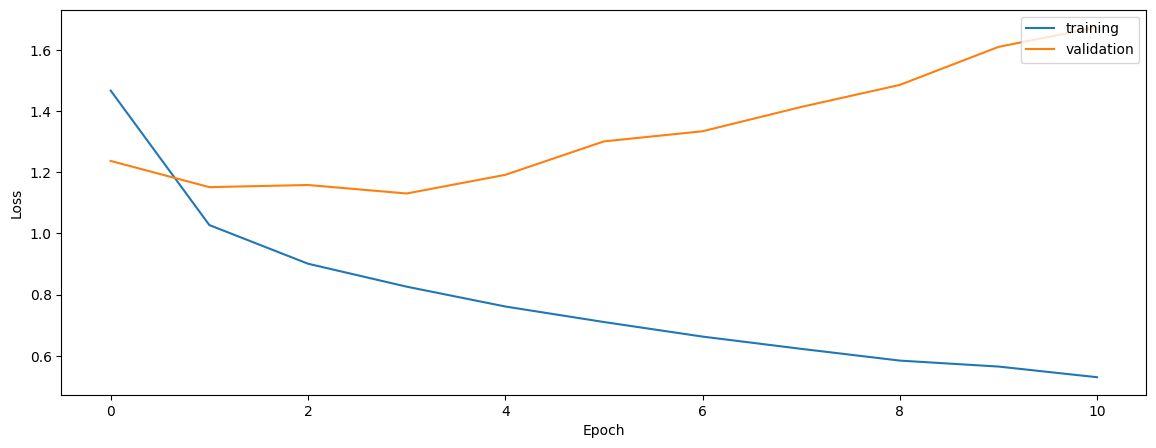

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7028710062591739
0.5962949881984047
0.5702846108346961


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6348786979998479
0.6056233864027539
0.5395925134156451


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6350223508436474
0.5947849048300143
0.5452908849725223


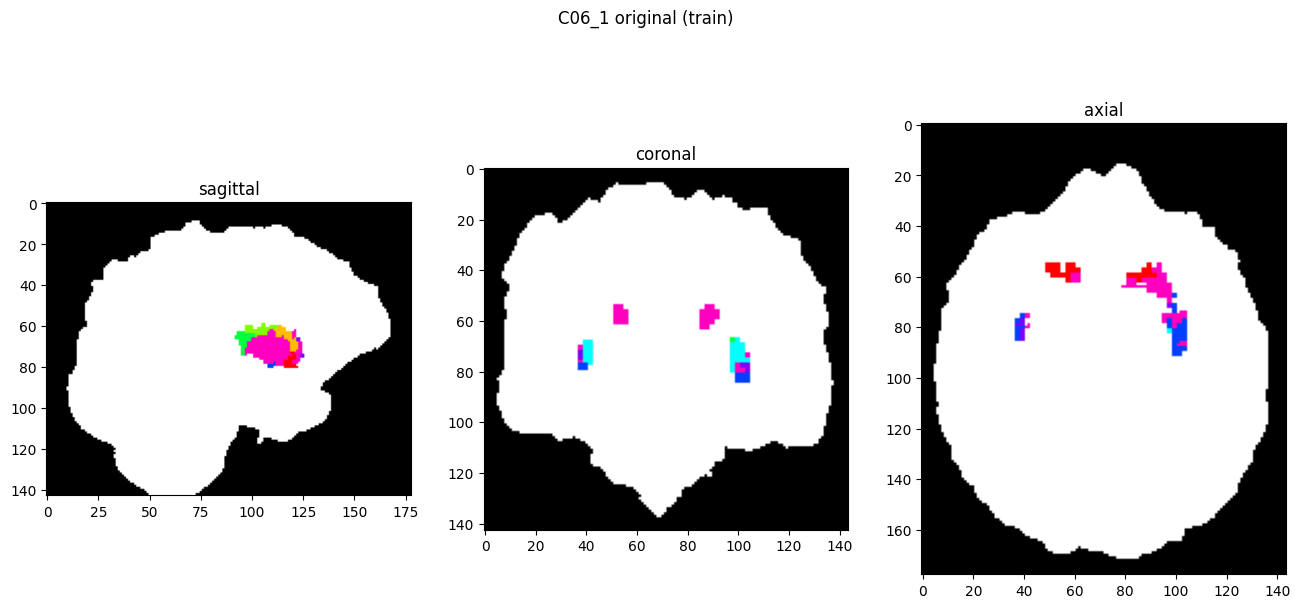

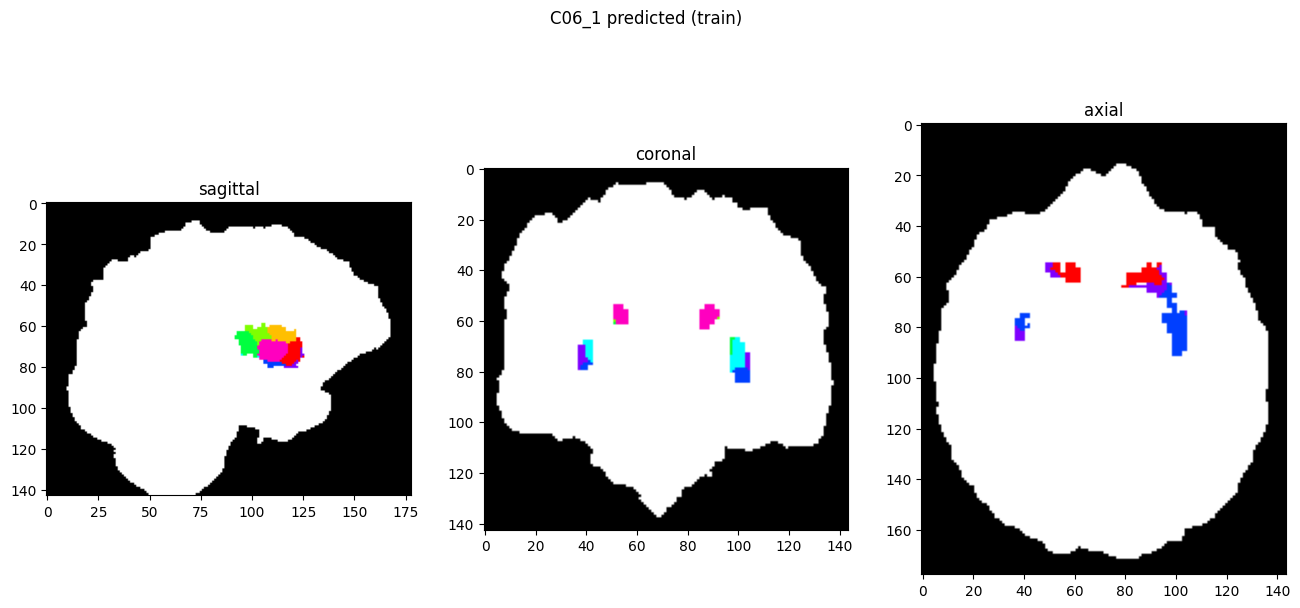

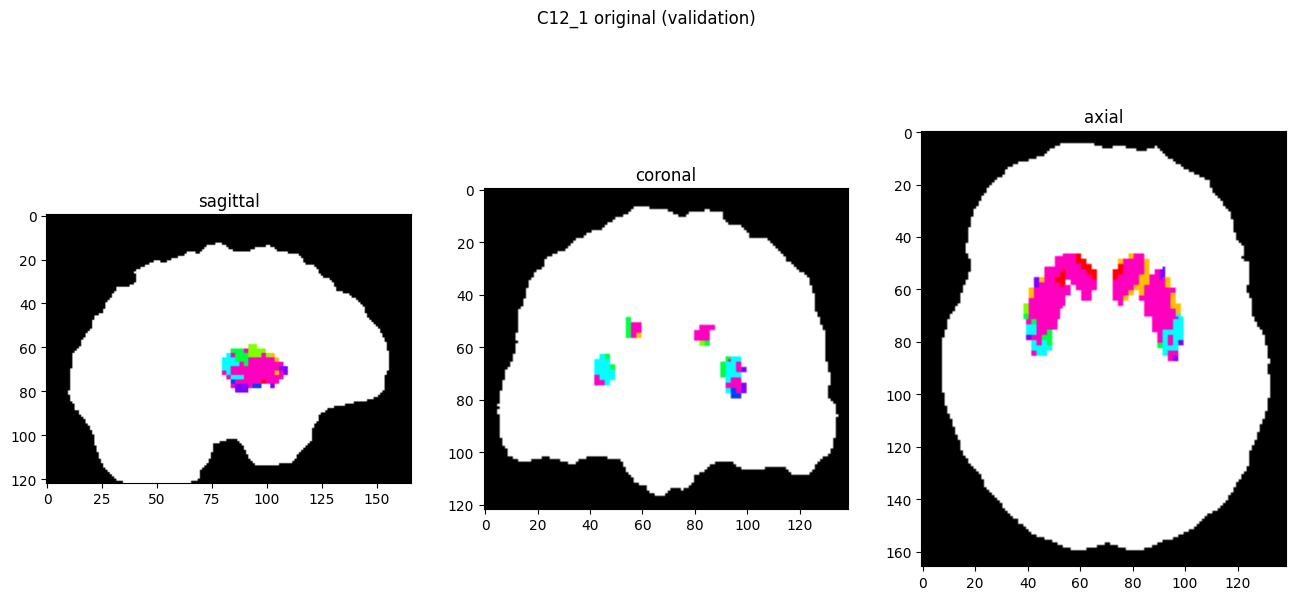

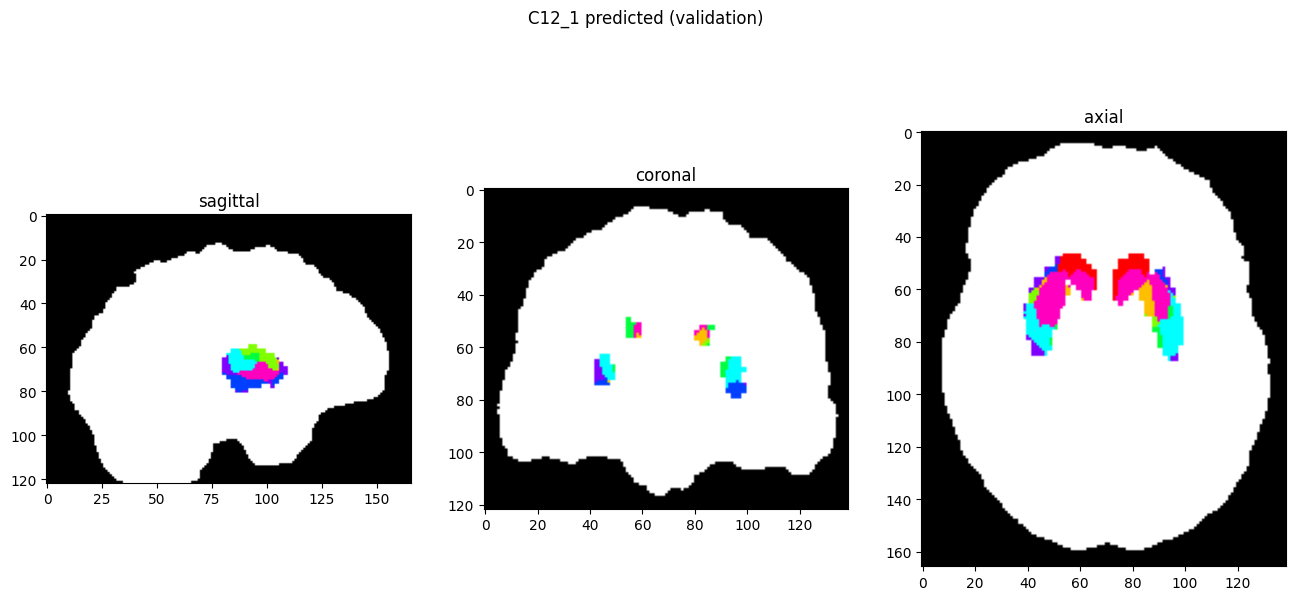

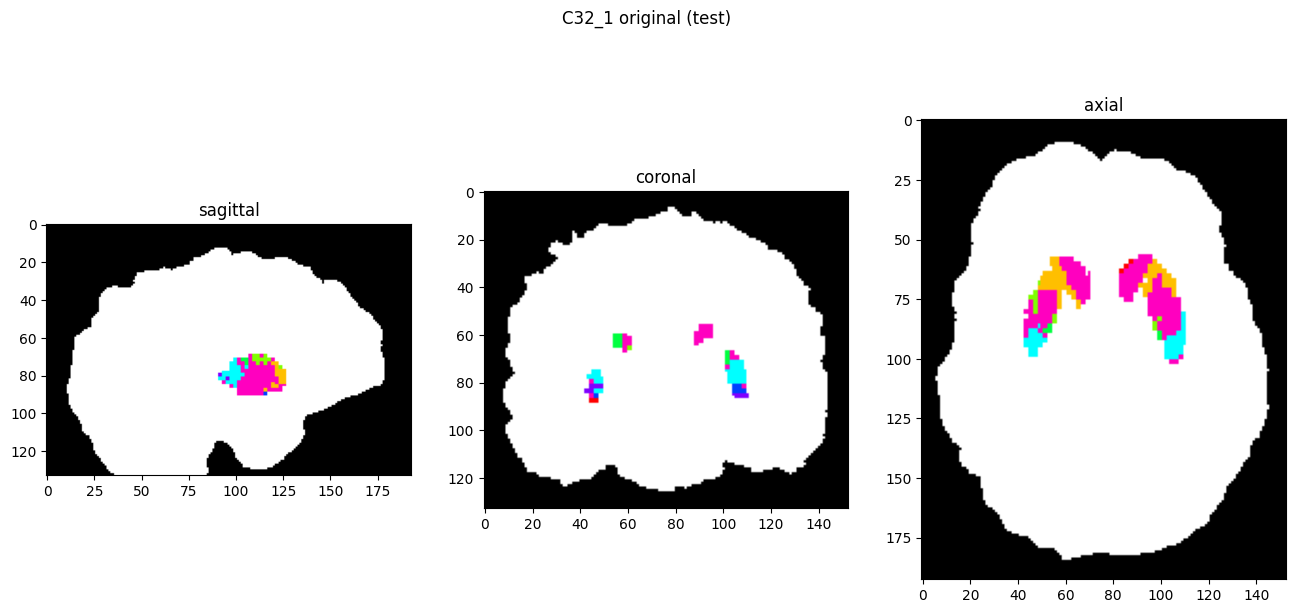

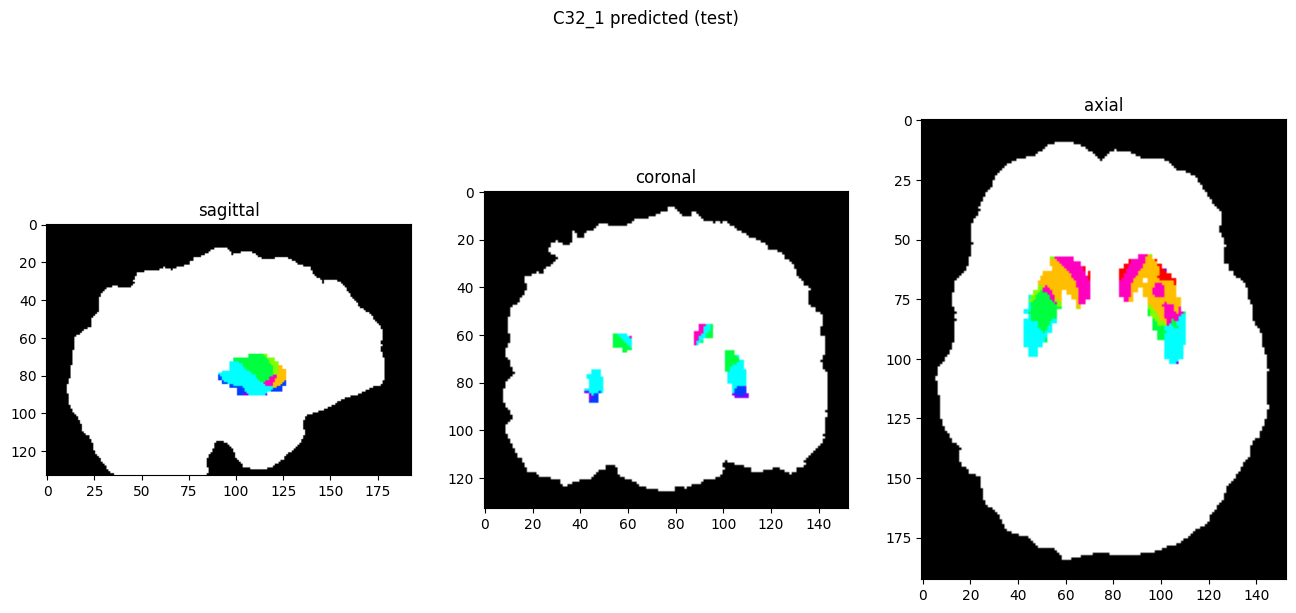

In [10]:
showResults(model, gen, threshold=0)